# Final analyses and model development

### Referring balanced random forest and XGBoost. Always considering real case scenarios of predicting a farther future and shuffling flows!
### Firstly, referring packet loss as features.
### Secondly, referring quantity of packet loss.

1. build the dataset with timestamp, flow id, class label, quantity of packet loss and all possbile features including class label as features, original features selected by visualization and other potential ones;
2. for the **original dataset** and both models, considering everything including predicting t+1, shuffling flows, best features from RFE and packet loss as features;
3. remove time bins with loss less than 3 to form a **shrink dataset** and consider all related aspects;
4. analyze new data in terms of everything.

In [1]:
import copy
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import warnings
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix 
from imblearn.ensemble import BalancedRandomForestClassifier
import glob
import os
from sklearn import preprocessing
import random
import xgboost as xgb
from sklearn.feature_selection import RFE

warnings.filterwarnings('ignore')

### Step 1

In [2]:
files = glob.glob("Retina/shared/*/*/*_500ms_Song_no_log.csv")

scaler = preprocessing.MinMaxScaler() 

df_total = []
for file in files:   
    df_input = pd.read_csv(file)
    
    df_inter = copy.deepcopy(df_input)
    df_inter = df_inter.loc[~df_inter['ip_src'].str.startswith('192')]
    drop_col = [
        'software', 
        'label', 
        'pcap', 
        'ssrc', 
        'rtp_seq_num_packet_loss', 
        'ip_src', 
        'ip_dst', 
        'prt_src', 
        'prt_dst', 
        'rtp_csrc_csrc_agg',
        'p_type'
    ]
    for col in df_inter.columns:
        if col in drop_col or col.startswith('rtp_interarrival'): 
            df_inter.drop(col, axis=1, inplace=True)
    
    flow_list = df_inter['flow'].drop_duplicates().tolist()
    for flow in flow_list:
        df_check = df_inter[df_inter['flow'] == flow].copy()
        if df_check.shape[0] > 10: 
            df_total.append(df_check)
        
df_total_final = []
flow_id = 1
for df_per_flow in df_total:
    df_temp = copy.deepcopy(df_per_flow)
    df_temp.reset_index(inplace=True)
    df_temp['lossOrNot'] = [1 if x>0 else 0 for x in df_temp['num_packet_loss']] 
    df_temp.drop(['index', 'flow'], axis=1, inplace=True) 
    df_temp['flow_id'] = flow_id
    flow_id += 1
    
    for col in df_temp.columns:
        if col not in ['timestamp', 'lossOrNot', 'num_packet_loss', 'flow_id']:
            df_temp[col] = scaler.fit_transform(df_temp[col].values.reshape(-1,1))
    
    start_time = pd.to_datetime(df_temp['timestamp'].min())
    stop_time = pd.to_datetime(df_temp['timestamp'].max())
    timestamp_ser = pd.date_range(start_time, stop_time, freq="500L")
    correct_len = len(timestamp_ser)
    
    if df_temp.shape[0] == correct_len:
        df_full = copy.deepcopy(df_temp)
        df_total_final.append(df_full)
    
    else:
        df_temp['timestamp'] = pd.to_datetime(df_temp['timestamp'])
        df_full = pd.DataFrame({'timestamp': timestamp_ser})
        df_full['timestamp'] = df_full['timestamp']
        df_full = df_full.merge(df_temp, on='timestamp', how='left')
        
        nan_index_list = [0]
        nan_index_list.extend(df_full[np.isnan(df_full['interarrival_std'])].index.tolist())
        nan_index_list.append(df_full.index[-1])
        
        for i in range(1, len(nan_index_list)):
            if nan_index_list[i] - nan_index_list[i-1] - 1 >= 11:
                start_idx = 0 if nan_index_list[i-1]==0 else nan_index_list[i-1]+1
                stop_idx = df_full.index[-1]+1 if nan_index_list[i]==df_full.index[-1] else nan_index_list[i]
                df_separate = df_full.iloc[start_idx:stop_idx, :].copy()
                df_separate.reset_index(inplace=True)
                df_separate.drop(['index'], axis=1, inplace=True)
                df_total_final.append(df_separate)

In [3]:
# all possible statistics (features) based on packet loss characterization, 32 in total

possible_features_list = [
    'interarrival_std',
    'interarrival_mean',
    'interarrival_min',
    'interarrival_max',
    'interarrival_kurtosis',
    'interarrival_skew',
    'interarrival_moment3',
    'interarrival_moment4',
    'interarrival_max_min_diff',
    'interarrival_max_min_R',
    'interarrival_min_max_R',
    'interarrival_max_value_count_percent',
    'len_udp_std',
    'len_udp_mean',
    'len_udp_kurtosis',
    'len_udp_skew',
    'len_udp_moment4',
    'len_udp_max_min_diff',
    'len_udp_max_min_R',
    'len_udp_min_max_R',
    'len_udp_max_value_count_percent',
    'interlength_udp_max',
    'interlength_udp_kurtosis',
    'interlength_udp_moment4',
    'interlength_udp_max_min_diff',
    'interlength_udp_max_value_count_percent',
    'rtp_inter_timestamp_std',
    'inter_time_sequence_std',
    'inter_time_sequence_max',
    'inter_time_sequence_moment4',
    'inter_time_sequence_max_min_diff',
    'inter_time_sequence_max_value_count_percent'
]

complete_list = ['timestamp', 'lossOrNot', 'num_packet_loss', 'flow_id']
complete_list.extend(possible_features_list)

In [4]:
# old best features selected based on RFE

best_feature_list = [
    'interarrival_std_minus_500ms',
    'interarrival_std_minus_3000ms',
    'interarrival_std_minus_4000ms',
    'interarrival_std_minus_4500ms',
    'interarrival_std_minus_5000ms',
    'interarrival_mean_minus_500ms',
    'interarrival_mean_minus_1000ms',
    'interarrival_mean_minus_1500ms',
    'interarrival_mean_minus_2000ms',
    'interarrival_mean_minus_2500ms',
    'interarrival_mean_minus_3000ms',
    'interarrival_mean_minus_3500ms',
    'interarrival_mean_minus_4000ms',
    'interarrival_mean_minus_4500ms',
    'interarrival_mean_minus_5000ms',
    'interarrival_min_minus_500ms',
    'interarrival_max_minus_500ms',
    'interarrival_max_minus_1000ms',
    'interarrival_max_minus_1500ms',
    'interarrival_max_minus_2000ms',
    'interarrival_max_minus_2500ms',
    'interarrival_max_minus_3000ms',
    'interarrival_max_minus_3500ms',
    'interarrival_max_minus_4000ms',
    'interarrival_max_minus_4500ms',
    'interarrival_max_minus_5000ms',
    'interarrival_kurtosis_minus_500ms',
    'interarrival_kurtosis_minus_3000ms',
    'interarrival_skew_minus_500ms',
    'interarrival_skew_minus_1000ms',
    'interarrival_skew_minus_1500ms',
    'interarrival_skew_minus_2000ms',
    'interarrival_skew_minus_4000ms',
    'interarrival_skew_minus_4500ms',
    'interarrival_moment3_minus_500ms',
    'interarrival_moment3_minus_1000ms',
    'interarrival_moment3_minus_1500ms',
    'interarrival_moment3_minus_2000ms',
    'interarrival_moment3_minus_2500ms',
    'interarrival_moment3_minus_3000ms',
    'interarrival_moment3_minus_3500ms',
    'interarrival_moment3_minus_4000ms',
    'interarrival_moment3_minus_4500ms',
    'interarrival_moment3_minus_5000ms',
    'interarrival_moment4_minus_500ms',
    'interarrival_max_min_diff_minus_500ms',
    'interarrival_max_min_diff_minus_1000ms',
    'interarrival_max_min_diff_minus_4000ms',
    'interarrival_max_min_R_minus_500ms',
    'interarrival_max_min_R_minus_1000ms',
    'interarrival_min_max_R_minus_500ms',
    'interarrival_min_max_R_minus_1000ms',
    'interarrival_max_value_count_percent_minus_500ms',
    'interarrival_max_value_count_percent_minus_1000ms',
    'interarrival_max_value_count_percent_minus_1500ms',
    'interarrival_max_value_count_percent_minus_2000ms',
    'interarrival_max_value_count_percent_minus_2500ms',
    'interarrival_max_value_count_percent_minus_3000ms',
    'interarrival_max_value_count_percent_minus_3500ms',
    'interarrival_max_value_count_percent_minus_5000ms',
    'len_udp_mean_minus_500ms',
    'len_udp_mean_minus_1000ms',
    'len_udp_mean_minus_1500ms',
    'len_udp_mean_minus_2000ms',
    'len_udp_mean_minus_2500ms',
    'len_udp_mean_minus_3000ms',
    'len_udp_mean_minus_3500ms',
    'len_udp_mean_minus_4000ms',
    'len_udp_mean_minus_4500ms',
    'len_udp_mean_minus_5000ms',
    'len_udp_skew_minus_500ms',
    'len_udp_skew_minus_1000ms',
    'len_udp_skew_minus_1500ms',
    'len_udp_skew_minus_3000ms',
    'len_udp_skew_minus_4000ms',
    'len_udp_skew_minus_4500ms',
    'len_udp_skew_minus_5000ms',
    'len_udp_moment4_minus_500ms',
    'len_udp_moment4_minus_3500ms',
    'len_udp_max_min_R_minus_500ms',
    'len_udp_max_min_R_minus_1000ms',
    'len_udp_max_min_R_minus_2500ms',
    'interlength_udp_kurtosis_minus_1000ms',
    'interlength_udp_moment4_minus_500ms',
    'interlength_udp_moment4_minus_1000ms',
    'interlength_udp_moment4_minus_1500ms',
    'interlength_udp_max_value_count_percent_minus_500ms',
    'rtp_inter_timestamp_std_minus_500ms',
    'rtp_inter_timestamp_std_minus_1000ms',
    'rtp_inter_timestamp_std_minus_1500ms',
    'rtp_inter_timestamp_std_minus_2000ms',
    'rtp_inter_timestamp_std_minus_2500ms',
    'rtp_inter_timestamp_std_minus_3000ms',
    'rtp_inter_timestamp_std_minus_3500ms',
    'rtp_inter_timestamp_std_minus_4000ms',
    'rtp_inter_timestamp_std_minus_4500ms',
    'rtp_inter_timestamp_std_minus_5000ms',
    'inter_time_sequence_std_minus_500ms',
    'inter_time_sequence_std_minus_1000ms',
    'inter_time_sequence_moment4_minus_500ms',
    'inter_time_sequence_max_value_count_percent_minus_500ms',
    'inter_time_sequence_max_value_count_percent_minus_1000ms',
    'inter_time_sequence_max_value_count_percent_minus_1500ms',
    'inter_time_sequence_max_value_count_percent_minus_2000ms',
    'inter_time_sequence_max_value_count_percent_minus_2500ms',
    'inter_time_sequence_max_value_count_percent_minus_3000ms',
    'inter_time_sequence_max_value_count_percent_minus_3500ms',
    'inter_time_sequence_max_value_count_percent_minus_4000ms',
    'inter_time_sequence_max_value_count_percent_minus_4500ms',
    'inter_time_sequence_max_value_count_percent_minus_5000ms'
]

for i in range(1,11):
    col_title = f'lossOrNot_minus_{500*i}ms'
    best_feature_list.append(col_title)
    
best_feature_list_removing_500ms = []
for feature in best_feature_list:
    if '_500ms' not in feature:
        best_feature_list_removing_500ms.append(feature)

len(best_feature_list_removing_500ms)

97

In [5]:
# original statistics (features) selected by visualizations

selected_features_list_removing_correlation = [
    'interarrival_std',
    'interarrival_min',
    'interarrival_max',
    'interarrival_skew',
    'interarrival_moment4',
    'interarrival_max_min_R',
    'interarrival_max_value_count_percent',
    'len_udp_moment4',
    'len_udp_max_min_diff',
    'len_udp_max_value_count_percent',
    'inter_time_sequence_std'
]

full_features_list = [] # original features
for feature in selected_features_list_removing_correlation:
    for i in range(1,11):
        col_title = f'{feature}_minus_{500*i}ms'
        full_features_list.append(col_title)
for i in range(1,11):
    col_title = f'lossOrNot_minus_{500*i}ms'
    full_features_list.append(col_title)

In [6]:
df_total_final_feature_extraction = []
for df in df_total_final:
    df_temp = copy.deepcopy(df)
    df_temp = df_temp[complete_list]
    temp_feature_list = possible_features_list.copy()
    temp_feature_list.append('lossOrNot')
    for feature in temp_feature_list:
        for i in range(1,11):
            col_title = f'{feature}_minus_{500*i}ms'
            df_temp[col_title] = df_temp[feature].shift(periods=i, fill_value=-1)
    df_temp.drop(possible_features_list, axis=1, inplace=True)
    df_temp = df_temp.iloc[10:]
    df_temp.reset_index(inplace=True)
    df_temp.drop(['index'], axis=1, inplace=True)
    
    df_total_final_feature_extraction.append(df_temp)

In [7]:
df_final_with_flow_id_past_loss = pd.concat(df_total_final_feature_extraction)
df_final_with_flow_id_past_loss.reset_index(inplace=True)
df_final_with_flow_id_past_loss.drop(['index'], axis=1, inplace=True)
df_final_with_flow_id_past_loss

timestamp  lossOrNot  num_packet_loss  flow_id  \
0        2020-12-14 13:34:44.500000        0.0              0.0      1.0   
1               2020-12-14 13:34:45        0.0              0.0      1.0   
2        2020-12-14 13:34:45.500000        0.0              0.0      1.0   
3               2020-12-14 13:34:46        0.0              0.0      1.0   
4        2020-12-14 13:34:46.500000        0.0              0.0      1.0   
...                             ...        ...              ...      ...   
2028655     2020-05-13 14:59:09.000        0.0              0.0   2882.0   
2028656     2020-05-13 14:59:09.500        0.0              0.0   2882.0   
2028657     2020-05-13 14:59:10.000        0.0              0.0   2882.0   
2028658     2020-05-13 14:59:10.500        0.0              0.0   2882.0   
2028659     2020-05-13 14:59:11.000        0.0              0.0   2882.0   

         interarrival_std_minus_500ms  interarrival_std_minus_1000ms  \
0                            0.185914                       0.111167   
1                            0.169699                       0.185914   
2                            0.122365                       0.169699   
3                            0.081800                       0.122365   
4                            0.113890                       0.081800   
...                               ...                            ...   
2028655                      0.083744                       0.075046   
2028656                      0.083497                       0.083744   
2028657                      0.048801                       0.083497   
2028658                      0.133611                       0.048801   
2028659                      0.098195                       0.133611   

         interarrival_std_minus_1500ms  interarrival_std_minus_2000ms  \
0                             0.149341                       0.168203   
1                             0.111167                       0.149341   
2                             0.185914                       0.111167   
3                             0.169699                       0.185914   
4                             0.122365                       0.169699   
...                                ...                            ...   
2028655                       0.078230                       0.131936   
2028656                       0.075046                       0.078230   
2028657                       0.083744                       0.075046   
2028658                       0.083497                       0.083744   
2028659                       0.048801                       0.083497   

         interarrival_std_minus_2500ms  interarrival_std_minus_3000ms  ...  \
0                             0.224819                       0.287330  ...   
1                             0.168203                       0.224819  ...   
2                             0.149341                       0.168203  ...   
3                             0.111167                       0.149341  ...   
4                             0.185914                       0.111167  ...   
...                                ...                            ...  ...   
2028655                       0.078184                       0.058745  ...   
2028656                       0.131936                       0.078184  ...   
2028657                       0.078230                       0.131936  ...   
2028658                       0.075046                       0.078230  ...   
2028659                       0.083744                       0.075046  ...   

         lossOrNot_minus_500ms  lossOrNot_minus_1000ms  \
0                          0.0                     0.0   
1                          0.0                     0.0   
2                          0.0                     0.0   
3                          0.0                     0.0   
4                          0.0                     0.0   
...                        ...                     ...   
2028655                    0

In [319]:
df_loss = df_final_with_flow_id_past_loss[df_final_with_flow_id_past_loss['lossOrNot'] > 0]
df_no_loss = df_final_with_flow_id_past_loss[df_final_with_flow_id_past_loss['lossOrNot'] < 1]

flow_id_loss = df_loss['flow_id'].drop_duplicates().tolist()
flow_id_no_loss = df_no_loss['flow_id'].drop_duplicates().tolist()
shuffled_flow_id_loss = flow_id_loss.copy()
shuffled_flow_id_no_loss = flow_id_no_loss.copy()

### Step 2

#### 1. check how packet loss as feature affect the model (basic analysis without others), this has already been done with brf previously.

#### 2. check how packet loss as feature affect the model considering shuffling flows using both models (only ten trials for simplicity)

Prediction Report of trial 1
               precision    recall  f1-score   support

           0       0.99      0.77      0.87    600134
           1       0.04      0.60      0.07      8461

    accuracy                           0.77    608595
   macro avg       0.51      0.68      0.47    608595
weighted avg       0.98      0.77      0.86    608595



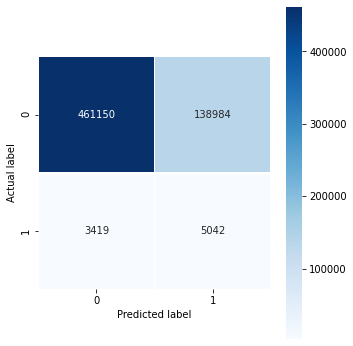

Prediction Report of trial 2
               precision    recall  f1-score   support

           0       0.99      0.69      0.82    600134
           1       0.03      0.71      0.06      8461

    accuracy                           0.69    608595
   macro avg       0.51      0.70      0.44    608595
weighted avg       0.98      0.69      0.81    608595



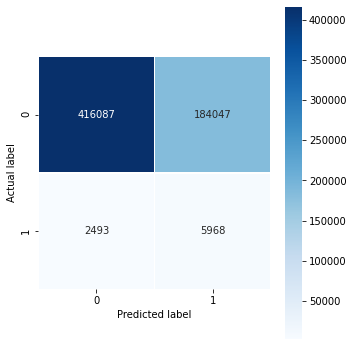

Prediction Report of trial 3
               precision    recall  f1-score   support

           0       0.99      0.71      0.83    600134
           1       0.03      0.69      0.06      8461

    accuracy                           0.71    608595
   macro avg       0.51      0.70      0.45    608595
weighted avg       0.98      0.71      0.82    608595



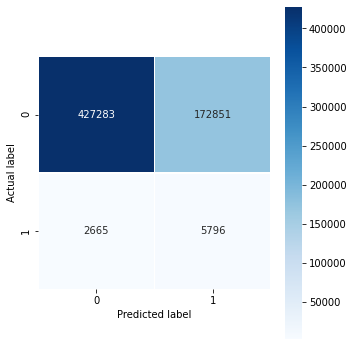

Prediction Report of trial 4
               precision    recall  f1-score   support

           0       0.99      0.75      0.85    600134
           1       0.03      0.61      0.06      8461

    accuracy                           0.75    608595
   macro avg       0.51      0.68      0.46    608595
weighted avg       0.98      0.75      0.84    608595



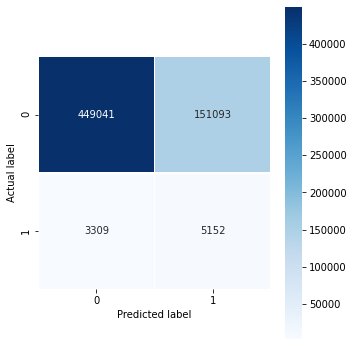

Prediction Report of trial 5
               precision    recall  f1-score   support

           0       0.99      0.69      0.81    600134
           1       0.03      0.67      0.06      8461

    accuracy                           0.69    608595
   macro avg       0.51      0.68      0.44    608595
weighted avg       0.98      0.69      0.80    608595



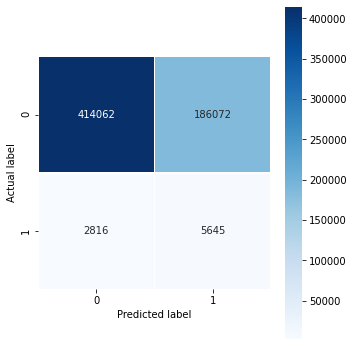

Prediction Report of trial 6
               precision    recall  f1-score   support

           0       0.99      0.71      0.83    600134
           1       0.03      0.58      0.05      8461

    accuracy                           0.71    608595
   macro avg       0.51      0.64      0.44    608595
weighted avg       0.98      0.71      0.82    608595



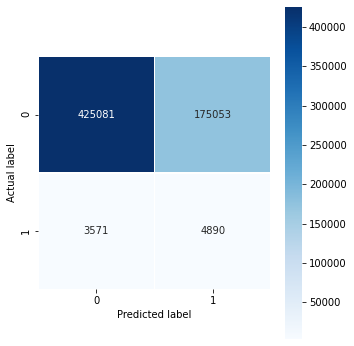

Prediction Report of trial 7
               precision    recall  f1-score   support

           0       0.99      0.74      0.85    600134
           1       0.03      0.56      0.06      8461

    accuracy                           0.74    608595
   macro avg       0.51      0.65      0.45    608595
weighted avg       0.98      0.74      0.84    608595



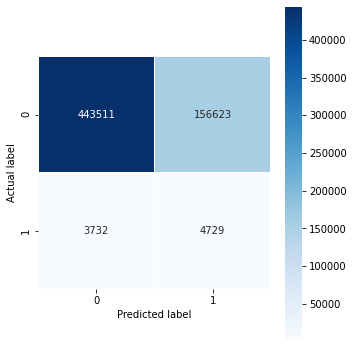

Prediction Report of trial 8
               precision    recall  f1-score   support

           0       0.99      0.72      0.83    600134
           1       0.03      0.70      0.06      8461

    accuracy                           0.72    608595
   macro avg       0.51      0.71      0.45    608595
weighted avg       0.98      0.72      0.82    608595



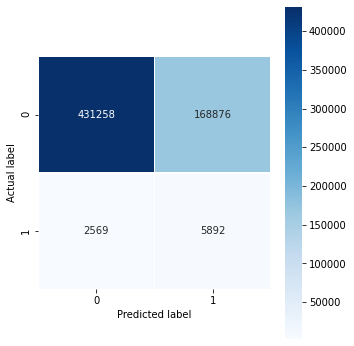

Prediction Report of trial 9
               precision    recall  f1-score   support

           0       0.99      0.71      0.83    600134
           1       0.03      0.56      0.05      8461

    accuracy                           0.71    608595
   macro avg       0.51      0.64      0.44    608595
weighted avg       0.98      0.71      0.82    608595



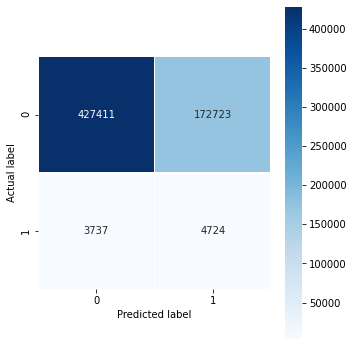

Prediction Report of trial 10
               precision    recall  f1-score   support

           0       0.99      0.72      0.84    600134
           1       0.03      0.70      0.07      8461

    accuracy                           0.72    608595
   macro avg       0.51      0.71      0.45    608595
weighted avg       0.98      0.72      0.83    608595



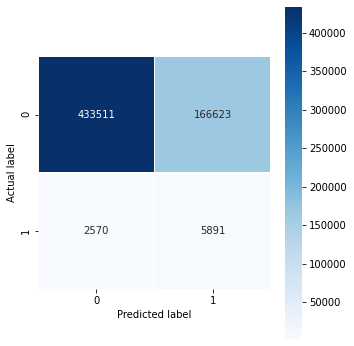

In [320]:
# brf

recall_0_list_step2 = []
recall_1_list_step2 = []
recall_avg_list_step2 = []

for trial in range(1, 11):
    random.seed(trial)
    
    random.shuffle(shuffled_flow_id_loss)
    random.shuffle(shuffled_flow_id_no_loss)
    
    df_loss_new = pd.concat([df_loss[df_loss['flow_id']==x] for x in shuffled_flow_id_loss])
    df_no_loss_new = pd.concat([df_no_loss[df_no_loss['flow_id']==x] for x in shuffled_flow_id_no_loss])
            
    df_train = pd.concat([df_loss_new.iloc[0:int(df_loss_new.shape[0] * 0.7)], df_no_loss_new.iloc[0:int(df_no_loss_new.shape[0] * 0.7)]])
    df_train_shuffled = df_train.sample(frac=1).reset_index()
    df_train_shuffled.drop(['index'], axis=1, inplace=True)
    df_test = pd.concat([df_loss_new.iloc[int(df_loss_new.shape[0] * 0.7)+1: -1], df_no_loss_new.iloc[int(df_no_loss_new.shape[0] * 0.7)+1: -1]])
    df_test_shuffled = df_test.sample(frac=1).reset_index()
    df_test_shuffled.drop(['index'], axis=1, inplace=True)

    x_train = df_train_shuffled[full_features_list]
    x_test = df_test_shuffled[full_features_list]
    y_train = df_train_shuffled[['lossOrNot']]
    y_train = y_train.astype(int)
    y_test = df_test_shuffled[['lossOrNot']]
    y_test = y_test.astype(int)
    
    my_brf_model_check = BalancedRandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=0) 
    my_brf_model_check.fit(x_train, y_train)
            
    y_pred = my_brf_model_check.predict(x_test)
    print(f"Prediction Report of trial {trial}\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
    report = classification_report(y_test, y_pred, output_dict=True)
    recall_0_list_step2.append(report['0']['recall'])
    recall_1_list_step2.append(report['1']['recall'])
    recall_avg_list_step2.append(report['macro avg']['recall'])

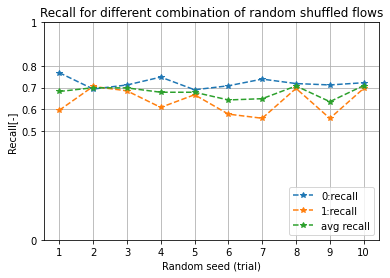

The best performance is at trial 10:
   recall of class 0: 0.7223570069351178
   recall of class 1: 0.6962533979435055
   macro average recall: 0.7093052024393116
                  OR
The best performance is at trial 8:
   recall of class 0: 0.7186028453645352
   recall of class 1: 0.6963715872828271
   macro average recall: 0.7074872163236812

The average is 0.7212380901598643 (0:recall), 0.635019501240988 (1:recall), 0.6781287957004263 (avg recall)


In [325]:
x_label = list(range(1,11))
plt.figure(figsize=(6,4))
plt.plot(x_label, recall_0_list_step2, '*--', label='0:recall')
plt.plot(x_label, recall_1_list_step2, '*--', label='1:recall')
plt.plot(x_label, recall_avg_list_step2, '*--', label='avg recall')
plt.xticks(x_label, x_label)
plt.legend(loc=4)
plt.grid()
plt.ylim([0,1])
plt.yticks([0, 0.5, 0.6, 0.7, 0.8, 1], [0, 0.5, 0.6, 0.7, 0.8, 1])
plt.title('Recall for different combination of random shuffled flows')
plt.xlabel('Random seed (trial)')
plt.ylabel('Recall[-]')
plt.show()

print(f'The best performance is at trial 10:\n   recall of class 0: {recall_0_list_step2[9]}\n   recall of class 1: {recall_1_list_step2[9]}\n   macro average recall: {recall_avg_list_step2[9]}')
print('                  OR')
print(f'The best performance is at trial 8:\n   recall of class 0: {recall_0_list_step2[7]}\n   recall of class 1: {recall_1_list_step2[7]}\n   macro average recall: {recall_avg_list_step2[7]}')
print()
print(f'The average is {np.array(recall_0_list_step2).mean()} (0:recall), {np.array(recall_1_list_step2).mean()} (1:recall), {np.array(recall_avg_list_step2).mean()} (avg recall)')

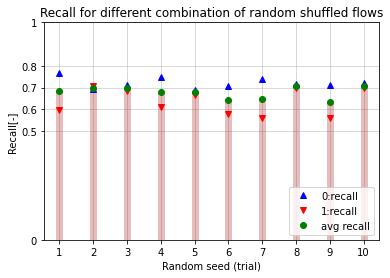

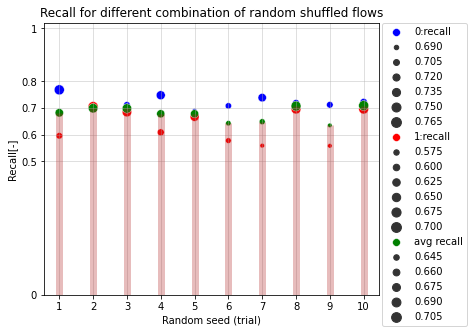

In [330]:
x_label = list(range(1,11))
plt.figure(figsize=(6,4))
plt.plot(x_label, recall_0_list_step2, '^', label='0:recall', color='b')
plt.plot(x_label, recall_1_list_step2, 'v', label='1:recall', color='r')
plt.plot(x_label, recall_avg_list_step2, 'o', label='avg recall', color='g')
plt.vlines(x=x_label, ymin=0, ymax=recall_avg_list_step2, linestyles='solid', color='firebrick', alpha=0.3, linewidth=7)
plt.xticks(x_label, x_label)
plt.legend(loc=4)
plt.grid(alpha=0.6)
plt.ylim([0,1])
plt.yticks([0, 0.5, 0.6, 0.7, 0.8, 1], [0, 0.5, 0.6, 0.7, 0.8, 1])
plt.title('Recall for different combination of random shuffled flows')
plt.xlabel('Random seed (trial)')
plt.ylabel('Recall[-]')
plt.show()

plt.figure(figsize=(6,5))
sns.scatterplot(x=x_label, y=recall_0_list_step2, label='0:recall', size=recall_0_list_step2, sizes=(20, 100), color='b')
sns.scatterplot(x=x_label, y=recall_1_list_step2, label='1:recall', size=recall_1_list_step2, sizes=(20, 100), color='r')
sns.scatterplot(x=x_label, y=recall_avg_list_step2, label='avg recall', size=recall_avg_list_step2, sizes=(20, 100), color='g')
plt.vlines(x=x_label, ymin=0, ymax=recall_avg_list_step2, linestyles='solid', color='firebrick', alpha=0.3, linewidth=7)
plt.xticks(x_label, x_label)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.grid(alpha=0.5)
plt.ylim([0,1.02])
plt.yticks([0, 0.5, 0.6, 0.7, 0.8, 1], [0, 0.5, 0.6, 0.7, 0.8, 1])
plt.title('Recall for different combination of random shuffled flows')
plt.xlabel('Random seed (trial)')
plt.ylabel('Recall[-]')
plt.show()

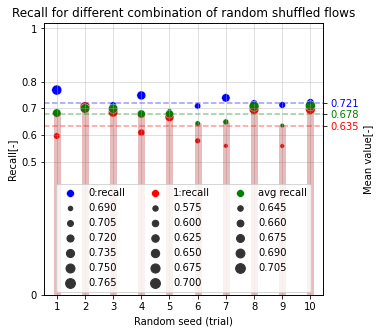

In [21]:
plt.figure(figsize=(5,5))
sns.scatterplot(x=x_label, y=recall_0_list_step2, label='0:recall', size=recall_0_list_step2, sizes=(20, 100), color='b')
sns.scatterplot(x=x_label, y=recall_1_list_step2, label='1:recall', size=recall_1_list_step2, sizes=(20, 100), color='r')
sns.scatterplot(x=x_label, y=recall_avg_list_step2, label='avg recall', size=recall_avg_list_step2, sizes=(20, 100), color='g')
plt.vlines(x=x_label, ymin=0, ymax=recall_avg_list_step2, linestyles='solid', color='firebrick', alpha=0.3, linewidth=7)
plt.xticks(x_label, x_label)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 0.01), borderaxespad=0, ncol=3)
plt.grid(alpha=0.5)
plt.ylim([0,1.02])
plt.yticks([0, 0.5, 0.6, 0.7, 0.8, 1], [0, 0.5, 0.6, 0.7, 0.8, 1])
plt.title('Recall for different combination of random shuffled flows')
plt.xlabel('Random seed (trial)')
plt.ylabel('Recall[-]')
plt.axhline(y=0.721, color='b', linestyle='--', alpha=0.4, label='class 0')
plt.axhline(y=0.635, color='r', linestyle='--', alpha=0.4, label='class 1')
plt.axhline(y=0.678, color='g', linestyle='--', alpha=0.4, label='avg recall')
ax2 = plt.gca().twinx()
ax2.set_yticks([0.721, 0.635, 0.678])
ax2.set_ylim([0,1.02])
ax2.set_ylabel('Mean value[-]')
ax2.get_yticklabels()[0].set_color("b")
ax2.get_yticklabels()[1].set_color("r")
ax2.get_yticklabels()[2].set_color("g")
plt.show()

In [327]:
print(recall_0_list_step2)
print(recall_1_list_step2)
print(recall_avg_list_step2)

[0.7684117213822247, 0.6933234910869905, 0.7119793246175021, 0.748234560948055, 0.6899492446686907, 0.7083101440678249, 0.739019952210673, 0.7186028453645352, 0.7121926103170292, 0.7223570069351178]
[0.5959106488594729, 0.7053539770712681, 0.6850254107079542, 0.6089114761848481, 0.6671788204703936, 0.5779458692825907, 0.5589173856518143, 0.6963715872828271, 0.5583264389552063, 0.6962533979435055]
[0.6821611851208488, 0.6993387340791293, 0.6985023676627282, 0.6785730185664516, 0.6785640325695421, 0.6431280066752079, 0.6489686689312436, 0.7074872163236812, 0.6352595246361177, 0.7093052024393116]


In [321]:
# xgboost

shuffled_flow_id_loss = flow_id_loss.copy()
shuffled_flow_id_no_loss = flow_id_no_loss.copy()
weight = len(df_no_loss) / len(df_loss)
weight

70.92044527954054

[0]	validation_0-aucpr:0.112735
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.174176
[2]	validation_0-aucpr:0.175102
[3]	validation_0-aucpr:0.182056
[4]	validation_0-aucpr:0.202757
[5]	validation_0-aucpr:0.203239
[6]	validation_0-aucpr:0.206607
[7]	validation_0-aucpr:0.20805
[8]	validation_0-aucpr:0.214337
[9]	validation_0-aucpr:0.217793
[10]	validation_0-aucpr:0.220855
[11]	validation_0-aucpr:0.223871
[12]	validation_0-aucpr:0.224379
[13]	validation_0-aucpr:0.223144
[14]	validation_0-aucpr:0.224098
[15]	validation_0-aucpr:0.226496
[16]	validation_0-aucpr:0.226921
[17]	validation_0-aucpr:0.227648
[18]	validation_0-aucpr:0.228399
[19]	validation_0-aucpr:0.22986
[20]	validation_0-aucpr:0.229751
[21]	validation_0-aucpr:0.230122
[22]	validation_0-aucpr:0.230782
[23]	validation_0-aucpr:0.228748
[24]	validation_0-aucpr:0.228637
[25]	validation_0-aucpr:0.228598
[26]	validation_0-aucpr:0.228558
[27]	validation_0-aucpr:0.227548
[28]	validation_0-aucp

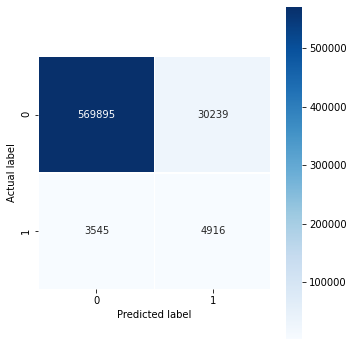

[0]	validation_0-aucpr:0.21982
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.217522
[2]	validation_0-aucpr:0.224832
[3]	validation_0-aucpr:0.229373
[4]	validation_0-aucpr:0.23128
[5]	validation_0-aucpr:0.213997
[6]	validation_0-aucpr:0.226157
[7]	validation_0-aucpr:0.234465
[8]	validation_0-aucpr:0.235085
[9]	validation_0-aucpr:0.243554
[10]	validation_0-aucpr:0.240489
[11]	validation_0-aucpr:0.241004
[12]	validation_0-aucpr:0.237933
[13]	validation_0-aucpr:0.243854
[14]	validation_0-aucpr:0.244577
[15]	validation_0-aucpr:0.244969
[16]	validation_0-aucpr:0.247005
[17]	validation_0-aucpr:0.246011
[18]	validation_0-aucpr:0.241578
[19]	validation_0-aucpr:0.244239
[20]	validation_0-aucpr:0.244985
[21]	validation_0-aucpr:0.237663
[22]	validation_0-aucpr:0.235631
[23]	validation_0-aucpr:0.231823
[24]	validation_0-aucpr:0.2269
[25]	validation_0-aucpr:0.22452
[26]	validation_0-aucpr:0.226109
Stopping. Best iteration:
[16]	validation_0-aucpr:0.247005

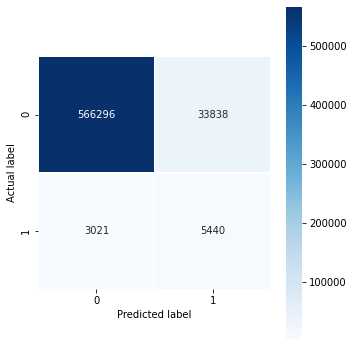

[0]	validation_0-aucpr:0.231606
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.255341
[2]	validation_0-aucpr:0.27002
[3]	validation_0-aucpr:0.269249
[4]	validation_0-aucpr:0.276241
[5]	validation_0-aucpr:0.279459
[6]	validation_0-aucpr:0.281038
[7]	validation_0-aucpr:0.28042
[8]	validation_0-aucpr:0.274047
[9]	validation_0-aucpr:0.282355
[10]	validation_0-aucpr:0.279643
[11]	validation_0-aucpr:0.283126
[12]	validation_0-aucpr:0.279166
[13]	validation_0-aucpr:0.280608
[14]	validation_0-aucpr:0.278311
[15]	validation_0-aucpr:0.28212
[16]	validation_0-aucpr:0.282914
[17]	validation_0-aucpr:0.282501
[18]	validation_0-aucpr:0.280936
[19]	validation_0-aucpr:0.283184
[20]	validation_0-aucpr:0.28234
[21]	validation_0-aucpr:0.281229
[22]	validation_0-aucpr:0.280249
[23]	validation_0-aucpr:0.280752
[24]	validation_0-aucpr:0.282586
[25]	validation_0-aucpr:0.28138
[26]	validation_0-aucpr:0.281244
[27]	validation_0-aucpr:0.279236
[28]	validation_0-aucpr:0

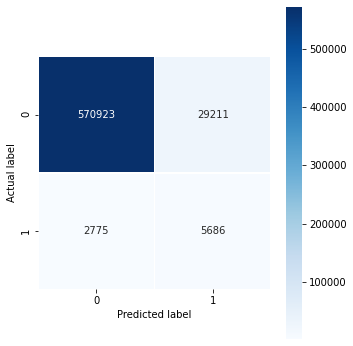

[0]	validation_0-aucpr:0.162244
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.185074
[2]	validation_0-aucpr:0.186219
[3]	validation_0-aucpr:0.190174
[4]	validation_0-aucpr:0.19217
[5]	validation_0-aucpr:0.195388
[6]	validation_0-aucpr:0.191929
[7]	validation_0-aucpr:0.197724
[8]	validation_0-aucpr:0.196554
[9]	validation_0-aucpr:0.199967
[10]	validation_0-aucpr:0.199054
[11]	validation_0-aucpr:0.202335
[12]	validation_0-aucpr:0.205574
[13]	validation_0-aucpr:0.208262
[14]	validation_0-aucpr:0.20756
[15]	validation_0-aucpr:0.207959
[16]	validation_0-aucpr:0.210598
[17]	validation_0-aucpr:0.208771
[18]	validation_0-aucpr:0.208087
[19]	validation_0-aucpr:0.209247
[20]	validation_0-aucpr:0.20978
[21]	validation_0-aucpr:0.207623
[22]	validation_0-aucpr:0.205924
[23]	validation_0-aucpr:0.205389
[24]	validation_0-aucpr:0.209183
[25]	validation_0-aucpr:0.208122
[26]	validation_0-aucpr:0.20773
Stopping. Best iteration:
[16]	validation_0-aucpr:0.21059

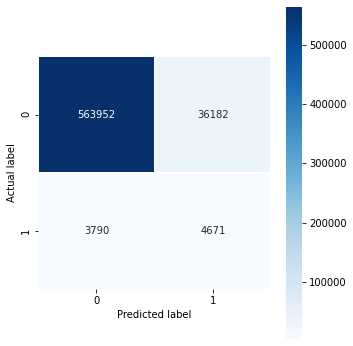

[0]	validation_0-aucpr:0.158762
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.19557
[2]	validation_0-aucpr:0.19623
[3]	validation_0-aucpr:0.206572
[4]	validation_0-aucpr:0.205415
[5]	validation_0-aucpr:0.197458
[6]	validation_0-aucpr:0.18305
[7]	validation_0-aucpr:0.174185
[8]	validation_0-aucpr:0.175292
[9]	validation_0-aucpr:0.173356
[10]	validation_0-aucpr:0.174303
[11]	validation_0-aucpr:0.175974
[12]	validation_0-aucpr:0.183314
[13]	validation_0-aucpr:0.185224
Stopping. Best iteration:
[3]	validation_0-aucpr:0.206572

Prediction Report of trial 5
               precision    recall  f1-score   support

           0       0.99      0.93      0.96    600134
           1       0.11      0.56      0.18      8461

    accuracy                           0.93    608595
   macro avg       0.55      0.75      0.57    608595
weighted avg       0.98      0.93      0.95    608595



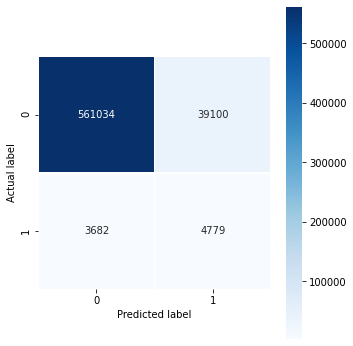

[0]	validation_0-aucpr:0.156721
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.164833
[2]	validation_0-aucpr:0.178498
[3]	validation_0-aucpr:0.180192
[4]	validation_0-aucpr:0.183736
[5]	validation_0-aucpr:0.186939
[6]	validation_0-aucpr:0.2012
[7]	validation_0-aucpr:0.202771
[8]	validation_0-aucpr:0.20413
[9]	validation_0-aucpr:0.208627
[10]	validation_0-aucpr:0.211034
[11]	validation_0-aucpr:0.208951
[12]	validation_0-aucpr:0.215519
[13]	validation_0-aucpr:0.209622
[14]	validation_0-aucpr:0.215551
[15]	validation_0-aucpr:0.216461
[16]	validation_0-aucpr:0.215714
[17]	validation_0-aucpr:0.217467
[18]	validation_0-aucpr:0.220383
[19]	validation_0-aucpr:0.222812
[20]	validation_0-aucpr:0.221019
[21]	validation_0-aucpr:0.220595
[22]	validation_0-aucpr:0.222652
[23]	validation_0-aucpr:0.223452
[24]	validation_0-aucpr:0.223168
[25]	validation_0-aucpr:0.22207
[26]	validation_0-aucpr:0.223672
[27]	validation_0-aucpr:0.223652
[28]	validation_0-aucpr:

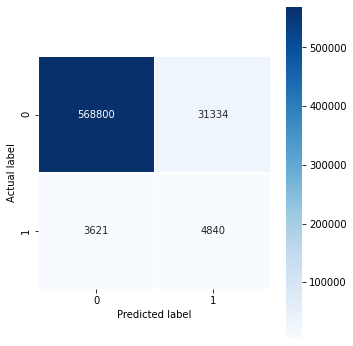

[0]	validation_0-aucpr:0.132816
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.14734
[2]	validation_0-aucpr:0.155092
[3]	validation_0-aucpr:0.152738
[4]	validation_0-aucpr:0.15668
[5]	validation_0-aucpr:0.159624
[6]	validation_0-aucpr:0.157537
[7]	validation_0-aucpr:0.153774
[8]	validation_0-aucpr:0.14611
[9]	validation_0-aucpr:0.14249
[10]	validation_0-aucpr:0.140766
[11]	validation_0-aucpr:0.139627
[12]	validation_0-aucpr:0.139744
[13]	validation_0-aucpr:0.140784
[14]	validation_0-aucpr:0.141305
[15]	validation_0-aucpr:0.143463
Stopping. Best iteration:
[5]	validation_0-aucpr:0.159624

Prediction Report of trial 7
               precision    recall  f1-score   support

           0       0.99      0.95      0.97    600134
           1       0.12      0.46      0.19      8461

    accuracy                           0.94    608595
   macro avg       0.55      0.71      0.58    608595
weighted avg       0.98      0.94      0.96    608595



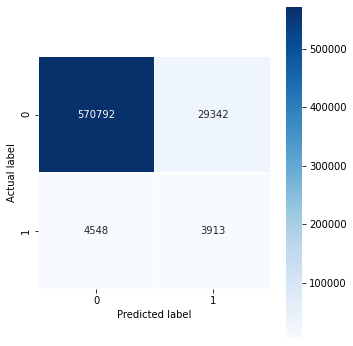

[0]	validation_0-aucpr:0.261924
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.287487
[2]	validation_0-aucpr:0.287356
[3]	validation_0-aucpr:0.318167
[4]	validation_0-aucpr:0.329372
[5]	validation_0-aucpr:0.331471
[6]	validation_0-aucpr:0.337933
[7]	validation_0-aucpr:0.337771
[8]	validation_0-aucpr:0.336442
[9]	validation_0-aucpr:0.352436
[10]	validation_0-aucpr:0.365873
[11]	validation_0-aucpr:0.376378
[12]	validation_0-aucpr:0.381108
[13]	validation_0-aucpr:0.376527
[14]	validation_0-aucpr:0.37887
[15]	validation_0-aucpr:0.382693
[16]	validation_0-aucpr:0.386069
[17]	validation_0-aucpr:0.39061
[18]	validation_0-aucpr:0.392002
[19]	validation_0-aucpr:0.389784
[20]	validation_0-aucpr:0.391645
[21]	validation_0-aucpr:0.393686
[22]	validation_0-aucpr:0.39635
[23]	validation_0-aucpr:0.397769
[24]	validation_0-aucpr:0.395561
[25]	validation_0-aucpr:0.395792
[26]	validation_0-aucpr:0.395306
[27]	validation_0-aucpr:0.395555
[28]	validation_0-aucpr

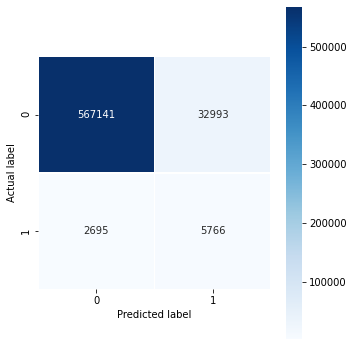

[0]	validation_0-aucpr:0.144834
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.170164
[2]	validation_0-aucpr:0.173634
[3]	validation_0-aucpr:0.182544
[4]	validation_0-aucpr:0.182986
[5]	validation_0-aucpr:0.177987
[6]	validation_0-aucpr:0.17192
[7]	validation_0-aucpr:0.168918
[8]	validation_0-aucpr:0.170763
[9]	validation_0-aucpr:0.170645
[10]	validation_0-aucpr:0.167766
[11]	validation_0-aucpr:0.167563
[12]	validation_0-aucpr:0.168999
[13]	validation_0-aucpr:0.168723
[14]	validation_0-aucpr:0.166031
Stopping. Best iteration:
[4]	validation_0-aucpr:0.182986

Prediction Report of trial 9
               precision    recall  f1-score   support

           0       0.99      0.96      0.98    600134
           1       0.15      0.47      0.23      8461

    accuracy                           0.96    608595
   macro avg       0.57      0.71      0.60    608595
weighted avg       0.98      0.96      0.97    608595



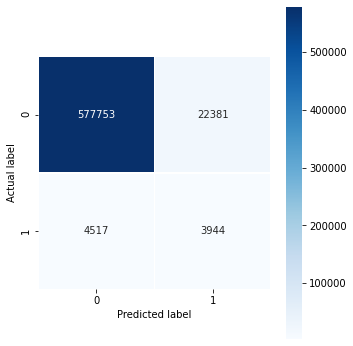

[0]	validation_0-aucpr:0.163836
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.172684
[2]	validation_0-aucpr:0.179568
[3]	validation_0-aucpr:0.18356
[4]	validation_0-aucpr:0.198369
[5]	validation_0-aucpr:0.19544
[6]	validation_0-aucpr:0.194433
[7]	validation_0-aucpr:0.192099
[8]	validation_0-aucpr:0.193804
[9]	validation_0-aucpr:0.196233
[10]	validation_0-aucpr:0.193684
[11]	validation_0-aucpr:0.189284
[12]	validation_0-aucpr:0.186032
[13]	validation_0-aucpr:0.18837
[14]	validation_0-aucpr:0.1932
Stopping. Best iteration:
[4]	validation_0-aucpr:0.198369

Prediction Report of trial 10
               precision    recall  f1-score   support

           0       0.99      0.95      0.97    600134
           1       0.14      0.57      0.23      8461

    accuracy                           0.95    608595
   macro avg       0.57      0.76      0.60    608595
weighted avg       0.98      0.95      0.96    608595



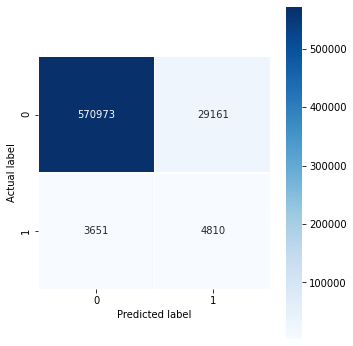

In [322]:
recall_0_list_xgb_step2 = []
recall_1_list_xgb_step2 = []
recall_avg_list_xgb_step2 = []

for trial in range(1, 11):
    random.seed(trial)
    
    random.shuffle(shuffled_flow_id_loss)
    random.shuffle(shuffled_flow_id_no_loss)
    
    df_loss_new = pd.concat([df_loss[df_loss['flow_id']==x] for x in shuffled_flow_id_loss])
    df_no_loss_new = pd.concat([df_no_loss[df_no_loss['flow_id']==x] for x in shuffled_flow_id_no_loss])
            
    df_train = pd.concat([df_loss_new.iloc[0:int(df_loss_new.shape[0] * 0.7)], df_no_loss_new.iloc[0:int(df_no_loss_new.shape[0] * 0.7)]])
    df_train_shuffled = df_train.sample(frac=1).reset_index()
    df_train_shuffled.drop(['index'], axis=1, inplace=True)
    df_test = pd.concat([df_loss_new.iloc[int(df_loss_new.shape[0] * 0.7)+1: -1], df_no_loss_new.iloc[int(df_no_loss_new.shape[0] * 0.7)+1: -1]])
    df_test_shuffled = df_test.sample(frac=1).reset_index()
    df_test_shuffled.drop(['index'], axis=1, inplace=True)

    x_train = df_train_shuffled[full_features_list]
    x_test = df_test_shuffled[full_features_list]
    y_train = df_train_shuffled[['lossOrNot']]
    y_train = y_train.astype(int)
    y_test = df_test_shuffled[['lossOrNot']]
    y_test = y_test.astype(int)
    
    clf_xgb_check = xgb.XGBClassifier(
        n_estimators=500, 
        objective='binary:logistic', 
        scale_pos_weight=weight, 
        n_jobs=48
    )
    
    clf_xgb_check.fit(x_train, y_train, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(x_test, y_test)])
            
    y_pred = clf_xgb_check.predict(x_test)
    print(f"Prediction Report of trial {trial}\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
    report = classification_report(y_test, y_pred, output_dict=True)
    recall_0_list_xgb_step2.append(report['0']['recall'])
    recall_1_list_xgb_step2.append(report['1']['recall'])
    recall_avg_list_xgb_step2.append(report['macro avg']['recall'])

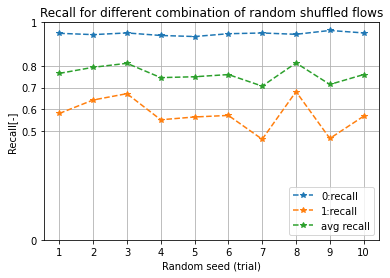

The best performance is at trial 3:
   recall of class 0: 0.9513258705555759
   recall of class 1: 0.6720245833825789
   macro average recall: 0.8116752269690775
                  OR
The best performance is at trial 8:
   recall of class 0: 0.945023944652361
   recall of class 1: 0.6814797305283063
   macro average recall: 0.8132518375903337

The average is 0.9477148436849104 (0:recall), 0.5763503132017492 (1:recall), 0.7620325784433298 (avg recall)


In [326]:
x_label = list(range(1,11))
plt.figure(figsize=(6,4))
plt.plot(x_label, recall_0_list_xgb_step2, '*--', label='0:recall')
plt.plot(x_label, recall_1_list_xgb_step2, '*--', label='1:recall')
plt.plot(x_label, recall_avg_list_xgb_step2, '*--', label='avg recall')
plt.xticks(x_label, x_label)
plt.legend(loc=4)
plt.grid()
plt.ylim([0,1])
plt.yticks([0, 0.5, 0.6, 0.7, 0.8, 1], [0, 0.5, 0.6, 0.7, 0.8, 1])
plt.title('Recall for different combination of random shuffled flows')
plt.xlabel('Random seed (trial)')
plt.ylabel('Recall[-]')
plt.show()

print(f'The best performance is at trial 3:\n   recall of class 0: {recall_0_list_xgb_step2[2]}\n   recall of class 1: {recall_1_list_xgb_step2[2]}\n   macro average recall: {recall_avg_list_xgb_step2[2]}')
print('                  OR')
print(f'The best performance is at trial 8:\n   recall of class 0: {recall_0_list_xgb_step2[7]}\n   recall of class 1: {recall_1_list_xgb_step2[7]}\n   macro average recall: {recall_avg_list_xgb_step2[7]}')
print()
print(f'The average is {np.array(recall_0_list_xgb_step2).mean()} (0:recall), {np.array(recall_1_list_xgb_step2).mean()} (1:recall), {np.array(recall_avg_list_xgb_step2).mean()} (avg recall)')

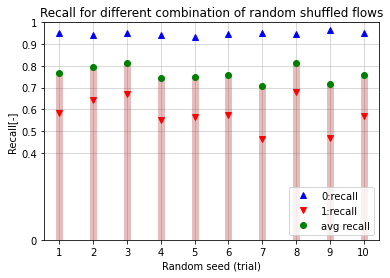

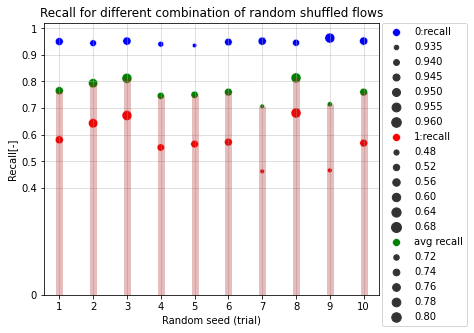

In [332]:
x_label = list(range(1,11))
plt.figure(figsize=(6,4))
plt.plot(x_label, recall_0_list_xgb_step2, '^', label='0:recall', color='b')
plt.plot(x_label, recall_1_list_xgb_step2, 'v', label='1:recall', color='r')
plt.plot(x_label, recall_avg_list_xgb_step2, 'o', label='avg recall', color='g')
plt.vlines(x=x_label, ymin=0, ymax=recall_avg_list_xgb_step2, linestyles='solid', color='firebrick', alpha=0.3, linewidth=7)
plt.xticks(x_label, x_label)
plt.legend(loc=4)
plt.grid(alpha=0.6)
plt.ylim([0,1])
plt.yticks([0, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], [0, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.title('Recall for different combination of random shuffled flows')
plt.xlabel('Random seed (trial)')
plt.ylabel('Recall[-]')
plt.show()

plt.figure(figsize=(6,5))
sns.scatterplot(x=x_label, y=recall_0_list_xgb_step2, label='0:recall', size=recall_0_list_xgb_step2, sizes=(20, 100), color='b')
sns.scatterplot(x=x_label, y=recall_1_list_xgb_step2, label='1:recall', size=recall_1_list_xgb_step2, sizes=(20, 100), color='r')
sns.scatterplot(x=x_label, y=recall_avg_list_xgb_step2, label='avg recall', size=recall_avg_list_xgb_step2, sizes=(20, 100), color='g')
plt.vlines(x=x_label, ymin=0, ymax=recall_avg_list_xgb_step2, linestyles='solid', color='firebrick', alpha=0.3, linewidth=7)
plt.xticks(x_label, x_label)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.grid(alpha=0.5)
plt.ylim([0,1.02])
plt.yticks([0, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], [0, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.title('Recall for different combination of random shuffled flows')
plt.xlabel('Random seed (trial)')
plt.ylabel('Recall[-]')
plt.show()

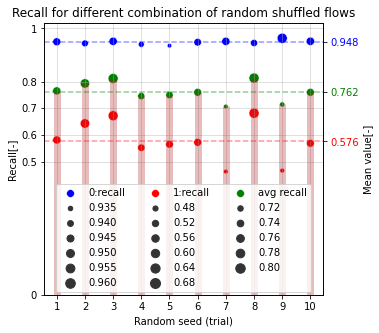

In [4]:
plt.figure(figsize=(5,5))
sns.scatterplot(x=x_label, y=recall_0_list_xgb_step2, label='0:recall', size=recall_0_list_xgb_step2, sizes=(20, 100), color='b')
sns.scatterplot(x=x_label, y=recall_1_list_xgb_step2, label='1:recall', size=recall_1_list_xgb_step2, sizes=(20, 100), color='r')
sns.scatterplot(x=x_label, y=recall_avg_list_xgb_step2, label='avg recall', size=recall_avg_list_xgb_step2, sizes=(20, 100), color='g')
plt.vlines(x=x_label, ymin=0, ymax=recall_avg_list_xgb_step2, linestyles='solid', color='firebrick', alpha=0.3, linewidth=7)
plt.xticks(x_label, x_label)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 0.01), borderaxespad=0, ncol=3)
plt.grid(alpha=0.5)
plt.ylim([0,1.02])
plt.yticks([0, 0.5, 0.6, 0.7, 0.8, 1], [0, 0.5, 0.6, 0.7, 0.8, 1])
plt.title('Recall for different combination of random shuffled flows')
plt.xlabel('Random seed (trial)')
plt.ylabel('Recall[-]')
plt.axhline(y=0.948, color='b', linestyle='--', alpha=0.4, label='class 0')
plt.axhline(y=0.576, color='r', linestyle='--', alpha=0.4, label='class 1')
plt.axhline(y=0.762, color='g', linestyle='--', alpha=0.4, label='avg recall')
ax2 = plt.gca().twinx()
ax2.set_yticks([0.948, 0.576, 0.762])
ax2.set_ylim([0,1.02])
ax2.set_ylabel('Mean value[-]')
ax2.get_yticklabels()[0].set_color("b")
ax2.get_yticklabels()[1].set_color("r")
ax2.get_yticklabels()[2].set_color("g")
plt.show()

In [328]:
print(recall_0_list_xgb_step2)
print(recall_1_list_xgb_step2)
print(recall_avg_list_xgb_step2)

[0.9496129197812488, 0.9436159257765766, 0.9513258705555759, 0.9397101314039864, 0.9348478839725795, 0.9477883272735755, 0.9511075859724661, 0.945023944652361, 0.9627066621787801, 0.9514091852819537]
[0.5810187921049521, 0.6429500059094669, 0.6720245833825789, 0.5520624039711618, 0.5648268526178939, 0.5720364023165111, 0.46247488476539417, 0.6814797305283063, 0.4661387542843636, 0.5684907221368632]
[0.7653158559431005, 0.7932829658430218, 0.8116752269690775, 0.7458862676875742, 0.7498373682952366, 0.7599123647950433, 0.7067912353689302, 0.8132518375903337, 0.7144227082315718, 0.7599499537094085]


#### 3. considering all related aspects (predict t+1, best features from RFE, shuffling flows, packet loss as features) for both models

In [18]:
full_features_list_removing_500ms = []
for feature in full_features_list:
    if '_500ms' not in feature:
        full_features_list_removing_500ms.append(feature)

len(full_features_list_removing_500ms)

108

Prediction Report of trial 1 (original features)
               precision    recall  f1-score   support

           0       0.99      0.75      0.86    600134
           1       0.03      0.55      0.06      8461

    accuracy                           0.75    608595
   macro avg       0.51      0.65      0.46    608595
weighted avg       0.98      0.75      0.84    608595



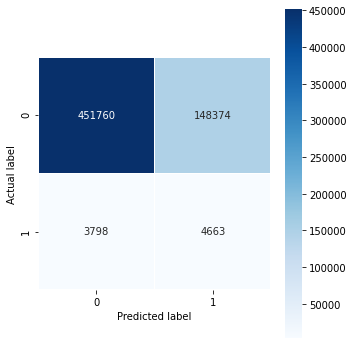

Prediction Report of trial 2 (original features)
               precision    recall  f1-score   support

           0       0.99      0.68      0.81    600134
           1       0.03      0.69      0.06      8461

    accuracy                           0.68    608595
   macro avg       0.51      0.69      0.43    608595
weighted avg       0.98      0.68      0.80    608595



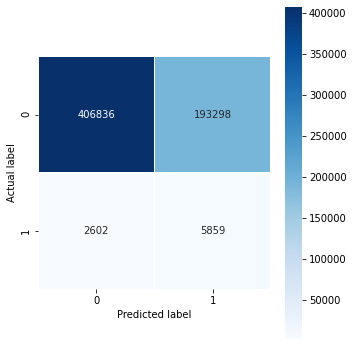

Prediction Report of trial 3 (original features)
               precision    recall  f1-score   support

           0       0.99      0.70      0.82    600134
           1       0.03      0.66      0.06      8461

    accuracy                           0.70    608595
   macro avg       0.51      0.68      0.44    608595
weighted avg       0.98      0.70      0.81    608595



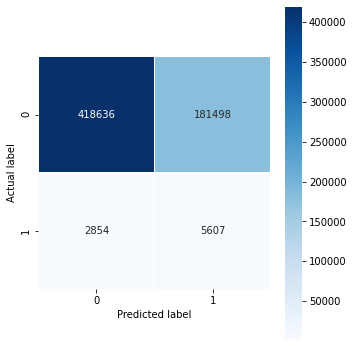

Prediction Report of trial 4 (original features)
               precision    recall  f1-score   support

           0       0.99      0.73      0.84    600134
           1       0.03      0.58      0.06      8461

    accuracy                           0.73    608595
   macro avg       0.51      0.66      0.45    608595
weighted avg       0.98      0.73      0.83    608595



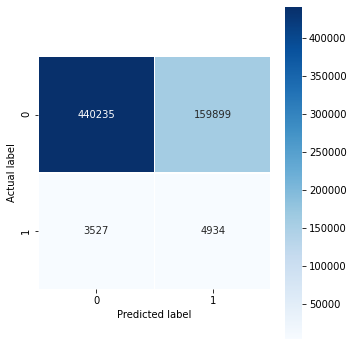

Prediction Report of trial 5 (original features)
               precision    recall  f1-score   support

           0       0.99      0.67      0.80    600134
           1       0.03      0.65      0.05      8461

    accuracy                           0.67    608595
   macro avg       0.51      0.66      0.43    608595
weighted avg       0.98      0.67      0.79    608595



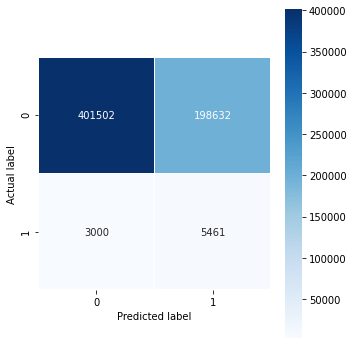

Prediction Report of trial 6 (original features)
               precision    recall  f1-score   support

           0       0.99      0.70      0.82    600134
           1       0.03      0.56      0.05      8461

    accuracy                           0.70    608595
   macro avg       0.51      0.63      0.43    608595
weighted avg       0.98      0.70      0.81    608595



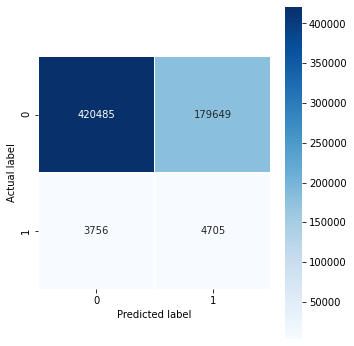

Prediction Report of trial 7 (original features)
               precision    recall  f1-score   support

           0       0.99      0.73      0.84    600134
           1       0.03      0.52      0.05      8461

    accuracy                           0.73    608595
   macro avg       0.51      0.63      0.45    608595
weighted avg       0.98      0.73      0.83    608595



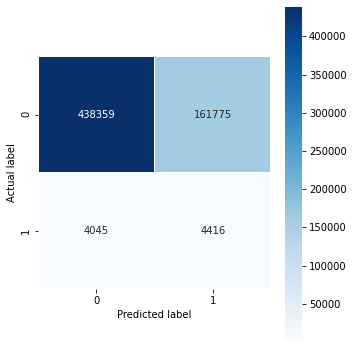

Prediction Report of trial 8 (original features)
               precision    recall  f1-score   support

           0       0.99      0.71      0.83    600134
           1       0.03      0.67      0.06      8461

    accuracy                           0.71    608595
   macro avg       0.51      0.69      0.45    608595
weighted avg       0.98      0.71      0.82    608595



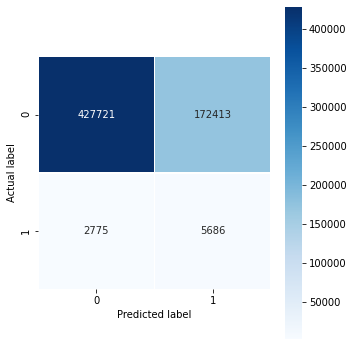

Prediction Report of trial 9 (original features)
               precision    recall  f1-score   support

           0       0.99      0.69      0.82    600134
           1       0.02      0.53      0.05      8461

    accuracy                           0.69    608595
   macro avg       0.51      0.61      0.43    608595
weighted avg       0.98      0.69      0.81    608595



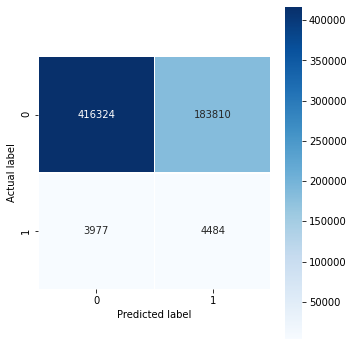

Prediction Report of trial 10 (original features)
               precision    recall  f1-score   support

           0       0.99      0.71      0.83    600134
           1       0.03      0.68      0.06      8461

    accuracy                           0.71    608595
   macro avg       0.51      0.69      0.45    608595
weighted avg       0.98      0.71      0.82    608595



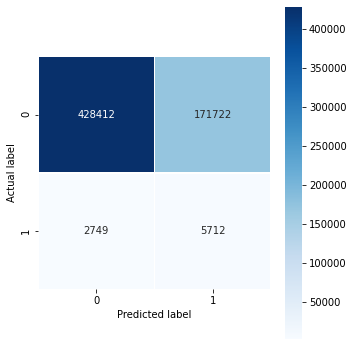

Prediction Report of trial 11 (original features)
               precision    recall  f1-score   support

           0       0.99      0.79      0.88    600134
           1       0.03      0.50      0.06      8461

    accuracy                           0.79    608595
   macro avg       0.51      0.65      0.47    608595
weighted avg       0.98      0.79      0.87    608595



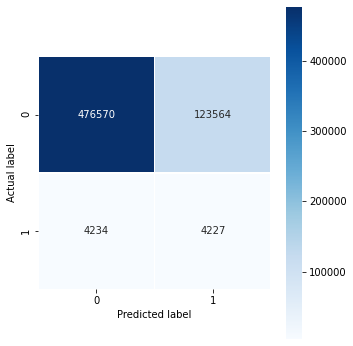

Prediction Report of trial 12 (original features)
               precision    recall  f1-score   support

           0       0.99      0.77      0.87    600134
           1       0.03      0.54      0.06      8461

    accuracy                           0.77    608595
   macro avg       0.51      0.65      0.46    608595
weighted avg       0.98      0.77      0.86    608595



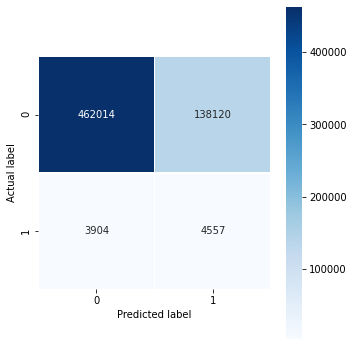

Prediction Report of trial 13 (original features)
               precision    recall  f1-score   support

           0       0.99      0.77      0.87    600134
           1       0.04      0.60      0.07      8461

    accuracy                           0.77    608595
   macro avg       0.51      0.69      0.47    608595
weighted avg       0.98      0.77      0.86    608595



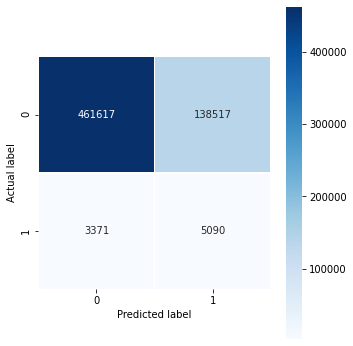

Prediction Report of trial 14 (original features)
               precision    recall  f1-score   support

           0       0.99      0.70      0.82    600134
           1       0.03      0.63      0.06      8461

    accuracy                           0.70    608595
   macro avg       0.51      0.67      0.44    608595
weighted avg       0.98      0.70      0.81    608595



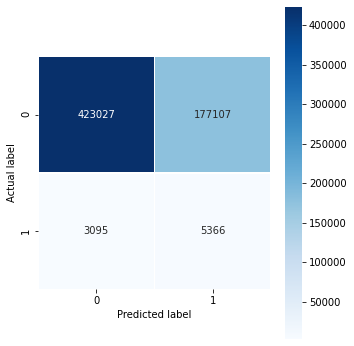

Prediction Report of trial 15 (original features)
               precision    recall  f1-score   support

           0       0.99      0.74      0.84    600134
           1       0.03      0.50      0.05      8461

    accuracy                           0.73    608595
   macro avg       0.51      0.62      0.45    608595
weighted avg       0.98      0.73      0.83    608595



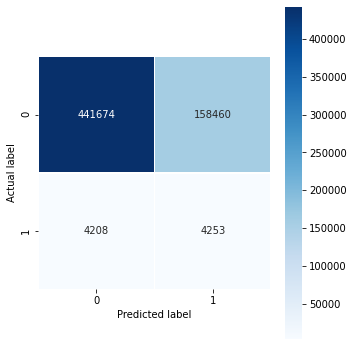

Prediction Report of trial 16 (original features)
               precision    recall  f1-score   support

           0       0.99      0.74      0.85    600134
           1       0.03      0.49      0.05      8461

    accuracy                           0.74    608595
   macro avg       0.51      0.62      0.45    608595
weighted avg       0.98      0.74      0.84    608595



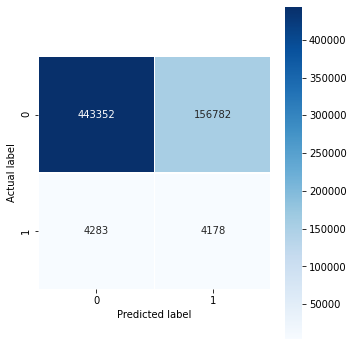

Prediction Report of trial 17 (original features)
               precision    recall  f1-score   support

           0       0.99      0.71      0.83    600134
           1       0.03      0.64      0.06      8461

    accuracy                           0.71    608595
   macro avg       0.51      0.68      0.44    608595
weighted avg       0.98      0.71      0.82    608595



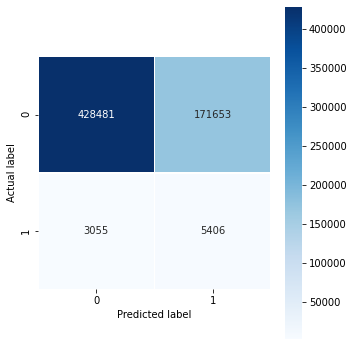

Prediction Report of trial 18 (original features)
               precision    recall  f1-score   support

           0       0.99      0.72      0.84    600134
           1       0.03      0.63      0.06      8461

    accuracy                           0.72    608595
   macro avg       0.51      0.68      0.45    608595
weighted avg       0.98      0.72      0.83    608595



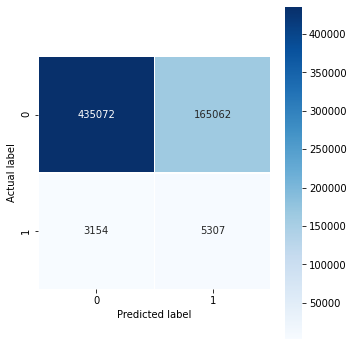

Prediction Report of trial 19 (original features)
               precision    recall  f1-score   support

           0       0.99      0.70      0.82    600134
           1       0.03      0.60      0.05      8461

    accuracy                           0.70    608595
   macro avg       0.51      0.65      0.44    608595
weighted avg       0.98      0.70      0.81    608595



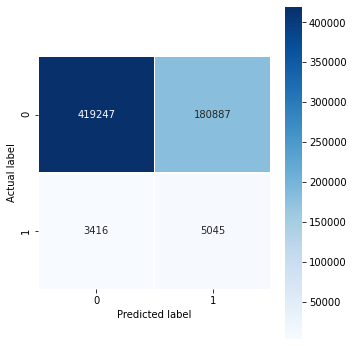

Prediction Report of trial 20 (original features)
               precision    recall  f1-score   support

           0       0.99      0.80      0.89    600134
           1       0.04      0.51      0.07      8461

    accuracy                           0.80    608595
   macro avg       0.51      0.66      0.48    608595
weighted avg       0.98      0.80      0.88    608595



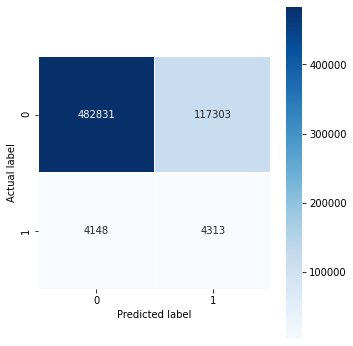

Prediction Report of trial 21 (original features)
               precision    recall  f1-score   support

           0       0.99      0.74      0.85    600134
           1       0.03      0.60      0.06      8461

    accuracy                           0.74    608595
   macro avg       0.51      0.67      0.45    608595
weighted avg       0.98      0.74      0.83    608595



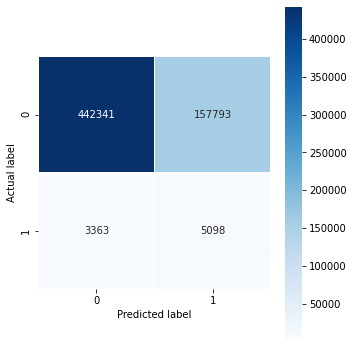

Prediction Report of trial 22 (original features)
               precision    recall  f1-score   support

           0       0.99      0.73      0.84    600134
           1       0.03      0.57      0.05      8461

    accuracy                           0.73    608595
   macro avg       0.51      0.65      0.45    608595
weighted avg       0.98      0.73      0.83    608595



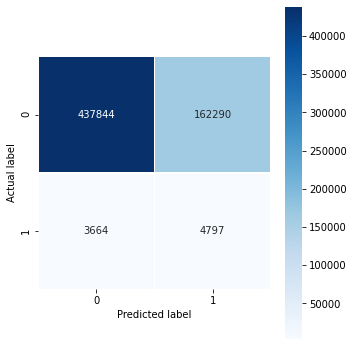

Prediction Report of trial 23 (original features)
               precision    recall  f1-score   support

           0       0.99      0.69      0.81    600134
           1       0.03      0.61      0.05      8461

    accuracy                           0.69    608595
   macro avg       0.51      0.65      0.43    608595
weighted avg       0.98      0.69      0.80    608595



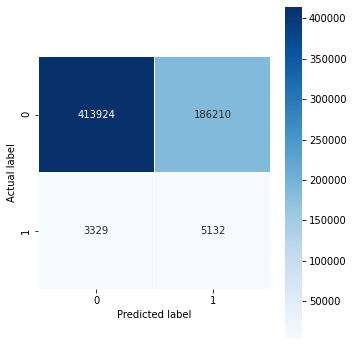

Prediction Report of trial 24 (original features)
               precision    recall  f1-score   support

           0       0.99      0.81      0.89    600134
           1       0.04      0.50      0.07      8461

    accuracy                           0.81    608595
   macro avg       0.51      0.66      0.48    608595
weighted avg       0.98      0.81      0.88    608595



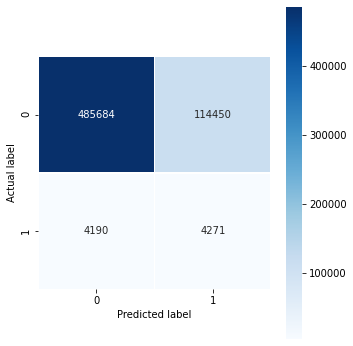

Prediction Report of trial 25 (original features)
               precision    recall  f1-score   support

           0       0.99      0.77      0.87    600134
           1       0.04      0.65      0.07      8461

    accuracy                           0.77    608595
   macro avg       0.52      0.71      0.47    608595
weighted avg       0.98      0.77      0.86    608595



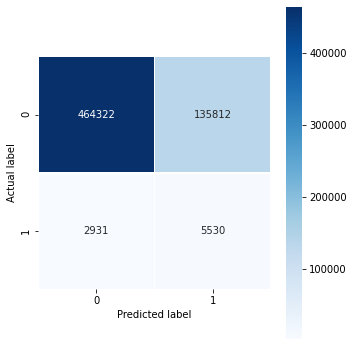

Prediction Report of trial 26 (original features)
               precision    recall  f1-score   support

           0       0.99      0.75      0.86    600134
           1       0.03      0.47      0.05      8461

    accuracy                           0.75    608595
   macro avg       0.51      0.61      0.45    608595
weighted avg       0.98      0.75      0.84    608595



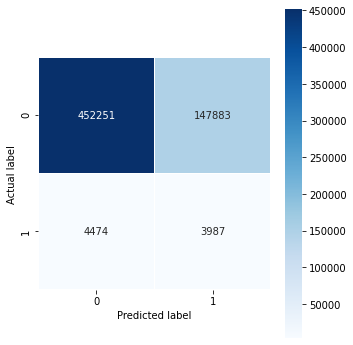

Prediction Report of trial 27 (original features)
               precision    recall  f1-score   support

           0       0.99      0.75      0.86    600134
           1       0.03      0.48      0.05      8461

    accuracy                           0.75    608595
   macro avg       0.51      0.62      0.45    608595
weighted avg       0.98      0.75      0.84    608595



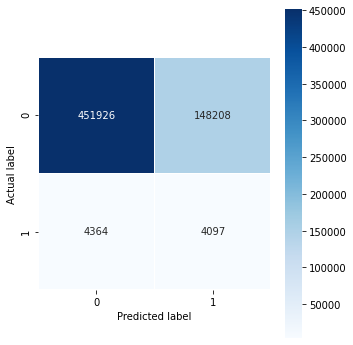

Prediction Report of trial 28 (original features)
               precision    recall  f1-score   support

           0       0.99      0.72      0.84    600134
           1       0.03      0.51      0.05      8461

    accuracy                           0.72    608595
   macro avg       0.51      0.62      0.44    608595
weighted avg       0.98      0.72      0.83    608595



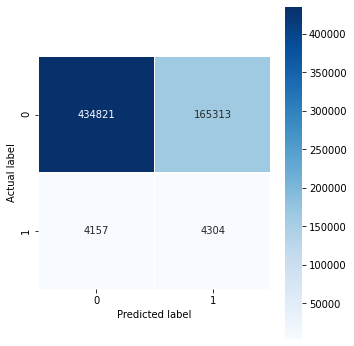

Prediction Report of trial 29 (original features)
               precision    recall  f1-score   support

           0       0.99      0.73      0.84    600134
           1       0.03      0.55      0.05      8461

    accuracy                           0.73    608595
   macro avg       0.51      0.64      0.45    608595
weighted avg       0.98      0.73      0.83    608595



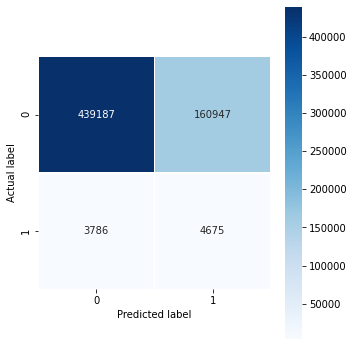

Prediction Report of trial 30 (original features)
               precision    recall  f1-score   support

           0       0.99      0.77      0.87    600134
           1       0.03      0.57      0.06      8461

    accuracy                           0.77    608595
   macro avg       0.51      0.67      0.47    608595
weighted avg       0.98      0.77      0.86    608595



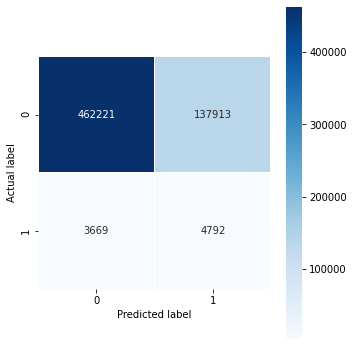

Prediction Report of trial 31 (original features)
               precision    recall  f1-score   support

           0       0.99      0.64      0.78    600134
           1       0.02      0.63      0.05      8461

    accuracy                           0.64    608595
   macro avg       0.51      0.64      0.41    608595
weighted avg       0.98      0.64      0.77    608595



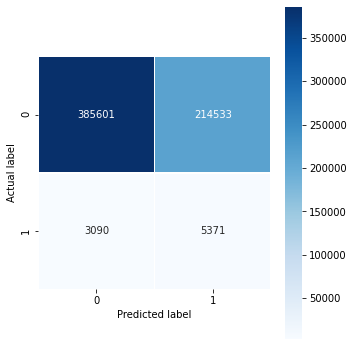

Prediction Report of trial 32 (original features)
               precision    recall  f1-score   support

           0       0.99      0.69      0.82    600134
           1       0.03      0.63      0.05      8461

    accuracy                           0.69    608595
   macro avg       0.51      0.66      0.44    608595
weighted avg       0.98      0.69      0.81    608595



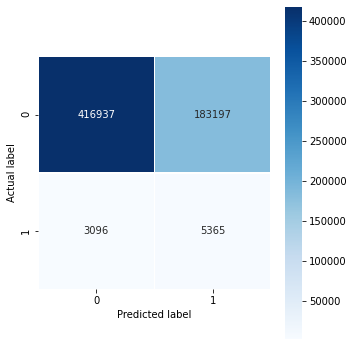

Prediction Report of trial 33 (original features)
               precision    recall  f1-score   support

           0       0.99      0.71      0.83    600134
           1       0.03      0.63      0.06      8461

    accuracy                           0.71    608595
   macro avg       0.51      0.67      0.44    608595
weighted avg       0.98      0.71      0.82    608595



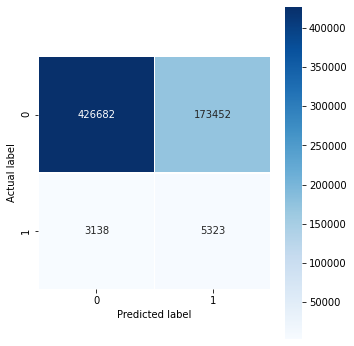

Prediction Report of trial 34 (original features)
               precision    recall  f1-score   support

           0       1.00      0.65      0.79    600134
           1       0.03      0.77      0.06      8461

    accuracy                           0.65    608595
   macro avg       0.51      0.71      0.42    608595
weighted avg       0.98      0.65      0.78    608595



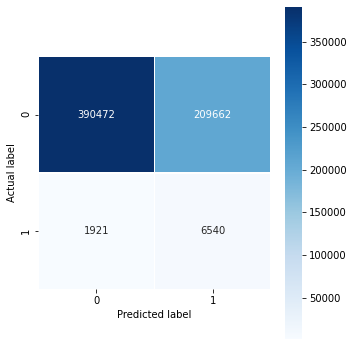

Prediction Report of trial 35 (original features)
               precision    recall  f1-score   support

           0       0.99      0.67      0.80    600134
           1       0.03      0.72      0.06      8461

    accuracy                           0.67    608595
   macro avg       0.51      0.69      0.43    608595
weighted avg       0.98      0.67      0.79    608595



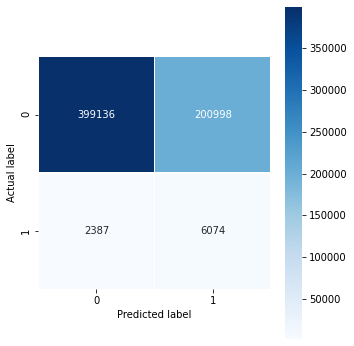

Prediction Report of trial 36 (original features)
               precision    recall  f1-score   support

           0       0.99      0.62      0.77    600134
           1       0.03      0.71      0.05      8461

    accuracy                           0.62    608595
   macro avg       0.51      0.67      0.41    608595
weighted avg       0.98      0.62      0.76    608595



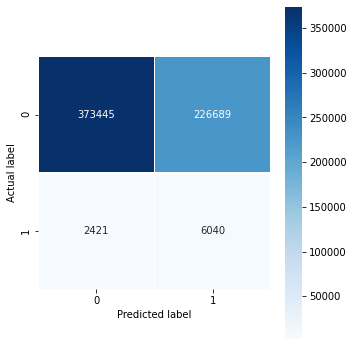

Prediction Report of trial 37 (original features)
               precision    recall  f1-score   support

           0       0.99      0.69      0.81    600134
           1       0.03      0.61      0.05      8461

    accuracy                           0.68    608595
   macro avg       0.51      0.65      0.43    608595
weighted avg       0.98      0.68      0.80    608595



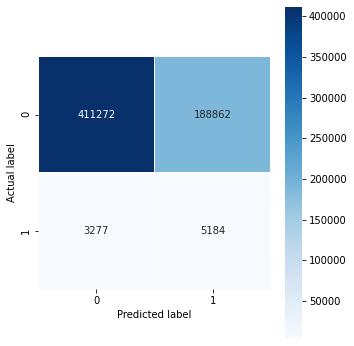

Prediction Report of trial 38 (original features)
               precision    recall  f1-score   support

           0       0.99      0.69      0.81    600134
           1       0.03      0.57      0.05      8461

    accuracy                           0.68    608595
   macro avg       0.51      0.63      0.43    608595
weighted avg       0.98      0.68      0.80    608595



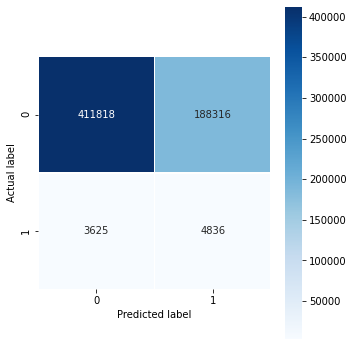

Prediction Report of trial 39 (original features)
               precision    recall  f1-score   support

           0       0.99      0.72      0.83    600134
           1       0.03      0.59      0.05      8461

    accuracy                           0.72    608595
   macro avg       0.51      0.65      0.44    608595
weighted avg       0.98      0.72      0.82    608595



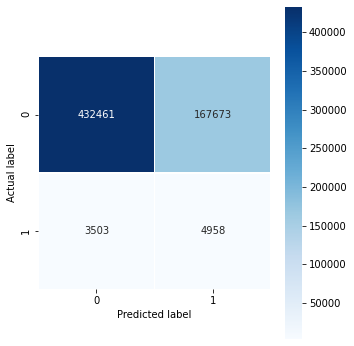

Prediction Report of trial 40 (original features)
               precision    recall  f1-score   support

           0       0.99      0.70      0.82    600134
           1       0.03      0.67      0.06      8461

    accuracy                           0.70    608595
   macro avg       0.51      0.69      0.44    608595
weighted avg       0.98      0.70      0.81    608595



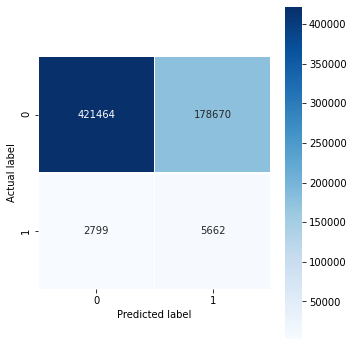

Prediction Report of trial 41 (original features)
               precision    recall  f1-score   support

           0       0.99      0.70      0.82    600134
           1       0.03      0.64      0.06      8461

    accuracy                           0.70    608595
   macro avg       0.51      0.67      0.44    608595
weighted avg       0.98      0.70      0.81    608595



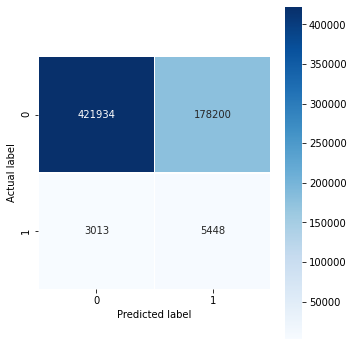

Prediction Report of trial 42 (original features)
               precision    recall  f1-score   support

           0       0.99      0.71      0.83    600134
           1       0.03      0.71      0.06      8461

    accuracy                           0.71    608595
   macro avg       0.51      0.71      0.45    608595
weighted avg       0.98      0.71      0.82    608595



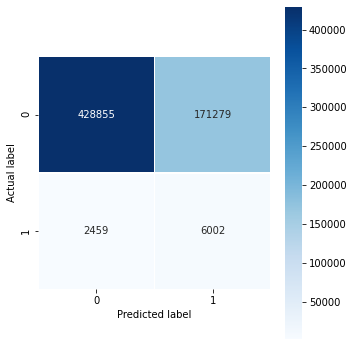

Prediction Report of trial 43 (original features)
               precision    recall  f1-score   support

           0       0.99      0.76      0.86    600134
           1       0.03      0.57      0.06      8461

    accuracy                           0.75    608595
   macro avg       0.51      0.66      0.46    608595
weighted avg       0.98      0.75      0.85    608595



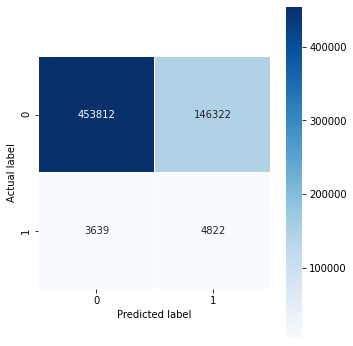

Prediction Report of trial 44 (original features)
               precision    recall  f1-score   support

           0       0.99      0.73      0.84    600134
           1       0.03      0.55      0.05      8461

    accuracy                           0.73    608595
   macro avg       0.51      0.64      0.45    608595
weighted avg       0.98      0.73      0.83    608595



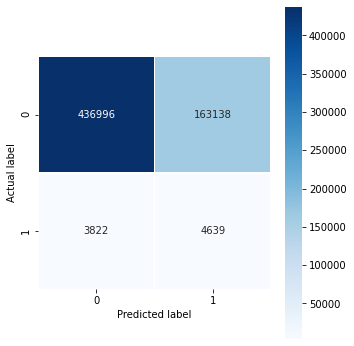

Prediction Report of trial 45 (original features)
               precision    recall  f1-score   support

           0       0.99      0.72      0.83    600134
           1       0.03      0.58      0.05      8461

    accuracy                           0.71    608595
   macro avg       0.51      0.65      0.44    608595
weighted avg       0.98      0.71      0.82    608595



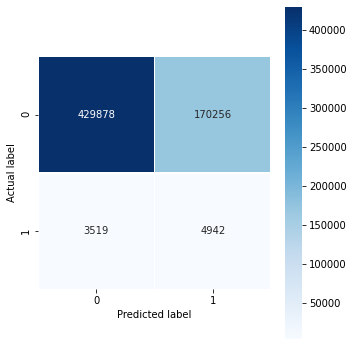

Prediction Report of trial 46 (original features)
               precision    recall  f1-score   support

           0       0.99      0.73      0.84    600134
           1       0.03      0.65      0.06      8461

    accuracy                           0.73    608595
   macro avg       0.51      0.69      0.45    608595
weighted avg       0.98      0.73      0.83    608595



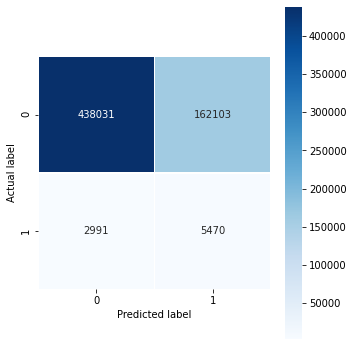

Prediction Report of trial 47 (original features)
               precision    recall  f1-score   support

           0       0.99      0.72      0.83    600134
           1       0.02      0.51      0.05      8461

    accuracy                           0.72    608595
   macro avg       0.51      0.61      0.44    608595
weighted avg       0.98      0.72      0.82    608595



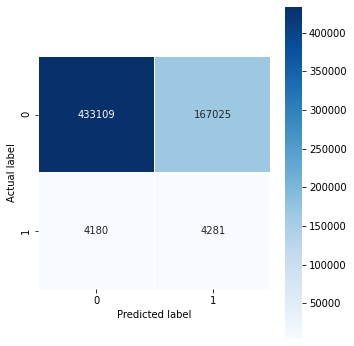

Prediction Report of trial 48 (original features)
               precision    recall  f1-score   support

           0       0.99      0.71      0.83    600134
           1       0.03      0.64      0.06      8461

    accuracy                           0.71    608595
   macro avg       0.51      0.67      0.44    608595
weighted avg       0.98      0.71      0.82    608595



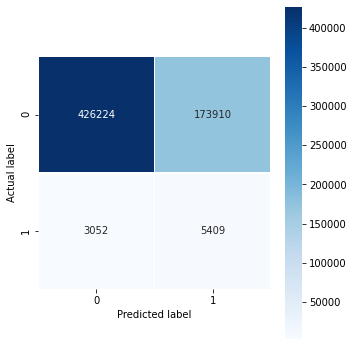

Prediction Report of trial 49 (original features)
               precision    recall  f1-score   support

           0       0.99      0.71      0.83    600134
           1       0.02      0.52      0.05      8461

    accuracy                           0.71    608595
   macro avg       0.51      0.62      0.44    608595
weighted avg       0.98      0.71      0.82    608595



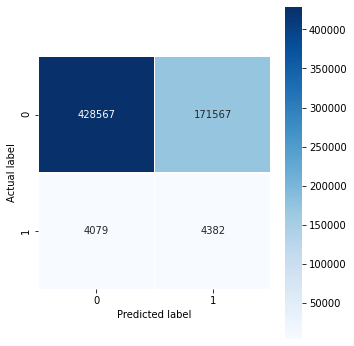

Prediction Report of trial 50 (original features)
               precision    recall  f1-score   support

           0       1.00      0.69      0.81    600134
           1       0.03      0.78      0.07      8461

    accuracy                           0.69    608595
   macro avg       0.51      0.74      0.44    608595
weighted avg       0.98      0.69      0.80    608595



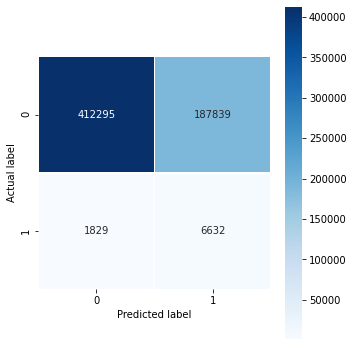

In [37]:
# balanced random forest

recall_0_list = []
recall_1_list = []
recall_avg_list = []

shuffled_flow_id_loss = flow_id_loss.copy()
shuffled_flow_id_no_loss = flow_id_no_loss.copy()

for trial in range(1, 51):
    random.seed(trial)
    
    random.shuffle(shuffled_flow_id_loss)
    random.shuffle(shuffled_flow_id_no_loss)
    
    df_loss_new = pd.concat([df_loss[df_loss['flow_id']==x] for x in shuffled_flow_id_loss])
    df_no_loss_new = pd.concat([df_no_loss[df_no_loss['flow_id']==x] for x in shuffled_flow_id_no_loss])
            
    df_train = pd.concat([df_loss_new.iloc[0:int(df_loss_new.shape[0] * 0.7)], df_no_loss_new.iloc[0:int(df_no_loss_new.shape[0] * 0.7)]])
    df_train_shuffled = df_train.sample(frac=1).reset_index()
    df_train_shuffled.drop(['index'], axis=1, inplace=True)
    df_test = pd.concat([df_loss_new.iloc[int(df_loss_new.shape[0] * 0.7)+1: -1], df_no_loss_new.iloc[int(df_no_loss_new.shape[0] * 0.7)+1: -1]])
    df_test_shuffled = df_test.sample(frac=1).reset_index()
    df_test_shuffled.drop(['index'], axis=1, inplace=True)

    x_train = df_train_shuffled[full_features_list_removing_500ms]
    x_test = df_test_shuffled[full_features_list_removing_500ms]
    y_train = df_train_shuffled[['lossOrNot']]
    y_train = y_train.astype(int)
    y_test = df_test_shuffled[['lossOrNot']]
    y_test = y_test.astype(int)
    
    my_brf_model_check = BalancedRandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=0) 
    my_brf_model_check.fit(x_train, y_train)
            
    y_pred = my_brf_model_check.predict(x_test)
    print(f"Prediction Report of trial {trial} (original features)\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
    report = classification_report(y_test, y_pred, output_dict=True)
    recall_0_list.append(report['0']['recall'])
    recall_1_list.append(report['1']['recall'])
    recall_avg_list.append(report['macro avg']['recall'])

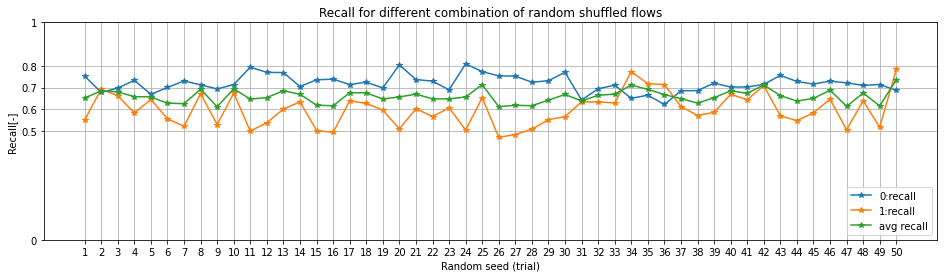

The best performance is at trial 25:
   recall of class 0: 0.7736972076236307
   recall of class 1: 0.6535870464484104
   macro average recall: 0.7136421270360205
                   OR
The best performance is at trial 34:
   recall of class 0: 0.6506413567636561
   recall of class 1: 0.7729582791632195
   macro average recall: 0.7117998179634377
                   OR
The best performance is at trial 50:
   recall of class 0: 0.6870049022385001
   recall of class 1: 0.783831698380806
   macro average recall: 0.735418300309653

The average is 0.7194281610440335 (0:recall), 0.5988228341803569 (1:recall), 0.6591254976121952 (avg recall)


In [324]:
x_label = list(range(1,51))
plt.figure(figsize=(16,4))
plt.plot(x_label, recall_0_list, '*-', label='0:recall')
plt.plot(x_label, recall_1_list, '*-', label='1:recall')
plt.plot(x_label, recall_avg_list, '*-', label='avg recall')
plt.xticks(x_label, x_label)
plt.legend(loc=4)
plt.grid()
plt.ylim([0,1])
plt.yticks([0, 0.5, 0.6, 0.7, 0.8, 1], [0, 0.5, 0.6, 0.7, 0.8, 1])
plt.title('Recall for different combination of random shuffled flows')
plt.xlabel('Random seed (trial)')
plt.ylabel('Recall[-]')
plt.show()

print(f'The best performance is at trial 25:\n   recall of class 0: {recall_0_list[24]}\n   recall of class 1: {recall_1_list[24]}\n   macro average recall: {recall_avg_list[24]}')
print('                   OR')
print(f'The best performance is at trial 34:\n   recall of class 0: {recall_0_list[33]}\n   recall of class 1: {recall_1_list[33]}\n   macro average recall: {recall_avg_list[33]}')
print('                   OR')
print(f'The best performance is at trial 50:\n   recall of class 0: {recall_0_list[49]}\n   recall of class 1: {recall_1_list[49]}\n   macro average recall: {recall_avg_list[49]}')
print()
print(f'The average is {np.array(recall_0_list).mean()} (0:recall), {np.array(recall_1_list).mean()} (1:recall), {np.array(recall_avg_list).mean()} (avg recall)')

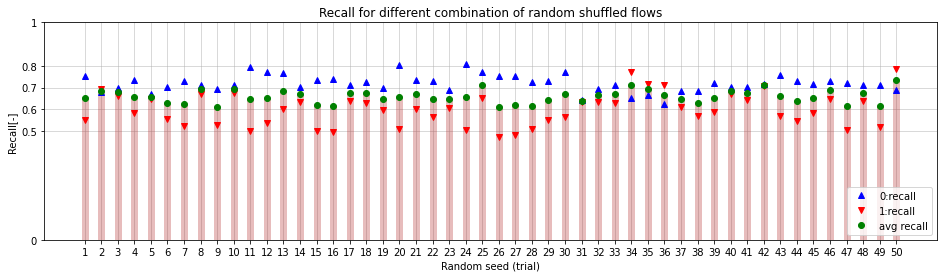

In [283]:
x_label = list(range(1,51))
plt.figure(figsize=(16,4))
plt.plot(x_label, recall_0_list, '^', label='0:recall', color='b')
plt.plot(x_label, recall_1_list, 'v', label='1:recall', color='r')
plt.plot(x_label, recall_avg_list, 'o', label='avg recall', color='g')
plt.vlines(x=x_label, ymin=0, ymax=recall_avg_list, linestyles='solid', color='firebrick', alpha=0.3, linewidth=7)
plt.xticks(x_label, x_label)
plt.legend(loc=4)
plt.grid(alpha=0.6)
plt.ylim([0,1])
plt.yticks([0, 0.5, 0.6, 0.7, 0.8, 1], [0, 0.5, 0.6, 0.7, 0.8, 1])
plt.title('Recall for different combination of random shuffled flows')
plt.xlabel('Random seed (trial)')
plt.ylabel('Recall[-]')
plt.show()

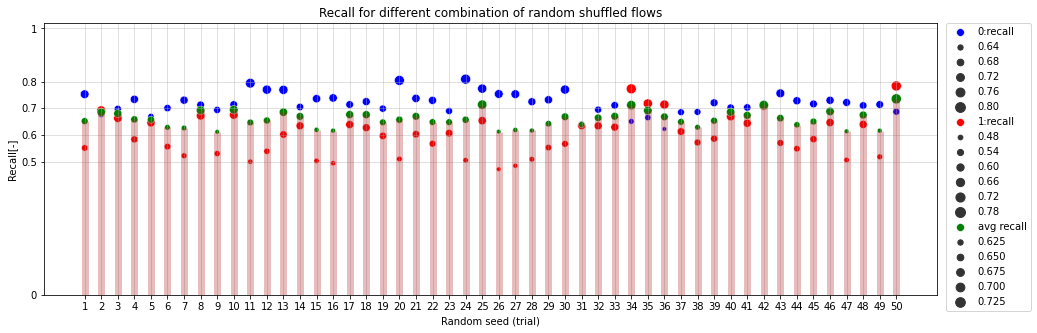

In [259]:
plt.figure(figsize=(16,5))
sns.scatterplot(x=x_label, y=recall_0_list, label='0:recall', size=recall_0_list, sizes=(20, 100), color='b')
sns.scatterplot(x=x_label, y=recall_1_list, label='1:recall', size=recall_1_list, sizes=(20, 100), color='r')
sns.scatterplot(x=x_label, y=recall_avg_list, label='avg recall', size=recall_avg_list, sizes=(20, 100), color='g')
plt.vlines(x=x_label, ymin=0, ymax=recall_avg_list, linestyles='solid', color='firebrick', alpha=0.3, linewidth=7)
plt.xticks(x_label, x_label)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.grid(alpha=0.5)
plt.ylim([0,1.02])
plt.yticks([0, 0.5, 0.6, 0.7, 0.8, 1], [0, 0.5, 0.6, 0.7, 0.8, 1])
plt.title('Recall for different combination of random shuffled flows')
plt.xlabel('Random seed (trial)')
plt.ylabel('Recall[-]')
plt.show()

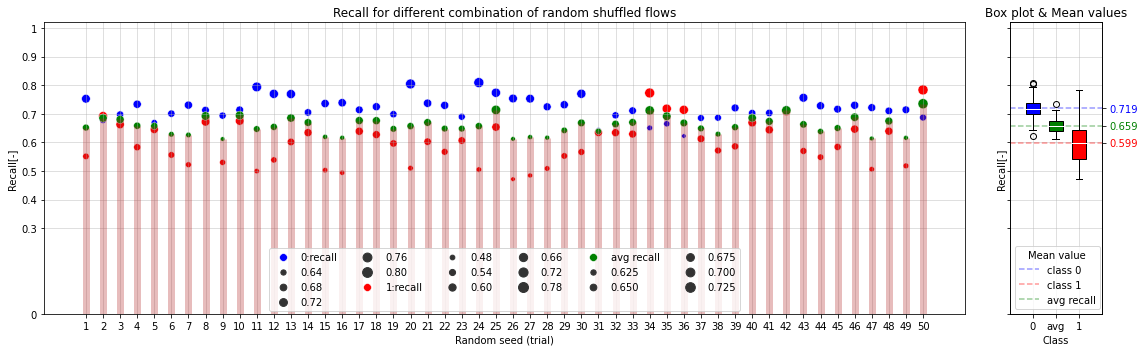

In [484]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), sharey=True, gridspec_kw={'width_ratios': [10, 1]})

sns.scatterplot(x=x_label, y=recall_0_list, label='0:recall', size=recall_0_list, sizes=(20, 100), color='b', ax=ax1)
sns.scatterplot(x=x_label, y=recall_1_list, label='1:recall', size=recall_1_list, sizes=(20, 100), color='r', ax=ax1)
sns.scatterplot(x=x_label, y=recall_avg_list, label='avg recall', size=recall_avg_list, sizes=(20, 100), color='g', ax=ax1)
ax1.vlines(x=x_label, ymin=0, ymax=recall_avg_list, linestyles='solid', color='firebrick', alpha=0.3, linewidth=7)
ax1.set_xticks(x_label)
ax1.legend(loc='lower center', bbox_to_anchor=(0.5, 0.01), borderaxespad=0, ncol=6)
ax1.grid(alpha=0.5)
plt.ylim([0,1.02])
plt.yticks([0, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], [0, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax1.set_xlabel('Random seed (trial)')
ax1.set_ylabel('Recall[-]')
ax1.set_title('Recall for different combination of random shuffled flows')

box = ax2.boxplot([recall_0_list, recall_1_list, recall_avg_list], positions=[1, 2, 1.5], widths=0.3, patch_artist=True) # meanline=True, showmeans=True
ax2.set_title('Box plot & Mean values')
ax2.set_xticks([1, 2, 1.5])
ax2.set_xticklabels(['0', '1', 'avg'])
ax2.set_xlabel('Class')
ax2.grid(alpha=0.5)
ax2.set_ylabel('Recall[-]')
# ax2.yaxis.set_label_position("right")
colors = ['blue', 'red', 'green']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
for median in box['medians']:
    median.set_color('white')
ax2.axhline(y=0.719, color='b', linestyle='--', alpha=0.4, label='class 0')
ax2.axhline(y=0.599, color='r', linestyle='--', alpha=0.4, label='class 1')
ax2.axhline(y=0.659, color='g', linestyle='--', alpha=0.4, label='avg recall')
ax2.legend(title='Mean value')
ax3 = ax2.twinx()
ax3.set_yticks([0.719, 0.599, 0.659])
ax3.set_ylim([0,1.02])
ax3.get_yticklabels()[0].set_color("b")
ax3.get_yticklabels()[1].set_color("r")
ax3.get_yticklabels()[2].set_color("g")

plt.tight_layout()
plt.show()

In [504]:
print(recall_0_list)
print(recall_1_list)
print(recall_avg_list)

[0.7527652157684783, 0.6779086004125745, 0.6975708758377296, 0.733561171338401, 0.6690205854025935, 0.7006518544191798, 0.730435202804707, 0.7127091616205714, 0.6937184028900212, 0.7138605711391123, 0.7941059829971306, 0.7698513998540326, 0.769189880926593, 0.7048875751082259, 0.7359589691635535, 0.7387550113807916, 0.7139755454615136, 0.724958092692632, 0.698588981794066, 0.8045386530341557, 0.737070387613433, 0.7295770611230159, 0.689719296023888, 0.8092925913212716, 0.7736972076236307, 0.7535833663815081, 0.7530418206600525, 0.7245398527662156, 0.7318148946735229, 0.7701963228212366, 0.6425248361199332, 0.6947398414354128, 0.7109778816064413, 0.6506413567636561, 0.665078132550397, 0.6222693598429684, 0.6853002829368108, 0.6862100797488561, 0.7206073976811845, 0.7022831567616565, 0.7030663151896076, 0.7145987396148193, 0.7561844521390223, 0.7281640433636488, 0.7163033589165086, 0.7298886581996687, 0.7216871565350405, 0.7102147187128208, 0.7141188467908833, 0.6870049022385001]
[0.5511

In [106]:
recall_0_list

[0.7527652157684783,
 0.6779086004125745,
 0.6975708758377296,
 0.733561171338401,
 0.6690205854025935,
 0.7006518544191798,
 0.730435202804707,
 0.7127091616205714,
 0.6937184028900212,
 0.7138605711391123,
 0.7941059829971306,
 0.7698513998540326,
 0.769189880926593,
 0.7048875751082259,
 0.7359589691635535,
 0.7387550113807916,
 0.7139755454615136,
 0.724958092692632,
 0.698588981794066,
 0.8045386530341557,
 0.737070387613433,
 0.7295770611230159,
 0.689719296023888,
 0.8092925913212716,
 0.7736972076236307,
 0.7535833663815081,
 0.7530418206600525,
 0.7245398527662156,
 0.7318148946735229,
 0.7701963228212366,
 0.6425248361199332,
 0.6947398414354128,
 0.7109778816064413,
 0.6506413567636561,
 0.665078132550397,
 0.6222693598429684,
 0.6853002829368108,
 0.6862100797488561,
 0.7206073976811845,
 0.7022831567616565,
 0.7030663151896076,
 0.7145987396148193,
 0.7561844521390223,
 0.7281640433636488,
 0.7163033589165086,
 0.7298886581996687,
 0.7216871565350405,
 0.7102147187128208,


In [107]:
recall_1_list

[0.5511168892565891,
 0.6924713390852145,
 0.662687625576173,
 0.5831462002127408,
 0.6454319820352205,
 0.556080841508096,
 0.5219241224441555,
 0.6720245833825789,
 0.5299609975180238,
 0.6750975062049404,
 0.49958633731237445,
 0.5385888192885002,
 0.6015837371469094,
 0.634203994799669,
 0.5026592601347358,
 0.4937950596856164,
 0.6389315683725328,
 0.6272308237796951,
 0.5962652168774376,
 0.5097506204940314,
 0.6025292518614821,
 0.5669542607256826,
 0.6065476893984163,
 0.5047866682425245,
 0.6535870464484104,
 0.47122089587519206,
 0.48422172320056733,
 0.5086869164401371,
 0.5525351613284482,
 0.5663633140290746,
 0.634794941496277,
 0.6340858054603474,
 0.6291218532088405,
 0.7729582791632195,
 0.7178820470393571,
 0.7138636095024229,
 0.6126935350431391,
 0.5715636449592246,
 0.585982744356459,
 0.6691880392388606,
 0.6438955206240398,
 0.7093724146082023,
 0.5699089942087223,
 0.5482803451128708,
 0.5840917149273136,
 0.6464956860891148,
 0.5059685616357404,
 0.639286136390

In [108]:
recall_avg_list

[0.6519410525125338,
 0.6851899697488946,
 0.6801292507069513,
 0.658353685775571,
 0.6572262837189069,
 0.6283663479636379,
 0.6261796626244313,
 0.6923668725015751,
 0.6118397002040226,
 0.6944790386720263,
 0.6468461601547526,
 0.6542201095712664,
 0.6853868090367512,
 0.6695457849539475,
 0.6193091146491447,
 0.616275035533204,
 0.6764535569170232,
 0.6760944582361635,
 0.6474270993357518,
 0.6571446367640936,
 0.6697998197374575,
 0.6482656609243492,
 0.6481334927111522,
 0.6570396297818981,
 0.7136421270360205,
 0.6124021311283501,
 0.6186317719303099,
 0.6166133846031763,
 0.6421750280009855,
 0.6682798184251556,
 0.6386598888081051,
 0.6644128234478801,
 0.6700498674076409,
 0.7117998179634377,
 0.6914800897948771,
 0.6680664846726956,
 0.648996908989975,
 0.6288868623540403,
 0.6532950710188218,
 0.6857355980002586,
 0.6734809179068237,
 0.7119855771115109,
 0.6630467231738724,
 0.6382221942382598,
 0.6501975369219111,
 0.6881921721443918,
 0.6138278590853905,
 0.6747504275516

[0]	validation_0-aucpr:0.140406
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.158556
[2]	validation_0-aucpr:0.169837
[3]	validation_0-aucpr:0.170806
[4]	validation_0-aucpr:0.178
[5]	validation_0-aucpr:0.181199
[6]	validation_0-aucpr:0.182824
[7]	validation_0-aucpr:0.191014
[8]	validation_0-aucpr:0.195439
[9]	validation_0-aucpr:0.196743
[10]	validation_0-aucpr:0.200882
[11]	validation_0-aucpr:0.200636
[12]	validation_0-aucpr:0.199164
[13]	validation_0-aucpr:0.201046
[14]	validation_0-aucpr:0.202008
[15]	validation_0-aucpr:0.202829
[16]	validation_0-aucpr:0.203759
[17]	validation_0-aucpr:0.203314
[18]	validation_0-aucpr:0.204846
[19]	validation_0-aucpr:0.204801
[20]	validation_0-aucpr:0.205496
[21]	validation_0-aucpr:0.205507
[22]	validation_0-aucpr:0.20423
[23]	validation_0-aucpr:0.202985
[24]	validation_0-aucpr:0.204126
[25]	validation_0-aucpr:0.203291
[26]	validation_0-aucpr:0.203362
[27]	validation_0-aucpr:0.203147
[28]	validation_0-aucpr:

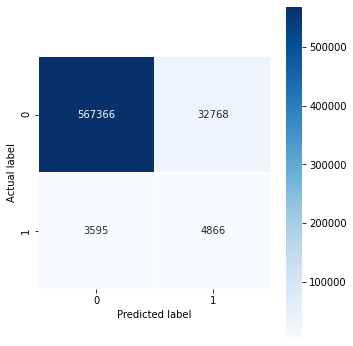

[0]	validation_0-aucpr:0.119558
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.134886
[2]	validation_0-aucpr:0.148702
[3]	validation_0-aucpr:0.169118
[4]	validation_0-aucpr:0.158922
[5]	validation_0-aucpr:0.159027
[6]	validation_0-aucpr:0.182391
[7]	validation_0-aucpr:0.198324
[8]	validation_0-aucpr:0.201205
[9]	validation_0-aucpr:0.199304
[10]	validation_0-aucpr:0.196007
[11]	validation_0-aucpr:0.198578
[12]	validation_0-aucpr:0.198812
[13]	validation_0-aucpr:0.199954
[14]	validation_0-aucpr:0.206205
[15]	validation_0-aucpr:0.207064
[16]	validation_0-aucpr:0.207563
[17]	validation_0-aucpr:0.211115
[18]	validation_0-aucpr:0.208639
[19]	validation_0-aucpr:0.204015
[20]	validation_0-aucpr:0.206523
[21]	validation_0-aucpr:0.206206
[22]	validation_0-aucpr:0.206391
[23]	validation_0-aucpr:0.20469
[24]	validation_0-aucpr:0.204668
[25]	validation_0-aucpr:0.204526
[26]	validation_0-aucpr:0.20268
[27]	validation_0-aucpr:0.201892
Stopping. Best iterati

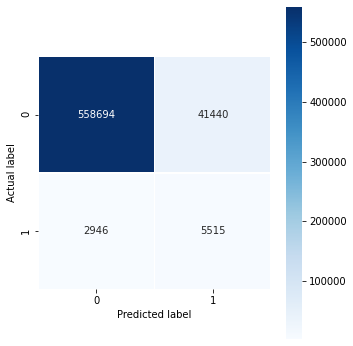

[0]	validation_0-aucpr:0.204257
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.218782
[2]	validation_0-aucpr:0.239333
[3]	validation_0-aucpr:0.241463
[4]	validation_0-aucpr:0.231013
[5]	validation_0-aucpr:0.22222
[6]	validation_0-aucpr:0.238991
[7]	validation_0-aucpr:0.2458
[8]	validation_0-aucpr:0.245714
[9]	validation_0-aucpr:0.242943
[10]	validation_0-aucpr:0.247334
[11]	validation_0-aucpr:0.248544
[12]	validation_0-aucpr:0.245482
[13]	validation_0-aucpr:0.246573
[14]	validation_0-aucpr:0.246709
[15]	validation_0-aucpr:0.251647
[16]	validation_0-aucpr:0.253159
[17]	validation_0-aucpr:0.253576
[18]	validation_0-aucpr:0.253806
[19]	validation_0-aucpr:0.253787
[20]	validation_0-aucpr:0.253314
[21]	validation_0-aucpr:0.256117
[22]	validation_0-aucpr:0.254764
[23]	validation_0-aucpr:0.255681
[24]	validation_0-aucpr:0.252561
[25]	validation_0-aucpr:0.251186
[26]	validation_0-aucpr:0.249707
[27]	validation_0-aucpr:0.250147
[28]	validation_0-aucpr

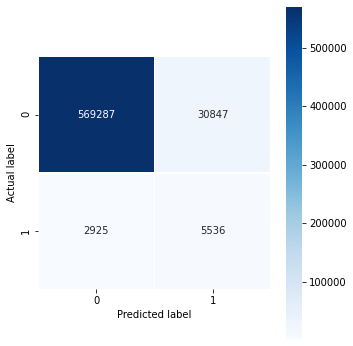

[0]	validation_0-aucpr:0.133337
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.155
[2]	validation_0-aucpr:0.15635
[3]	validation_0-aucpr:0.161889
[4]	validation_0-aucpr:0.176997
[5]	validation_0-aucpr:0.173366
[6]	validation_0-aucpr:0.175851
[7]	validation_0-aucpr:0.174637
[8]	validation_0-aucpr:0.177235
[9]	validation_0-aucpr:0.182544
[10]	validation_0-aucpr:0.185856
[11]	validation_0-aucpr:0.185713
[12]	validation_0-aucpr:0.184943
[13]	validation_0-aucpr:0.186765
[14]	validation_0-aucpr:0.186496
[15]	validation_0-aucpr:0.185804
[16]	validation_0-aucpr:0.185617
[17]	validation_0-aucpr:0.185491
[18]	validation_0-aucpr:0.184375
[19]	validation_0-aucpr:0.185656
[20]	validation_0-aucpr:0.185599
[21]	validation_0-aucpr:0.186875
[22]	validation_0-aucpr:0.187335
[23]	validation_0-aucpr:0.188187
[24]	validation_0-aucpr:0.187568
[25]	validation_0-aucpr:0.186553
[26]	validation_0-aucpr:0.188953
[27]	validation_0-aucpr:0.188391
[28]	validation_0-aucpr:

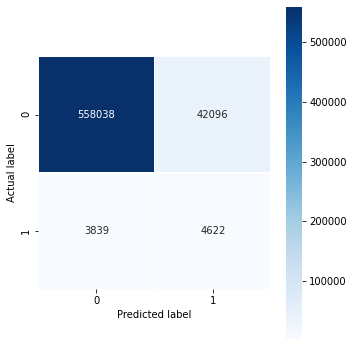

[0]	validation_0-aucpr:0.140122
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.155361
[2]	validation_0-aucpr:0.15869
[3]	validation_0-aucpr:0.167935
[4]	validation_0-aucpr:0.174262
[5]	validation_0-aucpr:0.157695
[6]	validation_0-aucpr:0.162707
[7]	validation_0-aucpr:0.157382
[8]	validation_0-aucpr:0.154045
[9]	validation_0-aucpr:0.153838
[10]	validation_0-aucpr:0.15277
[11]	validation_0-aucpr:0.151274
[12]	validation_0-aucpr:0.15465
[13]	validation_0-aucpr:0.159216
[14]	validation_0-aucpr:0.159366
Stopping. Best iteration:
[4]	validation_0-aucpr:0.174262

Prediction Report of trial 5
               precision    recall  f1-score   support

           0       0.99      0.95      0.97    600134
           1       0.12      0.50      0.19      8461

    accuracy                           0.94    608595
   macro avg       0.55      0.72      0.58    608595
weighted avg       0.98      0.94      0.96    608595



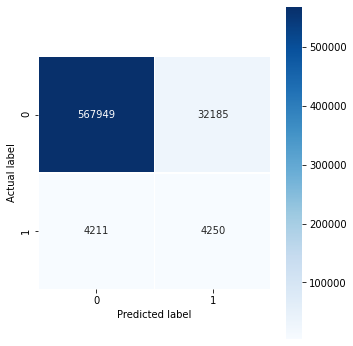

[0]	validation_0-aucpr:0.145121
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.157257
[2]	validation_0-aucpr:0.171768
[3]	validation_0-aucpr:0.17661
[4]	validation_0-aucpr:0.183669
[5]	validation_0-aucpr:0.192325
[6]	validation_0-aucpr:0.186913
[7]	validation_0-aucpr:0.194061
[8]	validation_0-aucpr:0.197281
[9]	validation_0-aucpr:0.197744
[10]	validation_0-aucpr:0.20013
[11]	validation_0-aucpr:0.196485
[12]	validation_0-aucpr:0.198965
[13]	validation_0-aucpr:0.201696
[14]	validation_0-aucpr:0.198144
[15]	validation_0-aucpr:0.199786
[16]	validation_0-aucpr:0.202618
[17]	validation_0-aucpr:0.201969
[18]	validation_0-aucpr:0.200119
[19]	validation_0-aucpr:0.201345
[20]	validation_0-aucpr:0.201586
[21]	validation_0-aucpr:0.20179
[22]	validation_0-aucpr:0.200349
[23]	validation_0-aucpr:0.201485
[24]	validation_0-aucpr:0.20261
[25]	validation_0-aucpr:0.202342
[26]	validation_0-aucpr:0.203123
[27]	validation_0-aucpr:0.200992
[28]	validation_0-aucpr:

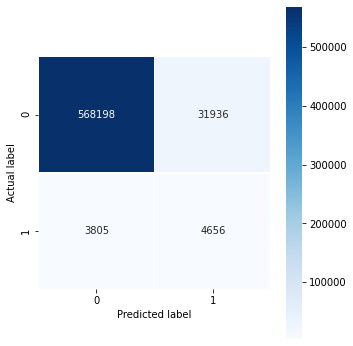

[0]	validation_0-aucpr:0.102412
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.124131
[2]	validation_0-aucpr:0.128996
[3]	validation_0-aucpr:0.128395
[4]	validation_0-aucpr:0.130124
[5]	validation_0-aucpr:0.125974
[6]	validation_0-aucpr:0.125155
[7]	validation_0-aucpr:0.119793
[8]	validation_0-aucpr:0.118719
[9]	validation_0-aucpr:0.120054
[10]	validation_0-aucpr:0.118974
[11]	validation_0-aucpr:0.117453
[12]	validation_0-aucpr:0.117059
[13]	validation_0-aucpr:0.117464
[14]	validation_0-aucpr:0.116102
Stopping. Best iteration:
[4]	validation_0-aucpr:0.130124

Prediction Report of trial 7
               precision    recall  f1-score   support

           0       0.99      0.96      0.97    600134
           1       0.11      0.39      0.18      8461

    accuracy                           0.95    608595
   macro avg       0.55      0.68      0.57    608595
weighted avg       0.98      0.95      0.96    608595



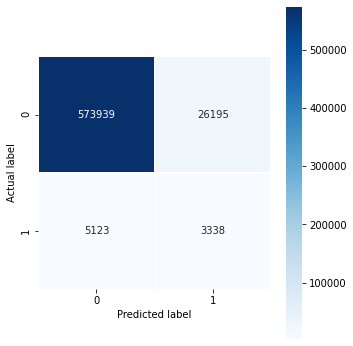

[0]	validation_0-aucpr:0.255689
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.295599
[2]	validation_0-aucpr:0.300504
[3]	validation_0-aucpr:0.321622
[4]	validation_0-aucpr:0.342201
[5]	validation_0-aucpr:0.346395
[6]	validation_0-aucpr:0.348469
[7]	validation_0-aucpr:0.356049
[8]	validation_0-aucpr:0.364089
[9]	validation_0-aucpr:0.362063
[10]	validation_0-aucpr:0.365311
[11]	validation_0-aucpr:0.362455
[12]	validation_0-aucpr:0.368657
[13]	validation_0-aucpr:0.369447
[14]	validation_0-aucpr:0.369206
[15]	validation_0-aucpr:0.370269
[16]	validation_0-aucpr:0.369635
[17]	validation_0-aucpr:0.371666
[18]	validation_0-aucpr:0.373312
[19]	validation_0-aucpr:0.373949
[20]	validation_0-aucpr:0.374642
[21]	validation_0-aucpr:0.373991
[22]	validation_0-aucpr:0.374585
[23]	validation_0-aucpr:0.37607
[24]	validation_0-aucpr:0.376514
[25]	validation_0-aucpr:0.37543
[26]	validation_0-aucpr:0.376396
[27]	validation_0-aucpr:0.376702
[28]	validation_0-aucp

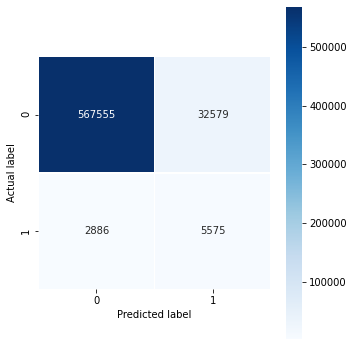

[0]	validation_0-aucpr:0.111071
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.137239
[2]	validation_0-aucpr:0.139938
[3]	validation_0-aucpr:0.15334
[4]	validation_0-aucpr:0.154025
[5]	validation_0-aucpr:0.158412
[6]	validation_0-aucpr:0.152546
[7]	validation_0-aucpr:0.152426
[8]	validation_0-aucpr:0.151205
[9]	validation_0-aucpr:0.147048
[10]	validation_0-aucpr:0.147747
[11]	validation_0-aucpr:0.145834
[12]	validation_0-aucpr:0.144274
[13]	validation_0-aucpr:0.140863
[14]	validation_0-aucpr:0.13971
[15]	validation_0-aucpr:0.138001
Stopping. Best iteration:
[5]	validation_0-aucpr:0.158412

Prediction Report of trial 9
               precision    recall  f1-score   support

           0       0.99      0.96      0.98    600134
           1       0.14      0.44      0.21      8461

    accuracy                           0.95    608595
   macro avg       0.56      0.70      0.59    608595
weighted avg       0.98      0.95      0.97    608595



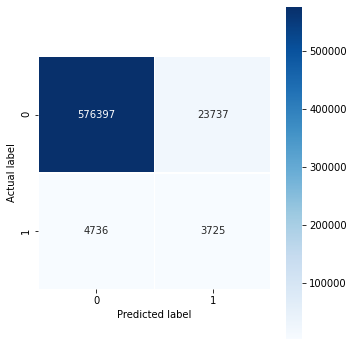

[0]	validation_0-aucpr:0.133061
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.163617
[2]	validation_0-aucpr:0.167363
[3]	validation_0-aucpr:0.173958
[4]	validation_0-aucpr:0.180179
[5]	validation_0-aucpr:0.172991
[6]	validation_0-aucpr:0.169813
[7]	validation_0-aucpr:0.170132
[8]	validation_0-aucpr:0.16998
[9]	validation_0-aucpr:0.169437
[10]	validation_0-aucpr:0.16933
[11]	validation_0-aucpr:0.169617
[12]	validation_0-aucpr:0.171167
[13]	validation_0-aucpr:0.174198
[14]	validation_0-aucpr:0.172372
Stopping. Best iteration:
[4]	validation_0-aucpr:0.180179

Prediction Report of trial 10
               precision    recall  f1-score   support

           0       0.99      0.95      0.97    600134
           1       0.12      0.55      0.20      8461

    accuracy                           0.94    608595
   macro avg       0.56      0.75      0.59    608595
weighted avg       0.98      0.94      0.96    608595



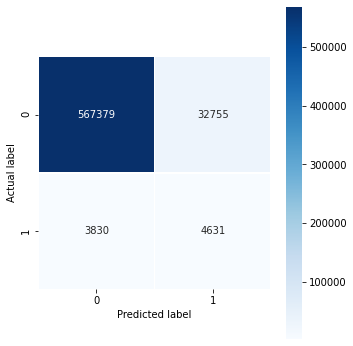

[0]	validation_0-aucpr:0.140322
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.15414
[2]	validation_0-aucpr:0.15978
[3]	validation_0-aucpr:0.168041
[4]	validation_0-aucpr:0.172449
[5]	validation_0-aucpr:0.174072
[6]	validation_0-aucpr:0.182239
[7]	validation_0-aucpr:0.181182
[8]	validation_0-aucpr:0.185276
[9]	validation_0-aucpr:0.188207
[10]	validation_0-aucpr:0.189472
[11]	validation_0-aucpr:0.189563
[12]	validation_0-aucpr:0.189401
[13]	validation_0-aucpr:0.190457
[14]	validation_0-aucpr:0.188102
[15]	validation_0-aucpr:0.188064
[16]	validation_0-aucpr:0.188701
[17]	validation_0-aucpr:0.188478
[18]	validation_0-aucpr:0.186605
[19]	validation_0-aucpr:0.186571
[20]	validation_0-aucpr:0.188792
[21]	validation_0-aucpr:0.188854
[22]	validation_0-aucpr:0.189744
[23]	validation_0-aucpr:0.189447
Stopping. Best iteration:
[13]	validation_0-aucpr:0.190457

Prediction Report of trial 11
               precision    recall  f1-score   support

        

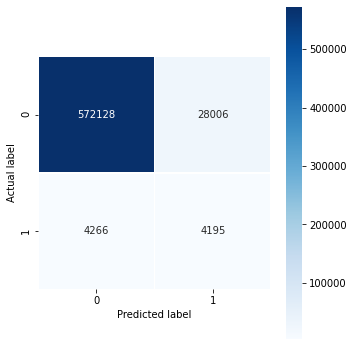

[0]	validation_0-aucpr:0.075784
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.088078
[2]	validation_0-aucpr:0.094517
[3]	validation_0-aucpr:0.099897
[4]	validation_0-aucpr:0.102907
[5]	validation_0-aucpr:0.100599
[6]	validation_0-aucpr:0.100992
[7]	validation_0-aucpr:0.10091
[8]	validation_0-aucpr:0.099048
[9]	validation_0-aucpr:0.099189
[10]	validation_0-aucpr:0.097216
[11]	validation_0-aucpr:0.0981
[12]	validation_0-aucpr:0.09842
[13]	validation_0-aucpr:0.101114
[14]	validation_0-aucpr:0.0996
Stopping. Best iteration:
[4]	validation_0-aucpr:0.102907

Prediction Report of trial 12
               precision    recall  f1-score   support

           0       0.99      0.96      0.97    600134
           1       0.12      0.38      0.18      8461

    accuracy                           0.95    608595
   macro avg       0.55      0.67      0.58    608595
weighted avg       0.98      0.95      0.96    608595



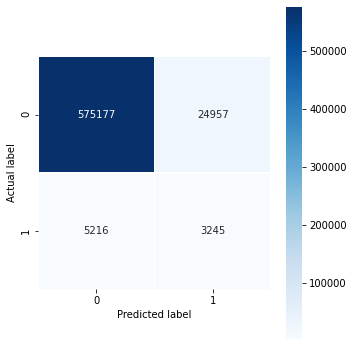

[0]	validation_0-aucpr:0.138072
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.159884
[2]	validation_0-aucpr:0.167613
[3]	validation_0-aucpr:0.176744
[4]	validation_0-aucpr:0.169671
[5]	validation_0-aucpr:0.166152
[6]	validation_0-aucpr:0.176638
[7]	validation_0-aucpr:0.179317
[8]	validation_0-aucpr:0.182532
[9]	validation_0-aucpr:0.181038
[10]	validation_0-aucpr:0.177754
[11]	validation_0-aucpr:0.177542
[12]	validation_0-aucpr:0.178452
[13]	validation_0-aucpr:0.179142
[14]	validation_0-aucpr:0.178022
[15]	validation_0-aucpr:0.177531
[16]	validation_0-aucpr:0.178776
[17]	validation_0-aucpr:0.179699
[18]	validation_0-aucpr:0.177069
Stopping. Best iteration:
[8]	validation_0-aucpr:0.182532

Prediction Report of trial 13
               precision    recall  f1-score   support

           0       0.99      0.96      0.98    600134
           1       0.15      0.51      0.23      8461

    accuracy                           0.95    608595
   macro 

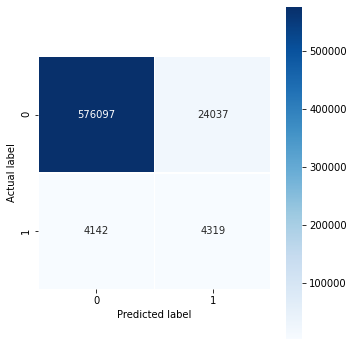

[0]	validation_0-aucpr:0.145986
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.135708
[2]	validation_0-aucpr:0.145552
[3]	validation_0-aucpr:0.161855
[4]	validation_0-aucpr:0.182271
[5]	validation_0-aucpr:0.183585
[6]	validation_0-aucpr:0.194849
[7]	validation_0-aucpr:0.191946
[8]	validation_0-aucpr:0.192505
[9]	validation_0-aucpr:0.19304
[10]	validation_0-aucpr:0.199511
[11]	validation_0-aucpr:0.199873
[12]	validation_0-aucpr:0.20268
[13]	validation_0-aucpr:0.204856
[14]	validation_0-aucpr:0.20353
[15]	validation_0-aucpr:0.204584
[16]	validation_0-aucpr:0.202998
[17]	validation_0-aucpr:0.202279
[18]	validation_0-aucpr:0.203867
[19]	validation_0-aucpr:0.204187
[20]	validation_0-aucpr:0.203893
[21]	validation_0-aucpr:0.202768
[22]	validation_0-aucpr:0.199898
[23]	validation_0-aucpr:0.199275
Stopping. Best iteration:
[13]	validation_0-aucpr:0.204856

Prediction Report of trial 14
               precision    recall  f1-score   support

         

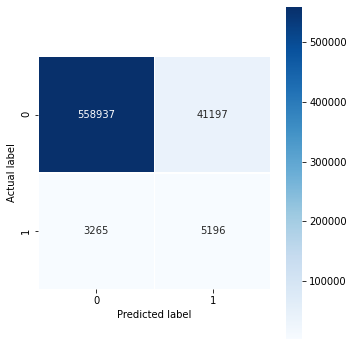

[0]	validation_0-aucpr:0.129212
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.158503
[2]	validation_0-aucpr:0.162529
[3]	validation_0-aucpr:0.175659
[4]	validation_0-aucpr:0.187603
[5]	validation_0-aucpr:0.190261
[6]	validation_0-aucpr:0.191166
[7]	validation_0-aucpr:0.189935
[8]	validation_0-aucpr:0.191895
[9]	validation_0-aucpr:0.191107
[10]	validation_0-aucpr:0.190163
[11]	validation_0-aucpr:0.187247
[12]	validation_0-aucpr:0.183549
[13]	validation_0-aucpr:0.183251
[14]	validation_0-aucpr:0.180829
[15]	validation_0-aucpr:0.180949
[16]	validation_0-aucpr:0.176781
[17]	validation_0-aucpr:0.176165
[18]	validation_0-aucpr:0.17677
Stopping. Best iteration:
[8]	validation_0-aucpr:0.191895

Prediction Report of trial 15
               precision    recall  f1-score   support

           0       0.99      0.96      0.97    600134
           1       0.13      0.45      0.20      8461

    accuracy                           0.95    608595
   macro a

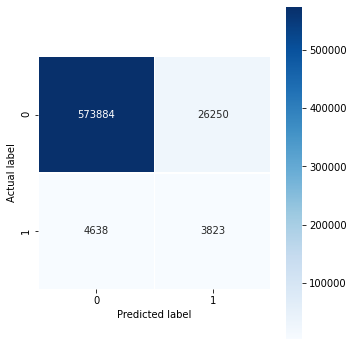

[0]	validation_0-aucpr:0.089916
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.107909
[2]	validation_0-aucpr:0.113477
[3]	validation_0-aucpr:0.116771
[4]	validation_0-aucpr:0.121845
[5]	validation_0-aucpr:0.120714
[6]	validation_0-aucpr:0.120324
[7]	validation_0-aucpr:0.118855
[8]	validation_0-aucpr:0.118852
[9]	validation_0-aucpr:0.119393
[10]	validation_0-aucpr:0.116705
[11]	validation_0-aucpr:0.115699
[12]	validation_0-aucpr:0.117234
[13]	validation_0-aucpr:0.116967
[14]	validation_0-aucpr:0.116014
Stopping. Best iteration:
[4]	validation_0-aucpr:0.121845

Prediction Report of trial 16
               precision    recall  f1-score   support

           0       0.99      0.96      0.97    600134
           1       0.12      0.38      0.18      8461

    accuracy                           0.95    608595
   macro avg       0.55      0.67      0.58    608595
weighted avg       0.98      0.95      0.96    608595



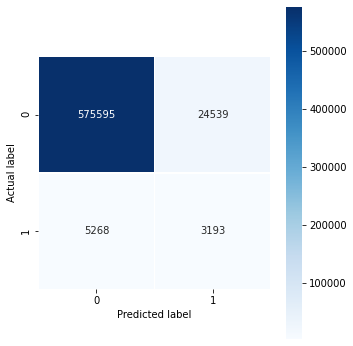

[0]	validation_0-aucpr:0.114246
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.136404
[2]	validation_0-aucpr:0.139582
[3]	validation_0-aucpr:0.153704
[4]	validation_0-aucpr:0.147958
[5]	validation_0-aucpr:0.148629
[6]	validation_0-aucpr:0.144551
[7]	validation_0-aucpr:0.140487
[8]	validation_0-aucpr:0.144488
[9]	validation_0-aucpr:0.144348
[10]	validation_0-aucpr:0.145423
[11]	validation_0-aucpr:0.147067
[12]	validation_0-aucpr:0.149564
[13]	validation_0-aucpr:0.152106
Stopping. Best iteration:
[3]	validation_0-aucpr:0.153704

Prediction Report of trial 17
               precision    recall  f1-score   support

           0       0.99      0.96      0.97    600134
           1       0.13      0.48      0.21      8461

    accuracy                           0.95    608595
   macro avg       0.56      0.72      0.59    608595
weighted avg       0.98      0.95      0.96    608595



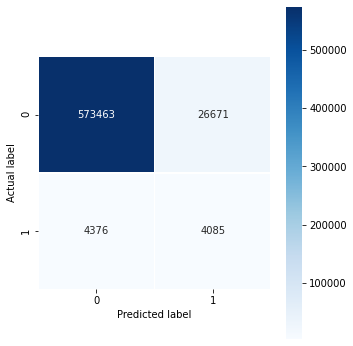

[0]	validation_0-aucpr:0.220048
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.255089
[2]	validation_0-aucpr:0.267319
[3]	validation_0-aucpr:0.28027
[4]	validation_0-aucpr:0.301038
[5]	validation_0-aucpr:0.303445
[6]	validation_0-aucpr:0.308941
[7]	validation_0-aucpr:0.307953
[8]	validation_0-aucpr:0.317203
[9]	validation_0-aucpr:0.317533
[10]	validation_0-aucpr:0.317141
[11]	validation_0-aucpr:0.316927
[12]	validation_0-aucpr:0.316296
[13]	validation_0-aucpr:0.315581
[14]	validation_0-aucpr:0.319975
[15]	validation_0-aucpr:0.318251
[16]	validation_0-aucpr:0.317284
[17]	validation_0-aucpr:0.316882
[18]	validation_0-aucpr:0.31694
[19]	validation_0-aucpr:0.317313
[20]	validation_0-aucpr:0.316284
[21]	validation_0-aucpr:0.315534
[22]	validation_0-aucpr:0.312563
[23]	validation_0-aucpr:0.313831
[24]	validation_0-aucpr:0.312389
Stopping. Best iteration:
[14]	validation_0-aucpr:0.319975

Prediction Report of trial 18
               precision    rec

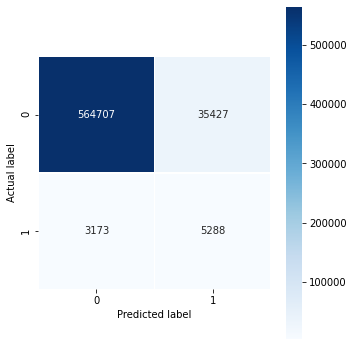

[0]	validation_0-aucpr:0.132381
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.169193
[2]	validation_0-aucpr:0.173507
[3]	validation_0-aucpr:0.175351
[4]	validation_0-aucpr:0.170597
[5]	validation_0-aucpr:0.178366
[6]	validation_0-aucpr:0.182135
[7]	validation_0-aucpr:0.185055
[8]	validation_0-aucpr:0.182562
[9]	validation_0-aucpr:0.185353
[10]	validation_0-aucpr:0.187287
[11]	validation_0-aucpr:0.188062
[12]	validation_0-aucpr:0.192078
[13]	validation_0-aucpr:0.192492
[14]	validation_0-aucpr:0.194963
[15]	validation_0-aucpr:0.194925
[16]	validation_0-aucpr:0.19506
[17]	validation_0-aucpr:0.194655
[18]	validation_0-aucpr:0.192348
[19]	validation_0-aucpr:0.193772
[20]	validation_0-aucpr:0.191879
[21]	validation_0-aucpr:0.192588
[22]	validation_0-aucpr:0.190866
[23]	validation_0-aucpr:0.188546
[24]	validation_0-aucpr:0.185954
[25]	validation_0-aucpr:0.18634
[26]	validation_0-aucpr:0.185535
Stopping. Best iteration:
[16]	validation_0-aucpr:0.195

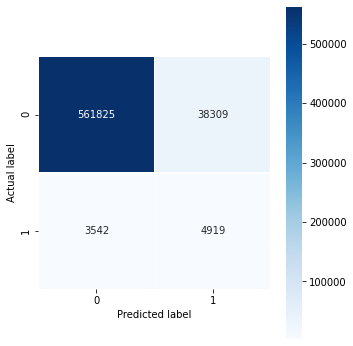

[0]	validation_0-aucpr:0.093636
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.098839
[2]	validation_0-aucpr:0.102575
[3]	validation_0-aucpr:0.10629
[4]	validation_0-aucpr:0.104428
[5]	validation_0-aucpr:0.102006
[6]	validation_0-aucpr:0.102598
[7]	validation_0-aucpr:0.101048
[8]	validation_0-aucpr:0.102242
[9]	validation_0-aucpr:0.102995
[10]	validation_0-aucpr:0.103709
[11]	validation_0-aucpr:0.10452
[12]	validation_0-aucpr:0.104277
[13]	validation_0-aucpr:0.10411
Stopping. Best iteration:
[3]	validation_0-aucpr:0.10629

Prediction Report of trial 20
               precision    recall  f1-score   support

           0       0.99      0.96      0.98    600134
           1       0.12      0.38      0.18      8461

    accuracy                           0.95    608595
   macro avg       0.56      0.67      0.58    608595
weighted avg       0.98      0.95      0.96    608595



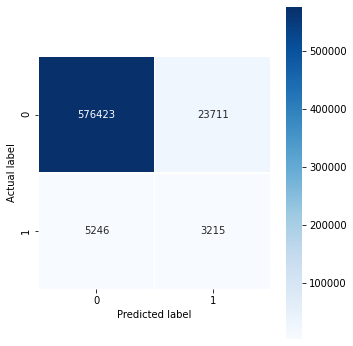

[0]	validation_0-aucpr:0.148603
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.171432
[2]	validation_0-aucpr:0.180191
[3]	validation_0-aucpr:0.189379
[4]	validation_0-aucpr:0.190158
[5]	validation_0-aucpr:0.193776
[6]	validation_0-aucpr:0.201045
[7]	validation_0-aucpr:0.203638
[8]	validation_0-aucpr:0.207397
[9]	validation_0-aucpr:0.210566
[10]	validation_0-aucpr:0.212418
[11]	validation_0-aucpr:0.211911
[12]	validation_0-aucpr:0.212268
[13]	validation_0-aucpr:0.212454
[14]	validation_0-aucpr:0.21436
[15]	validation_0-aucpr:0.213694
[16]	validation_0-aucpr:0.213607
[17]	validation_0-aucpr:0.212827
[18]	validation_0-aucpr:0.213837
[19]	validation_0-aucpr:0.214242
[20]	validation_0-aucpr:0.21427
[21]	validation_0-aucpr:0.21395
[22]	validation_0-aucpr:0.21281
[23]	validation_0-aucpr:0.213506
[24]	validation_0-aucpr:0.212957
Stopping. Best iteration:
[14]	validation_0-aucpr:0.21436

Prediction Report of trial 21
               precision    recall

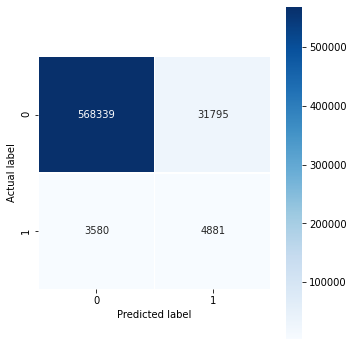

[0]	validation_0-aucpr:0.152587
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.188095
[2]	validation_0-aucpr:0.198566
[3]	validation_0-aucpr:0.197221
[4]	validation_0-aucpr:0.208876
[5]	validation_0-aucpr:0.208555
[6]	validation_0-aucpr:0.213599
[7]	validation_0-aucpr:0.212291
[8]	validation_0-aucpr:0.214073
[9]	validation_0-aucpr:0.221417
[10]	validation_0-aucpr:0.223773
[11]	validation_0-aucpr:0.227713
[12]	validation_0-aucpr:0.228384
[13]	validation_0-aucpr:0.230293
[14]	validation_0-aucpr:0.232126
[15]	validation_0-aucpr:0.237206
[16]	validation_0-aucpr:0.234507
[17]	validation_0-aucpr:0.235187
[18]	validation_0-aucpr:0.237721
[19]	validation_0-aucpr:0.238547
[20]	validation_0-aucpr:0.237415
[21]	validation_0-aucpr:0.238745
[22]	validation_0-aucpr:0.239097
[23]	validation_0-aucpr:0.238306
[24]	validation_0-aucpr:0.238022
[25]	validation_0-aucpr:0.240661
[26]	validation_0-aucpr:0.241984
[27]	validation_0-aucpr:0.242403
[28]	validation_0-au

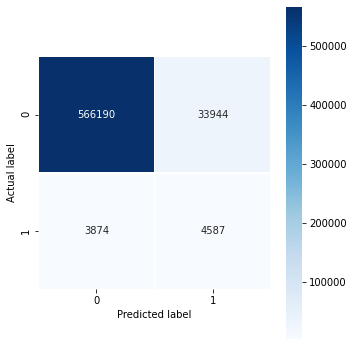

[0]	validation_0-aucpr:0.11903
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.126441
[2]	validation_0-aucpr:0.145414
[3]	validation_0-aucpr:0.155557
[4]	validation_0-aucpr:0.145699
[5]	validation_0-aucpr:0.145144
[6]	validation_0-aucpr:0.142571
[7]	validation_0-aucpr:0.139491
[8]	validation_0-aucpr:0.135513
[9]	validation_0-aucpr:0.135117
[10]	validation_0-aucpr:0.13634
[11]	validation_0-aucpr:0.134653
[12]	validation_0-aucpr:0.13348
[13]	validation_0-aucpr:0.133033
Stopping. Best iteration:
[3]	validation_0-aucpr:0.155557

Prediction Report of trial 23
               precision    recall  f1-score   support

           0       0.99      0.94      0.96    600134
           1       0.10      0.48      0.16      8461

    accuracy                           0.93    608595
   macro avg       0.55      0.71      0.56    608595
weighted avg       0.98      0.93      0.95    608595



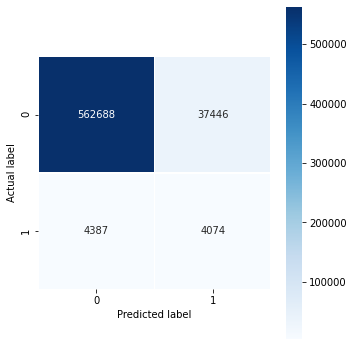

[0]	validation_0-aucpr:0.143059
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.175462
[2]	validation_0-aucpr:0.18165
[3]	validation_0-aucpr:0.176424
[4]	validation_0-aucpr:0.19277
[5]	validation_0-aucpr:0.181064
[6]	validation_0-aucpr:0.18507
[7]	validation_0-aucpr:0.186162
[8]	validation_0-aucpr:0.181554
[9]	validation_0-aucpr:0.177912
[10]	validation_0-aucpr:0.179397
[11]	validation_0-aucpr:0.180307
[12]	validation_0-aucpr:0.177836
[13]	validation_0-aucpr:0.180212
[14]	validation_0-aucpr:0.177641
Stopping. Best iteration:
[4]	validation_0-aucpr:0.19277

Prediction Report of trial 24
               precision    recall  f1-score   support

           0       0.99      0.97      0.98    600134
           1       0.19      0.41      0.26      8461

    accuracy                           0.97    608595
   macro avg       0.59      0.69      0.62    608595
weighted avg       0.98      0.97      0.97    608595



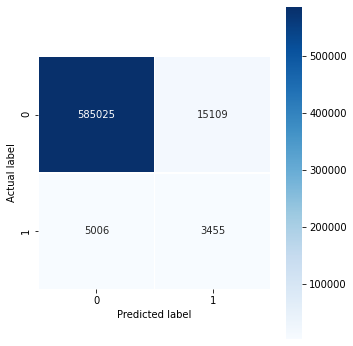

[0]	validation_0-aucpr:0.212745
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.228101
[2]	validation_0-aucpr:0.245793
[3]	validation_0-aucpr:0.258491
[4]	validation_0-aucpr:0.263779
[5]	validation_0-aucpr:0.270496
[6]	validation_0-aucpr:0.2818
[7]	validation_0-aucpr:0.274627
[8]	validation_0-aucpr:0.275072
[9]	validation_0-aucpr:0.277561
[10]	validation_0-aucpr:0.281367
[11]	validation_0-aucpr:0.281553
[12]	validation_0-aucpr:0.281074
[13]	validation_0-aucpr:0.281719
[14]	validation_0-aucpr:0.281714
[15]	validation_0-aucpr:0.282553
[16]	validation_0-aucpr:0.2837
[17]	validation_0-aucpr:0.284063
[18]	validation_0-aucpr:0.285487
[19]	validation_0-aucpr:0.284641
[20]	validation_0-aucpr:0.285885
[21]	validation_0-aucpr:0.286613
[22]	validation_0-aucpr:0.289868
[23]	validation_0-aucpr:0.289988
[24]	validation_0-aucpr:0.288919
[25]	validation_0-aucpr:0.28901
[26]	validation_0-aucpr:0.291482
[27]	validation_0-aucpr:0.290809
[28]	validation_0-aucpr:0

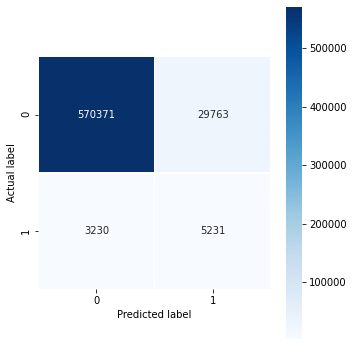

[0]	validation_0-aucpr:0.140235
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.155466
[2]	validation_0-aucpr:0.163056
[3]	validation_0-aucpr:0.167239
[4]	validation_0-aucpr:0.171172
[5]	validation_0-aucpr:0.175108
[6]	validation_0-aucpr:0.177877
[7]	validation_0-aucpr:0.179141
[8]	validation_0-aucpr:0.178696
[9]	validation_0-aucpr:0.178633
[10]	validation_0-aucpr:0.178897
[11]	validation_0-aucpr:0.179102
[12]	validation_0-aucpr:0.18095
[13]	validation_0-aucpr:0.182128
[14]	validation_0-aucpr:0.180732
[15]	validation_0-aucpr:0.180105
[16]	validation_0-aucpr:0.179645
[17]	validation_0-aucpr:0.177123
[18]	validation_0-aucpr:0.175056
[19]	validation_0-aucpr:0.17279
[20]	validation_0-aucpr:0.172771
[21]	validation_0-aucpr:0.172617
[22]	validation_0-aucpr:0.17269
[23]	validation_0-aucpr:0.171449
Stopping. Best iteration:
[13]	validation_0-aucpr:0.182128

Prediction Report of trial 26
               precision    recall  f1-score   support

         

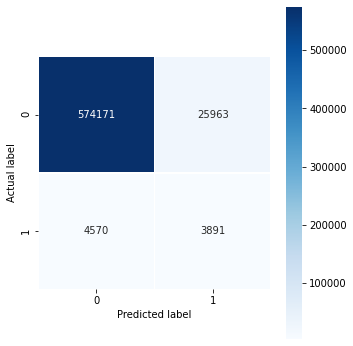

[0]	validation_0-aucpr:0.068368
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.083218
[2]	validation_0-aucpr:0.080626
[3]	validation_0-aucpr:0.085305
[4]	validation_0-aucpr:0.087512
[5]	validation_0-aucpr:0.088847
[6]	validation_0-aucpr:0.087197
[7]	validation_0-aucpr:0.08653
[8]	validation_0-aucpr:0.085613
[9]	validation_0-aucpr:0.085053
[10]	validation_0-aucpr:0.084764
[11]	validation_0-aucpr:0.083938
[12]	validation_0-aucpr:0.083704
[13]	validation_0-aucpr:0.081954
[14]	validation_0-aucpr:0.083173
[15]	validation_0-aucpr:0.082816
Stopping. Best iteration:
[5]	validation_0-aucpr:0.088847

Prediction Report of trial 27
               precision    recall  f1-score   support

           0       0.99      0.96      0.97    600134
           1       0.11      0.41      0.18      8461

    accuracy                           0.95    608595
   macro avg       0.55      0.68      0.57    608595
weighted avg       0.98      0.95      0.96    608595



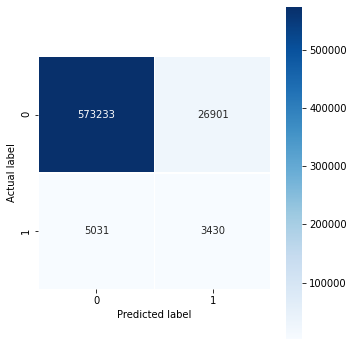

[0]	validation_0-aucpr:0.133114
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.149621
[2]	validation_0-aucpr:0.152802
[3]	validation_0-aucpr:0.158364
[4]	validation_0-aucpr:0.163087
[5]	validation_0-aucpr:0.162557
[6]	validation_0-aucpr:0.161917
[7]	validation_0-aucpr:0.164152
[8]	validation_0-aucpr:0.162406
[9]	validation_0-aucpr:0.163901
[10]	validation_0-aucpr:0.163547
[11]	validation_0-aucpr:0.164843
[12]	validation_0-aucpr:0.165476
[13]	validation_0-aucpr:0.163951
[14]	validation_0-aucpr:0.165925
[15]	validation_0-aucpr:0.167124
[16]	validation_0-aucpr:0.165415
[17]	validation_0-aucpr:0.163826
[18]	validation_0-aucpr:0.163728
[19]	validation_0-aucpr:0.164489
[20]	validation_0-aucpr:0.164046
[21]	validation_0-aucpr:0.162176
[22]	validation_0-aucpr:0.163171
[23]	validation_0-aucpr:0.16333
[24]	validation_0-aucpr:0.163579
[25]	validation_0-aucpr:0.162634
Stopping. Best iteration:
[15]	validation_0-aucpr:0.167124

Prediction Report of trial 

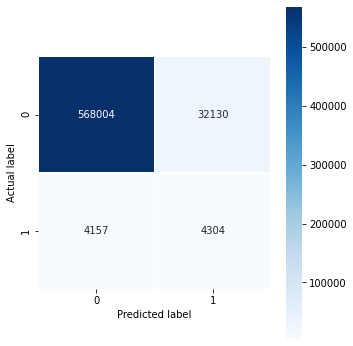

[0]	validation_0-aucpr:0.177991
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.199996
[2]	validation_0-aucpr:0.206012
[3]	validation_0-aucpr:0.21635
[4]	validation_0-aucpr:0.225739
[5]	validation_0-aucpr:0.221067
[6]	validation_0-aucpr:0.222293
[7]	validation_0-aucpr:0.22397
[8]	validation_0-aucpr:0.220932
[9]	validation_0-aucpr:0.221579
[10]	validation_0-aucpr:0.221943
[11]	validation_0-aucpr:0.222724
[12]	validation_0-aucpr:0.220652
[13]	validation_0-aucpr:0.22031
[14]	validation_0-aucpr:0.219944
Stopping. Best iteration:
[4]	validation_0-aucpr:0.225739

Prediction Report of trial 29
               precision    recall  f1-score   support

           0       0.99      0.97      0.98    600134
           1       0.16      0.45      0.24      8461

    accuracy                           0.96    608595
   macro avg       0.58      0.71      0.61    608595
weighted avg       0.98      0.96      0.97    608595



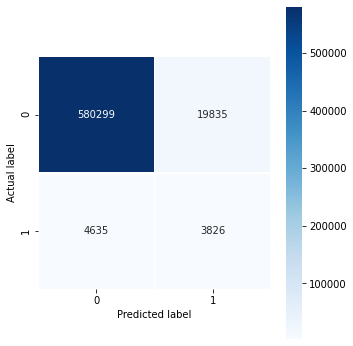

[0]	validation_0-aucpr:0.199076
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.224399
[2]	validation_0-aucpr:0.231683
[3]	validation_0-aucpr:0.243752
[4]	validation_0-aucpr:0.257704
[5]	validation_0-aucpr:0.256352
[6]	validation_0-aucpr:0.255113
[7]	validation_0-aucpr:0.259767
[8]	validation_0-aucpr:0.262852
[9]	validation_0-aucpr:0.264562
[10]	validation_0-aucpr:0.265372
[11]	validation_0-aucpr:0.264385
[12]	validation_0-aucpr:0.259782
[13]	validation_0-aucpr:0.258752
[14]	validation_0-aucpr:0.259409
[15]	validation_0-aucpr:0.259926
[16]	validation_0-aucpr:0.260127
[17]	validation_0-aucpr:0.259139
[18]	validation_0-aucpr:0.258521
[19]	validation_0-aucpr:0.260268
[20]	validation_0-aucpr:0.260769
Stopping. Best iteration:
[10]	validation_0-aucpr:0.265372

Prediction Report of trial 30
               precision    recall  f1-score   support

           0       0.99      0.95      0.97    600134
           1       0.13      0.54      0.21      84

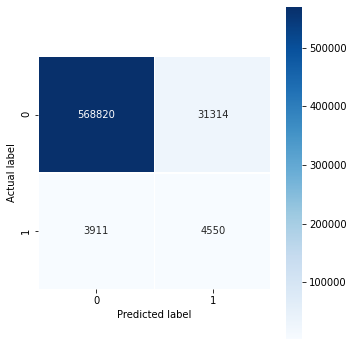

[0]	validation_0-aucpr:0.130094
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.140876
[2]	validation_0-aucpr:0.160697
[3]	validation_0-aucpr:0.162146
[4]	validation_0-aucpr:0.16707
[5]	validation_0-aucpr:0.165401
[6]	validation_0-aucpr:0.16152
[7]	validation_0-aucpr:0.162796
[8]	validation_0-aucpr:0.16218
[9]	validation_0-aucpr:0.157958
[10]	validation_0-aucpr:0.159483
[11]	validation_0-aucpr:0.162684
[12]	validation_0-aucpr:0.164726
[13]	validation_0-aucpr:0.162774
[14]	validation_0-aucpr:0.161852
Stopping. Best iteration:
[4]	validation_0-aucpr:0.16707

Prediction Report of trial 31
               precision    recall  f1-score   support

           0       0.99      0.96      0.98    600134
           1       0.13      0.43      0.21      8461

    accuracy                           0.95    608595
   macro avg       0.56      0.70      0.59    608595
weighted avg       0.98      0.95      0.97    608595



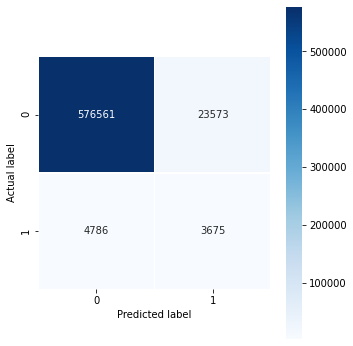

[0]	validation_0-aucpr:0.194695
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.208643
[2]	validation_0-aucpr:0.237779
[3]	validation_0-aucpr:0.244269
[4]	validation_0-aucpr:0.247462
[5]	validation_0-aucpr:0.24489
[6]	validation_0-aucpr:0.241082
[7]	validation_0-aucpr:0.243758
[8]	validation_0-aucpr:0.251743
[9]	validation_0-aucpr:0.258453
[10]	validation_0-aucpr:0.260534
[11]	validation_0-aucpr:0.265724
[12]	validation_0-aucpr:0.26588
[13]	validation_0-aucpr:0.267905
[14]	validation_0-aucpr:0.269966
[15]	validation_0-aucpr:0.270103
[16]	validation_0-aucpr:0.278812
[17]	validation_0-aucpr:0.275966
[18]	validation_0-aucpr:0.281092
[19]	validation_0-aucpr:0.280801
[20]	validation_0-aucpr:0.281216
[21]	validation_0-aucpr:0.281281
[22]	validation_0-aucpr:0.282352
[23]	validation_0-aucpr:0.281994
[24]	validation_0-aucpr:0.282294
[25]	validation_0-aucpr:0.283366
[26]	validation_0-aucpr:0.283406
[27]	validation_0-aucpr:0.283719
[28]	validation_0-aucp

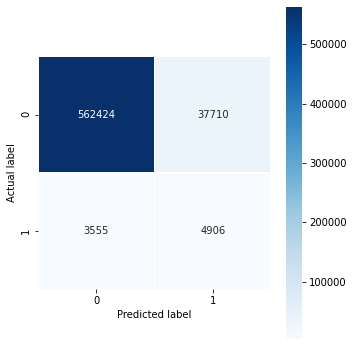

[0]	validation_0-aucpr:0.195367
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.229324
[2]	validation_0-aucpr:0.232746
[3]	validation_0-aucpr:0.240047
[4]	validation_0-aucpr:0.246319
[5]	validation_0-aucpr:0.248095
[6]	validation_0-aucpr:0.240246
[7]	validation_0-aucpr:0.247085
[8]	validation_0-aucpr:0.249453
[9]	validation_0-aucpr:0.24845
[10]	validation_0-aucpr:0.248737
[11]	validation_0-aucpr:0.251545
[12]	validation_0-aucpr:0.253636
[13]	validation_0-aucpr:0.254936
[14]	validation_0-aucpr:0.256609
[15]	validation_0-aucpr:0.257538
[16]	validation_0-aucpr:0.256823
[17]	validation_0-aucpr:0.259061
[18]	validation_0-aucpr:0.25761
[19]	validation_0-aucpr:0.256595
[20]	validation_0-aucpr:0.258305
[21]	validation_0-aucpr:0.25777
[22]	validation_0-aucpr:0.257777
[23]	validation_0-aucpr:0.257925
[24]	validation_0-aucpr:0.259163
[25]	validation_0-aucpr:0.259239
[26]	validation_0-aucpr:0.257548
[27]	validation_0-aucpr:0.257401
[28]	validation_0-aucpr

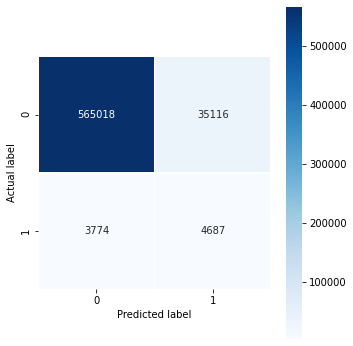

[0]	validation_0-aucpr:0.276581
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.306358
[2]	validation_0-aucpr:0.305557
[3]	validation_0-aucpr:0.317014
[4]	validation_0-aucpr:0.332176
[5]	validation_0-aucpr:0.337129
[6]	validation_0-aucpr:0.337581
[7]	validation_0-aucpr:0.346212
[8]	validation_0-aucpr:0.358117
[9]	validation_0-aucpr:0.361182
[10]	validation_0-aucpr:0.367608
[11]	validation_0-aucpr:0.363138
[12]	validation_0-aucpr:0.369087
[13]	validation_0-aucpr:0.372812
[14]	validation_0-aucpr:0.374789
[15]	validation_0-aucpr:0.377627
[16]	validation_0-aucpr:0.379613
[17]	validation_0-aucpr:0.377398
[18]	validation_0-aucpr:0.375204
[19]	validation_0-aucpr:0.37529
[20]	validation_0-aucpr:0.373945
[21]	validation_0-aucpr:0.375215
[22]	validation_0-aucpr:0.373737
[23]	validation_0-aucpr:0.375708
[24]	validation_0-aucpr:0.374762
[25]	validation_0-aucpr:0.374874
[26]	validation_0-aucpr:0.375386
Stopping. Best iteration:
[16]	validation_0-aucpr:0.37

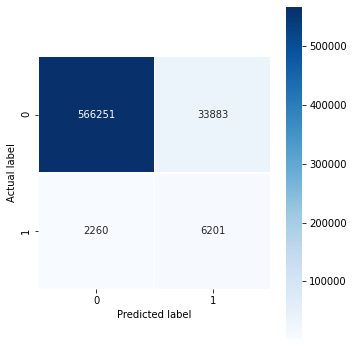

[0]	validation_0-aucpr:0.190344
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.188123
[2]	validation_0-aucpr:0.200345
[3]	validation_0-aucpr:0.212099
[4]	validation_0-aucpr:0.221858
[5]	validation_0-aucpr:0.221005
[6]	validation_0-aucpr:0.224818
[7]	validation_0-aucpr:0.224777
[8]	validation_0-aucpr:0.212679
[9]	validation_0-aucpr:0.213523
[10]	validation_0-aucpr:0.212085
[11]	validation_0-aucpr:0.220803
[12]	validation_0-aucpr:0.221068
[13]	validation_0-aucpr:0.219768
[14]	validation_0-aucpr:0.223118
[15]	validation_0-aucpr:0.222872
[16]	validation_0-aucpr:0.220196
Stopping. Best iteration:
[6]	validation_0-aucpr:0.224818

Prediction Report of trial 35
               precision    recall  f1-score   support

           0       0.99      0.95      0.97    600134
           1       0.15      0.63      0.24      8461

    accuracy                           0.94    608595
   macro avg       0.57      0.79      0.61    608595
weighted avg       0.

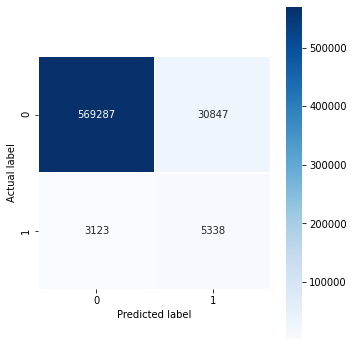

[0]	validation_0-aucpr:0.202067
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.222416
[2]	validation_0-aucpr:0.233264
[3]	validation_0-aucpr:0.246574
[4]	validation_0-aucpr:0.258159
[5]	validation_0-aucpr:0.254958
[6]	validation_0-aucpr:0.262171
[7]	validation_0-aucpr:0.267055
[8]	validation_0-aucpr:0.277074
[9]	validation_0-aucpr:0.27834
[10]	validation_0-aucpr:0.283348
[11]	validation_0-aucpr:0.28216
[12]	validation_0-aucpr:0.283573
[13]	validation_0-aucpr:0.283183
[14]	validation_0-aucpr:0.275737
[15]	validation_0-aucpr:0.276867
[16]	validation_0-aucpr:0.27604
[17]	validation_0-aucpr:0.275135
[18]	validation_0-aucpr:0.273411
[19]	validation_0-aucpr:0.273899
[20]	validation_0-aucpr:0.272047
[21]	validation_0-aucpr:0.2731
[22]	validation_0-aucpr:0.270494
Stopping. Best iteration:
[12]	validation_0-aucpr:0.283573

Prediction Report of trial 36
               precision    recall  f1-score   support

           0       1.00      0.94      0.96 

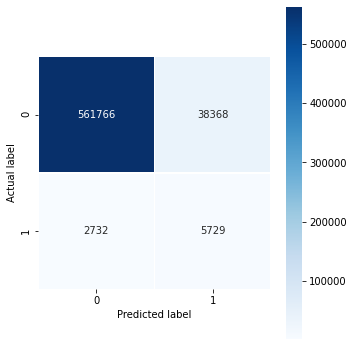

[0]	validation_0-aucpr:0.163106
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.188146
[2]	validation_0-aucpr:0.193602
[3]	validation_0-aucpr:0.21039
[4]	validation_0-aucpr:0.219095
[5]	validation_0-aucpr:0.217732
[6]	validation_0-aucpr:0.217592
[7]	validation_0-aucpr:0.217439
[8]	validation_0-aucpr:0.217136
[9]	validation_0-aucpr:0.224413
[10]	validation_0-aucpr:0.227035
[11]	validation_0-aucpr:0.23306
[12]	validation_0-aucpr:0.234283
[13]	validation_0-aucpr:0.236827
[14]	validation_0-aucpr:0.240677
[15]	validation_0-aucpr:0.241479
[16]	validation_0-aucpr:0.244142
[17]	validation_0-aucpr:0.249165
[18]	validation_0-aucpr:0.248174
[19]	validation_0-aucpr:0.251952
[20]	validation_0-aucpr:0.253631
[21]	validation_0-aucpr:0.252836
[22]	validation_0-aucpr:0.252224
[23]	validation_0-aucpr:0.251907
[24]	validation_0-aucpr:0.252435
[25]	validation_0-aucpr:0.251488
[26]	validation_0-aucpr:0.25019
[27]	validation_0-aucpr:0.250094
[28]	validation_0-aucpr

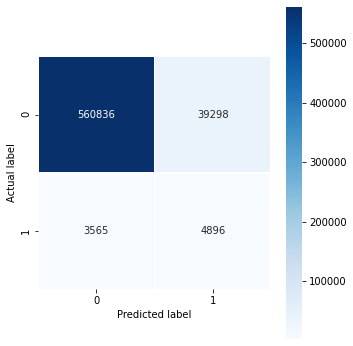

[0]	validation_0-aucpr:0.125366
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.142941
[2]	validation_0-aucpr:0.15134
[3]	validation_0-aucpr:0.163859
[4]	validation_0-aucpr:0.168484
[5]	validation_0-aucpr:0.168435
[6]	validation_0-aucpr:0.16676
[7]	validation_0-aucpr:0.167955
[8]	validation_0-aucpr:0.167036
[9]	validation_0-aucpr:0.165066
[10]	validation_0-aucpr:0.163526
[11]	validation_0-aucpr:0.16466
[12]	validation_0-aucpr:0.163616
[13]	validation_0-aucpr:0.163657
[14]	validation_0-aucpr:0.162114
Stopping. Best iteration:
[4]	validation_0-aucpr:0.168484

Prediction Report of trial 38
               precision    recall  f1-score   support

           0       0.99      0.96      0.97    600134
           1       0.13      0.45      0.21      8461

    accuracy                           0.95    608595
   macro avg       0.56      0.71      0.59    608595
weighted avg       0.98      0.95      0.96    608595



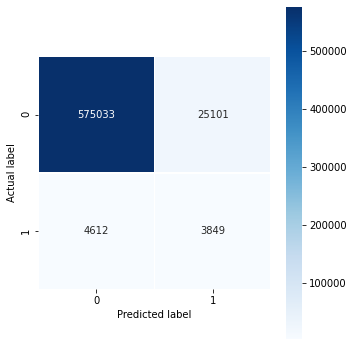

[0]	validation_0-aucpr:0.102162
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.118615
[2]	validation_0-aucpr:0.120886
[3]	validation_0-aucpr:0.131908
[4]	validation_0-aucpr:0.131299
[5]	validation_0-aucpr:0.137925
[6]	validation_0-aucpr:0.139345
[7]	validation_0-aucpr:0.141357
[8]	validation_0-aucpr:0.14138
[9]	validation_0-aucpr:0.142109
[10]	validation_0-aucpr:0.142512
[11]	validation_0-aucpr:0.142213
[12]	validation_0-aucpr:0.141804
[13]	validation_0-aucpr:0.141158
[14]	validation_0-aucpr:0.140598
[15]	validation_0-aucpr:0.143306
[16]	validation_0-aucpr:0.14582
[17]	validation_0-aucpr:0.14601
[18]	validation_0-aucpr:0.146013
[19]	validation_0-aucpr:0.145691
[20]	validation_0-aucpr:0.146854
[21]	validation_0-aucpr:0.147057
[22]	validation_0-aucpr:0.146451
[23]	validation_0-aucpr:0.146761
[24]	validation_0-aucpr:0.146167
[25]	validation_0-aucpr:0.147609
[26]	validation_0-aucpr:0.14738
[27]	validation_0-aucpr:0.147306
[28]	validation_0-aucpr:

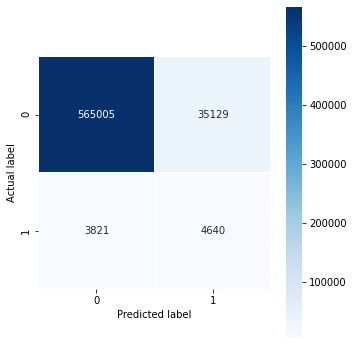

[0]	validation_0-aucpr:0.140748
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.192798
[2]	validation_0-aucpr:0.197848
[3]	validation_0-aucpr:0.196966
[4]	validation_0-aucpr:0.203787
[5]	validation_0-aucpr:0.202987
[6]	validation_0-aucpr:0.202602
[7]	validation_0-aucpr:0.206486
[8]	validation_0-aucpr:0.207657
[9]	validation_0-aucpr:0.209633
[10]	validation_0-aucpr:0.210653
[11]	validation_0-aucpr:0.212478
[12]	validation_0-aucpr:0.212627
[13]	validation_0-aucpr:0.21141
[14]	validation_0-aucpr:0.213969
[15]	validation_0-aucpr:0.212491
[16]	validation_0-aucpr:0.212538
[17]	validation_0-aucpr:0.213403
[18]	validation_0-aucpr:0.213704
[19]	validation_0-aucpr:0.216269
[20]	validation_0-aucpr:0.218379
[21]	validation_0-aucpr:0.220335
[22]	validation_0-aucpr:0.219247
[23]	validation_0-aucpr:0.217613
[24]	validation_0-aucpr:0.217094
[25]	validation_0-aucpr:0.217603
[26]	validation_0-aucpr:0.216974
[27]	validation_0-aucpr:0.220562
[28]	validation_0-auc

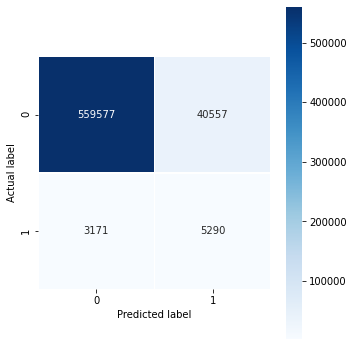

[0]	validation_0-aucpr:0.12729
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.136158
[2]	validation_0-aucpr:0.145799
[3]	validation_0-aucpr:0.157723
[4]	validation_0-aucpr:0.168555
[5]	validation_0-aucpr:0.162276
[6]	validation_0-aucpr:0.167057
[7]	validation_0-aucpr:0.167029
[8]	validation_0-aucpr:0.165148
[9]	validation_0-aucpr:0.169289
[10]	validation_0-aucpr:0.169106
[11]	validation_0-aucpr:0.177218
[12]	validation_0-aucpr:0.177473
[13]	validation_0-aucpr:0.17616
[14]	validation_0-aucpr:0.179369
[15]	validation_0-aucpr:0.178023
[16]	validation_0-aucpr:0.177363
[17]	validation_0-aucpr:0.178777
[18]	validation_0-aucpr:0.178745
[19]	validation_0-aucpr:0.178066
[20]	validation_0-aucpr:0.178162
[21]	validation_0-aucpr:0.180203
[22]	validation_0-aucpr:0.181143
[23]	validation_0-aucpr:0.179874
[24]	validation_0-aucpr:0.180099
[25]	validation_0-aucpr:0.179148
[26]	validation_0-aucpr:0.17756
[27]	validation_0-aucpr:0.178205
[28]	validation_0-aucpr

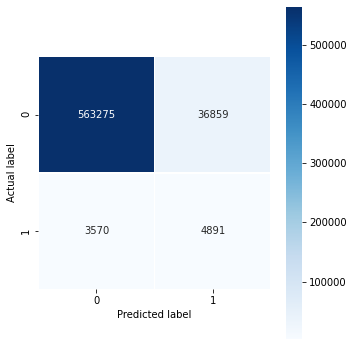

[0]	validation_0-aucpr:0.213513
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.263595
[2]	validation_0-aucpr:0.264832
[3]	validation_0-aucpr:0.27902
[4]	validation_0-aucpr:0.301814
[5]	validation_0-aucpr:0.303708
[6]	validation_0-aucpr:0.307767
[7]	validation_0-aucpr:0.315657
[8]	validation_0-aucpr:0.314284
[9]	validation_0-aucpr:0.319495
[10]	validation_0-aucpr:0.328617
[11]	validation_0-aucpr:0.330379
[12]	validation_0-aucpr:0.332008
[13]	validation_0-aucpr:0.330479
[14]	validation_0-aucpr:0.331239
[15]	validation_0-aucpr:0.332604
[16]	validation_0-aucpr:0.329728
[17]	validation_0-aucpr:0.336077
[18]	validation_0-aucpr:0.335437
[19]	validation_0-aucpr:0.334954
[20]	validation_0-aucpr:0.335876
[21]	validation_0-aucpr:0.333715
[22]	validation_0-aucpr:0.333932
[23]	validation_0-aucpr:0.331497
[24]	validation_0-aucpr:0.333369
[25]	validation_0-aucpr:0.332026
[26]	validation_0-aucpr:0.33212
[27]	validation_0-aucpr:0.330928
Stopping. Best iterati

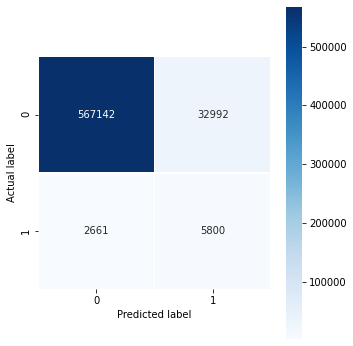

[0]	validation_0-aucpr:0.134028
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.153628
[2]	validation_0-aucpr:0.168603
[3]	validation_0-aucpr:0.166229
[4]	validation_0-aucpr:0.170428
[5]	validation_0-aucpr:0.1705
[6]	validation_0-aucpr:0.172548
[7]	validation_0-aucpr:0.175027
[8]	validation_0-aucpr:0.175217
[9]	validation_0-aucpr:0.175956
[10]	validation_0-aucpr:0.176458
[11]	validation_0-aucpr:0.177422
[12]	validation_0-aucpr:0.181394
[13]	validation_0-aucpr:0.181217
[14]	validation_0-aucpr:0.18096
[15]	validation_0-aucpr:0.180891
[16]	validation_0-aucpr:0.180121
[17]	validation_0-aucpr:0.179469
[18]	validation_0-aucpr:0.178378
[19]	validation_0-aucpr:0.180628
[20]	validation_0-aucpr:0.180371
[21]	validation_0-aucpr:0.182096
[22]	validation_0-aucpr:0.183447
[23]	validation_0-aucpr:0.183173
[24]	validation_0-aucpr:0.184102
[25]	validation_0-aucpr:0.184046
[26]	validation_0-aucpr:0.18283
[27]	validation_0-aucpr:0.184866
[28]	validation_0-aucpr:

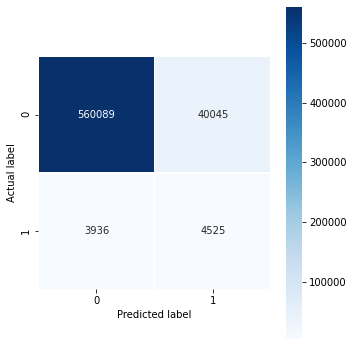

[0]	validation_0-aucpr:0.103517
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.12067
[2]	validation_0-aucpr:0.125463
[3]	validation_0-aucpr:0.116665
[4]	validation_0-aucpr:0.120579
[5]	validation_0-aucpr:0.118549
[6]	validation_0-aucpr:0.117544
[7]	validation_0-aucpr:0.117624
[8]	validation_0-aucpr:0.120312
[9]	validation_0-aucpr:0.121474
[10]	validation_0-aucpr:0.120165
[11]	validation_0-aucpr:0.120476
[12]	validation_0-aucpr:0.122291
Stopping. Best iteration:
[2]	validation_0-aucpr:0.125463

Prediction Report of trial 44
               precision    recall  f1-score   support

           0       0.99      0.94      0.97    600134
           1       0.11      0.50      0.18      8461

    accuracy                           0.94    608595
   macro avg       0.55      0.72      0.57    608595
weighted avg       0.98      0.94      0.96    608595



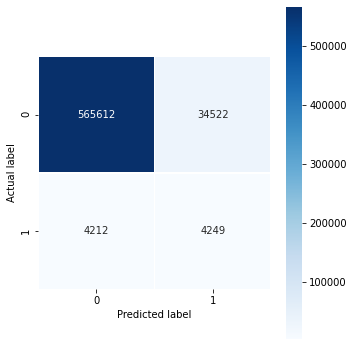

[0]	validation_0-aucpr:0.102355
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.127432
[2]	validation_0-aucpr:0.135716
[3]	validation_0-aucpr:0.132568
[4]	validation_0-aucpr:0.137072
[5]	validation_0-aucpr:0.138668
[6]	validation_0-aucpr:0.139503
[7]	validation_0-aucpr:0.144079
[8]	validation_0-aucpr:0.142616
[9]	validation_0-aucpr:0.142979
[10]	validation_0-aucpr:0.142277
[11]	validation_0-aucpr:0.13937
[12]	validation_0-aucpr:0.134896
[13]	validation_0-aucpr:0.137068
[14]	validation_0-aucpr:0.135117
[15]	validation_0-aucpr:0.134243
[16]	validation_0-aucpr:0.13377
[17]	validation_0-aucpr:0.131508
Stopping. Best iteration:
[7]	validation_0-aucpr:0.144079

Prediction Report of trial 45
               precision    recall  f1-score   support

           0       0.99      0.93      0.96    600134
           1       0.10      0.55      0.17      8461

    accuracy                           0.93    608595
   macro avg       0.55      0.74      0.57 

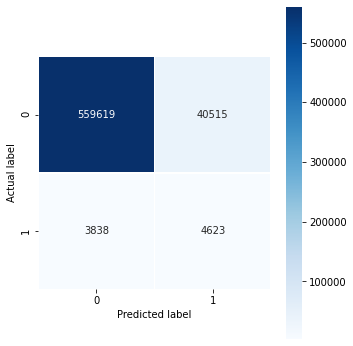

[0]	validation_0-aucpr:0.166072
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.188594
[2]	validation_0-aucpr:0.203585
[3]	validation_0-aucpr:0.212447
[4]	validation_0-aucpr:0.210774
[5]	validation_0-aucpr:0.201038
[6]	validation_0-aucpr:0.210569
[7]	validation_0-aucpr:0.216579
[8]	validation_0-aucpr:0.217716
[9]	validation_0-aucpr:0.224056
[10]	validation_0-aucpr:0.221706
[11]	validation_0-aucpr:0.224731
[12]	validation_0-aucpr:0.226033
[13]	validation_0-aucpr:0.227606
[14]	validation_0-aucpr:0.229312
[15]	validation_0-aucpr:0.230558
[16]	validation_0-aucpr:0.230671
[17]	validation_0-aucpr:0.231112
[18]	validation_0-aucpr:0.230393
[19]	validation_0-aucpr:0.230038
[20]	validation_0-aucpr:0.229652
[21]	validation_0-aucpr:0.228433
[22]	validation_0-aucpr:0.229004
[23]	validation_0-aucpr:0.227817
[24]	validation_0-aucpr:0.226073
[25]	validation_0-aucpr:0.225923
[26]	validation_0-aucpr:0.225324
[27]	validation_0-aucpr:0.224526
Stopping. Best itera

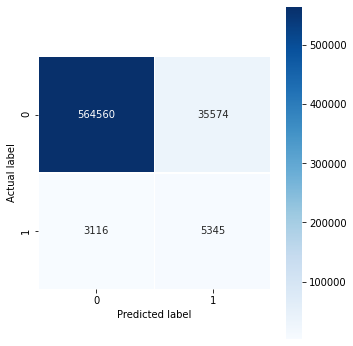

[0]	validation_0-aucpr:0.139262
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.159094
[2]	validation_0-aucpr:0.162295
[3]	validation_0-aucpr:0.168525
[4]	validation_0-aucpr:0.187665
[5]	validation_0-aucpr:0.191134
[6]	validation_0-aucpr:0.196285
[7]	validation_0-aucpr:0.197706
[8]	validation_0-aucpr:0.201061
[9]	validation_0-aucpr:0.201593
[10]	validation_0-aucpr:0.202823
[11]	validation_0-aucpr:0.199747
[12]	validation_0-aucpr:0.200513
[13]	validation_0-aucpr:0.202869
[14]	validation_0-aucpr:0.203037
[15]	validation_0-aucpr:0.205064
[16]	validation_0-aucpr:0.204732
[17]	validation_0-aucpr:0.204747
[18]	validation_0-aucpr:0.201842
[19]	validation_0-aucpr:0.202026
[20]	validation_0-aucpr:0.201496
[21]	validation_0-aucpr:0.20033
[22]	validation_0-aucpr:0.201115
[23]	validation_0-aucpr:0.201228
[24]	validation_0-aucpr:0.202922
[25]	validation_0-aucpr:0.201862
Stopping. Best iteration:
[15]	validation_0-aucpr:0.205064

Prediction Report of trial 

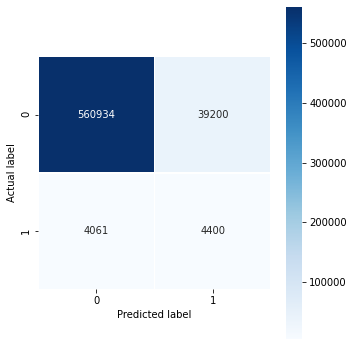

[0]	validation_0-aucpr:0.15457
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.176824
[2]	validation_0-aucpr:0.168153
[3]	validation_0-aucpr:0.177208
[4]	validation_0-aucpr:0.179962
[5]	validation_0-aucpr:0.180425
[6]	validation_0-aucpr:0.180959
[7]	validation_0-aucpr:0.183361
[8]	validation_0-aucpr:0.181361
[9]	validation_0-aucpr:0.181
[10]	validation_0-aucpr:0.179731
[11]	validation_0-aucpr:0.181354
[12]	validation_0-aucpr:0.182307
[13]	validation_0-aucpr:0.180915
[14]	validation_0-aucpr:0.179129
[15]	validation_0-aucpr:0.179666
[16]	validation_0-aucpr:0.182065
[17]	validation_0-aucpr:0.182737
Stopping. Best iteration:
[7]	validation_0-aucpr:0.183361

Prediction Report of trial 48
               precision    recall  f1-score   support

           0       0.99      0.93      0.96    600134
           1       0.11      0.56      0.18      8461

    accuracy                           0.93    608595
   macro avg       0.55      0.75      0.57   

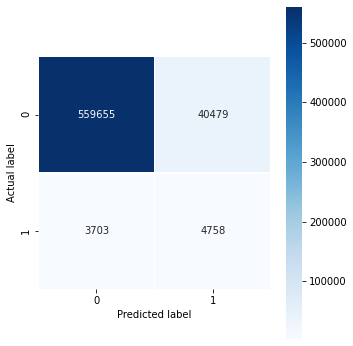

[0]	validation_0-aucpr:0.125025
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.141594
[2]	validation_0-aucpr:0.14451
[3]	validation_0-aucpr:0.147325
[4]	validation_0-aucpr:0.152202
[5]	validation_0-aucpr:0.153928
[6]	validation_0-aucpr:0.155903
[7]	validation_0-aucpr:0.159803
[8]	validation_0-aucpr:0.160105
[9]	validation_0-aucpr:0.161007
[10]	validation_0-aucpr:0.160134
[11]	validation_0-aucpr:0.160067
[12]	validation_0-aucpr:0.159125
[13]	validation_0-aucpr:0.161925
[14]	validation_0-aucpr:0.16179
[15]	validation_0-aucpr:0.1608
[16]	validation_0-aucpr:0.16225
[17]	validation_0-aucpr:0.162292
[18]	validation_0-aucpr:0.161675
[19]	validation_0-aucpr:0.162174
[20]	validation_0-aucpr:0.161647
[21]	validation_0-aucpr:0.160257
[22]	validation_0-aucpr:0.160038
[23]	validation_0-aucpr:0.158333
[24]	validation_0-aucpr:0.157399
[25]	validation_0-aucpr:0.157979
[26]	validation_0-aucpr:0.15746
[27]	validation_0-aucpr:0.156607
Stopping. Best iteration:


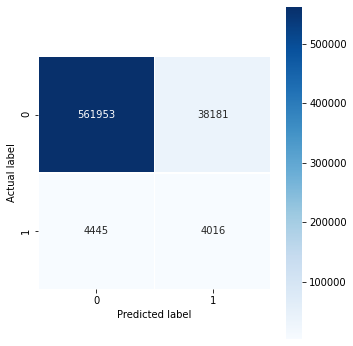

[0]	validation_0-aucpr:0.198687
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.229777
[2]	validation_0-aucpr:0.236542
[3]	validation_0-aucpr:0.242593
[4]	validation_0-aucpr:0.246516
[5]	validation_0-aucpr:0.252689
[6]	validation_0-aucpr:0.25109
[7]	validation_0-aucpr:0.256267
[8]	validation_0-aucpr:0.254729
[9]	validation_0-aucpr:0.257354
[10]	validation_0-aucpr:0.257236
[11]	validation_0-aucpr:0.26048
[12]	validation_0-aucpr:0.262302
[13]	validation_0-aucpr:0.262847
[14]	validation_0-aucpr:0.263635
[15]	validation_0-aucpr:0.264089
[16]	validation_0-aucpr:0.263209
[17]	validation_0-aucpr:0.263126
[18]	validation_0-aucpr:0.263219
[19]	validation_0-aucpr:0.26319
[20]	validation_0-aucpr:0.262819
[21]	validation_0-aucpr:0.261972
[22]	validation_0-aucpr:0.261461
[23]	validation_0-aucpr:0.26267
[24]	validation_0-aucpr:0.262312
[25]	validation_0-aucpr:0.2626
Stopping. Best iteration:
[15]	validation_0-aucpr:0.264089

Prediction Report of trial 50
  

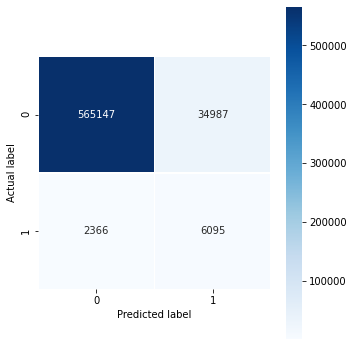

In [47]:
# xgboost 

shuffled_flow_id_loss = flow_id_loss.copy()
shuffled_flow_id_no_loss = flow_id_no_loss.copy()

recall_0_list_xgb = []
recall_1_list_xgb = []
recall_avg_list_xgb = []

for trial in range(1, 51):
    random.seed(trial)
    
    random.shuffle(shuffled_flow_id_loss)
    random.shuffle(shuffled_flow_id_no_loss)
    
    df_loss_new = pd.concat([df_loss[df_loss['flow_id']==x] for x in shuffled_flow_id_loss])
    df_no_loss_new = pd.concat([df_no_loss[df_no_loss['flow_id']==x] for x in shuffled_flow_id_no_loss])
            
    df_train = pd.concat([df_loss_new.iloc[0:int(df_loss_new.shape[0] * 0.7)], df_no_loss_new.iloc[0:int(df_no_loss_new.shape[0] * 0.7)]])
    df_train_shuffled = df_train.sample(frac=1).reset_index()
    df_train_shuffled.drop(['index'], axis=1, inplace=True)
    df_test = pd.concat([df_loss_new.iloc[int(df_loss_new.shape[0] * 0.7)+1: -1], df_no_loss_new.iloc[int(df_no_loss_new.shape[0] * 0.7)+1: -1]])
    df_test_shuffled = df_test.sample(frac=1).reset_index()
    df_test_shuffled.drop(['index'], axis=1, inplace=True)

    x_train = df_train_shuffled[full_features_list_removing_500ms]
    x_test = df_test_shuffled[full_features_list_removing_500ms]
    y_train = df_train_shuffled[['lossOrNot']]
    y_train = y_train.astype(int)
    y_test = df_test_shuffled[['lossOrNot']]
    y_test = y_test.astype(int)
    
    clf_xgb_check = xgb.XGBClassifier(
        n_estimators=500, 
        objective='binary:logistic', 
        scale_pos_weight=weight, 
        n_jobs=48
    )
    
    clf_xgb_check.fit(x_train, y_train, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(x_test, y_test)])
            
    y_pred = clf_xgb_check.predict(x_test)
    print(f"Prediction Report of trial {trial}\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
    report = classification_report(y_test, y_pred, output_dict=True)
    recall_0_list_xgb.append(report['0']['recall'])
    recall_1_list_xgb.append(report['1']['recall'])
    recall_avg_list_xgb.append(report['macro avg']['recall'])

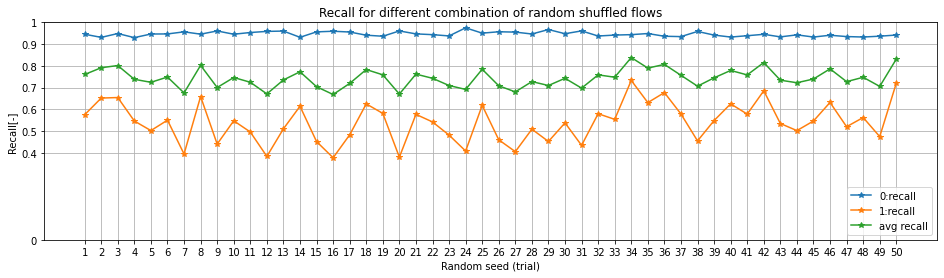

The best performance is at trial 34:
   recall of class 0: 0.9435409425228366
   recall of class 1: 0.7328920931331994
   macro average recall: 0.838216517828018
                   OR
The best performance is at trial 50:
   recall of class 0: 0.9417013533644153
   recall of class 1: 0.7203640231651105
   macro average recall: 0.831032688264763

The average is 0.946119433326557 (0:recall), 0.5397328920931332 (1:recall), 0.7429261627098451 (avg recall)


In [325]:
x_label = list(range(1,51))
plt.figure(figsize=(16,4))
plt.plot(x_label, recall_0_list_xgb, '*-', label='0:recall')
plt.plot(x_label, recall_1_list_xgb, '*-', label='1:recall')
plt.plot(x_label, recall_avg_list_xgb, '*-', label='avg recall')
plt.xticks(x_label, x_label)
plt.legend(loc=4)
plt.grid()
plt.ylim([0,1])
plt.yticks([0, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], [0, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.title('Recall for different combination of random shuffled flows')
plt.xlabel('Random seed (trial)')
plt.ylabel('Recall[-]')
plt.show()

print(f'The best performance is at trial 34:\n   recall of class 0: {recall_0_list_xgb[33]}\n   recall of class 1: {recall_1_list_xgb[33]}\n   macro average recall: {recall_avg_list_xgb[33]}')
print('                   OR')
print(f'The best performance is at trial 50:\n   recall of class 0: {recall_0_list_xgb[49]}\n   recall of class 1: {recall_1_list_xgb[49]}\n   macro average recall: {recall_avg_list_xgb[49]}')
print()
print(f'The average is {np.array(recall_0_list_xgb).mean()} (0:recall), {np.array(recall_1_list_xgb).mean()} (1:recall), {np.array(recall_avg_list_xgb).mean()} (avg recall)')

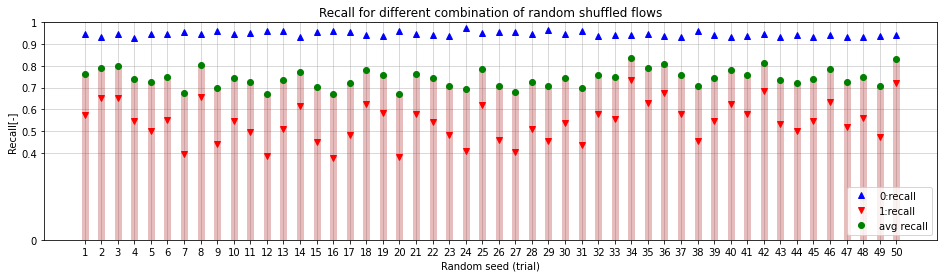

In [282]:
x_label = list(range(1,51))
plt.figure(figsize=(16,4))
plt.plot(x_label, recall_0_list_xgb, '^', label='0:recall', color='b')
plt.plot(x_label, recall_1_list_xgb, 'v', label='1:recall', color='r')
plt.plot(x_label, recall_avg_list_xgb, 'o', label='avg recall', color='g')
plt.vlines(x=x_label, ymin=0, ymax=recall_avg_list_xgb, linestyles='solid', color='firebrick', alpha=0.3, linewidth=7)
plt.xticks(x_label, x_label)
plt.legend(loc=4)
plt.grid(alpha=0.6)
plt.ylim([0,1])
plt.yticks([0, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], [0, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.title('Recall for different combination of random shuffled flows')
plt.xlabel('Random seed (trial)')
plt.ylabel('Recall[-]')
plt.show()

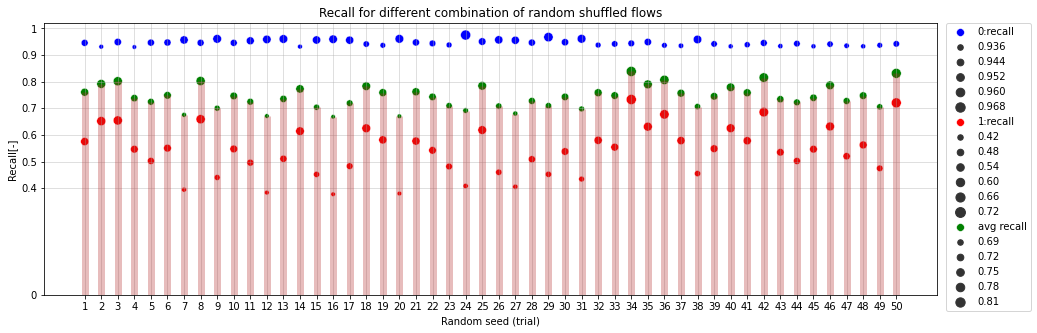

In [260]:
plt.figure(figsize=(16,5))
sns.scatterplot(x=x_label, y=recall_0_list_xgb, label='0:recall', size=recall_0_list_xgb, sizes=(20, 100), color='b')
sns.scatterplot(x=x_label, y=recall_1_list_xgb, label='1:recall', size=recall_1_list_xgb, sizes=(20, 100), color='r')
sns.scatterplot(x=x_label, y=recall_avg_list_xgb, label='avg recall', size=recall_avg_list_xgb, sizes=(20, 100), color='g')
plt.vlines(x=x_label, ymin=0, ymax=recall_avg_list_xgb, linestyles='solid', color='firebrick', alpha=0.3, linewidth=7)
plt.xticks(x_label, x_label)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.grid(alpha=0.5)
plt.ylim([0,1.02])
plt.yticks([0, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], [0, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.title('Recall for different combination of random shuffled flows')
plt.xlabel('Random seed (trial)')
plt.ylabel('Recall[-]')
plt.show()

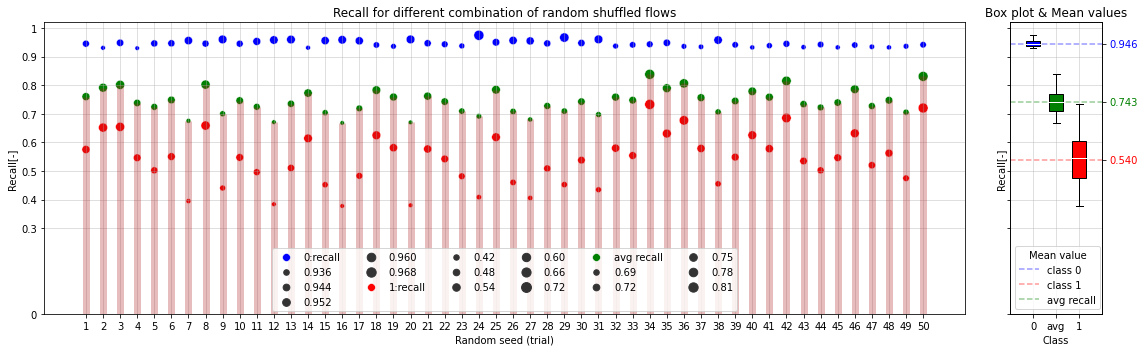

In [479]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), sharey=True, gridspec_kw={'width_ratios': [10, 1]})

sns.scatterplot(x=x_label, y=recall_0_list_xgb, label='0:recall', size=recall_0_list_xgb, sizes=(20, 100), color='b', ax=ax1)
sns.scatterplot(x=x_label, y=recall_1_list_xgb, label='1:recall', size=recall_1_list_xgb, sizes=(20, 100), color='r', ax=ax1)
sns.scatterplot(x=x_label, y=recall_avg_list_xgb, label='avg recall', size=recall_avg_list_xgb, sizes=(20, 100), color='g', ax=ax1)
ax1.vlines(x=x_label, ymin=0, ymax=recall_avg_list_xgb, linestyles='solid', color='firebrick', alpha=0.3, linewidth=7)
ax1.set_xticks(x_label)
ax1.legend(loc='lower center', bbox_to_anchor=(0.5, 0.01), borderaxespad=0, ncol=6)
ax1.grid(alpha=0.5)
plt.ylim([0,1.02])
plt.yticks([0, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], [0, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax1.set_xlabel('Random seed (trial)')
ax1.set_ylabel('Recall[-]')
ax1.set_title('Recall for different combination of random shuffled flows')

box = ax2.boxplot([recall_0_list_xgb, recall_1_list_xgb, recall_avg_list_xgb], positions=[1, 2, 1.5], widths=0.3, patch_artist=True) # meanline=True, showmeans=True
ax2.set_title('Box plot & Mean values')
ax2.set_xticks([1, 2, 1.5])
ax2.set_xticklabels(['0', '1', 'avg'])
ax2.set_xlabel('Class')
ax2.grid(alpha=0.5)
ax2.set_ylabel('Recall[-]')
# ax2.yaxis.set_label_position("right")
colors = ['blue', 'red', 'green']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
for median in box['medians']:
    median.set_color('white')
ax2.axhline(y=0.946, color='b', linestyle='--', alpha=0.4, label='class 0')
ax2.axhline(y=0.540, color='r', linestyle='--', alpha=0.4, label='class 1')
ax2.axhline(y=0.743, color='g', linestyle='--', alpha=0.4, label='avg recall')
ax2.legend(title='Mean value')
ax3 = ax2.twinx()
ax3.set_yticks([0.946, 0.540, 0.743])
ax3.set_ylim([0,1.02])
ax3.get_yticklabels()[0].set_color("b")
ax3.get_yticklabels()[1].set_color("r")
ax3.get_yticklabels()[2].set_color("g")

plt.tight_layout()
plt.show()

In [506]:
print(recall_0_list_xgb)
print(recall_1_list_xgb)
print(recall_avg_list_xgb)

[0.945398860921061, 0.9309487547780996, 0.9485998127084951, 0.9298556655680231, 0.9463703106306258, 0.9467852179679872, 0.9563514148506833, 0.945713790586769, 0.9604471667994148, 0.9454205227499192, 0.9533337554612803, 0.958414287475797, 0.9599472784411481, 0.9313536643482956, 0.9562597686516678, 0.9591107985883153, 0.9555582586555669, 0.9409681837722909, 0.9361659229438759, 0.9604904904571312, 0.9470201654963725, 0.9434392985566556, 0.9376039351211563, 0.9748239559831637, 0.9504060759763653, 0.9567379951810763, 0.9551750109142292, 0.9464619568296414, 0.9669490480459364, 0.9478216531641267, 0.9607204391019339, 0.9371640333658816, 0.9414864013703607, 0.9435409425228366, 0.9485998127084951, 0.9360676115667501, 0.9345179576561234, 0.958174341063829, 0.9414647395415024, 0.9324200928459311, 0.9385820500088313, 0.9450256109468885, 0.9332732356440395, 0.9424761803197286, 0.9324900772160885, 0.9407232384767402, 0.9346812545198239, 0.9325500638190805, 0.936379208643403, 0.9417013533644153]
[0.5

In [109]:
recall_0_list_xgb

[0.945398860921061,
 0.9309487547780996,
 0.9485998127084951,
 0.9298556655680231,
 0.9463703106306258,
 0.9467852179679872,
 0.9563514148506833,
 0.945713790586769,
 0.9604471667994148,
 0.9454205227499192,
 0.9533337554612803,
 0.958414287475797,
 0.9599472784411481,
 0.9313536643482956,
 0.9562597686516678,
 0.9591107985883153,
 0.9555582586555669,
 0.9409681837722909,
 0.9361659229438759,
 0.9604904904571312,
 0.9470201654963725,
 0.9434392985566556,
 0.9376039351211563,
 0.9748239559831637,
 0.9504060759763653,
 0.9567379951810763,
 0.9551750109142292,
 0.9464619568296414,
 0.9669490480459364,
 0.9478216531641267,
 0.9607204391019339,
 0.9371640333658816,
 0.9414864013703607,
 0.9435409425228366,
 0.9485998127084951,
 0.9360676115667501,
 0.9345179576561234,
 0.958174341063829,
 0.9414647395415024,
 0.9324200928459311,
 0.9385820500088313,
 0.9450256109468885,
 0.9332732356440395,
 0.9424761803197286,
 0.9324900772160885,
 0.9407232384767402,
 0.9346812545198239,
 0.93255006381908

In [110]:
recall_1_list_xgb

[0.5751093251388725,
 0.6518142063585864,
 0.65429618248434,
 0.5462711263444038,
 0.5023046921167711,
 0.5502895638813379,
 0.3945160146554781,
 0.658905566717882,
 0.44025528897293464,
 0.5473348303982981,
 0.4958042784540834,
 0.3835244060985699,
 0.510459756529961,
 0.6141118071149982,
 0.4518378442264508,
 0.37737856045384705,
 0.4828034511287082,
 0.6249852263325848,
 0.581373360122917,
 0.3799787259189221,
 0.5768821652286964,
 0.542134499468148,
 0.48150336839617064,
 0.40834416735610446,
 0.618248433991254,
 0.4598747193003191,
 0.40538943387306464,
 0.5086869164401371,
 0.45219241224441553,
 0.537761493913249,
 0.434345822006855,
 0.5798368987117362,
 0.5539534334003073,
 0.7328920931331994,
 0.6308946932986644,
 0.6771067249734074,
 0.5786550053185203,
 0.45491076704881217,
 0.5483985344521924,
 0.625221605011228,
 0.5780640586219123,
 0.6854981680652406,
 0.5348067604302092,
 0.5021865027774495,
 0.5463893156837253,
 0.6317220186739156,
 0.52003309301501,
 0.562344876492140

In [111]:
recall_avg_list_xgb

[0.7602540930299667,
 0.791381480568343,
 0.8014479975964175,
 0.7380633959562135,
 0.7243375013736985,
 0.7485373909246625,
 0.6754337147530807,
 0.8023096786523255,
 0.7003512278861748,
 0.7463776765741086,
 0.7245690169576818,
 0.6709693467871835,
 0.7352035174855546,
 0.7727327357316469,
 0.7040488064390593,
 0.6682446795210811,
 0.7191808548921376,
 0.7829767050524379,
 0.7587696415333964,
 0.6702346081880266,
 0.7619511653625344,
 0.7427868990124018,
 0.7095536517586635,
 0.691584061669634,
 0.7843272549838096,
 0.7083063572406977,
 0.6802822223936469,
 0.7275744366348893,
 0.7095707301451759,
 0.7427915735386879,
 0.6975331305543945,
 0.7585004660388088,
 0.7477199173853339,
 0.838216517828018,
 0.7897472530035798,
 0.8065871682700787,
 0.7565864814873219,
 0.7065425540563206,
 0.7449316369968475,
 0.7788208489285795,
 0.7583230543153718,
 0.8152618895060646,
 0.7340399980371244,
 0.722331341548589,
 0.7394396964499068,
 0.786222628575328,
 0.7273571737674169,
 0.747447470155610

Prediction Report of trial 50
               precision    recall  f1-score   support

           0       0.99      0.58      0.73    600134
           1       0.02      0.67      0.04      8461

    accuracy                           0.58    608595
   macro avg       0.51      0.62      0.39    608595
weighted avg       0.98      0.58      0.72    608595



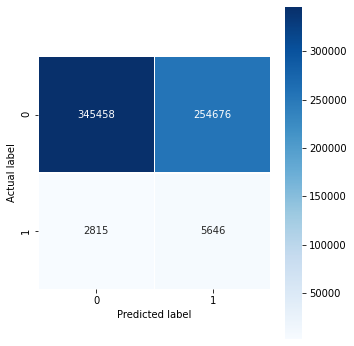

[0]	validation_0-aucpr:0.183185
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.216389
[2]	validation_0-aucpr:0.221386
[3]	validation_0-aucpr:0.224819
[4]	validation_0-aucpr:0.227339
[5]	validation_0-aucpr:0.229754
[6]	validation_0-aucpr:0.232672
[7]	validation_0-aucpr:0.234851
[8]	validation_0-aucpr:0.242308
[9]	validation_0-aucpr:0.244662
[10]	validation_0-aucpr:0.245308
[11]	validation_0-aucpr:0.243794
[12]	validation_0-aucpr:0.242169
[13]	validation_0-aucpr:0.242233
[14]	validation_0-aucpr:0.243953
[15]	validation_0-aucpr:0.245613
[16]	validation_0-aucpr:0.244139
[17]	validation_0-aucpr:0.244783
[18]	validation_0-aucpr:0.246014
[19]	validation_0-aucpr:0.249101
[20]	validation_0-aucpr:0.248541
[21]	validation_0-aucpr:0.246826
[22]	validation_0-aucpr:0.247971
[23]	validation_0-aucpr:0.248079
[24]	validation_0-aucpr:0.244268
[25]	validation_0-aucpr:0.242369
[26]	validation_0-aucpr:0.242866
[27]	validation_0-aucpr:0.242347
[28]	validation_0-au

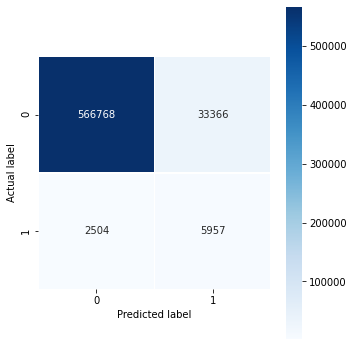

In [103]:
# # check how old best features behave for both models at trial 50

# shuffled_flow_id_loss = flow_id_loss.copy()
# shuffled_flow_id_no_loss = flow_id_no_loss.copy()

# for trial in range(1, 51):
#     random.seed(trial)
    
#     random.shuffle(shuffled_flow_id_loss)
#     random.shuffle(shuffled_flow_id_no_loss)
    
#     if trial == 50:
#         df_loss_new = pd.concat([df_loss[df_loss['flow_id']==x] for x in shuffled_flow_id_loss])
#         df_no_loss_new = pd.concat([df_no_loss[df_no_loss['flow_id']==x] for x in shuffled_flow_id_no_loss])

#         df_train = pd.concat([df_loss_new.iloc[0:int(df_loss_new.shape[0] * 0.7)], df_no_loss_new.iloc[0:int(df_no_loss_new.shape[0] * 0.7)]])
#         df_train_shuffled = df_train.sample(frac=1).reset_index()
#         df_train_shuffled.drop(['index'], axis=1, inplace=True)
#         df_test = pd.concat([df_loss_new.iloc[int(df_loss_new.shape[0] * 0.7)+1: -1], df_no_loss_new.iloc[int(df_no_loss_new.shape[0] * 0.7)+1: -1]])
#         df_test_shuffled = df_test.sample(frac=1).reset_index()
#         df_test_shuffled.drop(['index'], axis=1, inplace=True)

#         x_train = df_train_shuffled[best_feature_list_removing_500ms]
#         x_test = df_test_shuffled[best_feature_list_removing_500ms]
#         y_train = df_train_shuffled[['lossOrNot']]
#         y_train = y_train.astype(int)
#         y_test = df_test_shuffled[['lossOrNot']]
#         y_test = y_test.astype(int)

#         # brf
#         my_brf_model_check = BalancedRandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=0) 
#         my_brf_model_check.fit(x_train, y_train)

#         y_pred = my_brf_model_check.predict(x_test)
#         print(f"Prediction Report of trial {trial}\n", classification_report(y_test, y_pred))
#         cm = confusion_matrix(y_test, y_pred)
#         plt.figure(figsize=(5,5))
#         sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
#         plt.ylabel('Actual label')
#         plt.xlabel('Predicted label')
#         plt.tight_layout()
#         plt.show()
        
#         # xgboost
#         clf_xgb_check = xgb.XGBClassifier(
#             n_estimators=500, 
#             objective='binary:logistic', 
#             scale_pos_weight=weight, 
#             n_jobs=48
#         )
#         clf_xgb_check.fit(x_train, y_train, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(x_test, y_test)])

#         y_pred = clf_xgb_check.predict(x_test)
#         print(f"Prediction Report of trial {trial}\n", classification_report(y_test, y_pred))
#         cm = confusion_matrix(y_test, y_pred)
#         plt.figure(figsize=(5,5))
#         sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
#         plt.ylabel('Actual label')
#         plt.xlabel('Predicted label')
#         plt.tight_layout()
#         plt.show()

### Step 3

In [104]:
df_loss = df_final_with_flow_id_past_loss[df_final_with_flow_id_past_loss['num_packet_loss'] > 2]
df_no_loss = df_final_with_flow_id_past_loss[df_final_with_flow_id_past_loss['lossOrNot'] < 1]

flow_id_loss = df_loss['flow_id'].drop_duplicates().tolist()
flow_id_no_loss = df_no_loss['flow_id'].drop_duplicates().tolist()

Prediction Report of trial 1
               precision    recall  f1-score   support

           0       1.00      0.92      0.96    600134
           1       0.02      0.74      0.04      1291

    accuracy                           0.92    601425
   macro avg       0.51      0.83      0.50    601425
weighted avg       1.00      0.92      0.96    601425



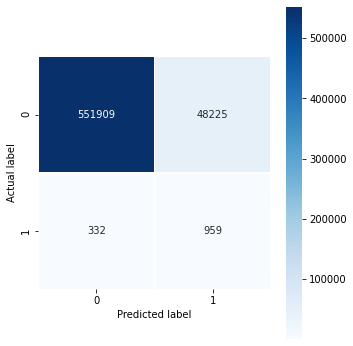

Prediction Report of trial 2
               precision    recall  f1-score   support

           0       1.00      0.85      0.92    600134
           1       0.01      0.85      0.02      1291

    accuracy                           0.85    601425
   macro avg       0.51      0.85      0.47    601425
weighted avg       1.00      0.85      0.92    601425



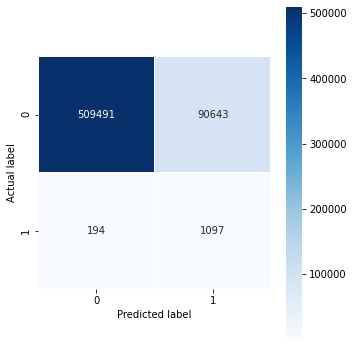

Prediction Report of trial 3
               precision    recall  f1-score   support

           0       1.00      0.91      0.95    600134
           1       0.02      0.77      0.04      1291

    accuracy                           0.91    601425
   macro avg       0.51      0.84      0.50    601425
weighted avg       1.00      0.91      0.95    601425



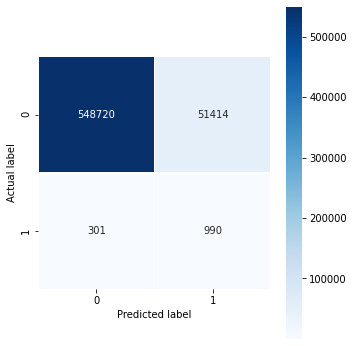

Prediction Report of trial 4
               precision    recall  f1-score   support

           0       1.00      0.87      0.93    600134
           1       0.01      0.83      0.03      1291

    accuracy                           0.87    601425
   macro avg       0.51      0.85      0.48    601425
weighted avg       1.00      0.87      0.93    601425



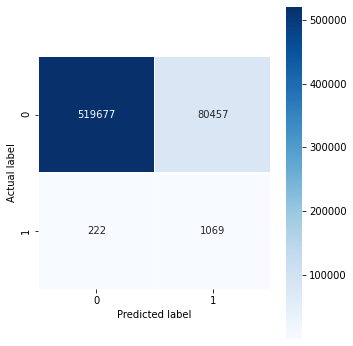

Prediction Report of trial 5
               precision    recall  f1-score   support

           0       1.00      0.90      0.94    600134
           1       0.01      0.68      0.03      1291

    accuracy                           0.90    601425
   macro avg       0.51      0.79      0.49    601425
weighted avg       1.00      0.90      0.94    601425



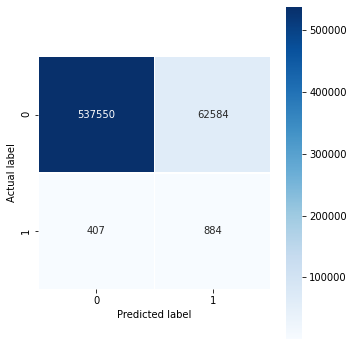

Prediction Report of trial 6
               precision    recall  f1-score   support

           0       1.00      0.85      0.92    600134
           1       0.01      0.88      0.02      1291

    accuracy                           0.85    601425
   macro avg       0.51      0.86      0.47    601425
weighted avg       1.00      0.85      0.91    601425



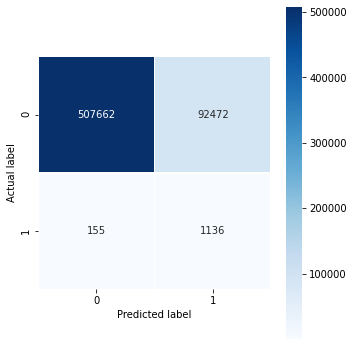

Prediction Report of trial 7
               precision    recall  f1-score   support

           0       1.00      0.92      0.96    600134
           1       0.02      0.69      0.03      1291

    accuracy                           0.92    601425
   macro avg       0.51      0.80      0.50    601425
weighted avg       1.00      0.92      0.95    601425



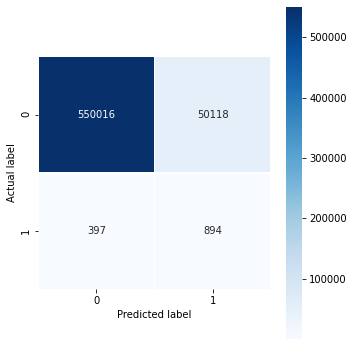

Prediction Report of trial 8
               precision    recall  f1-score   support

           0       1.00      0.86      0.92    600134
           1       0.01      0.78      0.02      1291

    accuracy                           0.86    601425
   macro avg       0.51      0.82      0.47    601425
weighted avg       1.00      0.86      0.92    601425



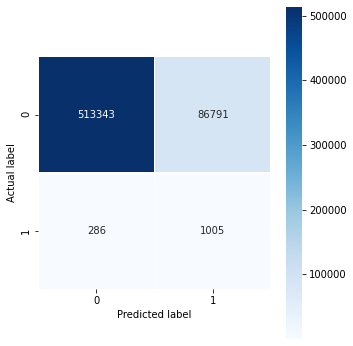

Prediction Report of trial 9
               precision    recall  f1-score   support

           0       1.00      0.91      0.95    600134
           1       0.02      0.71      0.03      1291

    accuracy                           0.91    601425
   macro avg       0.51      0.81      0.49    601425
weighted avg       1.00      0.91      0.95    601425



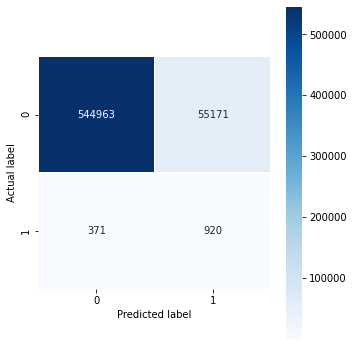

Prediction Report of trial 10
               precision    recall  f1-score   support

           0       1.00      0.91      0.95    600134
           1       0.02      0.78      0.03      1291

    accuracy                           0.91    601425
   macro avg       0.51      0.84      0.49    601425
weighted avg       1.00      0.91      0.95    601425



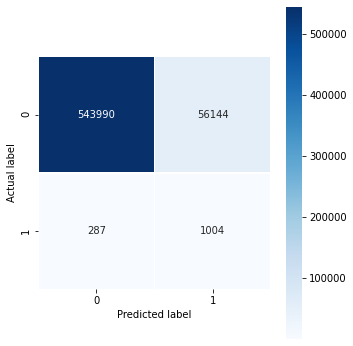

Prediction Report of trial 11
               precision    recall  f1-score   support

           0       1.00      0.89      0.94    600134
           1       0.02      0.80      0.03      1291

    accuracy                           0.89    601425
   macro avg       0.51      0.84      0.49    601425
weighted avg       1.00      0.89      0.94    601425



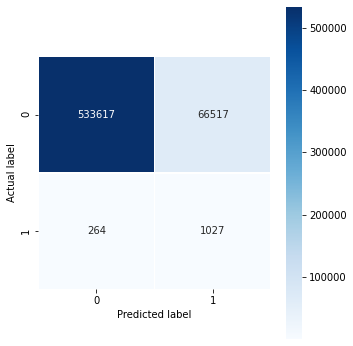

Prediction Report of trial 12
               precision    recall  f1-score   support

           0       1.00      0.85      0.92    600134
           1       0.01      0.78      0.02      1291

    accuracy                           0.85    601425
   macro avg       0.51      0.81      0.47    601425
weighted avg       1.00      0.85      0.92    601425



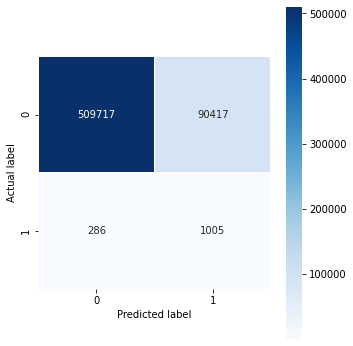

Prediction Report of trial 13
               precision    recall  f1-score   support

           0       1.00      0.90      0.95    600134
           1       0.02      0.78      0.03      1291

    accuracy                           0.90    601425
   macro avg       0.51      0.84      0.49    601425
weighted avg       1.00      0.90      0.94    601425



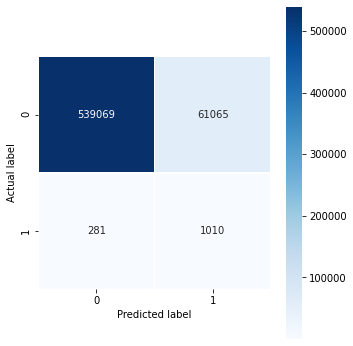

Prediction Report of trial 14
               precision    recall  f1-score   support

           0       1.00      0.88      0.94    600134
           1       0.01      0.82      0.03      1291

    accuracy                           0.88    601425
   macro avg       0.51      0.85      0.48    601425
weighted avg       1.00      0.88      0.94    601425



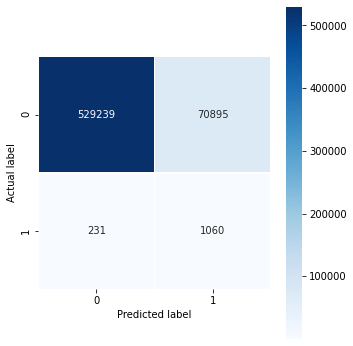

Prediction Report of trial 15
               precision    recall  f1-score   support

           0       1.00      0.87      0.93    600134
           1       0.01      0.80      0.03      1291

    accuracy                           0.87    601425
   macro avg       0.51      0.84      0.48    601425
weighted avg       1.00      0.87      0.93    601425



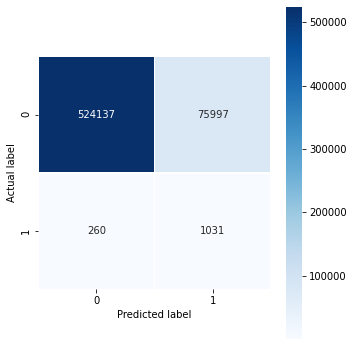

Prediction Report of trial 16
               precision    recall  f1-score   support

           0       1.00      0.85      0.92    600134
           1       0.01      0.78      0.02      1291

    accuracy                           0.85    601425
   macro avg       0.51      0.81      0.47    601425
weighted avg       1.00      0.85      0.92    601425



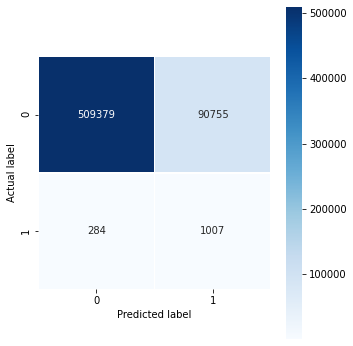

Prediction Report of trial 17
               precision    recall  f1-score   support

           0       1.00      0.92      0.96    600134
           1       0.02      0.70      0.04      1291

    accuracy                           0.92    601425
   macro avg       0.51      0.81      0.50    601425
weighted avg       1.00      0.92      0.96    601425



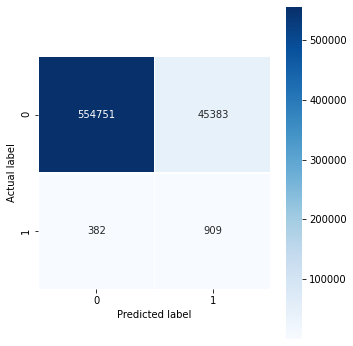

Prediction Report of trial 18
               precision    recall  f1-score   support

           0       1.00      0.84      0.91    600134
           1       0.01      0.79      0.02      1291

    accuracy                           0.84    601425
   macro avg       0.51      0.82      0.47    601425
weighted avg       1.00      0.84      0.91    601425



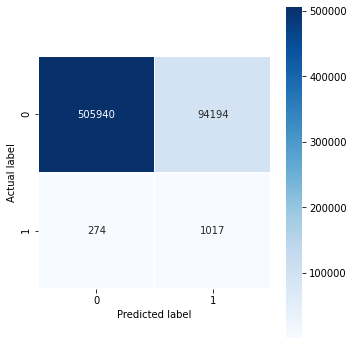

Prediction Report of trial 19
               precision    recall  f1-score   support

           0       1.00      0.90      0.95    600134
           1       0.02      0.91      0.04      1291

    accuracy                           0.90    601425
   macro avg       0.51      0.90      0.49    601425
weighted avg       1.00      0.90      0.94    601425



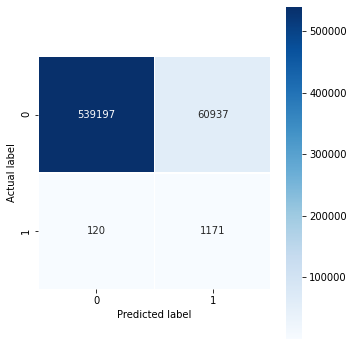

Prediction Report of trial 20
               precision    recall  f1-score   support

           0       1.00      0.90      0.95    600134
           1       0.02      0.79      0.03      1291

    accuracy                           0.90    601425
   macro avg       0.51      0.85      0.49    601425
weighted avg       1.00      0.90      0.95    601425



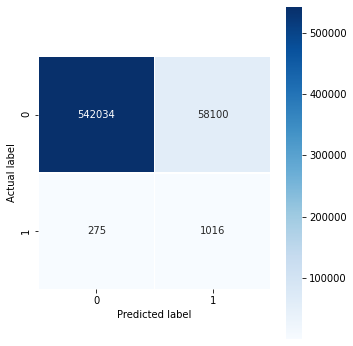

Prediction Report of trial 21
               precision    recall  f1-score   support

           0       1.00      0.88      0.94    600134
           1       0.01      0.71      0.03      1291

    accuracy                           0.88    601425
   macro avg       0.51      0.79      0.48    601425
weighted avg       1.00      0.88      0.94    601425



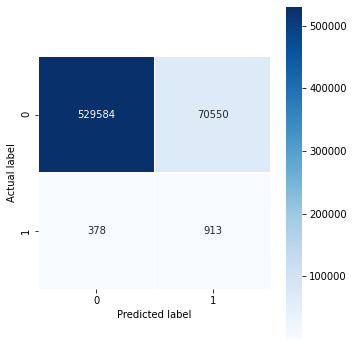

Prediction Report of trial 22
               precision    recall  f1-score   support

           0       1.00      0.86      0.93    600134
           1       0.01      0.75      0.02      1291

    accuracy                           0.86    601425
   macro avg       0.51      0.81      0.47    601425
weighted avg       1.00      0.86      0.92    601425



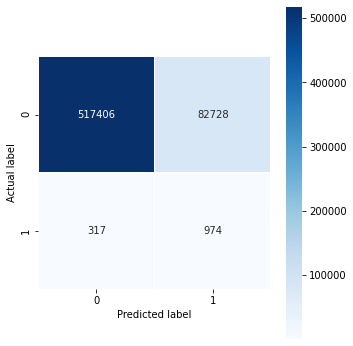

Prediction Report of trial 23
               precision    recall  f1-score   support

           0       1.00      0.90      0.95    600134
           1       0.02      0.78      0.03      1291

    accuracy                           0.90    601425
   macro avg       0.51      0.84      0.49    601425
weighted avg       1.00      0.90      0.94    601425



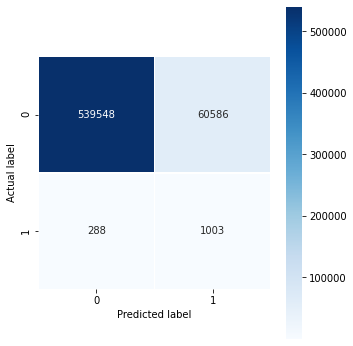

Prediction Report of trial 24
               precision    recall  f1-score   support

           0       1.00      0.85      0.92    600134
           1       0.01      0.76      0.02      1291

    accuracy                           0.85    601425
   macro avg       0.51      0.80      0.47    601425
weighted avg       1.00      0.85      0.92    601425



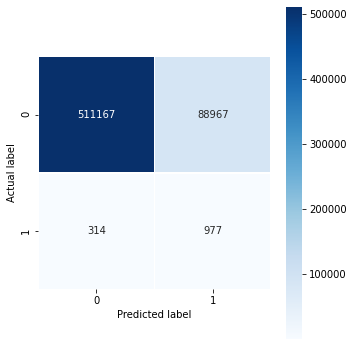

Prediction Report of trial 25
               precision    recall  f1-score   support

           0       1.00      0.89      0.94    600134
           1       0.02      0.77      0.03      1291

    accuracy                           0.89    601425
   macro avg       0.51      0.83      0.49    601425
weighted avg       1.00      0.89      0.94    601425



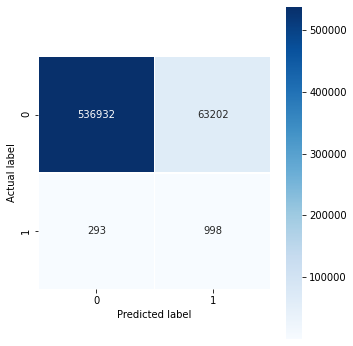

Prediction Report of trial 26
               precision    recall  f1-score   support

           0       1.00      0.92      0.96    600134
           1       0.02      0.75      0.04      1291

    accuracy                           0.92    601425
   macro avg       0.51      0.84      0.50    601425
weighted avg       1.00      0.92      0.96    601425



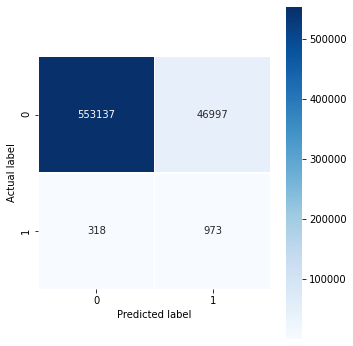

Prediction Report of trial 27
               precision    recall  f1-score   support

           0       1.00      0.86      0.93    600134
           1       0.01      0.79      0.02      1291

    accuracy                           0.86    601425
   macro avg       0.51      0.83      0.47    601425
weighted avg       1.00      0.86      0.92    601425



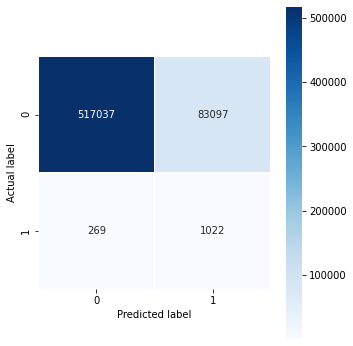

Prediction Report of trial 28
               precision    recall  f1-score   support

           0       1.00      0.90      0.95    600134
           1       0.02      0.74      0.03      1291

    accuracy                           0.90    601425
   macro avg       0.51      0.82      0.49    601425
weighted avg       1.00      0.90      0.95    601425



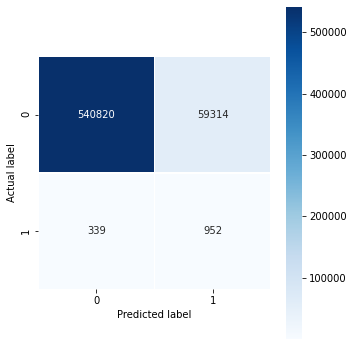

Prediction Report of trial 29
               precision    recall  f1-score   support

           0       1.00      0.87      0.93    600134
           1       0.01      0.69      0.02      1291

    accuracy                           0.87    601425
   macro avg       0.51      0.78      0.48    601425
weighted avg       1.00      0.87      0.93    601425



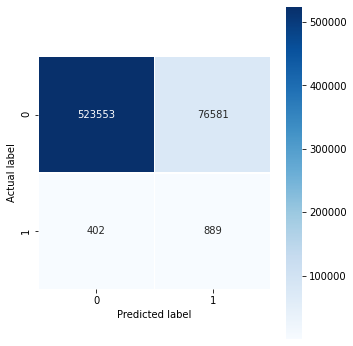

Prediction Report of trial 30
               precision    recall  f1-score   support

           0       1.00      0.90      0.95    600134
           1       0.02      0.75      0.03      1291

    accuracy                           0.90    601425
   macro avg       0.51      0.83      0.49    601425
weighted avg       1.00      0.90      0.95    601425



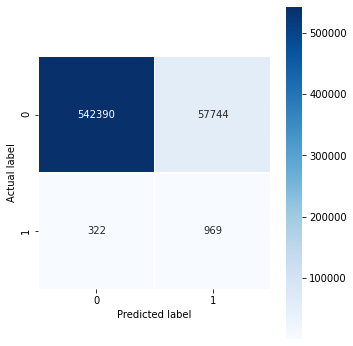

Prediction Report of trial 31
               precision    recall  f1-score   support

           0       1.00      0.91      0.95    600134
           1       0.02      0.77      0.04      1291

    accuracy                           0.91    601425
   macro avg       0.51      0.84      0.49    601425
weighted avg       1.00      0.91      0.95    601425



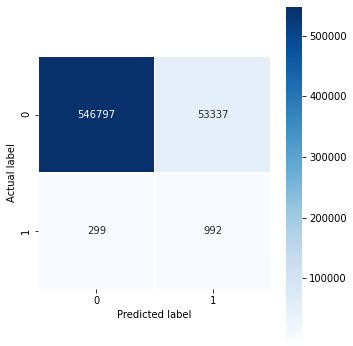

Prediction Report of trial 32
               precision    recall  f1-score   support

           0       1.00      0.88      0.93    600134
           1       0.01      0.73      0.02      1291

    accuracy                           0.88    601425
   macro avg       0.51      0.80      0.48    601425
weighted avg       1.00      0.88      0.93    601425



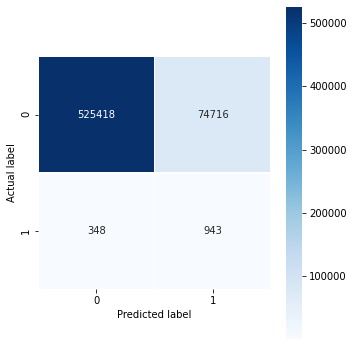

Prediction Report of trial 33
               precision    recall  f1-score   support

           0       1.00      0.86      0.92    600134
           1       0.01      0.80      0.02      1291

    accuracy                           0.86    601425
   macro avg       0.51      0.83      0.47    601425
weighted avg       1.00      0.86      0.92    601425



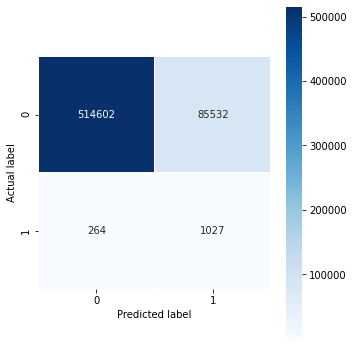

Prediction Report of trial 34
               precision    recall  f1-score   support

           0       1.00      0.88      0.94    600134
           1       0.01      0.71      0.02      1291

    accuracy                           0.88    601425
   macro avg       0.51      0.79      0.48    601425
weighted avg       1.00      0.88      0.93    601425



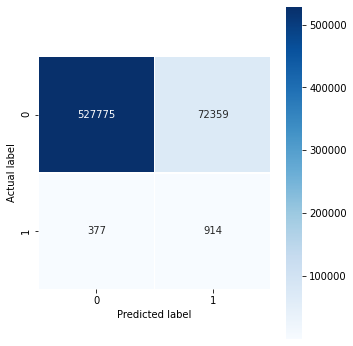

Prediction Report of trial 35
               precision    recall  f1-score   support

           0       1.00      0.88      0.93    600134
           1       0.01      0.68      0.02      1291

    accuracy                           0.88    601425
   macro avg       0.51      0.78      0.48    601425
weighted avg       1.00      0.88      0.93    601425



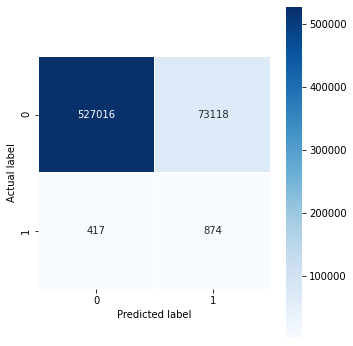

Prediction Report of trial 36
               precision    recall  f1-score   support

           0       1.00      0.93      0.96    600134
           1       0.02      0.69      0.04      1291

    accuracy                           0.93    601425
   macro avg       0.51      0.81      0.50    601425
weighted avg       1.00      0.93      0.96    601425



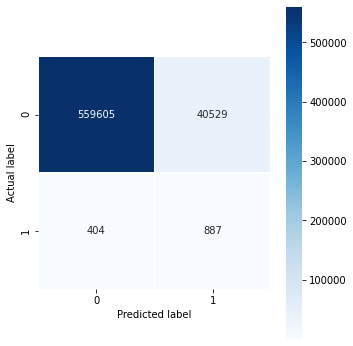

Prediction Report of trial 37
               precision    recall  f1-score   support

           0       1.00      0.84      0.91    600134
           1       0.01      0.84      0.02      1291

    accuracy                           0.84    601425
   macro avg       0.51      0.84      0.47    601425
weighted avg       1.00      0.84      0.91    601425



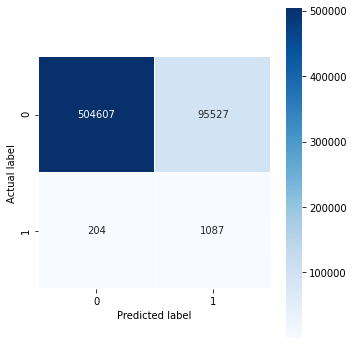

Prediction Report of trial 38
               precision    recall  f1-score   support

           0       1.00      0.88      0.94    600134
           1       0.01      0.80      0.03      1291

    accuracy                           0.88    601425
   macro avg       0.51      0.84      0.48    601425
weighted avg       1.00      0.88      0.93    601425



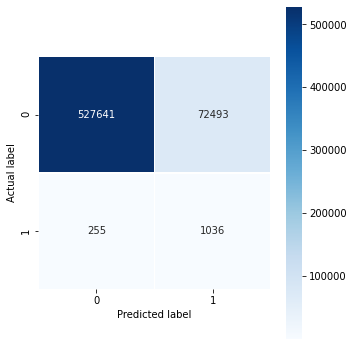

Prediction Report of trial 39
               precision    recall  f1-score   support

           0       1.00      0.86      0.92    600134
           1       0.01      0.83      0.02      1291

    accuracy                           0.86    601425
   macro avg       0.51      0.85      0.47    601425
weighted avg       1.00      0.86      0.92    601425



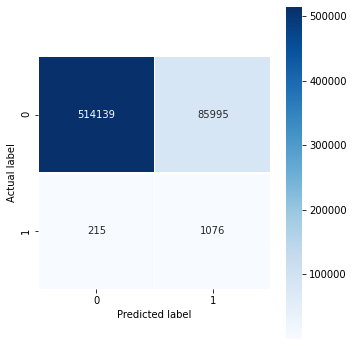

Prediction Report of trial 40
               precision    recall  f1-score   support

           0       1.00      0.82      0.90    600134
           1       0.01      0.84      0.02      1291

    accuracy                           0.82    601425
   macro avg       0.50      0.83      0.46    601425
weighted avg       1.00      0.82      0.90    601425



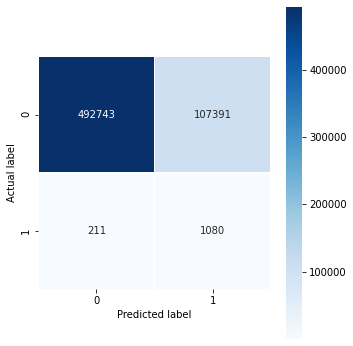

Prediction Report of trial 41
               precision    recall  f1-score   support

           0       1.00      0.93      0.96    600134
           1       0.02      0.68      0.04      1291

    accuracy                           0.93    601425
   macro avg       0.51      0.80      0.50    601425
weighted avg       1.00      0.93      0.96    601425



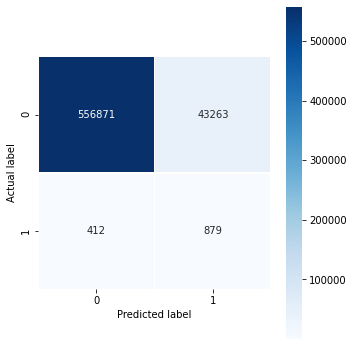

Prediction Report of trial 42
               precision    recall  f1-score   support

           0       1.00      0.85      0.92    600134
           1       0.01      0.82      0.02      1291

    accuracy                           0.85    601425
   macro avg       0.51      0.83      0.47    601425
weighted avg       1.00      0.85      0.92    601425



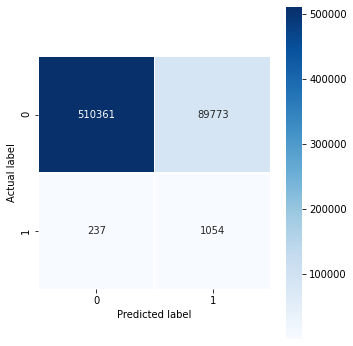

Prediction Report of trial 43
               precision    recall  f1-score   support

           0       1.00      0.86      0.92    600134
           1       0.01      0.82      0.02      1291

    accuracy                           0.86    601425
   macro avg       0.51      0.84      0.47    601425
weighted avg       1.00      0.86      0.92    601425



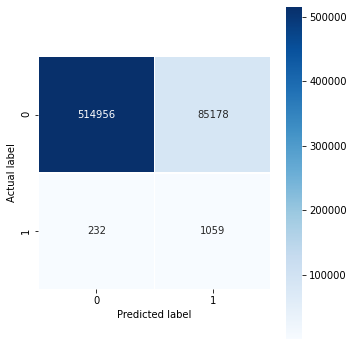

Prediction Report of trial 44
               precision    recall  f1-score   support

           0       1.00      0.87      0.93    600134
           1       0.01      0.71      0.02      1291

    accuracy                           0.87    601425
   macro avg       0.51      0.79      0.48    601425
weighted avg       1.00      0.87      0.93    601425



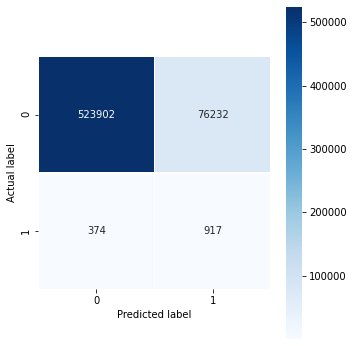

Prediction Report of trial 45
               precision    recall  f1-score   support

           0       1.00      0.92      0.96    600134
           1       0.02      0.76      0.04      1291

    accuracy                           0.92    601425
   macro avg       0.51      0.84      0.50    601425
weighted avg       1.00      0.92      0.95    601425



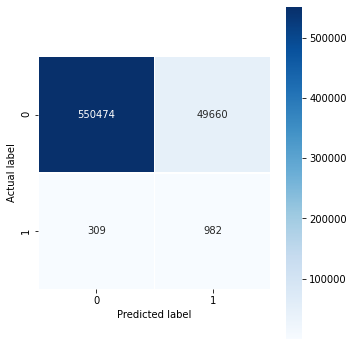

Prediction Report of trial 46
               precision    recall  f1-score   support

           0       1.00      0.89      0.94    600134
           1       0.01      0.76      0.03      1291

    accuracy                           0.89    601425
   macro avg       0.51      0.82      0.48    601425
weighted avg       1.00      0.89      0.94    601425



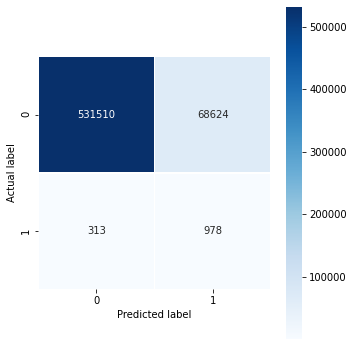

Prediction Report of trial 47
               precision    recall  f1-score   support

           0       1.00      0.88      0.94    600134
           1       0.01      0.71      0.03      1291

    accuracy                           0.88    601425
   macro avg       0.51      0.80      0.48    601425
weighted avg       1.00      0.88      0.94    601425



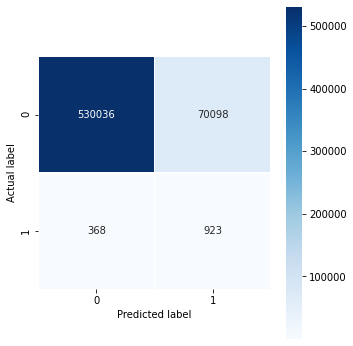

Prediction Report of trial 48
               precision    recall  f1-score   support

           0       1.00      0.87      0.93    600134
           1       0.01      0.80      0.03      1291

    accuracy                           0.87    601425
   macro avg       0.51      0.84      0.48    601425
weighted avg       1.00      0.87      0.93    601425



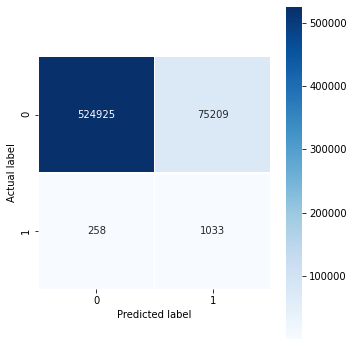

Prediction Report of trial 49
               precision    recall  f1-score   support

           0       1.00      0.88      0.94    600134
           1       0.01      0.84      0.03      1291

    accuracy                           0.88    601425
   macro avg       0.51      0.86      0.48    601425
weighted avg       1.00      0.88      0.93    601425



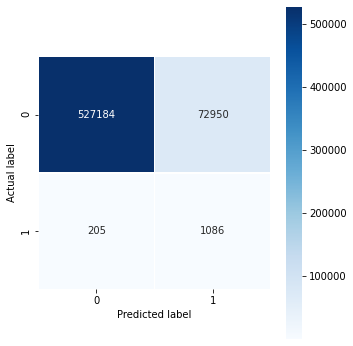

Prediction Report of trial 50
               precision    recall  f1-score   support

           0       1.00      0.91      0.95    600134
           1       0.02      0.83      0.04      1291

    accuracy                           0.91    601425
   macro avg       0.51      0.87      0.49    601425
weighted avg       1.00      0.91      0.95    601425



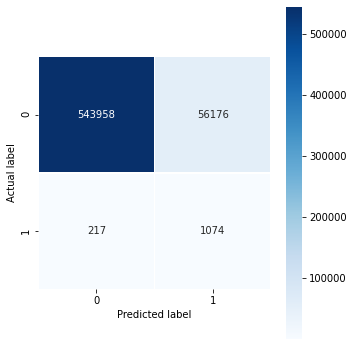

In [112]:
# balanced random forest

shuffled_flow_id_loss = flow_id_loss.copy()
shuffled_flow_id_no_loss = flow_id_no_loss.copy()

recall_0_list_2 = []
recall_1_list_2 = []
recall_avg_list_2 = []

for trial in range(1, 51):
    random.seed(trial)
    
    random.shuffle(shuffled_flow_id_loss)
    random.shuffle(shuffled_flow_id_no_loss)
    
    df_loss_new = pd.concat([df_loss[df_loss['flow_id']==x] for x in shuffled_flow_id_loss])
    df_no_loss_new = pd.concat([df_no_loss[df_no_loss['flow_id']==x] for x in shuffled_flow_id_no_loss])
            
    df_train = pd.concat([df_loss_new.iloc[0:int(df_loss_new.shape[0] * 0.7)], df_no_loss_new.iloc[0:int(df_no_loss_new.shape[0] * 0.7)]])
    df_train_shuffled = df_train.sample(frac=1).reset_index()
    df_train_shuffled.drop(['index'], axis=1, inplace=True)
    df_test = pd.concat([df_loss_new.iloc[int(df_loss_new.shape[0] * 0.7)+1: -1], df_no_loss_new.iloc[int(df_no_loss_new.shape[0] * 0.7)+1: -1]])
    df_test_shuffled = df_test.sample(frac=1).reset_index()
    df_test_shuffled.drop(['index'], axis=1, inplace=True)

    x_train = df_train_shuffled[full_features_list_removing_500ms]
    x_test = df_test_shuffled[full_features_list_removing_500ms]
    y_train = df_train_shuffled[['lossOrNot']]
    y_train = y_train.astype(int)
    y_test = df_test_shuffled[['lossOrNot']]
    y_test = y_test.astype(int)
    
    my_brf_model_check = BalancedRandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=0) 
    my_brf_model_check.fit(x_train, y_train)
            
    y_pred = my_brf_model_check.predict(x_test)
    print(f"Prediction Report of trial {trial}\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
    report = classification_report(y_test, y_pred, output_dict=True)
    recall_0_list_2.append(report['0']['recall'])
    recall_1_list_2.append(report['1']['recall'])
    recall_avg_list_2.append(report['macro avg']['recall'])

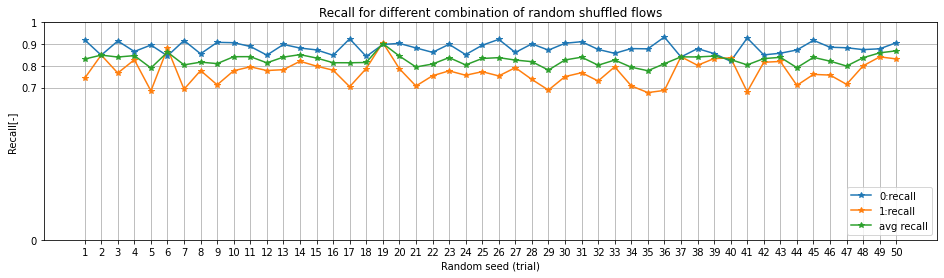

The best performance is at trial 19:
   recall of class 0: 0.8984610103743498
   recall of class 1: 0.9070487993803253
   macro average recall: 0.9027549048773376

The average is 0.8824860781092222 (0:recall), 0.7712161115414407 (1:recall), 0.8268510948253316 (avg recall)


In [326]:
x_label = list(range(1,51))
plt.figure(figsize=(16,4))
plt.plot(x_label, recall_0_list_2, '*-', label='0:recall')
plt.plot(x_label, recall_1_list_2, '*-', label='1:recall')
plt.plot(x_label, recall_avg_list_2, '*-', label='avg recall')
plt.xticks(x_label, x_label)
plt.legend(loc=4)
plt.grid()
plt.ylim([0,1])
plt.yticks([0, 0.7, 0.8, 0.9, 1], [0, 0.7, 0.8, 0.9, 1])
plt.title('Recall for different combination of random shuffled flows')
plt.xlabel('Random seed (trial)')
plt.ylabel('Recall[-]')
plt.show()

print(f'The best performance is at trial 19:\n   recall of class 0: {recall_0_list_2[18]}\n   recall of class 1: {recall_1_list_2[18]}\n   macro average recall: {recall_avg_list_2[18]}')
print()
print(f'The average is {np.array(recall_0_list_2).mean()} (0:recall), {np.array(recall_1_list_2).mean()} (1:recall), {np.array(recall_avg_list_2).mean()} (avg recall)')

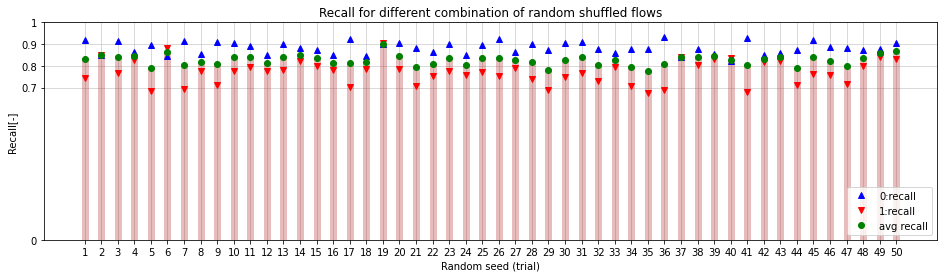

In [281]:
x_label = list(range(1,51))
plt.figure(figsize=(16,4))
plt.plot(x_label, recall_0_list_2, '^', label='0:recall', color='b')
plt.plot(x_label, recall_1_list_2, 'v', label='1:recall', color='r')
plt.plot(x_label, recall_avg_list_2, 'o', label='avg recall', color='g')
plt.vlines(x=x_label, ymin=0, ymax=recall_avg_list_2, linestyles='solid', color='firebrick', alpha=0.3, linewidth=7)
plt.xticks(x_label, x_label)
plt.legend(loc=4)
plt.grid(alpha=0.6)
plt.ylim([0,1])
plt.yticks([0, 0.7, 0.8, 0.9, 1], [0, 0.7, 0.8, 0.9, 1])
plt.title('Recall for different combination of random shuffled flows')
plt.xlabel('Random seed (trial)')
plt.ylabel('Recall[-]')
plt.show()

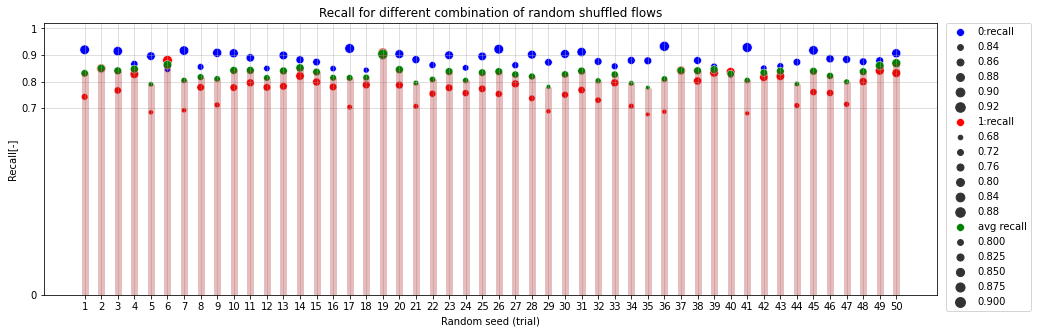

In [277]:
plt.figure(figsize=(16,5))
sns.scatterplot(x=x_label, y=recall_0_list_2, label='0:recall', size=recall_0_list_2, sizes=(20, 100), color='b')
sns.scatterplot(x=x_label, y=recall_1_list_2, label='1:recall', size=recall_1_list_2, sizes=(20, 100), color='r')
sns.scatterplot(x=x_label, y=recall_avg_list_2, label='avg recall', size=recall_avg_list_2, sizes=(20, 100), color='g')
plt.vlines(x=x_label, ymin=0, ymax=recall_avg_list_2, linestyles='solid', color='firebrick', alpha=0.3, linewidth=7)
plt.xticks(x_label, x_label)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.grid(alpha=0.5)
plt.ylim([0,1.02])
plt.yticks([0, 0.7, 0.8, 0.9, 1], [0, 0.7, 0.8, 0.9, 1])
plt.title('Recall for different combination of random shuffled flows')
plt.xlabel('Random seed (trial)')
plt.ylabel('Recall[-]')
plt.show()

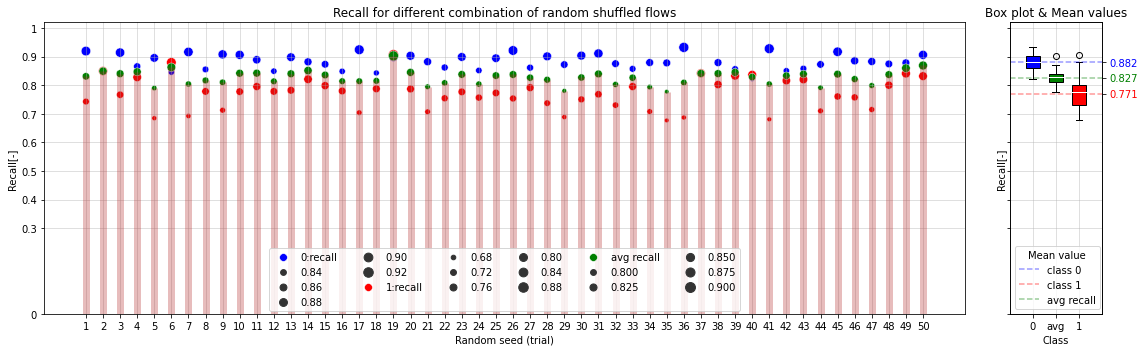

In [489]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), sharey=True, gridspec_kw={'width_ratios': [10, 1]})

sns.scatterplot(x=x_label, y=recall_0_list_2, label='0:recall', size=recall_0_list_2, sizes=(20, 100), color='b', ax=ax1)
sns.scatterplot(x=x_label, y=recall_1_list_2, label='1:recall', size=recall_1_list_2, sizes=(20, 100), color='r', ax=ax1)
sns.scatterplot(x=x_label, y=recall_avg_list_2, label='avg recall', size=recall_avg_list_2, sizes=(20, 100), color='g', ax=ax1)
ax1.vlines(x=x_label, ymin=0, ymax=recall_avg_list_2, linestyles='solid', color='firebrick', alpha=0.3, linewidth=7)
ax1.set_xticks(x_label)
ax1.legend(loc='lower center', bbox_to_anchor=(0.5, 0.01), borderaxespad=0, ncol=6)
ax1.grid(alpha=0.5)
plt.ylim([0,1.02])
plt.yticks([0, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], [0, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax1.set_xlabel('Random seed (trial)')
ax1.set_ylabel('Recall[-]')
ax1.set_title('Recall for different combination of random shuffled flows')

box = ax2.boxplot([recall_0_list_2, recall_1_list_2, recall_avg_list_2], positions=[1, 2, 1.5], widths=0.3, patch_artist=True) # meanline=True, showmeans=True
ax2.set_title('Box plot & Mean values')
ax2.set_xticks([1, 2, 1.5])
ax2.set_xticklabels(['0', '1', 'avg'])
ax2.set_xlabel('Class')
ax2.grid(alpha=0.5)
ax2.set_ylabel('Recall[-]')
# ax2.yaxis.set_label_position("right")
colors = ['blue', 'red', 'green']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
for median in box['medians']:
    median.set_color('white')
ax2.axhline(y=0.882, color='b', linestyle='--', alpha=0.4, label='class 0')
ax2.axhline(y=0.771, color='r', linestyle='--', alpha=0.4, label='class 1')
ax2.axhline(y=0.827, color='g', linestyle='--', alpha=0.4, label='avg recall')
ax2.legend(title='Mean value')
ax3 = ax2.twinx()
ax3.set_yticks([0.882, 0.771, 0.827])
ax3.set_ylim([0,1.02])
ax3.get_yticklabels()[0].set_color("b")
ax3.get_yticklabels()[1].set_color("r")
ax3.get_yticklabels()[2].set_color("g")

plt.tight_layout()
plt.show()

In [507]:
print(recall_0_list_2)
print(recall_1_list_2)
print(recall_avg_list_2)

[0.9196429464086354, 0.8489620651387857, 0.9143291331602609, 0.8659349411964661, 0.8957166232874658, 0.8459144124478867, 0.9164886508679728, 0.8553806316589295, 0.9080688646202348, 0.9064475600449233, 0.88916308691059, 0.8493386477020132, 0.8982477246748226, 0.8818680494689519, 0.8733666147893637, 0.8487754401516995, 0.9243785554559482, 0.8430450532714361, 0.8984610103743498, 0.9031882879490247, 0.8824429210809586, 0.8621507863243876, 0.8990458797535217, 0.8517547747669687, 0.8946868532694365, 0.9216891560884736, 0.8615359236437196, 0.9011654063925724, 0.8723934987852713, 0.9037814888008345, 0.9111248487837716, 0.8755011380791623, 0.8574784964691219, 0.8794285942806107, 0.878163876734196, 0.9324667490927027, 0.8408238826662046, 0.8792053108139182, 0.8567070021028637, 0.8210549643912859, 0.9279110998543658, 0.850411741377759, 0.8580683647318765, 0.8729750355753881, 0.9172518137615933, 0.8856522043410305, 0.8831960862074136, 0.8746796548770774, 0.8784438142148253, 0.9063942386200415]
[0.

In [118]:
recall_0_list_2

[0.9196429464086354,
 0.8489620651387857,
 0.9143291331602609,
 0.8659349411964661,
 0.8957166232874658,
 0.8459144124478867,
 0.9164886508679728,
 0.8553806316589295,
 0.9080688646202348,
 0.9064475600449233,
 0.88916308691059,
 0.8493386477020132,
 0.8982477246748226,
 0.8818680494689519,
 0.8733666147893637,
 0.8487754401516995,
 0.9243785554559482,
 0.8430450532714361,
 0.8984610103743498,
 0.9031882879490247,
 0.8824429210809586,
 0.8621507863243876,
 0.8990458797535217,
 0.8517547747669687,
 0.8946868532694365,
 0.9216891560884736,
 0.8615359236437196,
 0.9011654063925724,
 0.8723934987852713,
 0.9037814888008345,
 0.9111248487837716,
 0.8755011380791623,
 0.8574784964691219,
 0.8794285942806107,
 0.878163876734196,
 0.9324667490927027,
 0.8408238826662046,
 0.8792053108139182,
 0.8567070021028637,
 0.8210549643912859,
 0.9279110998543658,
 0.850411741377759,
 0.8580683647318765,
 0.8729750355753881,
 0.9172518137615933,
 0.8856522043410305,
 0.8831960862074136,
 0.87467965487707

In [119]:
recall_1_list_2

[0.7428350116189001,
 0.8497288923315259,
 0.7668474051123161,
 0.8280402788536019,
 0.6847405112316034,
 0.8799380325329202,
 0.6924864446165763,
 0.7784663051897753,
 0.7126258714175058,
 0.7776917118512781,
 0.7955073586367157,
 0.7784663051897753,
 0.7823392718822618,
 0.8210689388071263,
 0.7986057319907048,
 0.78001549186677,
 0.7041053446940356,
 0.7877614252517429,
 0.9070487993803253,
 0.7869868319132456,
 0.7072037180480247,
 0.7544539116963594,
 0.7769171185127808,
 0.7567776917118513,
 0.7730441518202944,
 0.7536793183578622,
 0.7916343919442292,
 0.737412858249419,
 0.6886134779240899,
 0.750580945003873,
 0.7683965917893106,
 0.7304415182029435,
 0.7955073586367157,
 0.7079783113865221,
 0.6769945778466305,
 0.6870642912470952,
 0.8419829589465531,
 0.8024786986831913,
 0.8334624322230829,
 0.836560805577072,
 0.6808675445391169,
 0.8164213787761425,
 0.820294345468629,
 0.710302091402014,
 0.7606506584043378,
 0.7575522850503486,
 0.7149496514329977,
 0.8001549186676995,

In [120]:
recall_avg_list_2

[0.8312389790137678,
 0.8493454787351558,
 0.8405882691362885,
 0.846987610025034,
 0.7902285672595346,
 0.8629262224904035,
 0.8044875477422746,
 0.8169234684243525,
 0.8103473680188703,
 0.8420696359481007,
 0.8423352227736529,
 0.8139024764458942,
 0.8402934982785422,
 0.851468494138039,
 0.8359861733900342,
 0.8143954660092347,
 0.8142419500749919,
 0.8154032392615895,
 0.9027549048773376,
 0.8450875599311352,
 0.7948233195644916,
 0.8083023490103736,
 0.8379814991331512,
 0.8042662332394099,
 0.8338655025448655,
 0.8376842372231679,
 0.8265851577939745,
 0.8192891323209957,
 0.7805034883546806,
 0.8271812169023538,
 0.8397607202865411,
 0.8029713281410529,
 0.8264929275529188,
 0.7937034528335665,
 0.7775792272904133,
 0.809765520169899,
 0.8414034208063788,
 0.8408420047485547,
 0.8450847171629733,
 0.8288078849841789,
 0.8043893221967413,
 0.8334165600769508,
 0.8391813551002527,
 0.7916385634887011,
 0.8389512360829655,
 0.8216022446956895,
 0.7990728688202057,
 0.8374172867723

In [123]:
# xgboost 

weight = len(df_no_loss) / len(df_loss)
weight

464.1422273781902

[0]	validation_0-aucpr:0.187241
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.191701
[2]	validation_0-aucpr:0.192728
[3]	validation_0-aucpr:0.251087
[4]	validation_0-aucpr:0.252325
[5]	validation_0-aucpr:0.255603
[6]	validation_0-aucpr:0.255214
[7]	validation_0-aucpr:0.255482
[8]	validation_0-aucpr:0.256884
[9]	validation_0-aucpr:0.263671
[10]	validation_0-aucpr:0.263932
[11]	validation_0-aucpr:0.265501
[12]	validation_0-aucpr:0.264403
[13]	validation_0-aucpr:0.256314
[14]	validation_0-aucpr:0.25414
[15]	validation_0-aucpr:0.266877
[16]	validation_0-aucpr:0.270109
[17]	validation_0-aucpr:0.265418
[18]	validation_0-aucpr:0.298956
[19]	validation_0-aucpr:0.299121
[20]	validation_0-aucpr:0.31749
[21]	validation_0-aucpr:0.323068
[22]	validation_0-aucpr:0.332073
[23]	validation_0-aucpr:0.347809
[24]	validation_0-aucpr:0.353876
[25]	validation_0-aucpr:0.355108
[26]	validation_0-aucpr:0.353982
[27]	validation_0-aucpr:0.359177
[28]	validation_0-aucp

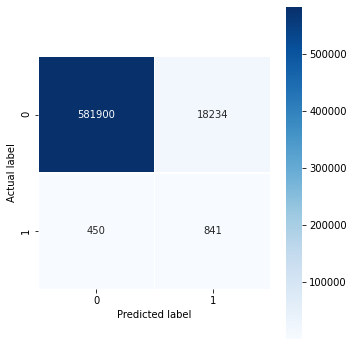

[0]	validation_0-aucpr:0.204745
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.249003
[2]	validation_0-aucpr:0.25243
[3]	validation_0-aucpr:0.252402
[4]	validation_0-aucpr:0.25589
[5]	validation_0-aucpr:0.256744
[6]	validation_0-aucpr:0.258547
[7]	validation_0-aucpr:0.259659
[8]	validation_0-aucpr:0.25975
[9]	validation_0-aucpr:0.261358
[10]	validation_0-aucpr:0.269462
[11]	validation_0-aucpr:0.272794
[12]	validation_0-aucpr:0.270667
[13]	validation_0-aucpr:0.268475
[14]	validation_0-aucpr:0.278896
[15]	validation_0-aucpr:0.27846
[16]	validation_0-aucpr:0.282779
[17]	validation_0-aucpr:0.281719
[18]	validation_0-aucpr:0.280727
[19]	validation_0-aucpr:0.288942
[20]	validation_0-aucpr:0.296933
[21]	validation_0-aucpr:0.300012
[22]	validation_0-aucpr:0.288488
[23]	validation_0-aucpr:0.288564
[24]	validation_0-aucpr:0.291986
[25]	validation_0-aucpr:0.302058
[26]	validation_0-aucpr:0.305123
[27]	validation_0-aucpr:0.304381
[28]	validation_0-aucpr:

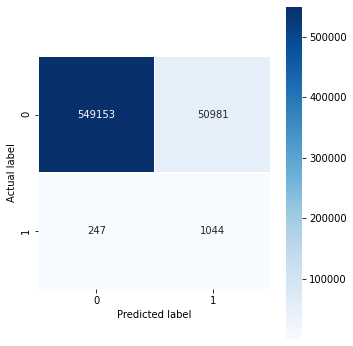

[0]	validation_0-aucpr:0.085745
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.092733
[2]	validation_0-aucpr:0.093088
[3]	validation_0-aucpr:0.088255
[4]	validation_0-aucpr:0.089153
[5]	validation_0-aucpr:0.089957
[6]	validation_0-aucpr:0.086729
[7]	validation_0-aucpr:0.079746
[8]	validation_0-aucpr:0.080577
[9]	validation_0-aucpr:0.079998
[10]	validation_0-aucpr:0.088109
[11]	validation_0-aucpr:0.096659
[12]	validation_0-aucpr:0.100927
[13]	validation_0-aucpr:0.124886
[14]	validation_0-aucpr:0.12685
[15]	validation_0-aucpr:0.129319
[16]	validation_0-aucpr:0.129974
[17]	validation_0-aucpr:0.131898
[18]	validation_0-aucpr:0.131897
[19]	validation_0-aucpr:0.137901
[20]	validation_0-aucpr:0.140552
[21]	validation_0-aucpr:0.146379
[22]	validation_0-aucpr:0.143169
[23]	validation_0-aucpr:0.142481
[24]	validation_0-aucpr:0.142697
[25]	validation_0-aucpr:0.140023
[26]	validation_0-aucpr:0.143225
[27]	validation_0-aucpr:0.144614
[28]	validation_0-auc

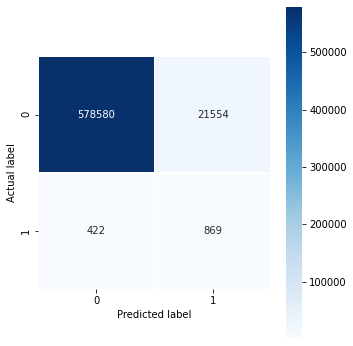

[0]	validation_0-aucpr:0.130558
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.150661
[2]	validation_0-aucpr:0.168238
[3]	validation_0-aucpr:0.171594
[4]	validation_0-aucpr:0.177834
[5]	validation_0-aucpr:0.177363
[6]	validation_0-aucpr:0.178926
[7]	validation_0-aucpr:0.180259
[8]	validation_0-aucpr:0.182811
[9]	validation_0-aucpr:0.182294
[10]	validation_0-aucpr:0.186537
[11]	validation_0-aucpr:0.190033
[12]	validation_0-aucpr:0.201632
[13]	validation_0-aucpr:0.212843
[14]	validation_0-aucpr:0.209491
[15]	validation_0-aucpr:0.217339
[16]	validation_0-aucpr:0.220973
[17]	validation_0-aucpr:0.230972
[18]	validation_0-aucpr:0.230948
[19]	validation_0-aucpr:0.236488
[20]	validation_0-aucpr:0.237621
[21]	validation_0-aucpr:0.240784
[22]	validation_0-aucpr:0.239131
[23]	validation_0-aucpr:0.243402
[24]	validation_0-aucpr:0.243705
[25]	validation_0-aucpr:0.245771
[26]	validation_0-aucpr:0.248041
[27]	validation_0-aucpr:0.240585
[28]	validation_0-au

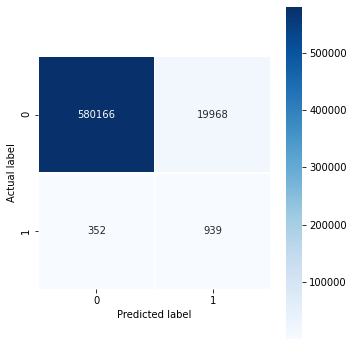

[0]	validation_0-aucpr:0.084146
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.117412
[2]	validation_0-aucpr:0.1245
[3]	validation_0-aucpr:0.122689
[4]	validation_0-aucpr:0.126646
[5]	validation_0-aucpr:0.125063
[6]	validation_0-aucpr:0.127012
[7]	validation_0-aucpr:0.137297
[8]	validation_0-aucpr:0.138816
[9]	validation_0-aucpr:0.137929
[10]	validation_0-aucpr:0.1367
[11]	validation_0-aucpr:0.136943
[12]	validation_0-aucpr:0.136748
[13]	validation_0-aucpr:0.131353
[14]	validation_0-aucpr:0.132768
[15]	validation_0-aucpr:0.133426
[16]	validation_0-aucpr:0.136384
[17]	validation_0-aucpr:0.135282
[18]	validation_0-aucpr:0.143615
[19]	validation_0-aucpr:0.144699
[20]	validation_0-aucpr:0.146657
[21]	validation_0-aucpr:0.149546
[22]	validation_0-aucpr:0.150003
[23]	validation_0-aucpr:0.149356
[24]	validation_0-aucpr:0.15049
[25]	validation_0-aucpr:0.152503
[26]	validation_0-aucpr:0.15599
[27]	validation_0-aucpr:0.156304
[28]	validation_0-aucpr:0.

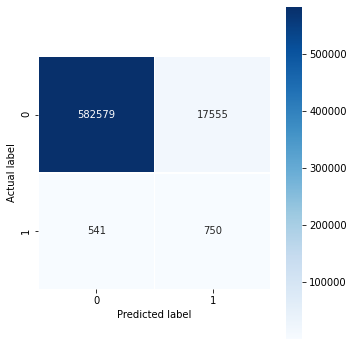

[0]	validation_0-aucpr:0.185371
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.231307
[2]	validation_0-aucpr:0.255063
[3]	validation_0-aucpr:0.227656
[4]	validation_0-aucpr:0.243187
[5]	validation_0-aucpr:0.232653
[6]	validation_0-aucpr:0.227392
[7]	validation_0-aucpr:0.233163
[8]	validation_0-aucpr:0.243685
[9]	validation_0-aucpr:0.262825
[10]	validation_0-aucpr:0.261338
[11]	validation_0-aucpr:0.245245
[12]	validation_0-aucpr:0.254495
[13]	validation_0-aucpr:0.25414
[14]	validation_0-aucpr:0.245093
[15]	validation_0-aucpr:0.27375
[16]	validation_0-aucpr:0.277193
[17]	validation_0-aucpr:0.274399
[18]	validation_0-aucpr:0.285199
[19]	validation_0-aucpr:0.286421
[20]	validation_0-aucpr:0.282594
[21]	validation_0-aucpr:0.283279
[22]	validation_0-aucpr:0.321124
[23]	validation_0-aucpr:0.333746
[24]	validation_0-aucpr:0.34066
[25]	validation_0-aucpr:0.349005
[26]	validation_0-aucpr:0.359563
[27]	validation_0-aucpr:0.370433
[28]	validation_0-aucpr

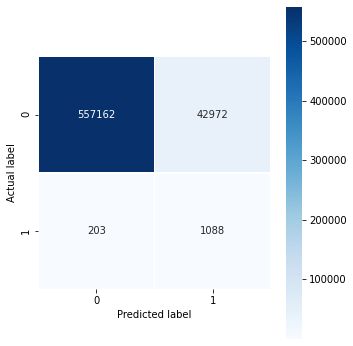

[0]	validation_0-aucpr:0.067009
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.07038
[2]	validation_0-aucpr:0.070625
[3]	validation_0-aucpr:0.072019
[4]	validation_0-aucpr:0.072436
[5]	validation_0-aucpr:0.073413
[6]	validation_0-aucpr:0.073831
[7]	validation_0-aucpr:0.073888
[8]	validation_0-aucpr:0.074271
[9]	validation_0-aucpr:0.075536
[10]	validation_0-aucpr:0.076533
[11]	validation_0-aucpr:0.088827
[12]	validation_0-aucpr:0.08889
[13]	validation_0-aucpr:0.118189
[14]	validation_0-aucpr:0.119037
[15]	validation_0-aucpr:0.120182
[16]	validation_0-aucpr:0.120911
[17]	validation_0-aucpr:0.120894
[18]	validation_0-aucpr:0.124779
[19]	validation_0-aucpr:0.125193
[20]	validation_0-aucpr:0.1344
[21]	validation_0-aucpr:0.136952
[22]	validation_0-aucpr:0.153372
[23]	validation_0-aucpr:0.151909
[24]	validation_0-aucpr:0.130856
[25]	validation_0-aucpr:0.146936
[26]	validation_0-aucpr:0.157017
[27]	validation_0-aucpr:0.155351
[28]	validation_0-aucpr:

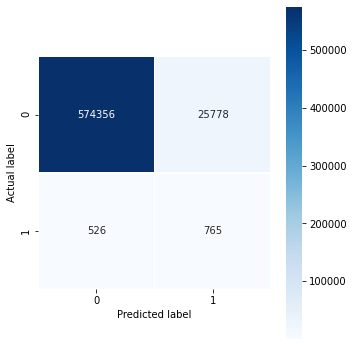

[0]	validation_0-aucpr:0.075633
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.077927
[2]	validation_0-aucpr:0.078977
[3]	validation_0-aucpr:0.080144
[4]	validation_0-aucpr:0.082979
[5]	validation_0-aucpr:0.082761
[6]	validation_0-aucpr:0.082924
[7]	validation_0-aucpr:0.083537
[8]	validation_0-aucpr:0.085107
[9]	validation_0-aucpr:0.083165
[10]	validation_0-aucpr:0.082299
[11]	validation_0-aucpr:0.080086
[12]	validation_0-aucpr:0.081188
[13]	validation_0-aucpr:0.08037
[14]	validation_0-aucpr:0.081113
[15]	validation_0-aucpr:0.08156
[16]	validation_0-aucpr:0.080824
[17]	validation_0-aucpr:0.082336
[18]	validation_0-aucpr:0.081563
Stopping. Best iteration:
[8]	validation_0-aucpr:0.085107

Prediction Report of trial 8
               precision    recall  f1-score   support

           0       1.00      0.96      0.98    600134
           1       0.03      0.58      0.06      1291

    accuracy                           0.96    601425
   macro avg

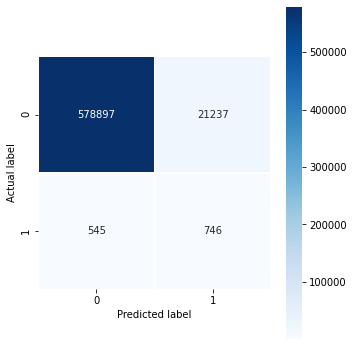

[0]	validation_0-aucpr:0.052879
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.078655
[2]	validation_0-aucpr:0.081151
[3]	validation_0-aucpr:0.079332
[4]	validation_0-aucpr:0.102249
[5]	validation_0-aucpr:0.096375
[6]	validation_0-aucpr:0.098311
[7]	validation_0-aucpr:0.097697
[8]	validation_0-aucpr:0.106438
[9]	validation_0-aucpr:0.103824
[10]	validation_0-aucpr:0.106788
[11]	validation_0-aucpr:0.108794
[12]	validation_0-aucpr:0.108774
[13]	validation_0-aucpr:0.104096
[14]	validation_0-aucpr:0.106566
[15]	validation_0-aucpr:0.106653
[16]	validation_0-aucpr:0.114357
[17]	validation_0-aucpr:0.11505
[18]	validation_0-aucpr:0.131791
[19]	validation_0-aucpr:0.143676
[20]	validation_0-aucpr:0.142275
[21]	validation_0-aucpr:0.152099
[22]	validation_0-aucpr:0.153504
[23]	validation_0-aucpr:0.153405
[24]	validation_0-aucpr:0.154944
[25]	validation_0-aucpr:0.147356
[26]	validation_0-aucpr:0.152011
[27]	validation_0-aucpr:0.151954
[28]	validation_0-auc

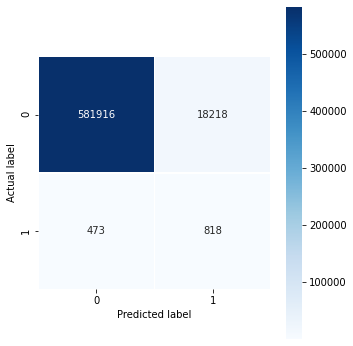

[0]	validation_0-aucpr:0.153917
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.155213
[2]	validation_0-aucpr:0.131162
[3]	validation_0-aucpr:0.149705
[4]	validation_0-aucpr:0.151871
[5]	validation_0-aucpr:0.151071
[6]	validation_0-aucpr:0.150367
[7]	validation_0-aucpr:0.153738
[8]	validation_0-aucpr:0.163464
[9]	validation_0-aucpr:0.174465
[10]	validation_0-aucpr:0.175472
[11]	validation_0-aucpr:0.183015
[12]	validation_0-aucpr:0.185925
[13]	validation_0-aucpr:0.188715
[14]	validation_0-aucpr:0.197453
[15]	validation_0-aucpr:0.20246
[16]	validation_0-aucpr:0.213958
[17]	validation_0-aucpr:0.22175
[18]	validation_0-aucpr:0.233004
[19]	validation_0-aucpr:0.242198
[20]	validation_0-aucpr:0.243226
[21]	validation_0-aucpr:0.249001
[22]	validation_0-aucpr:0.254699
[23]	validation_0-aucpr:0.254716
[24]	validation_0-aucpr:0.259142
[25]	validation_0-aucpr:0.261003
[26]	validation_0-aucpr:0.262317
[27]	validation_0-aucpr:0.264075
[28]	validation_0-aucp

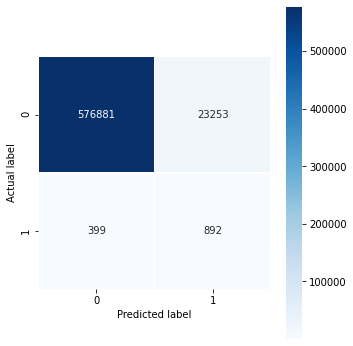

[0]	validation_0-aucpr:0.198228
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.20405
[2]	validation_0-aucpr:0.20701
[3]	validation_0-aucpr:0.216137
[4]	validation_0-aucpr:0.213956
[5]	validation_0-aucpr:0.215317
[6]	validation_0-aucpr:0.253186
[7]	validation_0-aucpr:0.253202
[8]	validation_0-aucpr:0.267273
[9]	validation_0-aucpr:0.284795
[10]	validation_0-aucpr:0.286986
[11]	validation_0-aucpr:0.290772
[12]	validation_0-aucpr:0.293391
[13]	validation_0-aucpr:0.31039
[14]	validation_0-aucpr:0.316519
[15]	validation_0-aucpr:0.318098
[16]	validation_0-aucpr:0.332876
[17]	validation_0-aucpr:0.342816
[18]	validation_0-aucpr:0.343192
[19]	validation_0-aucpr:0.340946
[20]	validation_0-aucpr:0.326433
[21]	validation_0-aucpr:0.353265
[22]	validation_0-aucpr:0.370197
[23]	validation_0-aucpr:0.388673
[24]	validation_0-aucpr:0.389827
[25]	validation_0-aucpr:0.397465
[26]	validation_0-aucpr:0.40765
[27]	validation_0-aucpr:0.405515
[28]	validation_0-aucpr:

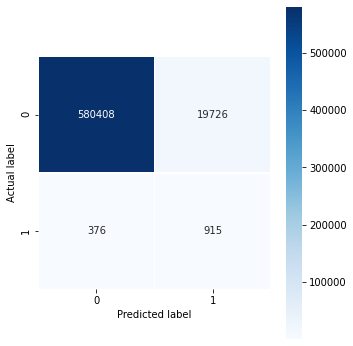

[0]	validation_0-aucpr:0.148991
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.15328
[2]	validation_0-aucpr:0.148276
[3]	validation_0-aucpr:0.149897
[4]	validation_0-aucpr:0.150394
[5]	validation_0-aucpr:0.208019
[6]	validation_0-aucpr:0.209351
[7]	validation_0-aucpr:0.215789
[8]	validation_0-aucpr:0.214858
[9]	validation_0-aucpr:0.218366
[10]	validation_0-aucpr:0.218453
[11]	validation_0-aucpr:0.228442
[12]	validation_0-aucpr:0.233359
[13]	validation_0-aucpr:0.236049
[14]	validation_0-aucpr:0.268102
[15]	validation_0-aucpr:0.269152
[16]	validation_0-aucpr:0.270242
[17]	validation_0-aucpr:0.273437
[18]	validation_0-aucpr:0.290102
[19]	validation_0-aucpr:0.290934
[20]	validation_0-aucpr:0.290204
[21]	validation_0-aucpr:0.29026
[22]	validation_0-aucpr:0.30268
[23]	validation_0-aucpr:0.321331
[24]	validation_0-aucpr:0.323216
[25]	validation_0-aucpr:0.335386
[26]	validation_0-aucpr:0.341269
[27]	validation_0-aucpr:0.340355
[28]	validation_0-aucpr

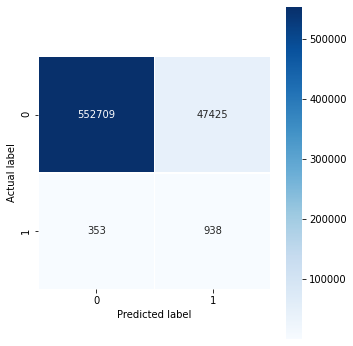

[0]	validation_0-aucpr:0.141468
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.17231
[2]	validation_0-aucpr:0.196498
[3]	validation_0-aucpr:0.197094
[4]	validation_0-aucpr:0.198866
[5]	validation_0-aucpr:0.200758
[6]	validation_0-aucpr:0.202047
[7]	validation_0-aucpr:0.203637
[8]	validation_0-aucpr:0.210028
[9]	validation_0-aucpr:0.210637
[10]	validation_0-aucpr:0.208974
[11]	validation_0-aucpr:0.208238
[12]	validation_0-aucpr:0.212171
[13]	validation_0-aucpr:0.213784
[14]	validation_0-aucpr:0.222726
[15]	validation_0-aucpr:0.245836
[16]	validation_0-aucpr:0.245305
[17]	validation_0-aucpr:0.245881
[18]	validation_0-aucpr:0.25108
[19]	validation_0-aucpr:0.272246
[20]	validation_0-aucpr:0.282553
[21]	validation_0-aucpr:0.296778
[22]	validation_0-aucpr:0.30317
[23]	validation_0-aucpr:0.303089
[24]	validation_0-aucpr:0.30383
[25]	validation_0-aucpr:0.309277
[26]	validation_0-aucpr:0.31385
[27]	validation_0-aucpr:0.317801
[28]	validation_0-aucpr:0

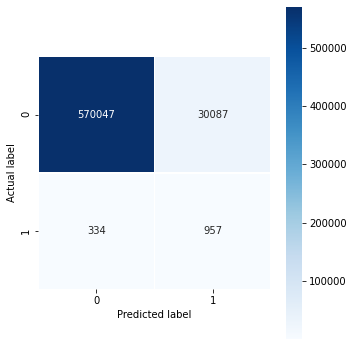

[0]	validation_0-aucpr:0.203662
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.186542
[2]	validation_0-aucpr:0.216897
[3]	validation_0-aucpr:0.204066
[4]	validation_0-aucpr:0.202889
[5]	validation_0-aucpr:0.234981
[6]	validation_0-aucpr:0.23339
[7]	validation_0-aucpr:0.265417
[8]	validation_0-aucpr:0.265158
[9]	validation_0-aucpr:0.266054
[10]	validation_0-aucpr:0.268955
[11]	validation_0-aucpr:0.269526
[12]	validation_0-aucpr:0.271836
[13]	validation_0-aucpr:0.272621
[14]	validation_0-aucpr:0.275612
[15]	validation_0-aucpr:0.285137
[16]	validation_0-aucpr:0.285839
[17]	validation_0-aucpr:0.28843
[18]	validation_0-aucpr:0.290933
[19]	validation_0-aucpr:0.346481
[20]	validation_0-aucpr:0.342408
[21]	validation_0-aucpr:0.353651
[22]	validation_0-aucpr:0.355708
[23]	validation_0-aucpr:0.365405
[24]	validation_0-aucpr:0.370792
[25]	validation_0-aucpr:0.38419
[26]	validation_0-aucpr:0.389256
[27]	validation_0-aucpr:0.388037
[28]	validation_0-aucpr

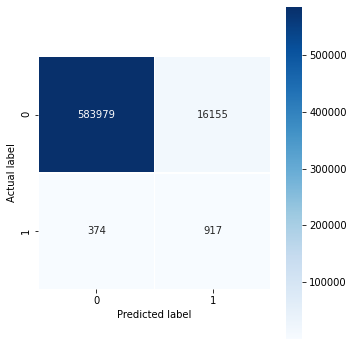

[0]	validation_0-aucpr:0.173994
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.171408
[2]	validation_0-aucpr:0.176376
[3]	validation_0-aucpr:0.179187
[4]	validation_0-aucpr:0.1703
[5]	validation_0-aucpr:0.141979
[6]	validation_0-aucpr:0.142503
[7]	validation_0-aucpr:0.181109
[8]	validation_0-aucpr:0.184378
[9]	validation_0-aucpr:0.194636
[10]	validation_0-aucpr:0.190401
[11]	validation_0-aucpr:0.196044
[12]	validation_0-aucpr:0.21531
[13]	validation_0-aucpr:0.226421
[14]	validation_0-aucpr:0.243376
[15]	validation_0-aucpr:0.248122
[16]	validation_0-aucpr:0.259132
[17]	validation_0-aucpr:0.277093
[18]	validation_0-aucpr:0.278325
[19]	validation_0-aucpr:0.282208
[20]	validation_0-aucpr:0.282962
[21]	validation_0-aucpr:0.293868
[22]	validation_0-aucpr:0.298498
[23]	validation_0-aucpr:0.300149
[24]	validation_0-aucpr:0.301182
[25]	validation_0-aucpr:0.303112
[26]	validation_0-aucpr:0.306014
[27]	validation_0-aucpr:0.303439
[28]	validation_0-aucpr

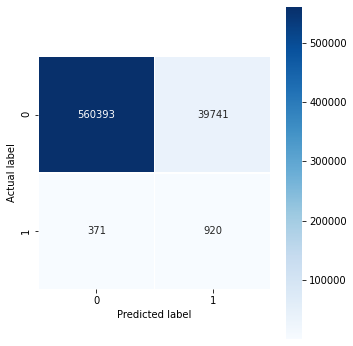

[0]	validation_0-aucpr:0.1391
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.141946
[2]	validation_0-aucpr:0.142299
[3]	validation_0-aucpr:0.147136
[4]	validation_0-aucpr:0.149405
[5]	validation_0-aucpr:0.150715
[6]	validation_0-aucpr:0.15059
[7]	validation_0-aucpr:0.150851
[8]	validation_0-aucpr:0.149716
[9]	validation_0-aucpr:0.151493
[10]	validation_0-aucpr:0.151459
[11]	validation_0-aucpr:0.174927
[12]	validation_0-aucpr:0.173669
[13]	validation_0-aucpr:0.175381
[14]	validation_0-aucpr:0.176855
[15]	validation_0-aucpr:0.171425
[16]	validation_0-aucpr:0.171925
[17]	validation_0-aucpr:0.170228
[18]	validation_0-aucpr:0.181047
[19]	validation_0-aucpr:0.180811
[20]	validation_0-aucpr:0.20621
[21]	validation_0-aucpr:0.205813
[22]	validation_0-aucpr:0.214377
[23]	validation_0-aucpr:0.210972
[24]	validation_0-aucpr:0.215053
[25]	validation_0-aucpr:0.214859
[26]	validation_0-aucpr:0.215296
[27]	validation_0-aucpr:0.218274
[28]	validation_0-aucpr:

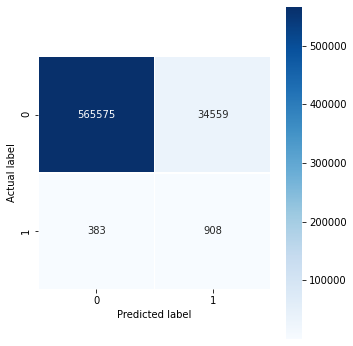

[0]	validation_0-aucpr:0.115568
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.11896
[2]	validation_0-aucpr:0.121231
[3]	validation_0-aucpr:0.124999
[4]	validation_0-aucpr:0.124827
[5]	validation_0-aucpr:0.162213
[6]	validation_0-aucpr:0.161026
[7]	validation_0-aucpr:0.188572
[8]	validation_0-aucpr:0.188781
[9]	validation_0-aucpr:0.191659
[10]	validation_0-aucpr:0.193086
[11]	validation_0-aucpr:0.193721
[12]	validation_0-aucpr:0.191392
[13]	validation_0-aucpr:0.194157
[14]	validation_0-aucpr:0.194347
[15]	validation_0-aucpr:0.195045
[16]	validation_0-aucpr:0.192622
[17]	validation_0-aucpr:0.190915
[18]	validation_0-aucpr:0.191786
[19]	validation_0-aucpr:0.210392
[20]	validation_0-aucpr:0.212848
[21]	validation_0-aucpr:0.211887
[22]	validation_0-aucpr:0.238462
[23]	validation_0-aucpr:0.242519
[24]	validation_0-aucpr:0.247315
[25]	validation_0-aucpr:0.249509
[26]	validation_0-aucpr:0.253057
[27]	validation_0-aucpr:0.253185
[28]	validation_0-auc

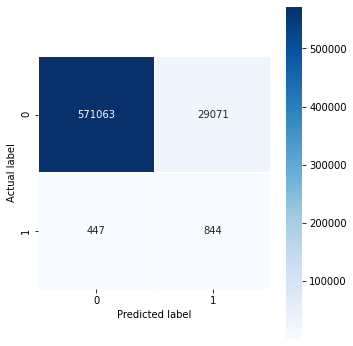

[0]	validation_0-aucpr:0.085756
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.137278
[2]	validation_0-aucpr:0.140672
[3]	validation_0-aucpr:0.143119
[4]	validation_0-aucpr:0.146739
[5]	validation_0-aucpr:0.145638
[6]	validation_0-aucpr:0.147392
[7]	validation_0-aucpr:0.148256
[8]	validation_0-aucpr:0.147664
[9]	validation_0-aucpr:0.147385
[10]	validation_0-aucpr:0.177436
[11]	validation_0-aucpr:0.176693
[12]	validation_0-aucpr:0.181353
[13]	validation_0-aucpr:0.179754
[14]	validation_0-aucpr:0.181653
[15]	validation_0-aucpr:0.205266
[16]	validation_0-aucpr:0.206214
[17]	validation_0-aucpr:0.215912
[18]	validation_0-aucpr:0.215231
[19]	validation_0-aucpr:0.225459
[20]	validation_0-aucpr:0.223067
[21]	validation_0-aucpr:0.24981
[22]	validation_0-aucpr:0.253292
[23]	validation_0-aucpr:0.265284
[24]	validation_0-aucpr:0.268194
[25]	validation_0-aucpr:0.270045
[26]	validation_0-aucpr:0.270108
[27]	validation_0-aucpr:0.277124
[28]	validation_0-auc

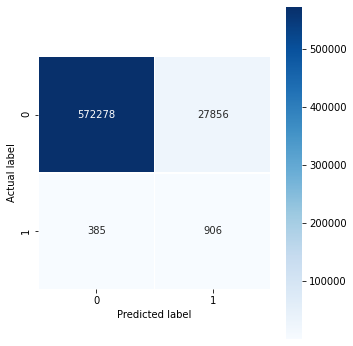

[0]	validation_0-aucpr:0.187503
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.196394
[2]	validation_0-aucpr:0.218903
[3]	validation_0-aucpr:0.223086
[4]	validation_0-aucpr:0.218237
[5]	validation_0-aucpr:0.223536
[6]	validation_0-aucpr:0.224201
[7]	validation_0-aucpr:0.236463
[8]	validation_0-aucpr:0.271597
[9]	validation_0-aucpr:0.267574
[10]	validation_0-aucpr:0.293129
[11]	validation_0-aucpr:0.290463
[12]	validation_0-aucpr:0.28982
[13]	validation_0-aucpr:0.308547
[14]	validation_0-aucpr:0.320237
[15]	validation_0-aucpr:0.316984
[16]	validation_0-aucpr:0.317099
[17]	validation_0-aucpr:0.340413
[18]	validation_0-aucpr:0.356931
[19]	validation_0-aucpr:0.389463
[20]	validation_0-aucpr:0.389931
[21]	validation_0-aucpr:0.38074
[22]	validation_0-aucpr:0.397802
[23]	validation_0-aucpr:0.40745
[24]	validation_0-aucpr:0.449575
[25]	validation_0-aucpr:0.452719
[26]	validation_0-aucpr:0.468035
[27]	validation_0-aucpr:0.46555
[28]	validation_0-aucpr:

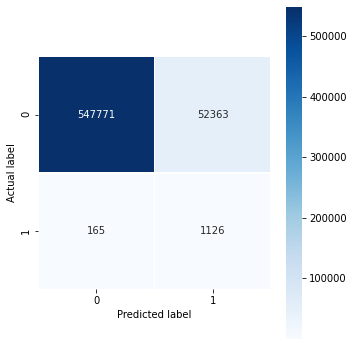

[0]	validation_0-aucpr:0.142319
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.180114
[2]	validation_0-aucpr:0.181207
[3]	validation_0-aucpr:0.197723
[4]	validation_0-aucpr:0.198923
[5]	validation_0-aucpr:0.202388
[6]	validation_0-aucpr:0.200415
[7]	validation_0-aucpr:0.204425
[8]	validation_0-aucpr:0.205679
[9]	validation_0-aucpr:0.20592
[10]	validation_0-aucpr:0.203505
[11]	validation_0-aucpr:0.204398
[12]	validation_0-aucpr:0.205225
[13]	validation_0-aucpr:0.208691
[14]	validation_0-aucpr:0.224134
[15]	validation_0-aucpr:0.223211
[16]	validation_0-aucpr:0.22759
[17]	validation_0-aucpr:0.23023
[18]	validation_0-aucpr:0.228598
[19]	validation_0-aucpr:0.239823
[20]	validation_0-aucpr:0.247427
[21]	validation_0-aucpr:0.246069
[22]	validation_0-aucpr:0.239524
[23]	validation_0-aucpr:0.247906
[24]	validation_0-aucpr:0.252772
[25]	validation_0-aucpr:0.25506
[26]	validation_0-aucpr:0.257327
[27]	validation_0-aucpr:0.262846
[28]	validation_0-aucpr:

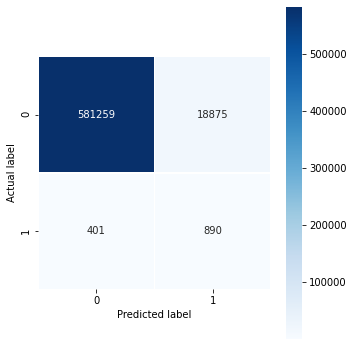

[0]	validation_0-aucpr:0.044819
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.048955
[2]	validation_0-aucpr:0.093607
[3]	validation_0-aucpr:0.093701
[4]	validation_0-aucpr:0.078321
[5]	validation_0-aucpr:0.067703
[6]	validation_0-aucpr:0.068527
[7]	validation_0-aucpr:0.075386
[8]	validation_0-aucpr:0.075378
[9]	validation_0-aucpr:0.082326
[10]	validation_0-aucpr:0.081184
[11]	validation_0-aucpr:0.083
[12]	validation_0-aucpr:0.080876
[13]	validation_0-aucpr:0.090097
Stopping. Best iteration:
[3]	validation_0-aucpr:0.093701

Prediction Report of trial 21
               precision    recall  f1-score   support

           0       1.00      0.96      0.98    600134
           1       0.03      0.57      0.06      1291

    accuracy                           0.96    601425
   macro avg       0.52      0.77      0.52    601425
weighted avg       1.00      0.96      0.98    601425



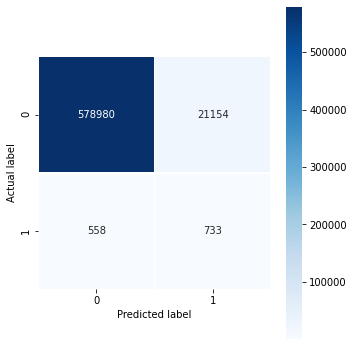

[0]	validation_0-aucpr:0.080082
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.084682
[2]	validation_0-aucpr:0.065674
[3]	validation_0-aucpr:0.070617
[4]	validation_0-aucpr:0.082651
[5]	validation_0-aucpr:0.072426
[6]	validation_0-aucpr:0.083388
[7]	validation_0-aucpr:0.084439
[8]	validation_0-aucpr:0.094973
[9]	validation_0-aucpr:0.098295
[10]	validation_0-aucpr:0.103753
[11]	validation_0-aucpr:0.103572
[12]	validation_0-aucpr:0.104689
[13]	validation_0-aucpr:0.103899
[14]	validation_0-aucpr:0.096204
[15]	validation_0-aucpr:0.101813
[16]	validation_0-aucpr:0.100905
[17]	validation_0-aucpr:0.106141
[18]	validation_0-aucpr:0.105572
[19]	validation_0-aucpr:0.111367
[20]	validation_0-aucpr:0.108367
[21]	validation_0-aucpr:0.108323
[22]	validation_0-aucpr:0.112657
[23]	validation_0-aucpr:0.116342
[24]	validation_0-aucpr:0.115372
[25]	validation_0-aucpr:0.117248
[26]	validation_0-aucpr:0.11644
[27]	validation_0-aucpr:0.118084
[28]	validation_0-auc

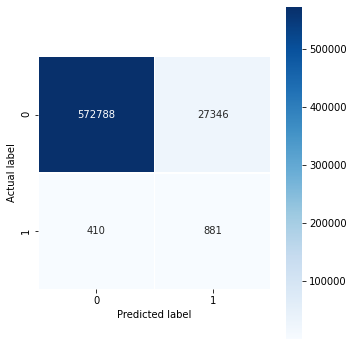

[0]	validation_0-aucpr:0.097618
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.098716
[2]	validation_0-aucpr:0.101059
[3]	validation_0-aucpr:0.101721
[4]	validation_0-aucpr:0.102008
[5]	validation_0-aucpr:0.10366
[6]	validation_0-aucpr:0.148078
[7]	validation_0-aucpr:0.148155
[8]	validation_0-aucpr:0.149487
[9]	validation_0-aucpr:0.153675
[10]	validation_0-aucpr:0.151846
[11]	validation_0-aucpr:0.151396
[12]	validation_0-aucpr:0.145955
[13]	validation_0-aucpr:0.144851
[14]	validation_0-aucpr:0.142702
[15]	validation_0-aucpr:0.145768
[16]	validation_0-aucpr:0.159003
[17]	validation_0-aucpr:0.158488
[18]	validation_0-aucpr:0.160736
[19]	validation_0-aucpr:0.170185
[20]	validation_0-aucpr:0.186509
[21]	validation_0-aucpr:0.185254
[22]	validation_0-aucpr:0.220013
[23]	validation_0-aucpr:0.22977
[24]	validation_0-aucpr:0.228449
[25]	validation_0-aucpr:0.233091
[26]	validation_0-aucpr:0.234982
[27]	validation_0-aucpr:0.240149
[28]	validation_0-aucp

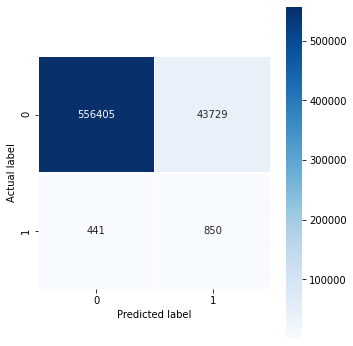

[0]	validation_0-aucpr:0.112362
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.116655
[2]	validation_0-aucpr:0.11863
[3]	validation_0-aucpr:0.153325
[4]	validation_0-aucpr:0.155188
[5]	validation_0-aucpr:0.155799
[6]	validation_0-aucpr:0.156002
[7]	validation_0-aucpr:0.196975
[8]	validation_0-aucpr:0.196344
[9]	validation_0-aucpr:0.196451
[10]	validation_0-aucpr:0.202757
[11]	validation_0-aucpr:0.205226
[12]	validation_0-aucpr:0.208918
[13]	validation_0-aucpr:0.210072
[14]	validation_0-aucpr:0.212332
[15]	validation_0-aucpr:0.21197
[16]	validation_0-aucpr:0.213947
[17]	validation_0-aucpr:0.229046
[18]	validation_0-aucpr:0.231412
[19]	validation_0-aucpr:0.234771
[20]	validation_0-aucpr:0.244509
[21]	validation_0-aucpr:0.258242
[22]	validation_0-aucpr:0.262019
[23]	validation_0-aucpr:0.262962
[24]	validation_0-aucpr:0.261461
[25]	validation_0-aucpr:0.27026
[26]	validation_0-aucpr:0.270044
[27]	validation_0-aucpr:0.274626
[28]	validation_0-aucpr

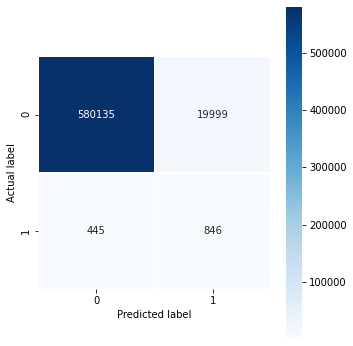

[0]	validation_0-aucpr:0.110202
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.185515
[2]	validation_0-aucpr:0.19382
[3]	validation_0-aucpr:0.203582
[4]	validation_0-aucpr:0.195781
[5]	validation_0-aucpr:0.207241
[6]	validation_0-aucpr:0.198378
[7]	validation_0-aucpr:0.207196
[8]	validation_0-aucpr:0.202729
[9]	validation_0-aucpr:0.20856
[10]	validation_0-aucpr:0.210449
[11]	validation_0-aucpr:0.212472
[12]	validation_0-aucpr:0.213475
[13]	validation_0-aucpr:0.214137
[14]	validation_0-aucpr:0.218322
[15]	validation_0-aucpr:0.220652
[16]	validation_0-aucpr:0.220799
[17]	validation_0-aucpr:0.221378
[18]	validation_0-aucpr:0.223804
[19]	validation_0-aucpr:0.235491
[20]	validation_0-aucpr:0.2395
[21]	validation_0-aucpr:0.238826
[22]	validation_0-aucpr:0.240927
[23]	validation_0-aucpr:0.244216
[24]	validation_0-aucpr:0.249738
[25]	validation_0-aucpr:0.249649
[26]	validation_0-aucpr:0.256692
[27]	validation_0-aucpr:0.256812
[28]	validation_0-aucpr:

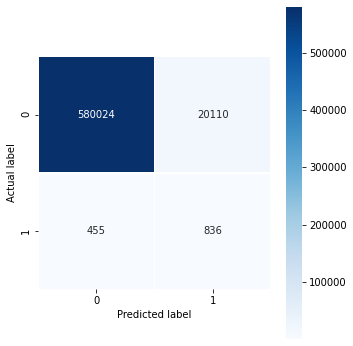

[0]	validation_0-aucpr:0.085138
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.09838
[2]	validation_0-aucpr:0.100364
[3]	validation_0-aucpr:0.09817
[4]	validation_0-aucpr:0.102975
[5]	validation_0-aucpr:0.104401
[6]	validation_0-aucpr:0.101123
[7]	validation_0-aucpr:0.105358
[8]	validation_0-aucpr:0.101202
[9]	validation_0-aucpr:0.10573
[10]	validation_0-aucpr:0.093909
[11]	validation_0-aucpr:0.100114
[12]	validation_0-aucpr:0.10045
[13]	validation_0-aucpr:0.102349
[14]	validation_0-aucpr:0.102659
[15]	validation_0-aucpr:0.107208
[16]	validation_0-aucpr:0.106414
[17]	validation_0-aucpr:0.107211
[18]	validation_0-aucpr:0.107263
[19]	validation_0-aucpr:0.110834
[20]	validation_0-aucpr:0.112362
[21]	validation_0-aucpr:0.11872
[22]	validation_0-aucpr:0.126896
[23]	validation_0-aucpr:0.126517
[24]	validation_0-aucpr:0.132992
[25]	validation_0-aucpr:0.133969
[26]	validation_0-aucpr:0.134024
[27]	validation_0-aucpr:0.131212
[28]	validation_0-aucpr:0

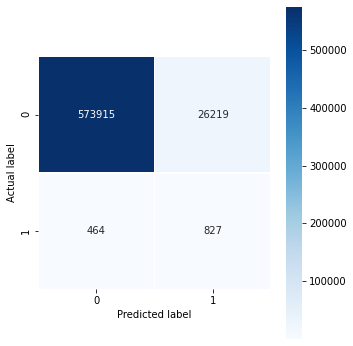

[0]	validation_0-aucpr:0.088964
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.091841
[2]	validation_0-aucpr:0.094579
[3]	validation_0-aucpr:0.123339
[4]	validation_0-aucpr:0.123517
[5]	validation_0-aucpr:0.123646
[6]	validation_0-aucpr:0.123365
[7]	validation_0-aucpr:0.123721
[8]	validation_0-aucpr:0.137745
[9]	validation_0-aucpr:0.141751
[10]	validation_0-aucpr:0.140665
[11]	validation_0-aucpr:0.143829
[12]	validation_0-aucpr:0.14437
[13]	validation_0-aucpr:0.149812
[14]	validation_0-aucpr:0.153745
[15]	validation_0-aucpr:0.1547
[16]	validation_0-aucpr:0.158897
[17]	validation_0-aucpr:0.161448
[18]	validation_0-aucpr:0.186148
[19]	validation_0-aucpr:0.185087
[20]	validation_0-aucpr:0.19456
[21]	validation_0-aucpr:0.193945
[22]	validation_0-aucpr:0.195035
[23]	validation_0-aucpr:0.191993
[24]	validation_0-aucpr:0.196219
[25]	validation_0-aucpr:0.197638
[26]	validation_0-aucpr:0.192561
[27]	validation_0-aucpr:0.196538
[28]	validation_0-aucpr:

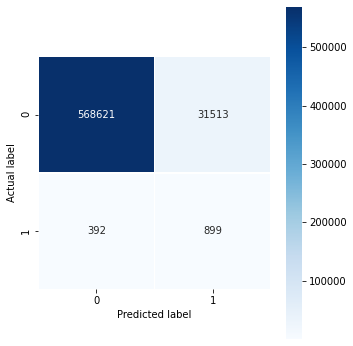

[0]	validation_0-aucpr:0.145571
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.148403
[2]	validation_0-aucpr:0.148821
[3]	validation_0-aucpr:0.148808
[4]	validation_0-aucpr:0.186682
[5]	validation_0-aucpr:0.188604
[6]	validation_0-aucpr:0.189118
[7]	validation_0-aucpr:0.18911
[8]	validation_0-aucpr:0.188581
[9]	validation_0-aucpr:0.193528
[10]	validation_0-aucpr:0.193712
[11]	validation_0-aucpr:0.194878
[12]	validation_0-aucpr:0.19509
[13]	validation_0-aucpr:0.196216
[14]	validation_0-aucpr:0.195784
[15]	validation_0-aucpr:0.222348
[16]	validation_0-aucpr:0.221895
[17]	validation_0-aucpr:0.22072
[18]	validation_0-aucpr:0.222728
[19]	validation_0-aucpr:0.214157
[20]	validation_0-aucpr:0.244742
[21]	validation_0-aucpr:0.259496
[22]	validation_0-aucpr:0.269529
[23]	validation_0-aucpr:0.269294
[24]	validation_0-aucpr:0.269835
[25]	validation_0-aucpr:0.267634
[26]	validation_0-aucpr:0.272994
[27]	validation_0-aucpr:0.270276
[28]	validation_0-aucpr

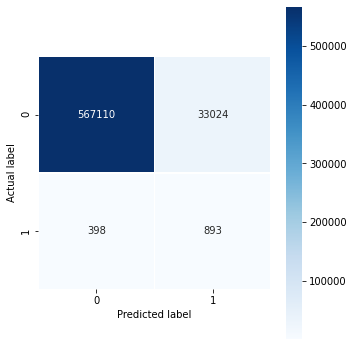

[0]	validation_0-aucpr:0.055864
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.109619
[2]	validation_0-aucpr:0.11049
[3]	validation_0-aucpr:0.113735
[4]	validation_0-aucpr:0.142104
[5]	validation_0-aucpr:0.142059
[6]	validation_0-aucpr:0.143487
[7]	validation_0-aucpr:0.144645
[8]	validation_0-aucpr:0.143679
[9]	validation_0-aucpr:0.144551
[10]	validation_0-aucpr:0.147197
[11]	validation_0-aucpr:0.147197
[12]	validation_0-aucpr:0.14927
[13]	validation_0-aucpr:0.16257
[14]	validation_0-aucpr:0.163807
[15]	validation_0-aucpr:0.168783
[16]	validation_0-aucpr:0.167308
[17]	validation_0-aucpr:0.177724
[18]	validation_0-aucpr:0.180678
[19]	validation_0-aucpr:0.188461
[20]	validation_0-aucpr:0.19048
[21]	validation_0-aucpr:0.204311
[22]	validation_0-aucpr:0.22285
[23]	validation_0-aucpr:0.222826
[24]	validation_0-aucpr:0.222815
[25]	validation_0-aucpr:0.223375
[26]	validation_0-aucpr:0.227112
[27]	validation_0-aucpr:0.226503
[28]	validation_0-aucpr:0

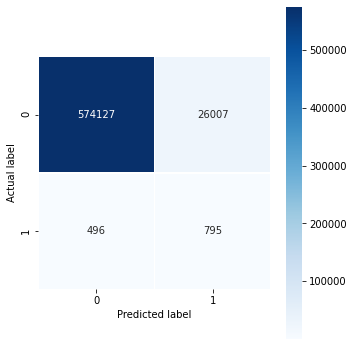

[0]	validation_0-aucpr:0.095506
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.100215
[2]	validation_0-aucpr:0.129606
[3]	validation_0-aucpr:0.130213
[4]	validation_0-aucpr:0.127059
[5]	validation_0-aucpr:0.128175
[6]	validation_0-aucpr:0.128001
[7]	validation_0-aucpr:0.127383
[8]	validation_0-aucpr:0.127378
[9]	validation_0-aucpr:0.12833
[10]	validation_0-aucpr:0.129856
[11]	validation_0-aucpr:0.131874
[12]	validation_0-aucpr:0.129894
[13]	validation_0-aucpr:0.130146
[14]	validation_0-aucpr:0.131046
[15]	validation_0-aucpr:0.131296
[16]	validation_0-aucpr:0.141411
[17]	validation_0-aucpr:0.141386
[18]	validation_0-aucpr:0.141129
[19]	validation_0-aucpr:0.184537
[20]	validation_0-aucpr:0.177496
[21]	validation_0-aucpr:0.189054
[22]	validation_0-aucpr:0.189477
[23]	validation_0-aucpr:0.196487
[24]	validation_0-aucpr:0.186706
[25]	validation_0-aucpr:0.186804
[26]	validation_0-aucpr:0.194554
[27]	validation_0-aucpr:0.195282
[28]	validation_0-auc

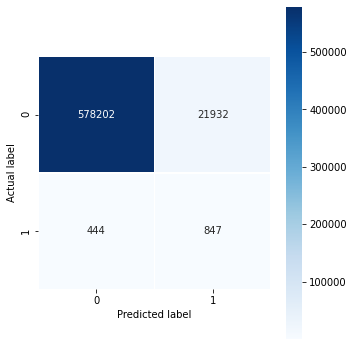

[0]	validation_0-aucpr:0.119583
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.120665
[2]	validation_0-aucpr:0.121386
[3]	validation_0-aucpr:0.188314
[4]	validation_0-aucpr:0.192226
[5]	validation_0-aucpr:0.194865
[6]	validation_0-aucpr:0.195875
[7]	validation_0-aucpr:0.198366
[8]	validation_0-aucpr:0.197825
[9]	validation_0-aucpr:0.204936
[10]	validation_0-aucpr:0.218121
[11]	validation_0-aucpr:0.221128
[12]	validation_0-aucpr:0.222026
[13]	validation_0-aucpr:0.239864
[14]	validation_0-aucpr:0.241427
[15]	validation_0-aucpr:0.242206
[16]	validation_0-aucpr:0.245491
[17]	validation_0-aucpr:0.243292
[18]	validation_0-aucpr:0.245485
[19]	validation_0-aucpr:0.244036
[20]	validation_0-aucpr:0.243717
[21]	validation_0-aucpr:0.236262
[22]	validation_0-aucpr:0.237576
[23]	validation_0-aucpr:0.238327
[24]	validation_0-aucpr:0.248449
[25]	validation_0-aucpr:0.240873
[26]	validation_0-aucpr:0.241389
[27]	validation_0-aucpr:0.2412
[28]	validation_0-aucp

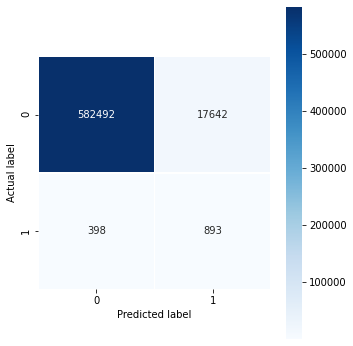

[0]	validation_0-aucpr:0.113019
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.116793
[2]	validation_0-aucpr:0.117566
[3]	validation_0-aucpr:0.117916
[4]	validation_0-aucpr:0.119843
[5]	validation_0-aucpr:0.179691
[6]	validation_0-aucpr:0.181369
[7]	validation_0-aucpr:0.181244
[8]	validation_0-aucpr:0.183718
[9]	validation_0-aucpr:0.186289
[10]	validation_0-aucpr:0.185863
[11]	validation_0-aucpr:0.186982
[12]	validation_0-aucpr:0.187278
[13]	validation_0-aucpr:0.196231
[14]	validation_0-aucpr:0.196455
[15]	validation_0-aucpr:0.213079
[16]	validation_0-aucpr:0.213346
[17]	validation_0-aucpr:0.220004
[18]	validation_0-aucpr:0.220963
[19]	validation_0-aucpr:0.220002
[20]	validation_0-aucpr:0.236487
[21]	validation_0-aucpr:0.239566
[22]	validation_0-aucpr:0.248583
[23]	validation_0-aucpr:0.254578
[24]	validation_0-aucpr:0.258609
[25]	validation_0-aucpr:0.256221
[26]	validation_0-aucpr:0.255197
[27]	validation_0-aucpr:0.255413
[28]	validation_0-au

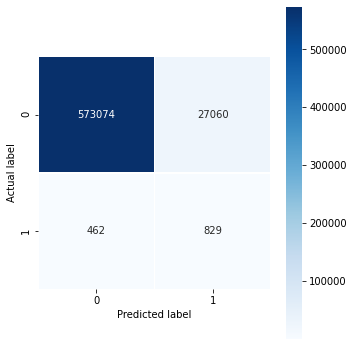

[0]	validation_0-aucpr:0.048042
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.05076
[2]	validation_0-aucpr:0.099188
[3]	validation_0-aucpr:0.099743
[4]	validation_0-aucpr:0.126935
[5]	validation_0-aucpr:0.127143
[6]	validation_0-aucpr:0.139921
[7]	validation_0-aucpr:0.14172
[8]	validation_0-aucpr:0.141614
[9]	validation_0-aucpr:0.147989
[10]	validation_0-aucpr:0.155975
[11]	validation_0-aucpr:0.159607
[12]	validation_0-aucpr:0.165505
[13]	validation_0-aucpr:0.166962
[14]	validation_0-aucpr:0.151654
[15]	validation_0-aucpr:0.173292
[16]	validation_0-aucpr:0.174282
[17]	validation_0-aucpr:0.174359
[18]	validation_0-aucpr:0.187959
[19]	validation_0-aucpr:0.190812
[20]	validation_0-aucpr:0.227424
[21]	validation_0-aucpr:0.235565
[22]	validation_0-aucpr:0.232412
[23]	validation_0-aucpr:0.242333
[24]	validation_0-aucpr:0.238801
[25]	validation_0-aucpr:0.238475
[26]	validation_0-aucpr:0.252781
[27]	validation_0-aucpr:0.25067
[28]	validation_0-aucpr

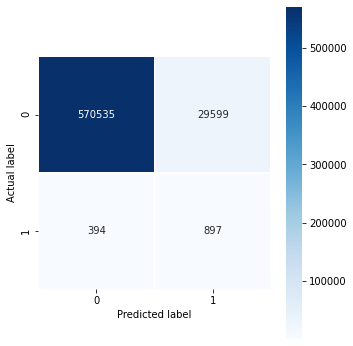

[0]	validation_0-aucpr:0.062586
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.072411
[2]	validation_0-aucpr:0.073707
[3]	validation_0-aucpr:0.073613
[4]	validation_0-aucpr:0.073637
[5]	validation_0-aucpr:0.07534
[6]	validation_0-aucpr:0.076083
[7]	validation_0-aucpr:0.07551
[8]	validation_0-aucpr:0.075346
[9]	validation_0-aucpr:0.07516
[10]	validation_0-aucpr:0.078119
[11]	validation_0-aucpr:0.077918
[12]	validation_0-aucpr:0.078365
[13]	validation_0-aucpr:0.080897
[14]	validation_0-aucpr:0.080158
[15]	validation_0-aucpr:0.081762
[16]	validation_0-aucpr:0.080461
[17]	validation_0-aucpr:0.08086
[18]	validation_0-aucpr:0.082239
[19]	validation_0-aucpr:0.08443
[20]	validation_0-aucpr:0.086598
[21]	validation_0-aucpr:0.09303
[22]	validation_0-aucpr:0.092226
[23]	validation_0-aucpr:0.092693
[24]	validation_0-aucpr:0.09433
[25]	validation_0-aucpr:0.092849
[26]	validation_0-aucpr:0.093592
[27]	validation_0-aucpr:0.094661
[28]	validation_0-aucpr:0.0

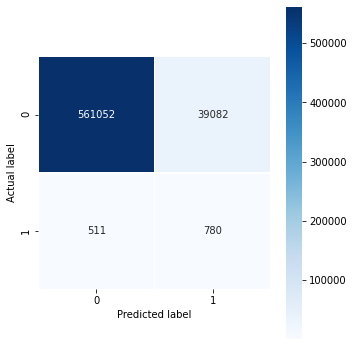

[0]	validation_0-aucpr:0.052676
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.066648
[2]	validation_0-aucpr:0.069284
[3]	validation_0-aucpr:0.154728
[4]	validation_0-aucpr:0.153882
[5]	validation_0-aucpr:0.148452
[6]	validation_0-aucpr:0.159361
[7]	validation_0-aucpr:0.158964
[8]	validation_0-aucpr:0.181513
[9]	validation_0-aucpr:0.17849
[10]	validation_0-aucpr:0.174414
[11]	validation_0-aucpr:0.170202
[12]	validation_0-aucpr:0.206571
[13]	validation_0-aucpr:0.202589
[14]	validation_0-aucpr:0.20003
[15]	validation_0-aucpr:0.241407
[16]	validation_0-aucpr:0.254699
[17]	validation_0-aucpr:0.25496
[18]	validation_0-aucpr:0.274853
[19]	validation_0-aucpr:0.281846
[20]	validation_0-aucpr:0.298192
[21]	validation_0-aucpr:0.300073
[22]	validation_0-aucpr:0.303462
[23]	validation_0-aucpr:0.306642
[24]	validation_0-aucpr:0.31025
[25]	validation_0-aucpr:0.310862
[26]	validation_0-aucpr:0.318742
[27]	validation_0-aucpr:0.322815
[28]	validation_0-aucpr:

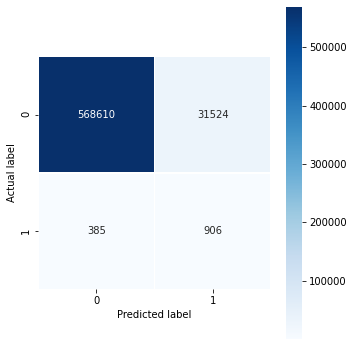

[0]	validation_0-aucpr:0.104724
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.110253
[2]	validation_0-aucpr:0.111692
[3]	validation_0-aucpr:0.13388
[4]	validation_0-aucpr:0.133978
[5]	validation_0-aucpr:0.134548
[6]	validation_0-aucpr:0.135269
[7]	validation_0-aucpr:0.172295
[8]	validation_0-aucpr:0.172136
[9]	validation_0-aucpr:0.179661
[10]	validation_0-aucpr:0.206576
[11]	validation_0-aucpr:0.210752
[12]	validation_0-aucpr:0.171716
[13]	validation_0-aucpr:0.177457
[14]	validation_0-aucpr:0.177936
[15]	validation_0-aucpr:0.181564
[16]	validation_0-aucpr:0.184856
[17]	validation_0-aucpr:0.173734
[18]	validation_0-aucpr:0.179563
[19]	validation_0-aucpr:0.18295
[20]	validation_0-aucpr:0.200023
[21]	validation_0-aucpr:0.211033
[22]	validation_0-aucpr:0.217522
[23]	validation_0-aucpr:0.221037
[24]	validation_0-aucpr:0.231457
[25]	validation_0-aucpr:0.23432
[26]	validation_0-aucpr:0.237076
[27]	validation_0-aucpr:0.240189
[28]	validation_0-aucpr

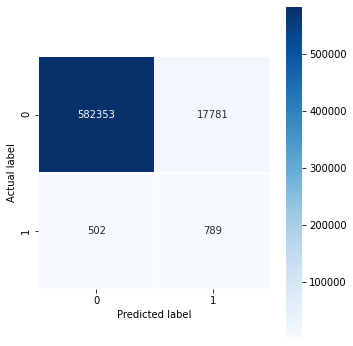

[0]	validation_0-aucpr:0.146907
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.148117
[2]	validation_0-aucpr:0.149555
[3]	validation_0-aucpr:0.153107
[4]	validation_0-aucpr:0.152316
[5]	validation_0-aucpr:0.154024
[6]	validation_0-aucpr:0.153749
[7]	validation_0-aucpr:0.150697
[8]	validation_0-aucpr:0.155074
[9]	validation_0-aucpr:0.150746
[10]	validation_0-aucpr:0.153503
[11]	validation_0-aucpr:0.15846
[12]	validation_0-aucpr:0.178241
[13]	validation_0-aucpr:0.17426
[14]	validation_0-aucpr:0.177879
[15]	validation_0-aucpr:0.200281
[16]	validation_0-aucpr:0.192881
[17]	validation_0-aucpr:0.193047
[18]	validation_0-aucpr:0.193281
[19]	validation_0-aucpr:0.21618
[20]	validation_0-aucpr:0.23217
[21]	validation_0-aucpr:0.266742
[22]	validation_0-aucpr:0.266879
[23]	validation_0-aucpr:0.269495
[24]	validation_0-aucpr:0.277323
[25]	validation_0-aucpr:0.293334
[26]	validation_0-aucpr:0.297403
[27]	validation_0-aucpr:0.315559
[28]	validation_0-aucpr:

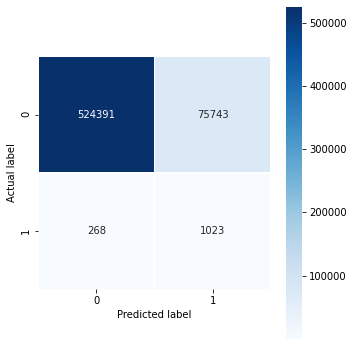

[0]	validation_0-aucpr:0.116415
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.120487
[2]	validation_0-aucpr:0.152859
[3]	validation_0-aucpr:0.155913
[4]	validation_0-aucpr:0.156636
[5]	validation_0-aucpr:0.156228
[6]	validation_0-aucpr:0.156646
[7]	validation_0-aucpr:0.156702
[8]	validation_0-aucpr:0.157006
[9]	validation_0-aucpr:0.16397
[10]	validation_0-aucpr:0.165198
[11]	validation_0-aucpr:0.162619
[12]	validation_0-aucpr:0.167959
[13]	validation_0-aucpr:0.170191
[14]	validation_0-aucpr:0.173677
[15]	validation_0-aucpr:0.177788
[16]	validation_0-aucpr:0.178573
[17]	validation_0-aucpr:0.177342
[18]	validation_0-aucpr:0.177598
[19]	validation_0-aucpr:0.184977
[20]	validation_0-aucpr:0.1862
[21]	validation_0-aucpr:0.200684
[22]	validation_0-aucpr:0.213707
[23]	validation_0-aucpr:0.2128
[24]	validation_0-aucpr:0.214641
[25]	validation_0-aucpr:0.213902
[26]	validation_0-aucpr:0.214752
[27]	validation_0-aucpr:0.216016
[28]	validation_0-aucpr:0

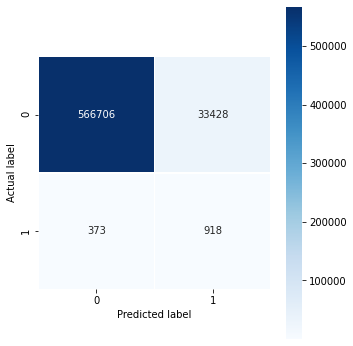

[0]	validation_0-aucpr:0.076376
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.087256
[2]	validation_0-aucpr:0.150775
[3]	validation_0-aucpr:0.151094
[4]	validation_0-aucpr:0.152825
[5]	validation_0-aucpr:0.153402
[6]	validation_0-aucpr:0.147554
[7]	validation_0-aucpr:0.17823
[8]	validation_0-aucpr:0.175477
[9]	validation_0-aucpr:0.178984
[10]	validation_0-aucpr:0.178513
[11]	validation_0-aucpr:0.181068
[12]	validation_0-aucpr:0.197439
[13]	validation_0-aucpr:0.200738
[14]	validation_0-aucpr:0.201547
[15]	validation_0-aucpr:0.208008
[16]	validation_0-aucpr:0.208145
[17]	validation_0-aucpr:0.226236
[18]	validation_0-aucpr:0.243708
[19]	validation_0-aucpr:0.293971
[20]	validation_0-aucpr:0.308933
[21]	validation_0-aucpr:0.315428
[22]	validation_0-aucpr:0.305688
[23]	validation_0-aucpr:0.303145
[24]	validation_0-aucpr:0.313369
[25]	validation_0-aucpr:0.312675
[26]	validation_0-aucpr:0.314219
[27]	validation_0-aucpr:0.315653
[28]	validation_0-auc

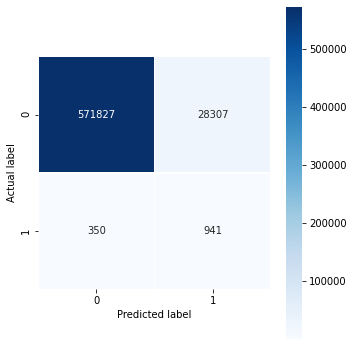

[0]	validation_0-aucpr:0.18805
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.195811
[2]	validation_0-aucpr:0.196717
[3]	validation_0-aucpr:0.199852
[4]	validation_0-aucpr:0.200207
[5]	validation_0-aucpr:0.202978
[6]	validation_0-aucpr:0.205328
[7]	validation_0-aucpr:0.209587
[8]	validation_0-aucpr:0.210895
[9]	validation_0-aucpr:0.225403
[10]	validation_0-aucpr:0.243006
[11]	validation_0-aucpr:0.24508
[12]	validation_0-aucpr:0.247959
[13]	validation_0-aucpr:0.252918
[14]	validation_0-aucpr:0.255714
[15]	validation_0-aucpr:0.261975
[16]	validation_0-aucpr:0.294319
[17]	validation_0-aucpr:0.292984
[18]	validation_0-aucpr:0.293629
[19]	validation_0-aucpr:0.312177
[20]	validation_0-aucpr:0.316508
[21]	validation_0-aucpr:0.313611
[22]	validation_0-aucpr:0.323801
[23]	validation_0-aucpr:0.333715
[24]	validation_0-aucpr:0.340809
[25]	validation_0-aucpr:0.341519
[26]	validation_0-aucpr:0.347379
[27]	validation_0-aucpr:0.351383
[28]	validation_0-aucp

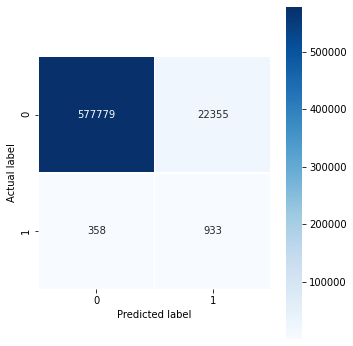

[0]	validation_0-aucpr:0.096032
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.099623
[2]	validation_0-aucpr:0.117036
[3]	validation_0-aucpr:0.139567
[4]	validation_0-aucpr:0.139476
[5]	validation_0-aucpr:0.144247
[6]	validation_0-aucpr:0.140644
[7]	validation_0-aucpr:0.143194
[8]	validation_0-aucpr:0.148438
[9]	validation_0-aucpr:0.149971
[10]	validation_0-aucpr:0.155046
[11]	validation_0-aucpr:0.155876
[12]	validation_0-aucpr:0.157111
[13]	validation_0-aucpr:0.163365
[14]	validation_0-aucpr:0.168745
[15]	validation_0-aucpr:0.169137
[16]	validation_0-aucpr:0.169544
[17]	validation_0-aucpr:0.172649
[18]	validation_0-aucpr:0.173608
[19]	validation_0-aucpr:0.174593
[20]	validation_0-aucpr:0.17743
[21]	validation_0-aucpr:0.179972
[22]	validation_0-aucpr:0.20032
[23]	validation_0-aucpr:0.202008
[24]	validation_0-aucpr:0.205154
[25]	validation_0-aucpr:0.205875
[26]	validation_0-aucpr:0.210344
[27]	validation_0-aucpr:0.212359
[28]	validation_0-aucp

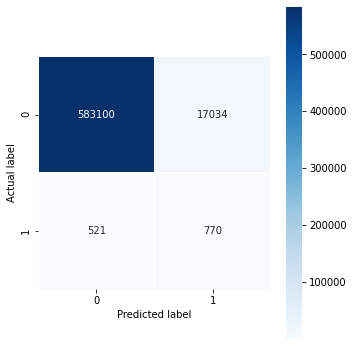

[0]	validation_0-aucpr:0.069277
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.071822
[2]	validation_0-aucpr:0.069791
[3]	validation_0-aucpr:0.072661
[4]	validation_0-aucpr:0.073108
[5]	validation_0-aucpr:0.077315
[6]	validation_0-aucpr:0.078719
[7]	validation_0-aucpr:0.082939
[8]	validation_0-aucpr:0.09827
[9]	validation_0-aucpr:0.10147
[10]	validation_0-aucpr:0.103914
[11]	validation_0-aucpr:0.105839
[12]	validation_0-aucpr:0.111546
[13]	validation_0-aucpr:0.112731
[14]	validation_0-aucpr:0.124862
[15]	validation_0-aucpr:0.125604
[16]	validation_0-aucpr:0.129894
[17]	validation_0-aucpr:0.131855
[18]	validation_0-aucpr:0.140149
[19]	validation_0-aucpr:0.140861
[20]	validation_0-aucpr:0.153162
[21]	validation_0-aucpr:0.15553
[22]	validation_0-aucpr:0.165785
[23]	validation_0-aucpr:0.161861
[24]	validation_0-aucpr:0.168891
[25]	validation_0-aucpr:0.168991
[26]	validation_0-aucpr:0.171375
[27]	validation_0-aucpr:0.170503
[28]	validation_0-aucpr

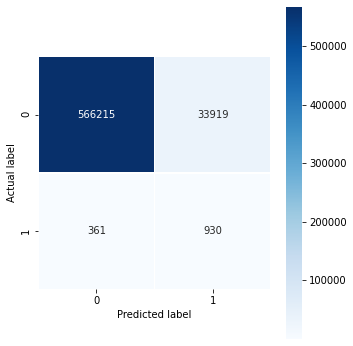

[0]	validation_0-aucpr:0.071662
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.075673
[2]	validation_0-aucpr:0.082145
[3]	validation_0-aucpr:0.081243
[4]	validation_0-aucpr:0.099713
[5]	validation_0-aucpr:0.100364
[6]	validation_0-aucpr:0.101754
[7]	validation_0-aucpr:0.102376
[8]	validation_0-aucpr:0.10284
[9]	validation_0-aucpr:0.114055
[10]	validation_0-aucpr:0.117687
[11]	validation_0-aucpr:0.125245
[12]	validation_0-aucpr:0.125949
[13]	validation_0-aucpr:0.126944
[14]	validation_0-aucpr:0.130108
[15]	validation_0-aucpr:0.148125
[16]	validation_0-aucpr:0.155898
[17]	validation_0-aucpr:0.154217
[18]	validation_0-aucpr:0.162685
[19]	validation_0-aucpr:0.170446
[20]	validation_0-aucpr:0.169304
[21]	validation_0-aucpr:0.171921
[22]	validation_0-aucpr:0.187894
[23]	validation_0-aucpr:0.198755
[24]	validation_0-aucpr:0.201551
[25]	validation_0-aucpr:0.201412
[26]	validation_0-aucpr:0.19954
[27]	validation_0-aucpr:0.201788
[28]	validation_0-aucp

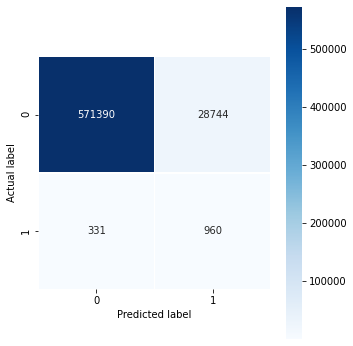

[0]	validation_0-aucpr:0.059545
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.135931
[2]	validation_0-aucpr:0.134973
[3]	validation_0-aucpr:0.139602
[4]	validation_0-aucpr:0.139402
[5]	validation_0-aucpr:0.140605
[6]	validation_0-aucpr:0.142252
[7]	validation_0-aucpr:0.14192
[8]	validation_0-aucpr:0.141864
[9]	validation_0-aucpr:0.14505
[10]	validation_0-aucpr:0.151192
[11]	validation_0-aucpr:0.152975
[12]	validation_0-aucpr:0.151969
[13]	validation_0-aucpr:0.153055
[14]	validation_0-aucpr:0.14655
[15]	validation_0-aucpr:0.158907
[16]	validation_0-aucpr:0.163589
[17]	validation_0-aucpr:0.162235
[18]	validation_0-aucpr:0.168901
[19]	validation_0-aucpr:0.179878
[20]	validation_0-aucpr:0.177483
[21]	validation_0-aucpr:0.201825
[22]	validation_0-aucpr:0.20106
[23]	validation_0-aucpr:0.201329
[24]	validation_0-aucpr:0.215673
[25]	validation_0-aucpr:0.214036
[26]	validation_0-aucpr:0.213319
[27]	validation_0-aucpr:0.221986
[28]	validation_0-aucpr:

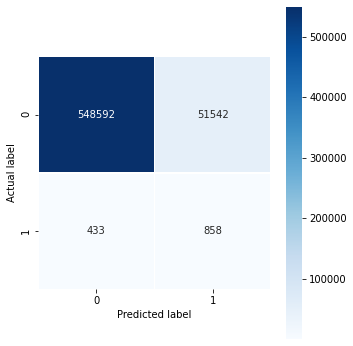

[0]	validation_0-aucpr:0.16073
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.163866
[2]	validation_0-aucpr:0.165907
[3]	validation_0-aucpr:0.167191
[4]	validation_0-aucpr:0.170972
[5]	validation_0-aucpr:0.171327
[6]	validation_0-aucpr:0.171194
[7]	validation_0-aucpr:0.170865
[8]	validation_0-aucpr:0.166172
[9]	validation_0-aucpr:0.174174
[10]	validation_0-aucpr:0.202564
[11]	validation_0-aucpr:0.207543
[12]	validation_0-aucpr:0.207527
[13]	validation_0-aucpr:0.211405
[14]	validation_0-aucpr:0.244861
[15]	validation_0-aucpr:0.246894
[16]	validation_0-aucpr:0.26647
[17]	validation_0-aucpr:0.268789
[18]	validation_0-aucpr:0.301021
[19]	validation_0-aucpr:0.296542
[20]	validation_0-aucpr:0.298262
[21]	validation_0-aucpr:0.32338
[22]	validation_0-aucpr:0.328507
[23]	validation_0-aucpr:0.352338
[24]	validation_0-aucpr:0.355702
[25]	validation_0-aucpr:0.364824
[26]	validation_0-aucpr:0.367717
[27]	validation_0-aucpr:0.372581
[28]	validation_0-aucpr

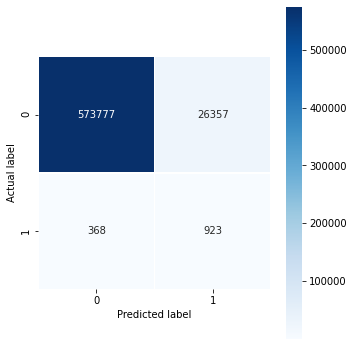

[0]	validation_0-aucpr:0.134296
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.143554
[2]	validation_0-aucpr:0.147185
[3]	validation_0-aucpr:0.153884
[4]	validation_0-aucpr:0.153531
[5]	validation_0-aucpr:0.15342
[6]	validation_0-aucpr:0.155477
[7]	validation_0-aucpr:0.16061
[8]	validation_0-aucpr:0.15995
[9]	validation_0-aucpr:0.191589
[10]	validation_0-aucpr:0.189635
[11]	validation_0-aucpr:0.185786
[12]	validation_0-aucpr:0.195132
[13]	validation_0-aucpr:0.198098
[14]	validation_0-aucpr:0.196801
[15]	validation_0-aucpr:0.208486
[16]	validation_0-aucpr:0.209597
[17]	validation_0-aucpr:0.216509
[18]	validation_0-aucpr:0.212653
[19]	validation_0-aucpr:0.21438
[20]	validation_0-aucpr:0.220378
[21]	validation_0-aucpr:0.229704
[22]	validation_0-aucpr:0.243381
[23]	validation_0-aucpr:0.257514
[24]	validation_0-aucpr:0.258398
[25]	validation_0-aucpr:0.273539
[26]	validation_0-aucpr:0.273386
[27]	validation_0-aucpr:0.271592
[28]	validation_0-aucpr:

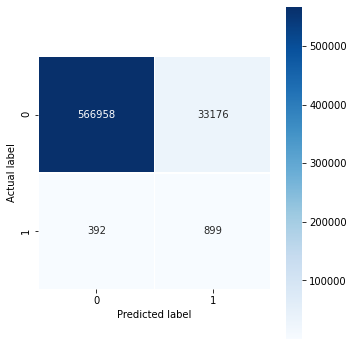

[0]	validation_0-aucpr:0.111293
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.115511
[2]	validation_0-aucpr:0.11692
[3]	validation_0-aucpr:0.147653
[4]	validation_0-aucpr:0.147202
[5]	validation_0-aucpr:0.153697
[6]	validation_0-aucpr:0.165791
[7]	validation_0-aucpr:0.166485
[8]	validation_0-aucpr:0.166667
[9]	validation_0-aucpr:0.165557
[10]	validation_0-aucpr:0.167861
[11]	validation_0-aucpr:0.172041
[12]	validation_0-aucpr:0.180931
[13]	validation_0-aucpr:0.1766
[14]	validation_0-aucpr:0.193802
[15]	validation_0-aucpr:0.196637
[16]	validation_0-aucpr:0.200787
[17]	validation_0-aucpr:0.200515
[18]	validation_0-aucpr:0.200758
[19]	validation_0-aucpr:0.214686
[20]	validation_0-aucpr:0.221271
[21]	validation_0-aucpr:0.254372
[22]	validation_0-aucpr:0.254832
[23]	validation_0-aucpr:0.252848
[24]	validation_0-aucpr:0.252542
[25]	validation_0-aucpr:0.255032
[26]	validation_0-aucpr:0.260767
[27]	validation_0-aucpr:0.262243
[28]	validation_0-aucpr

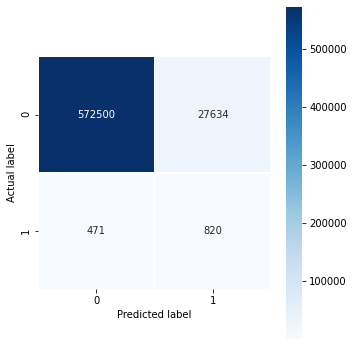

[0]	validation_0-aucpr:0.056051
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.058748
[2]	validation_0-aucpr:0.067643
[3]	validation_0-aucpr:0.074365
[4]	validation_0-aucpr:0.073334
[5]	validation_0-aucpr:0.074332
[6]	validation_0-aucpr:0.075674
[7]	validation_0-aucpr:0.076795
[8]	validation_0-aucpr:0.079267
[9]	validation_0-aucpr:0.079613
[10]	validation_0-aucpr:0.086843
[11]	validation_0-aucpr:0.084916
[12]	validation_0-aucpr:0.090573
[13]	validation_0-aucpr:0.092431
[14]	validation_0-aucpr:0.106962
[15]	validation_0-aucpr:0.105145
[16]	validation_0-aucpr:0.109139
[17]	validation_0-aucpr:0.113813
[18]	validation_0-aucpr:0.118307
[19]	validation_0-aucpr:0.118909
[20]	validation_0-aucpr:0.123539
[21]	validation_0-aucpr:0.128043
[22]	validation_0-aucpr:0.130399
[23]	validation_0-aucpr:0.130898
[24]	validation_0-aucpr:0.138165
[25]	validation_0-aucpr:0.139815
[26]	validation_0-aucpr:0.140826
[27]	validation_0-aucpr:0.144347
[28]	validation_0-au

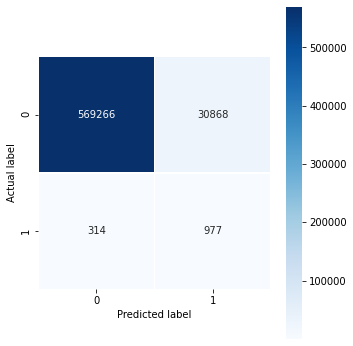

[0]	validation_0-aucpr:0.133273
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.140642
[2]	validation_0-aucpr:0.141738
[3]	validation_0-aucpr:0.147623
[4]	validation_0-aucpr:0.148537
[5]	validation_0-aucpr:0.151066
[6]	validation_0-aucpr:0.150348
[7]	validation_0-aucpr:0.161191
[8]	validation_0-aucpr:0.193418
[9]	validation_0-aucpr:0.189654
[10]	validation_0-aucpr:0.189411
[11]	validation_0-aucpr:0.223443
[12]	validation_0-aucpr:0.231045
[13]	validation_0-aucpr:0.238337
[14]	validation_0-aucpr:0.250339
[15]	validation_0-aucpr:0.264151
[16]	validation_0-aucpr:0.275759
[17]	validation_0-aucpr:0.274552
[18]	validation_0-aucpr:0.279789
[19]	validation_0-aucpr:0.285641
[20]	validation_0-aucpr:0.284305
[21]	validation_0-aucpr:0.27889
[22]	validation_0-aucpr:0.294492
[23]	validation_0-aucpr:0.292919
[24]	validation_0-aucpr:0.297164
[25]	validation_0-aucpr:0.315176
[26]	validation_0-aucpr:0.316439
[27]	validation_0-aucpr:0.321005
[28]	validation_0-auc

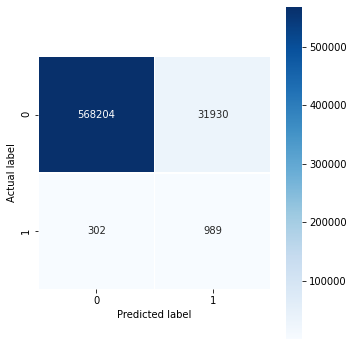

[0]	validation_0-aucpr:0.077505
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.082612
[2]	validation_0-aucpr:0.08516
[3]	validation_0-aucpr:0.090489
[4]	validation_0-aucpr:0.140821
[5]	validation_0-aucpr:0.142212
[6]	validation_0-aucpr:0.141188
[7]	validation_0-aucpr:0.141871
[8]	validation_0-aucpr:0.161029
[9]	validation_0-aucpr:0.158118
[10]	validation_0-aucpr:0.162287
[11]	validation_0-aucpr:0.169795
[12]	validation_0-aucpr:0.178193
[13]	validation_0-aucpr:0.198766
[14]	validation_0-aucpr:0.195039
[15]	validation_0-aucpr:0.201429
[16]	validation_0-aucpr:0.229123
[17]	validation_0-aucpr:0.229192
[18]	validation_0-aucpr:0.231944
[19]	validation_0-aucpr:0.24493
[20]	validation_0-aucpr:0.267711
[21]	validation_0-aucpr:0.283994
[22]	validation_0-aucpr:0.28877
[23]	validation_0-aucpr:0.296913
[24]	validation_0-aucpr:0.305803
[25]	validation_0-aucpr:0.313427
[26]	validation_0-aucpr:0.320743
[27]	validation_0-aucpr:0.322914
[28]	validation_0-aucpr

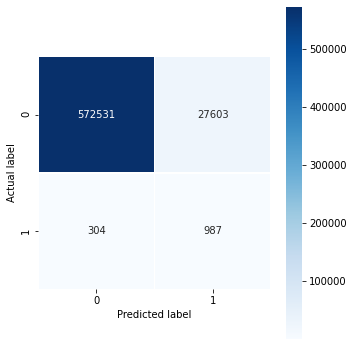

In [124]:
shuffled_flow_id_loss = flow_id_loss.copy()
shuffled_flow_id_no_loss = flow_id_no_loss.copy()

recall_0_list_xgb_2 = []
recall_1_list_xgb_2 = []
recall_avg_list_xgb_2 = []

for trial in range(1, 51):
    random.seed(trial)
    
    random.shuffle(shuffled_flow_id_loss)
    random.shuffle(shuffled_flow_id_no_loss)
    
    df_loss_new = pd.concat([df_loss[df_loss['flow_id']==x] for x in shuffled_flow_id_loss])
    df_no_loss_new = pd.concat([df_no_loss[df_no_loss['flow_id']==x] for x in shuffled_flow_id_no_loss])
            
    df_train = pd.concat([df_loss_new.iloc[0:int(df_loss_new.shape[0] * 0.7)], df_no_loss_new.iloc[0:int(df_no_loss_new.shape[0] * 0.7)]])
    df_train_shuffled = df_train.sample(frac=1).reset_index()
    df_train_shuffled.drop(['index'], axis=1, inplace=True)
    df_test = pd.concat([df_loss_new.iloc[int(df_loss_new.shape[0] * 0.7)+1: -1], df_no_loss_new.iloc[int(df_no_loss_new.shape[0] * 0.7)+1: -1]])
    df_test_shuffled = df_test.sample(frac=1).reset_index()
    df_test_shuffled.drop(['index'], axis=1, inplace=True)

    x_train = df_train_shuffled[full_features_list_removing_500ms]
    x_test = df_test_shuffled[full_features_list_removing_500ms]
    y_train = df_train_shuffled[['lossOrNot']]
    y_train = y_train.astype(int)
    y_test = df_test_shuffled[['lossOrNot']]
    y_test = y_test.astype(int)
    
    clf_xgb_check = xgb.XGBClassifier(
        n_estimators=500, 
        objective='binary:logistic', 
        scale_pos_weight=weight, 
        n_jobs=48
    )
    
    clf_xgb_check.fit(x_train, y_train, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(x_test, y_test)])
            
    y_pred = clf_xgb_check.predict(x_test)
    print(f"Prediction Report of trial {trial}\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
    report = classification_report(y_test, y_pred, output_dict=True)
    recall_0_list_xgb_2.append(report['0']['recall'])
    recall_1_list_xgb_2.append(report['1']['recall'])
    recall_avg_list_xgb_2.append(report['macro avg']['recall'])

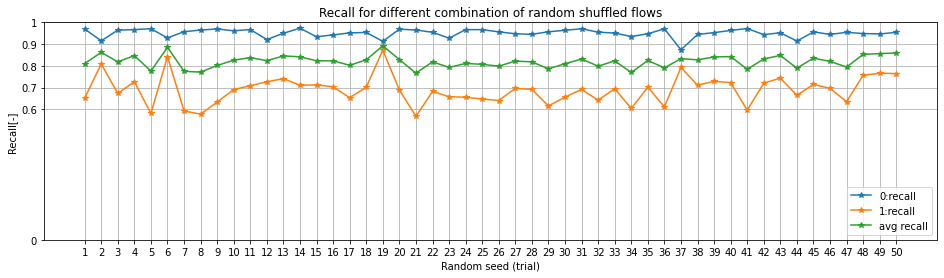

The best performance is at trial 19:
   recall of class 0: 0.9127478196536107
   recall of class 1: 0.8721920991479474
   macro average recall: 0.892469959400779
              OR
The best performance is at trial 6:
   recall of class 0: 0.9283959915618845
   recall of class 1: 0.8427575522850503
   macro average recall: 0.8855767719234674

The average is 0.9507453668680661 (0:recall), 0.6894190549961269 (1:recall), 0.8200822109320965 (avg recall)


In [327]:
x_label = list(range(1,51))
plt.figure(figsize=(16,4))
plt.plot(x_label, recall_0_list_xgb_2, '*-', label='0:recall')
plt.plot(x_label, recall_1_list_xgb_2, '*-', label='1:recall')
plt.plot(x_label, recall_avg_list_xgb_2, '*-', label='avg recall')
plt.xticks(x_label, x_label)
plt.legend(loc=4)
plt.grid()
plt.ylim([0,1])
plt.yticks([0, 0.6, 0.7, 0.8, 0.9, 1], [0, 0.6, 0.7, 0.8, 0.9, 1])
plt.title('Recall for different combination of random shuffled flows')
plt.xlabel('Random seed (trial)')
plt.ylabel('Recall[-]')
plt.show()

print(f'The best performance is at trial 19:\n   recall of class 0: {recall_0_list_xgb_2[18]}\n   recall of class 1: {recall_1_list_xgb_2[18]}\n   macro average recall: {recall_avg_list_xgb_2[18]}')
print('              OR')
print(f'The best performance is at trial 6:\n   recall of class 0: {recall_0_list_xgb_2[5]}\n   recall of class 1: {recall_1_list_xgb_2[5]}\n   macro average recall: {recall_avg_list_xgb_2[5]}')
print()
print(f'The average is {np.array(recall_0_list_xgb_2).mean()} (0:recall), {np.array(recall_1_list_xgb_2).mean()} (1:recall), {np.array(recall_avg_list_xgb_2).mean()} (avg recall)')

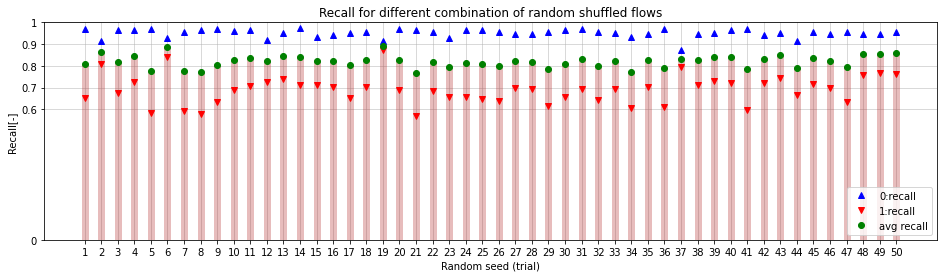

In [278]:
x_label = list(range(1,51))
plt.figure(figsize=(16,4))
plt.plot(x_label, recall_0_list_xgb_2, '^', label='0:recall', color='b')
plt.plot(x_label, recall_1_list_xgb_2, 'v', label='1:recall', color='r')
plt.plot(x_label, recall_avg_list_xgb_2, 'o', label='avg recall', color='g')
plt.vlines(x=x_label, ymin=0, ymax=recall_avg_list_xgb_2, linestyles='solid', color='firebrick', alpha=0.3, linewidth=7)
plt.xticks(x_label, x_label)
plt.legend(loc=4)
plt.grid(alpha=0.6)
plt.ylim([0,1])
plt.yticks([0, 0.6, 0.7, 0.8, 0.9, 1], [0, 0.6, 0.7, 0.8, 0.9, 1])
plt.title('Recall for different combination of random shuffled flows')
plt.xlabel('Random seed (trial)')
plt.ylabel('Recall[-]')
plt.show()

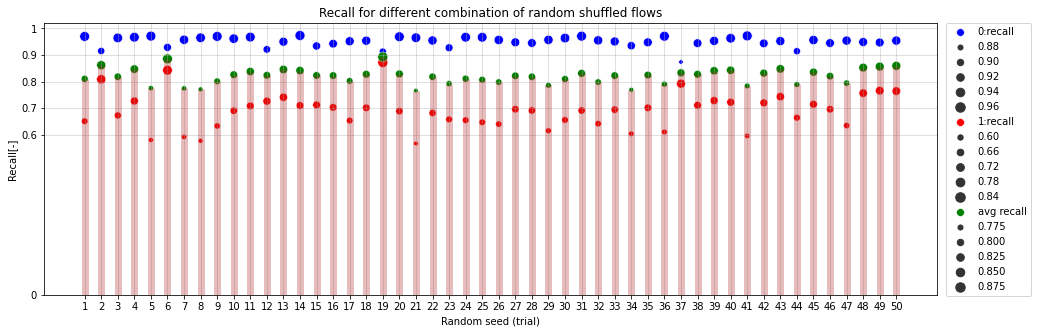

In [280]:
plt.figure(figsize=(16,5))
sns.scatterplot(x=x_label, y=recall_0_list_xgb_2, label='0:recall', size=recall_0_list_xgb_2, sizes=(20, 100), color='b')
sns.scatterplot(x=x_label, y=recall_1_list_xgb_2, label='1:recall', size=recall_1_list_xgb_2, sizes=(20, 100), color='r')
sns.scatterplot(x=x_label, y=recall_avg_list_xgb_2, label='avg recall', size=recall_avg_list_xgb_2, sizes=(20, 100), color='g')
plt.vlines(x=x_label, ymin=0, ymax=recall_avg_list_xgb_2, linestyles='solid', color='firebrick', alpha=0.3, linewidth=7)
plt.xticks(x_label, x_label)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.grid(alpha=0.5)
plt.ylim([0,1.02])
plt.yticks([0, 0.6, 0.7, 0.8, 0.9, 1], [0, 0.6, 0.7, 0.8, 0.9, 1])
plt.title('Recall for different combination of random shuffled flows')
plt.xlabel('Random seed (trial)')
plt.ylabel('Recall[-]')
plt.show()

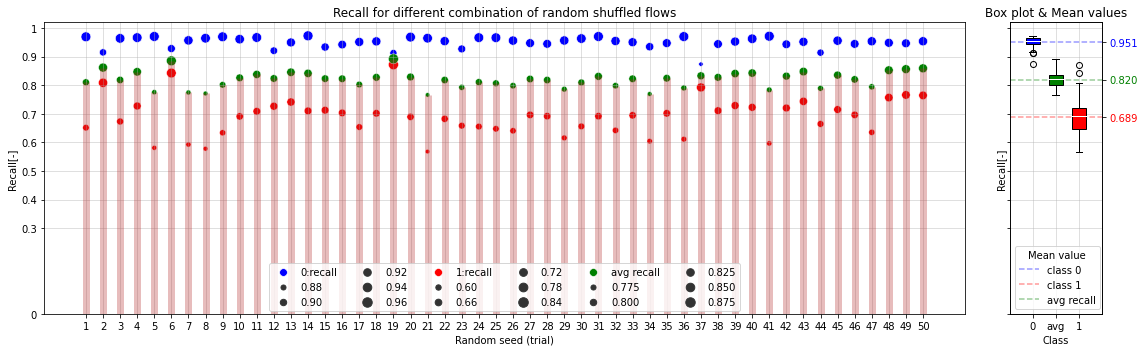

In [493]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), sharey=True, gridspec_kw={'width_ratios': [10, 1]})

sns.scatterplot(x=x_label, y=recall_0_list_xgb_2, label='0:recall', size=recall_0_list_xgb_2, sizes=(20, 100), color='b', ax=ax1)
sns.scatterplot(x=x_label, y=recall_1_list_xgb_2, label='1:recall', size=recall_1_list_xgb_2, sizes=(20, 100), color='r', ax=ax1)
sns.scatterplot(x=x_label, y=recall_avg_list_xgb_2, label='avg recall', size=recall_avg_list_xgb_2, sizes=(20, 100), color='g', ax=ax1)
ax1.vlines(x=x_label, ymin=0, ymax=recall_avg_list_xgb_2, linestyles='solid', color='firebrick', alpha=0.3, linewidth=7)
ax1.set_xticks(x_label)
ax1.legend(loc='lower center', bbox_to_anchor=(0.5, 0.01), borderaxespad=0, ncol=6)
ax1.grid(alpha=0.5)
plt.ylim([0,1.02])
plt.yticks([0, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], [0, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax1.set_xlabel('Random seed (trial)')
ax1.set_ylabel('Recall[-]')
ax1.set_title('Recall for different combination of random shuffled flows')

box = ax2.boxplot([recall_0_list_xgb_2, recall_1_list_xgb_2, recall_avg_list_xgb_2], positions=[1, 2, 1.5], widths=0.3, patch_artist=True) # meanline=True, showmeans=True
ax2.set_title('Box plot & Mean values')
ax2.set_xticks([1, 2, 1.5])
ax2.set_xticklabels(['0', '1', 'avg'])
ax2.set_xlabel('Class')
ax2.grid(alpha=0.5)
ax2.set_ylabel('Recall[-]')
# ax2.yaxis.set_label_position("right")
colors = ['blue', 'red', 'green']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
for median in box['medians']:
    median.set_color('white')
ax2.axhline(y=0.951, color='b', linestyle='--', alpha=0.4, label='class 0')
ax2.axhline(y=0.689, color='r', linestyle='--', alpha=0.4, label='class 1')
ax2.axhline(y=0.820, color='g', linestyle='--', alpha=0.4, label='avg recall')
ax2.legend(title='Mean value')
ax3 = ax2.twinx()
ax3.set_yticks([0.951, 0.689, 0.820])
ax3.set_ylim([0,1.02])
ax3.get_yticklabels()[0].set_color("b")
ax3.get_yticklabels()[1].set_color("r")
ax3.get_yticklabels()[2].set_color("g")

plt.tight_layout()
plt.show()

In [508]:
print(recall_0_list_xgb_2)
print(recall_1_list_xgb_2)
print(recall_avg_list_xgb_2)

[0.9696167855845528, 0.9150506386906924, 0.9640846877530684, 0.9667274308737716, 0.970748199568763, 0.9283959915618845, 0.957046259668674, 0.9646129031183036, 0.9696434462969936, 0.9612536533507516, 0.96713067414944, 0.9209759820306798, 0.9498661965494373, 0.9730810119073406, 0.9337797891804164, 0.942414527422209, 0.9515591517894337, 0.9535836996404137, 0.9127478196536107, 0.9685486907923897, 0.9647512055640907, 0.954433509849467, 0.927134606604525, 0.9666757757434173, 0.9664908170508586, 0.956311423782022, 0.9474900605531431, 0.9449722895220067, 0.9566646782218637, 0.9634548284216525, 0.9706032319448656, 0.9549100700843478, 0.9506793482788843, 0.9348778772740755, 0.9474717313133401, 0.9703716170055354, 0.8737898535993628, 0.9442991065328743, 0.9528322008084861, 0.9627499858364965, 0.9716163390176193, 0.9434809559198446, 0.9521040300999444, 0.9141158474607338, 0.9560814751372193, 0.9447190127538183, 0.9539536170255309, 0.9485648205234164, 0.9467952157351525, 0.9540052721558852]
[0.6514

In [130]:
recall_0_list_xgb_2

[0.9696167855845528,
 0.9150506386906924,
 0.9640846877530684,
 0.9667274308737716,
 0.970748199568763,
 0.9283959915618845,
 0.957046259668674,
 0.9646129031183036,
 0.9696434462969936,
 0.9612536533507516,
 0.96713067414944,
 0.9209759820306798,
 0.9498661965494373,
 0.9730810119073406,
 0.9337797891804164,
 0.942414527422209,
 0.9515591517894337,
 0.9535836996404137,
 0.9127478196536107,
 0.9685486907923897,
 0.9647512055640907,
 0.954433509849467,
 0.927134606604525,
 0.9666757757434173,
 0.9664908170508586,
 0.956311423782022,
 0.9474900605531431,
 0.9449722895220067,
 0.9566646782218637,
 0.9634548284216525,
 0.9706032319448656,
 0.9549100700843478,
 0.9506793482788843,
 0.9348778772740755,
 0.9474717313133401,
 0.9703716170055354,
 0.8737898535993628,
 0.9442991065328743,
 0.9528322008084861,
 0.9627499858364965,
 0.9716163390176193,
 0.9434809559198446,
 0.9521040300999444,
 0.9141158474607338,
 0.9560814751372193,
 0.9447190127538183,
 0.9539536170255309,
 0.9485648205234164,


In [131]:
recall_1_list_xgb_2

[0.65143299767622,
 0.8086754453911696,
 0.673121611154144,
 0.7273431448489543,
 0.5809450038729667,
 0.8427575522850503,
 0.592563903950426,
 0.5778466305189776,
 0.6336173508907823,
 0.6909372579395817,
 0.7087529047250194,
 0.726568551510457,
 0.7412858249419055,
 0.710302091402014,
 0.7126258714175058,
 0.7033307513555384,
 0.6537567776917118,
 0.7017815646785438,
 0.8721920991479474,
 0.6893880712625872,
 0.5677769171185127,
 0.6824167312161116,
 0.6584043377226956,
 0.6553059643687065,
 0.6475600309837335,
 0.6405886909372579,
 0.6963594113090628,
 0.691711851278079,
 0.6158017041053447,
 0.6560805577072037,
 0.691711851278079,
 0.6421378776142526,
 0.6948102246320682,
 0.6041828040278854,
 0.7017815646785438,
 0.611154144074361,
 0.7924089852827265,
 0.7110766847405112,
 0.7288923315259489,
 0.7226955848179706,
 0.5964368706429125,
 0.7203718048024786,
 0.7436096049573974,
 0.6646010844306739,
 0.7149496514329977,
 0.6963594113090628,
 0.635166537567777,
 0.7567776917118513,
 0

In [132]:
recall_avg_list_xgb_2

[0.8105248916303864,
 0.861863042040931,
 0.8186031494536062,
 0.847035287861363,
 0.7758466017208648,
 0.8855767719234674,
 0.77480508180955,
 0.7712297668186405,
 0.801630398593888,
 0.8260954556451667,
 0.8379417894372296,
 0.8237722667705684,
 0.8455760107456713,
 0.8416915516546772,
 0.8232028302989611,
 0.8228726393888737,
 0.8026579647405727,
 0.8276826321594788,
 0.892469959400779,
 0.8289683810274884,
 0.7662640613413016,
 0.8184251205327893,
 0.7927694721636103,
 0.810990870056062,
 0.807025424017296,
 0.79845005735964,
 0.8219247359311029,
 0.8183420704000428,
 0.7862331911636042,
 0.8097676930644282,
 0.8311575416114723,
 0.7985239738493002,
 0.8227447864554762,
 0.7695303406509804,
 0.8246266479959419,
 0.7907628805399483,
 0.8330994194410446,
 0.8276878956366928,
 0.8408622661672175,
 0.8427227853272335,
 0.784026604830266,
 0.8319263803611616,
 0.8478568175286709,
 0.7893584659457038,
 0.8355155632851086,
 0.8205392120314405,
 0.7945600772966539,
 0.8526712561176338,
 0.

Prediction Report of trial 19
               precision    recall  f1-score   support

           0       1.00      0.88      0.94    600134
           1       0.02      0.91      0.03      1291

    accuracy                           0.88    601425
   macro avg       0.51      0.90      0.48    601425
weighted avg       1.00      0.88      0.93    601425



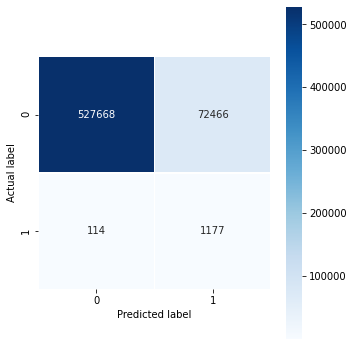

[0]	validation_0-aucpr:0.184931
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.196194
[2]	validation_0-aucpr:0.209505
[3]	validation_0-aucpr:0.22378
[4]	validation_0-aucpr:0.222351
[5]	validation_0-aucpr:0.228189
[6]	validation_0-aucpr:0.231044
[7]	validation_0-aucpr:0.256378
[8]	validation_0-aucpr:0.254715
[9]	validation_0-aucpr:0.266943
[10]	validation_0-aucpr:0.2676
[11]	validation_0-aucpr:0.275236
[12]	validation_0-aucpr:0.273992
[13]	validation_0-aucpr:0.287213
[14]	validation_0-aucpr:0.287014
[15]	validation_0-aucpr:0.291406
[16]	validation_0-aucpr:0.329849
[17]	validation_0-aucpr:0.33001
[18]	validation_0-aucpr:0.339468
[19]	validation_0-aucpr:0.346496
[20]	validation_0-aucpr:0.374854
[21]	validation_0-aucpr:0.374092
[22]	validation_0-aucpr:0.369628
[23]	validation_0-aucpr:0.37517
[24]	validation_0-aucpr:0.378331
[25]	validation_0-aucpr:0.394851
[26]	validation_0-aucpr:0.429924
[27]	validation_0-aucpr:0.415927
[28]	validation_0-aucpr:0

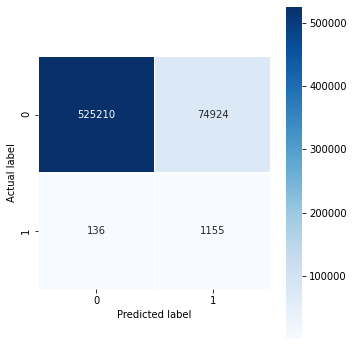

In [133]:
# # check how old best features behave for both models at trial 19

# shuffled_flow_id_loss = flow_id_loss.copy()
# shuffled_flow_id_no_loss = flow_id_no_loss.copy()

# for trial in range(1, 51):
#     random.seed(trial)
    
#     random.shuffle(shuffled_flow_id_loss)
#     random.shuffle(shuffled_flow_id_no_loss)
    
#     if trial == 19:
#         df_loss_new = pd.concat([df_loss[df_loss['flow_id']==x] for x in shuffled_flow_id_loss])
#         df_no_loss_new = pd.concat([df_no_loss[df_no_loss['flow_id']==x] for x in shuffled_flow_id_no_loss])

#         df_train = pd.concat([df_loss_new.iloc[0:int(df_loss_new.shape[0] * 0.7)], df_no_loss_new.iloc[0:int(df_no_loss_new.shape[0] * 0.7)]])
#         df_train_shuffled = df_train.sample(frac=1).reset_index()
#         df_train_shuffled.drop(['index'], axis=1, inplace=True)
#         df_test = pd.concat([df_loss_new.iloc[int(df_loss_new.shape[0] * 0.7)+1: -1], df_no_loss_new.iloc[int(df_no_loss_new.shape[0] * 0.7)+1: -1]])
#         df_test_shuffled = df_test.sample(frac=1).reset_index()
#         df_test_shuffled.drop(['index'], axis=1, inplace=True)

#         x_train = df_train_shuffled[best_feature_list_removing_500ms]
#         x_test = df_test_shuffled[best_feature_list_removing_500ms]
#         y_train = df_train_shuffled[['lossOrNot']]
#         y_train = y_train.astype(int)
#         y_test = df_test_shuffled[['lossOrNot']]
#         y_test = y_test.astype(int)

#         # brf
#         my_brf_model_check = BalancedRandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=0) 
#         my_brf_model_check.fit(x_train, y_train)

#         y_pred = my_brf_model_check.predict(x_test)
#         print(f"Prediction Report of trial {trial}\n", classification_report(y_test, y_pred))
#         cm = confusion_matrix(y_test, y_pred)
#         plt.figure(figsize=(5,5))
#         sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
#         plt.ylabel('Actual label')
#         plt.xlabel('Predicted label')
#         plt.tight_layout()
#         plt.show()
        
#         # xgboost
#         clf_xgb_check = xgb.XGBClassifier(
#             n_estimators=500, 
#             objective='binary:logistic', 
#             scale_pos_weight=weight, 
#             n_jobs=48
#         )
#         clf_xgb_check.fit(x_train, y_train, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(x_test, y_test)])

#         y_pred = clf_xgb_check.predict(x_test)
#         print(f"Prediction Report of trial {trial}\n", classification_report(y_test, y_pred))
#         cm = confusion_matrix(y_test, y_pred)
#         plt.figure(figsize=(5,5))
#         sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
#         plt.ylabel('Actual label')
#         plt.xlabel('Predicted label')
#         plt.tight_layout()
#         plt.show()
        
#         break

### Step 4

#### build new dataset

In [9]:
dfs = []
app_list = [
    'facetime',
    'google_meet',
    'houseparty',
    'instagram',
    'jitsi',
    'skype',
    'whatsapp'
]

EXTENTION = '*_500ms_Song.csv'
for app in app_list:
    PATH = 'Retina/cisco_ml4qoe/data/antonio/' + app
    for path, subdir, files in os.walk(PATH):
        for file in glob.glob(os.path.join(path, EXTENTION)):
            df = pd.read_csv(file)
            df['name'] = os.path.normpath(file)
            df['app'] = app
            dfs.append(df)

PATH = 'Retina/cisco_ml4qoe/data/dena/webex_teams'
for path, subdir, files in os.walk(PATH):
    for file in glob.glob(os.path.join(path, EXTENTION)):
        df = pd.read_csv(file)
        df['name'] = os.path.normpath(file)
        df['app'] = 'webex'
        dfs.append(df)
        
PATH = 'Retina/cisco_ml4qoe/data/dena/msteams'
EXTENTION = '*_clean_500ms_Song.csv'
for path, subdir, files in os.walk(PATH):
    for file in glob.glob(os.path.join(path, EXTENTION)):
        df = pd.read_csv(file)
        df['name'] = os.path.normpath(file)
        df['app'] = 'msteams'
        dfs.append(df)
        
app_list.append('webex') 
app_list.append('msteams')

In [10]:
scaler = preprocessing.MinMaxScaler() 

df_total = []
for df in dfs:    
    df_inter = copy.deepcopy(df)
    df_inter = df_inter.loc[~df_inter['ip_src'].str.startswith('192')]
    drop_col = [
        'software', 
        'label', 
        'pcap', 
        'ssrc', 
        'rtp_seq_num_packet_loss', 
        'ip_src', 
        'ip_dst', 
        'prt_src', 
        'prt_dst', 
        'rtp_csrc_csrc_agg',
        'p_type',
        'name'
    ]
    for col in df_inter.columns:
        if col in drop_col or col.startswith('rtp_interarrival'): 
            df_inter.drop(col, axis=1, inplace=True)
    
    flow_list = df_inter['flow'].drop_duplicates().tolist()
    for flow in flow_list:
        df_check = df_inter[df_inter['flow'] == flow].copy()
        if df_check.shape[0] > 10: 
            df_total.append(df_check)
            
df_total_final = []
for df_per_flow in df_total:
    df_temp = copy.deepcopy(df_per_flow)
    df_temp.reset_index(inplace=True)
    df_temp['lossOrNot'] = [1 if x>0 else 0 for x in df_temp['num_packet_loss']]
    df_temp.drop(['index', 'flow'], axis=1, inplace=True)
    df_temp['flow_id'] = flow_id
    flow_id += 1
    
    for col in df_temp.columns:
        if col not in ['timestamp', 'lossOrNot', 'num_packet_loss', 'flow_id', 'app']:
            df_temp[col] = scaler.fit_transform(df_temp[col].values.reshape(-1,1))
    
    start_time = pd.to_datetime(df_temp['timestamp'].min())
    stop_time = pd.to_datetime(df_temp['timestamp'].max())
    timestamp_ser = pd.date_range(start_time, stop_time, freq="500L")
    correct_len = len(timestamp_ser)
    
    if df_temp.shape[0] == correct_len:
        df_full = copy.deepcopy(df_temp)
        df_total_final.append(df_full)
    
    else:
        df_temp['timestamp'] = pd.to_datetime(df_temp['timestamp'])
        df_full = pd.DataFrame({'timestamp': timestamp_ser})
        df_full['timestamp'] = df_full['timestamp']
        df_full = df_full.merge(df_temp, on='timestamp', how='left')
        
        nan_index_list = [0]
        nan_index_list.extend(df_full[np.isnan(df_full['interarrival_std'])].index.tolist())
        nan_index_list.append(df_full.index[-1])
        
        for i in range(1, len(nan_index_list)):
            if nan_index_list[i] - nan_index_list[i-1] - 1 >= 11:
                start_idx = 0 if nan_index_list[i-1]==0 else nan_index_list[i-1]+1
                stop_idx = df_full.index[-1]+1 if nan_index_list[i]==df_full.index[-1] else nan_index_list[i]
                df_separate = df_full.iloc[start_idx:stop_idx, :].copy()
                df_separate.reset_index(inplace=True)
                df_separate.drop(['index'], axis=1, inplace=True)
                df_total_final.append(df_separate)

In [11]:
complete_list.append('app')

In [12]:
df_total_final_feature_extraction = []
for df in df_total_final:
    df_temp = copy.deepcopy(df)
    df_temp = df_temp[complete_list]
    temp_feature_list = possible_features_list.copy()
    temp_feature_list.append('lossOrNot')
    for feature in temp_feature_list:
        for i in range(2,11):
            col_title = f'{feature}_minus_{500*i}ms'
            df_temp[col_title] = df_temp[feature].shift(periods=i, fill_value=-1)
    df_temp.drop(possible_features_list, axis=1, inplace=True)
    df_temp = df_temp.iloc[10:]
    df_temp.reset_index(inplace=True)
    df_temp.drop(['index'], axis=1, inplace=True)
    
    df_total_final_feature_extraction.append(df_temp)

In [13]:
df_final_new_with_app = pd.concat(df_total_final_feature_extraction)
df_final_new_with_app.reset_index(inplace=True)
df_final_new_with_app.drop(['index'], axis=1, inplace=True)
df_final_new_with_app

timestamp  lossOrNot  num_packet_loss  flow_id  \
0       2020-03-30 19:37:44.500000        0.0              0.0   2883.0   
1              2020-03-30 19:37:45        0.0              0.0   2883.0   
2       2020-03-30 19:37:45.500000        0.0              0.0   2883.0   
3              2020-03-30 19:37:46        0.0              0.0   2883.0   
4       2020-03-30 19:37:46.500000        0.0              0.0   2883.0   
...                            ...        ...              ...      ...   
384160     2020-07-23 08:47:46.000        0.0              0.0   3615.0   
384161     2020-07-23 08:47:46.500        0.0              0.0   3615.0   
384162     2020-07-23 08:47:47.000        0.0              0.0   3615.0   
384163     2020-07-23 08:47:47.500        0.0              0.0   3615.0   
384164     2020-07-23 08:47:48.000        0.0              0.0   3615.0   

             app  interarrival_std_minus_1000ms  \
0       facetime                       0.099096   
1       facetime                       0.023119   
2       facetime                       0.038126   
3       facetime                       0.002580   
4       facetime                       0.036607   
...          ...                            ...   
384160   msteams                       0.068625   
384161   msteams                       0.093816   
384162   msteams                       0.018611   
384163   msteams                       0.045165   
384164   msteams                       0.063900   

        interarrival_std_minus_1500ms  interarrival_std_minus_2000ms  \
0                            0.046905                       0.036424   
1                            0.099096                       0.046905   
2                            0.023119                       0.099096   
3                            0.038126                       0.023119   
4                            0.002580                       0.038126   
...                               ...                            ...   
384160                       0.025666                       0.048300   
384161                       0.068625                       0.025666   
384162                       0.093816                       0.068625   
384163                       0.018611                       0.093816   
384164                       0.045165                       0.018611   

        interarrival_std_minus_2500ms  interarrival_std_minus_3000ms  ...  \
0                            0.032953                       0.043255  ...   
1                            0.036424                       0.032953  ...   
2                            0.046905                       0.036424  ...   
3                            0.099096                       0.046905  ...   
4                            0.023119                       0.099096  ...   
...                               ...                            ...  ...   
384160                       0.052622                       0.073385  ...   
384161                       0.048300                       0.052622  ...   
384162                       0.025666                       0.048300  ...   
384163                       0.068625                       0.025666  ...   
384164                       0.093816                       0.068625  ...   

        inter_time_sequence_max_value_count_percent_minus_5000ms  \
0                                                0.062280          
1                                                0.058559          
2                                                0.055135          
3                                                0.055135          
4                                                0.055135          
...                                                   ...          
384160                                           0.065625          
384161                                           0.065625          
384162                                           0.080000          
384163                                   

In [14]:
df_final_new = copy.deepcopy(df_final_new_with_app)
df_final_new.drop(columns='app', inplace=True)
df_final_new

timestamp  lossOrNot  num_packet_loss  flow_id  \
0       2020-03-30 19:37:44.500000        0.0              0.0   2883.0   
1              2020-03-30 19:37:45        0.0              0.0   2883.0   
2       2020-03-30 19:37:45.500000        0.0              0.0   2883.0   
3              2020-03-30 19:37:46        0.0              0.0   2883.0   
4       2020-03-30 19:37:46.500000        0.0              0.0   2883.0   
...                            ...        ...              ...      ...   
384160     2020-07-23 08:47:46.000        0.0              0.0   3615.0   
384161     2020-07-23 08:47:46.500        0.0              0.0   3615.0   
384162     2020-07-23 08:47:47.000        0.0              0.0   3615.0   
384163     2020-07-23 08:47:47.500        0.0              0.0   3615.0   
384164     2020-07-23 08:47:48.000        0.0              0.0   3615.0   

        interarrival_std_minus_1000ms  interarrival_std_minus_1500ms  \
0                            0.099096                       0.046905   
1                            0.023119                       0.099096   
2                            0.038126                       0.023119   
3                            0.002580                       0.038126   
4                            0.036607                       0.002580   
...                               ...                            ...   
384160                       0.068625                       0.025666   
384161                       0.093816                       0.068625   
384162                       0.018611                       0.093816   
384163                       0.045165                       0.018611   
384164                       0.063900                       0.045165   

        interarrival_std_minus_2000ms  interarrival_std_minus_2500ms  \
0                            0.036424                       0.032953   
1                            0.046905                       0.036424   
2                            0.099096                       0.046905   
3                            0.023119                       0.099096   
4                            0.038126                       0.023119   
...                               ...                            ...   
384160                       0.048300                       0.052622   
384161                       0.025666                       0.048300   
384162                       0.068625                       0.025666   
384163                       0.093816                       0.068625   
384164                       0.018611                       0.093816   

        interarrival_std_minus_3000ms  interarrival_std_minus_3500ms  ...  \
0                            0.043255                       0.000818  ...   
1                            0.032953                       0.043255  ...   
2                            0.036424                       0.032953  ...   
3                            0.046905                       0.036424  ...   
4                            0.099096                       0.046905  ...   
...                               ...                            ...  ...   
384160                       0.073385                       0.132108  ...   
384161                       0.052622                       0.073385  ...   
384162                       0.048300                       0.052622  ...   
384163                       0.025666                       0.048300  ...   
384164                       0.068625                       0.025666  ...   

        inter_time_sequence_max_value_count_percent_minus_5000ms  \
0                                                0.062280          
1                                                0.058559          
2                                                0.055135          
3                                                0.055135          
4                                                0.055135          
...                                                   ...    

#### considering packet loss as features

In [15]:
df_final_check = pd.concat([df_final_with_flow_id_past_loss, df_final_new])

df_loss = df_final_check[df_final_check['lossOrNot'] > 0]
df_no_loss = df_final_check[df_final_check['lossOrNot'] < 1]

flow_id_loss = df_loss['flow_id'].drop_duplicates().tolist()
flow_id_no_loss = df_no_loss['flow_id'].drop_duplicates().tolist()

In [306]:
weight = len(df_no_loss) / len(df_loss)
weight

39.45784566886884

[0]	validation_0-aucpr:0.388976
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.429501
[2]	validation_0-aucpr:0.439541
[3]	validation_0-aucpr:0.448538
[4]	validation_0-aucpr:0.467423
[5]	validation_0-aucpr:0.469787
[6]	validation_0-aucpr:0.474992
[7]	validation_0-aucpr:0.477708
[8]	validation_0-aucpr:0.477325
[9]	validation_0-aucpr:0.47684
[10]	validation_0-aucpr:0.47824
[11]	validation_0-aucpr:0.478246
[12]	validation_0-aucpr:0.478402
[13]	validation_0-aucpr:0.478907
[14]	validation_0-aucpr:0.479121
[15]	validation_0-aucpr:0.479089
[16]	validation_0-aucpr:0.478957
[17]	validation_0-aucpr:0.477536
[18]	validation_0-aucpr:0.47714
[19]	validation_0-aucpr:0.477152
[20]	validation_0-aucpr:0.477023
[21]	validation_0-aucpr:0.477141
[22]	validation_0-aucpr:0.4756
[23]	validation_0-aucpr:0.474277
[24]	validation_0-aucpr:0.472663
Stopping. Best iteration:
[14]	validation_0-aucpr:0.479121

Prediction Report of trial 1
               precision    recall 

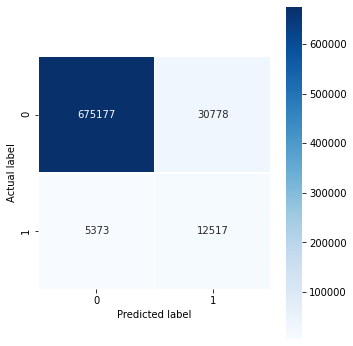

[0]	validation_0-aucpr:0.418429
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.438519
[2]	validation_0-aucpr:0.454235
[3]	validation_0-aucpr:0.459374
[4]	validation_0-aucpr:0.462306
[5]	validation_0-aucpr:0.467804
[6]	validation_0-aucpr:0.464223
[7]	validation_0-aucpr:0.460942
[8]	validation_0-aucpr:0.459576
[9]	validation_0-aucpr:0.461123
[10]	validation_0-aucpr:0.458554
[11]	validation_0-aucpr:0.462789
[12]	validation_0-aucpr:0.46271
[13]	validation_0-aucpr:0.464837
[14]	validation_0-aucpr:0.464952
[15]	validation_0-aucpr:0.464267
Stopping. Best iteration:
[5]	validation_0-aucpr:0.467804

Prediction Report of trial 2
               precision    recall  f1-score   support

           0       0.99      0.95      0.97    705955
           1       0.25      0.71      0.37     17890

    accuracy                           0.94    723845
   macro avg       0.62      0.83      0.67    723845
weighted avg       0.97      0.94      0.95    723845



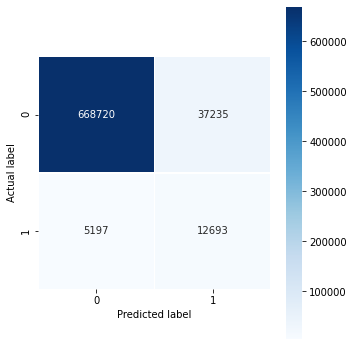

[0]	validation_0-aucpr:0.353262
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.394883
[2]	validation_0-aucpr:0.410418
[3]	validation_0-aucpr:0.414844
[4]	validation_0-aucpr:0.420766
[5]	validation_0-aucpr:0.423529
[6]	validation_0-aucpr:0.422352
[7]	validation_0-aucpr:0.422869
[8]	validation_0-aucpr:0.418047
[9]	validation_0-aucpr:0.416526
[10]	validation_0-aucpr:0.413971
[11]	validation_0-aucpr:0.411077
[12]	validation_0-aucpr:0.412261
[13]	validation_0-aucpr:0.408571
[14]	validation_0-aucpr:0.407326
[15]	validation_0-aucpr:0.407715
Stopping. Best iteration:
[5]	validation_0-aucpr:0.423529

Prediction Report of trial 3
               precision    recall  f1-score   support

           0       0.99      0.95      0.97    705955
           1       0.25      0.62      0.35     17890

    accuracy                           0.94    723845
   macro avg       0.62      0.79      0.66    723845
weighted avg       0.97      0.94      0.96    723845



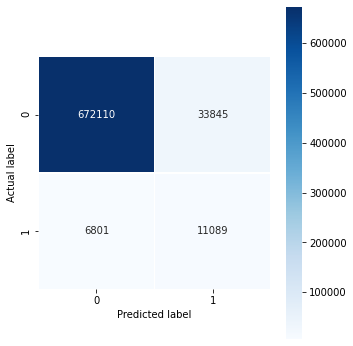

[0]	validation_0-aucpr:0.370904
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.412614
[2]	validation_0-aucpr:0.431475
[3]	validation_0-aucpr:0.437431
[4]	validation_0-aucpr:0.441263
[5]	validation_0-aucpr:0.447932
[6]	validation_0-aucpr:0.44939
[7]	validation_0-aucpr:0.450156
[8]	validation_0-aucpr:0.453618
[9]	validation_0-aucpr:0.455556
[10]	validation_0-aucpr:0.457
[11]	validation_0-aucpr:0.456977
[12]	validation_0-aucpr:0.456858
[13]	validation_0-aucpr:0.457108
[14]	validation_0-aucpr:0.457157
[15]	validation_0-aucpr:0.459844
[16]	validation_0-aucpr:0.45977
[17]	validation_0-aucpr:0.460389
[18]	validation_0-aucpr:0.460958
[19]	validation_0-aucpr:0.461325
[20]	validation_0-aucpr:0.46072
[21]	validation_0-aucpr:0.46122
[22]	validation_0-aucpr:0.460762
[23]	validation_0-aucpr:0.461127
[24]	validation_0-aucpr:0.460382
[25]	validation_0-aucpr:0.460755
[26]	validation_0-aucpr:0.460791
[27]	validation_0-aucpr:0.460423
[28]	validation_0-aucpr:0.4

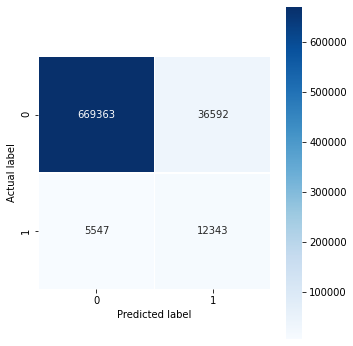

[0]	validation_0-aucpr:0.329955
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.388672
[2]	validation_0-aucpr:0.395191
[3]	validation_0-aucpr:0.413262
[4]	validation_0-aucpr:0.409868
[5]	validation_0-aucpr:0.416701
[6]	validation_0-aucpr:0.408985
[7]	validation_0-aucpr:0.408519
[8]	validation_0-aucpr:0.407064
[9]	validation_0-aucpr:0.406995
[10]	validation_0-aucpr:0.403864
[11]	validation_0-aucpr:0.404204
[12]	validation_0-aucpr:0.401832
[13]	validation_0-aucpr:0.400621
[14]	validation_0-aucpr:0.397716
[15]	validation_0-aucpr:0.396298
Stopping. Best iteration:
[5]	validation_0-aucpr:0.416701

Prediction Report of trial 5
               precision    recall  f1-score   support

           0       0.99      0.94      0.97    705955
           1       0.24      0.71      0.36     17890

    accuracy                           0.94    723845
   macro avg       0.62      0.83      0.66    723845
weighted avg       0.97      0.94      0.95    723845



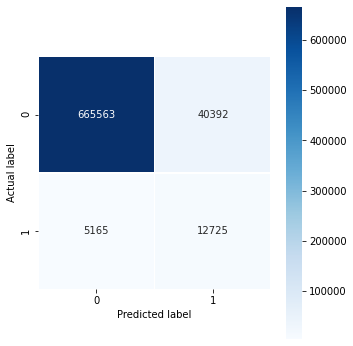

[0]	validation_0-aucpr:0.322737
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.363115
[2]	validation_0-aucpr:0.37192
[3]	validation_0-aucpr:0.383157
[4]	validation_0-aucpr:0.385421
[5]	validation_0-aucpr:0.382428
[6]	validation_0-aucpr:0.38501
[7]	validation_0-aucpr:0.386048
[8]	validation_0-aucpr:0.387317
[9]	validation_0-aucpr:0.387617
[10]	validation_0-aucpr:0.386901
[11]	validation_0-aucpr:0.38723
[12]	validation_0-aucpr:0.389466
[13]	validation_0-aucpr:0.387828
[14]	validation_0-aucpr:0.389395
[15]	validation_0-aucpr:0.388781
[16]	validation_0-aucpr:0.386931
[17]	validation_0-aucpr:0.388053
[18]	validation_0-aucpr:0.384497
[19]	validation_0-aucpr:0.381978
[20]	validation_0-aucpr:0.384045
[21]	validation_0-aucpr:0.386719
[22]	validation_0-aucpr:0.383467
Stopping. Best iteration:
[12]	validation_0-aucpr:0.389466

Prediction Report of trial 6
               precision    recall  f1-score   support

           0       0.99      0.94      0.96

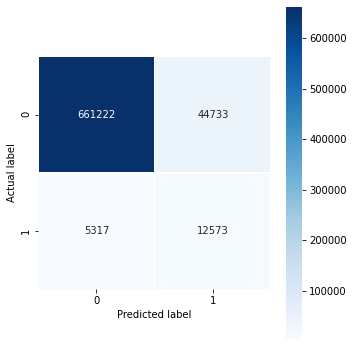

[0]	validation_0-aucpr:0.404842
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.453465
[2]	validation_0-aucpr:0.476356
[3]	validation_0-aucpr:0.482114
[4]	validation_0-aucpr:0.484891
[5]	validation_0-aucpr:0.489659
[6]	validation_0-aucpr:0.494474
[7]	validation_0-aucpr:0.498209
[8]	validation_0-aucpr:0.500428
[9]	validation_0-aucpr:0.500459
[10]	validation_0-aucpr:0.501955
[11]	validation_0-aucpr:0.503505
[12]	validation_0-aucpr:0.501185
[13]	validation_0-aucpr:0.501616
[14]	validation_0-aucpr:0.498847
[15]	validation_0-aucpr:0.499001
[16]	validation_0-aucpr:0.496631
[17]	validation_0-aucpr:0.492458
[18]	validation_0-aucpr:0.49019
[19]	validation_0-aucpr:0.485631
[20]	validation_0-aucpr:0.485383
[21]	validation_0-aucpr:0.486213
Stopping. Best iteration:
[11]	validation_0-aucpr:0.503505

Prediction Report of trial 7
               precision    recall  f1-score   support

           0       0.99      0.96      0.97    705955
           1       0

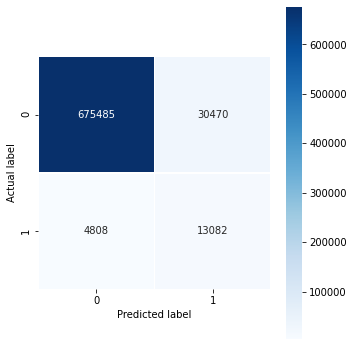

[0]	validation_0-aucpr:0.351197
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.390463
[2]	validation_0-aucpr:0.412661
[3]	validation_0-aucpr:0.421747
[4]	validation_0-aucpr:0.431377
[5]	validation_0-aucpr:0.433276
[6]	validation_0-aucpr:0.429832
[7]	validation_0-aucpr:0.42868
[8]	validation_0-aucpr:0.428144
[9]	validation_0-aucpr:0.428728
[10]	validation_0-aucpr:0.430616
[11]	validation_0-aucpr:0.427117
[12]	validation_0-aucpr:0.428441
[13]	validation_0-aucpr:0.430158
[14]	validation_0-aucpr:0.427663
[15]	validation_0-aucpr:0.428533
Stopping. Best iteration:
[5]	validation_0-aucpr:0.433276

Prediction Report of trial 8
               precision    recall  f1-score   support

           0       0.99      0.94      0.97    705955
           1       0.23      0.66      0.34     17890

    accuracy                           0.94    723845
   macro avg       0.61      0.80      0.66    723845
weighted avg       0.97      0.94      0.95    723845



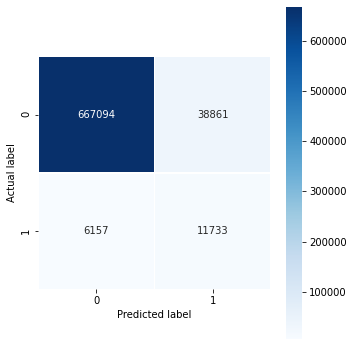

[0]	validation_0-aucpr:0.411843
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.446385
[2]	validation_0-aucpr:0.466218
[3]	validation_0-aucpr:0.471259
[4]	validation_0-aucpr:0.482003
[5]	validation_0-aucpr:0.485127
[6]	validation_0-aucpr:0.487804
[7]	validation_0-aucpr:0.492546
[8]	validation_0-aucpr:0.497065
[9]	validation_0-aucpr:0.499264
[10]	validation_0-aucpr:0.499699
[11]	validation_0-aucpr:0.499874
[12]	validation_0-aucpr:0.500558
[13]	validation_0-aucpr:0.501139
[14]	validation_0-aucpr:0.502131
[15]	validation_0-aucpr:0.502375
[16]	validation_0-aucpr:0.502466
[17]	validation_0-aucpr:0.502311
[18]	validation_0-aucpr:0.502812
[19]	validation_0-aucpr:0.502216
[20]	validation_0-aucpr:0.502162
[21]	validation_0-aucpr:0.502423
[22]	validation_0-aucpr:0.502542
[23]	validation_0-aucpr:0.502858
[24]	validation_0-aucpr:0.502869
[25]	validation_0-aucpr:0.503129
[26]	validation_0-aucpr:0.502563
[27]	validation_0-aucpr:0.502927
[28]	validation_0-au

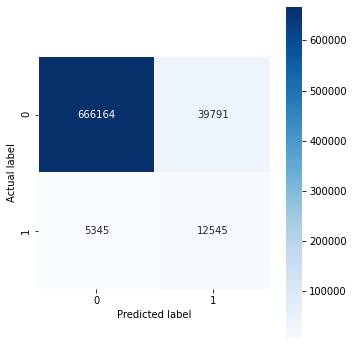

[0]	validation_0-aucpr:0.360862
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.395918
[2]	validation_0-aucpr:0.402061
[3]	validation_0-aucpr:0.411217
[4]	validation_0-aucpr:0.412523
[5]	validation_0-aucpr:0.414042
[6]	validation_0-aucpr:0.415466
[7]	validation_0-aucpr:0.417007
[8]	validation_0-aucpr:0.417829
[9]	validation_0-aucpr:0.416614
[10]	validation_0-aucpr:0.417831
[11]	validation_0-aucpr:0.418891
[12]	validation_0-aucpr:0.405824
[13]	validation_0-aucpr:0.409647
[14]	validation_0-aucpr:0.409221
[15]	validation_0-aucpr:0.405672
[16]	validation_0-aucpr:0.402649
[17]	validation_0-aucpr:0.404621
[18]	validation_0-aucpr:0.40081
[19]	validation_0-aucpr:0.403406
[20]	validation_0-aucpr:0.399303
[21]	validation_0-aucpr:0.396517
Stopping. Best iteration:
[11]	validation_0-aucpr:0.418891

Prediction Report of trial 10
               precision    recall  f1-score   support

           0       0.99      0.94      0.97    705955
           1       

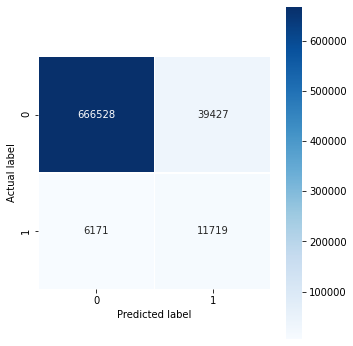

[0]	validation_0-aucpr:0.383745
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.426165
[2]	validation_0-aucpr:0.426777
[3]	validation_0-aucpr:0.439491
[4]	validation_0-aucpr:0.452764
[5]	validation_0-aucpr:0.452623
[6]	validation_0-aucpr:0.447985
[7]	validation_0-aucpr:0.45012
[8]	validation_0-aucpr:0.448887
[9]	validation_0-aucpr:0.446314
[10]	validation_0-aucpr:0.443933
[11]	validation_0-aucpr:0.443797
[12]	validation_0-aucpr:0.444719
[13]	validation_0-aucpr:0.444091
[14]	validation_0-aucpr:0.442714
Stopping. Best iteration:
[4]	validation_0-aucpr:0.452764

Prediction Report of trial 11
               precision    recall  f1-score   support

           0       0.99      0.94      0.97    705955
           1       0.24      0.75      0.36     17890

    accuracy                           0.94    723845
   macro avg       0.62      0.84      0.67    723845
weighted avg       0.97      0.94      0.95    723845



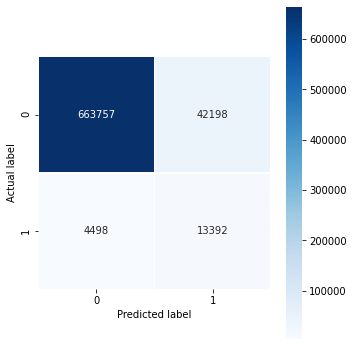

[0]	validation_0-aucpr:0.451747
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.485062
[2]	validation_0-aucpr:0.502238
[3]	validation_0-aucpr:0.506495
[4]	validation_0-aucpr:0.511799
[5]	validation_0-aucpr:0.514706
[6]	validation_0-aucpr:0.51868
[7]	validation_0-aucpr:0.519645
[8]	validation_0-aucpr:0.518624
[9]	validation_0-aucpr:0.518799
[10]	validation_0-aucpr:0.51767
[11]	validation_0-aucpr:0.517752
[12]	validation_0-aucpr:0.517953
[13]	validation_0-aucpr:0.518783
[14]	validation_0-aucpr:0.519767
[15]	validation_0-aucpr:0.519538
[16]	validation_0-aucpr:0.518442
[17]	validation_0-aucpr:0.519257
[18]	validation_0-aucpr:0.518368
[19]	validation_0-aucpr:0.51844
[20]	validation_0-aucpr:0.519479
[21]	validation_0-aucpr:0.518682
[22]	validation_0-aucpr:0.51803
[23]	validation_0-aucpr:0.518027
[24]	validation_0-aucpr:0.517401
Stopping. Best iteration:
[14]	validation_0-aucpr:0.519767

Prediction Report of trial 12
               precision    recal

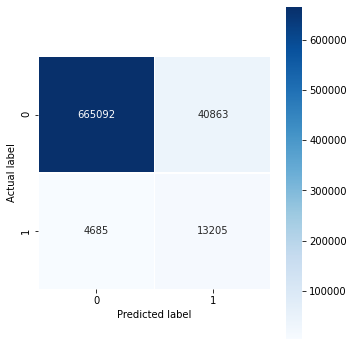

[0]	validation_0-aucpr:0.394431
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.435163
[2]	validation_0-aucpr:0.450165
[3]	validation_0-aucpr:0.464356
[4]	validation_0-aucpr:0.471664
[5]	validation_0-aucpr:0.474043
[6]	validation_0-aucpr:0.474866
[7]	validation_0-aucpr:0.475177
[8]	validation_0-aucpr:0.474988
[9]	validation_0-aucpr:0.478589
[10]	validation_0-aucpr:0.478322
[11]	validation_0-aucpr:0.48192
[12]	validation_0-aucpr:0.482379
[13]	validation_0-aucpr:0.482001
[14]	validation_0-aucpr:0.481807
[15]	validation_0-aucpr:0.482915
[16]	validation_0-aucpr:0.48432
[17]	validation_0-aucpr:0.483743
[18]	validation_0-aucpr:0.483391
[19]	validation_0-aucpr:0.484713
[20]	validation_0-aucpr:0.485014
[21]	validation_0-aucpr:0.484844
[22]	validation_0-aucpr:0.483993
[23]	validation_0-aucpr:0.48486
[24]	validation_0-aucpr:0.485085
[25]	validation_0-aucpr:0.484955
[26]	validation_0-aucpr:0.484596
[27]	validation_0-aucpr:0.481565
[28]	validation_0-aucpr

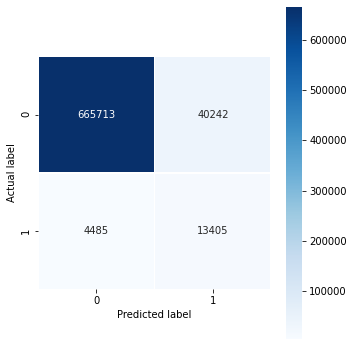

[0]	validation_0-aucpr:0.408134
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.461703
[2]	validation_0-aucpr:0.480583
[3]	validation_0-aucpr:0.488296
[4]	validation_0-aucpr:0.500744
[5]	validation_0-aucpr:0.503372
[6]	validation_0-aucpr:0.504854
[7]	validation_0-aucpr:0.505726
[8]	validation_0-aucpr:0.507971
[9]	validation_0-aucpr:0.508521
[10]	validation_0-aucpr:0.508893
[11]	validation_0-aucpr:0.50979
[12]	validation_0-aucpr:0.510255
[13]	validation_0-aucpr:0.512109
[14]	validation_0-aucpr:0.512403
[15]	validation_0-aucpr:0.516196
[16]	validation_0-aucpr:0.516201
[17]	validation_0-aucpr:0.517333
[18]	validation_0-aucpr:0.51369
[19]	validation_0-aucpr:0.511893
[20]	validation_0-aucpr:0.51239
[21]	validation_0-aucpr:0.508131
[22]	validation_0-aucpr:0.506565
[23]	validation_0-aucpr:0.507401
[24]	validation_0-aucpr:0.51059
[25]	validation_0-aucpr:0.507372
[26]	validation_0-aucpr:0.504879
[27]	validation_0-aucpr:0.50452
Stopping. Best iteration:

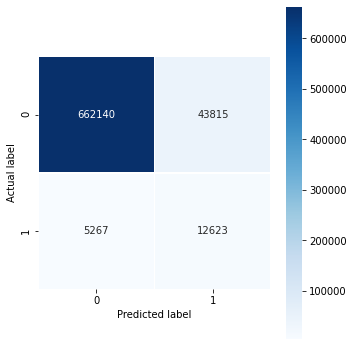

[0]	validation_0-aucpr:0.32121
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.350794
[2]	validation_0-aucpr:0.370188
[3]	validation_0-aucpr:0.372493
[4]	validation_0-aucpr:0.373484
[5]	validation_0-aucpr:0.379597
[6]	validation_0-aucpr:0.388533
[7]	validation_0-aucpr:0.391368
[8]	validation_0-aucpr:0.394994
[9]	validation_0-aucpr:0.394777
[10]	validation_0-aucpr:0.400653
[11]	validation_0-aucpr:0.400071
[12]	validation_0-aucpr:0.401932
[13]	validation_0-aucpr:0.402335
[14]	validation_0-aucpr:0.401332
[15]	validation_0-aucpr:0.40093
[16]	validation_0-aucpr:0.400404
[17]	validation_0-aucpr:0.399485
[18]	validation_0-aucpr:0.399111
[19]	validation_0-aucpr:0.397309
[20]	validation_0-aucpr:0.397589
[21]	validation_0-aucpr:0.39714
[22]	validation_0-aucpr:0.395248
[23]	validation_0-aucpr:0.394711
Stopping. Best iteration:
[13]	validation_0-aucpr:0.402335

Prediction Report of trial 15
               precision    recall  f1-score   support

         

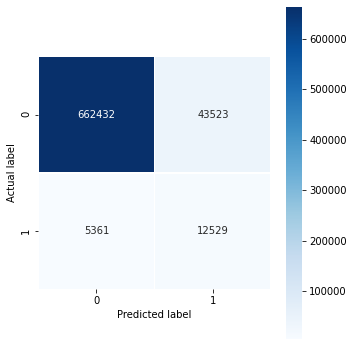

[0]	validation_0-aucpr:0.30429
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.33743
[2]	validation_0-aucpr:0.355275
[3]	validation_0-aucpr:0.358874
[4]	validation_0-aucpr:0.362685
[5]	validation_0-aucpr:0.368142
[6]	validation_0-aucpr:0.36906
[7]	validation_0-aucpr:0.369187
[8]	validation_0-aucpr:0.37002
[9]	validation_0-aucpr:0.370332
[10]	validation_0-aucpr:0.370619
[11]	validation_0-aucpr:0.371035
[12]	validation_0-aucpr:0.370905
[13]	validation_0-aucpr:0.369275
[14]	validation_0-aucpr:0.369427
[15]	validation_0-aucpr:0.372163
[16]	validation_0-aucpr:0.372488
[17]	validation_0-aucpr:0.373396
[18]	validation_0-aucpr:0.372243
[19]	validation_0-aucpr:0.372487
[20]	validation_0-aucpr:0.372245
[21]	validation_0-aucpr:0.371743
[22]	validation_0-aucpr:0.370117
[23]	validation_0-aucpr:0.37091
[24]	validation_0-aucpr:0.371045
[25]	validation_0-aucpr:0.36982
[26]	validation_0-aucpr:0.370935
[27]	validation_0-aucpr:0.36753
Stopping. Best iteration:
[

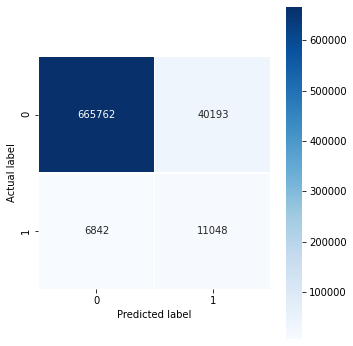

[0]	validation_0-aucpr:0.524018
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.576098
[2]	validation_0-aucpr:0.593958
[3]	validation_0-aucpr:0.601671
[4]	validation_0-aucpr:0.605896
[5]	validation_0-aucpr:0.609674
[6]	validation_0-aucpr:0.609407
[7]	validation_0-aucpr:0.606603
[8]	validation_0-aucpr:0.608953
[9]	validation_0-aucpr:0.608934
[10]	validation_0-aucpr:0.606385
[11]	validation_0-aucpr:0.607365
[12]	validation_0-aucpr:0.608278
[13]	validation_0-aucpr:0.608683
[14]	validation_0-aucpr:0.609029
[15]	validation_0-aucpr:0.608919
Stopping. Best iteration:
[5]	validation_0-aucpr:0.609674

Prediction Report of trial 17
               precision    recall  f1-score   support

           0       1.00      0.95      0.97    705955
           1       0.30      0.81      0.43     17890

    accuracy                           0.95    723845
   macro avg       0.65      0.88      0.70    723845
weighted avg       0.98      0.95      0.96    723845


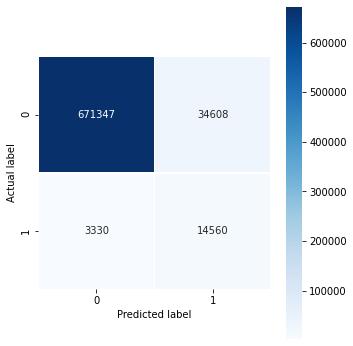

[0]	validation_0-aucpr:0.349161
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.393241
[2]	validation_0-aucpr:0.41184
[3]	validation_0-aucpr:0.421546
[4]	validation_0-aucpr:0.429756
[5]	validation_0-aucpr:0.434633
[6]	validation_0-aucpr:0.43822
[7]	validation_0-aucpr:0.437633
[8]	validation_0-aucpr:0.438667
[9]	validation_0-aucpr:0.438691
[10]	validation_0-aucpr:0.439085
[11]	validation_0-aucpr:0.437439
[12]	validation_0-aucpr:0.438256
[13]	validation_0-aucpr:0.438495
[14]	validation_0-aucpr:0.438588
[15]	validation_0-aucpr:0.438921
[16]	validation_0-aucpr:0.443357
[17]	validation_0-aucpr:0.44353
[18]	validation_0-aucpr:0.443903
[19]	validation_0-aucpr:0.444722
[20]	validation_0-aucpr:0.44485
[21]	validation_0-aucpr:0.445172
[22]	validation_0-aucpr:0.445244
[23]	validation_0-aucpr:0.444669
[24]	validation_0-aucpr:0.444614
[25]	validation_0-aucpr:0.445315
[26]	validation_0-aucpr:0.445545
[27]	validation_0-aucpr:0.447166
[28]	validation_0-aucpr:

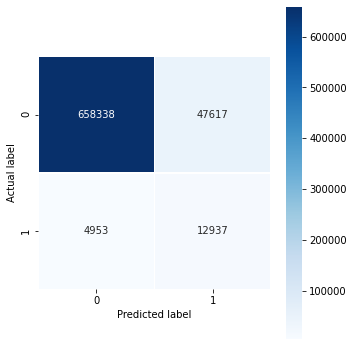

[0]	validation_0-aucpr:0.330768
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.367116
[2]	validation_0-aucpr:0.383384
[3]	validation_0-aucpr:0.410101
[4]	validation_0-aucpr:0.413388
[5]	validation_0-aucpr:0.416387
[6]	validation_0-aucpr:0.412918
[7]	validation_0-aucpr:0.411144
[8]	validation_0-aucpr:0.410807
[9]	validation_0-aucpr:0.41465
[10]	validation_0-aucpr:0.411716
[11]	validation_0-aucpr:0.415354
[12]	validation_0-aucpr:0.414459
[13]	validation_0-aucpr:0.415298
[14]	validation_0-aucpr:0.415296
[15]	validation_0-aucpr:0.414019
Stopping. Best iteration:
[5]	validation_0-aucpr:0.416387

Prediction Report of trial 19
               precision    recall  f1-score   support

           0       0.99      0.95      0.97    705955
           1       0.26      0.75      0.39     17890

    accuracy                           0.94    723845
   macro avg       0.63      0.85      0.68    723845
weighted avg       0.98      0.94      0.95    723845



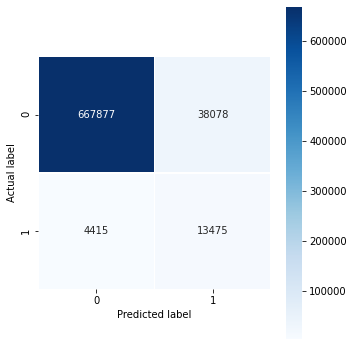

[0]	validation_0-aucpr:0.358651
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.404181
[2]	validation_0-aucpr:0.412546
[3]	validation_0-aucpr:0.420377
[4]	validation_0-aucpr:0.426123
[5]	validation_0-aucpr:0.431498
[6]	validation_0-aucpr:0.44036
[7]	validation_0-aucpr:0.443078
[8]	validation_0-aucpr:0.44079
[9]	validation_0-aucpr:0.439937
[10]	validation_0-aucpr:0.445208
[11]	validation_0-aucpr:0.440893
[12]	validation_0-aucpr:0.442895
[13]	validation_0-aucpr:0.444202
[14]	validation_0-aucpr:0.443057
[15]	validation_0-aucpr:0.442277
[16]	validation_0-aucpr:0.439011
[17]	validation_0-aucpr:0.435551
[18]	validation_0-aucpr:0.432565
[19]	validation_0-aucpr:0.433882
[20]	validation_0-aucpr:0.432953
Stopping. Best iteration:
[10]	validation_0-aucpr:0.445208

Prediction Report of trial 20
               precision    recall  f1-score   support

           0       0.99      0.95      0.97    705955
           1       0.26      0.69      0.38     17890

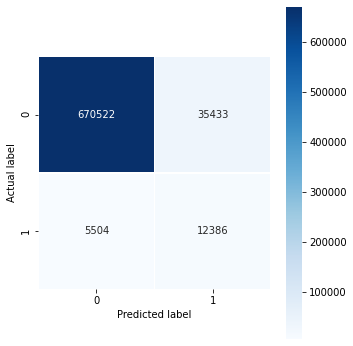

[0]	validation_0-aucpr:0.397101
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.441225
[2]	validation_0-aucpr:0.46438
[3]	validation_0-aucpr:0.464613
[4]	validation_0-aucpr:0.469727
[5]	validation_0-aucpr:0.478754
[6]	validation_0-aucpr:0.477672
[7]	validation_0-aucpr:0.477858
[8]	validation_0-aucpr:0.479539
[9]	validation_0-aucpr:0.481372
[10]	validation_0-aucpr:0.481363
[11]	validation_0-aucpr:0.480899
[12]	validation_0-aucpr:0.482017
[13]	validation_0-aucpr:0.485304
[14]	validation_0-aucpr:0.486403
[15]	validation_0-aucpr:0.486793
[16]	validation_0-aucpr:0.486359
[17]	validation_0-aucpr:0.486853
[18]	validation_0-aucpr:0.48729
[19]	validation_0-aucpr:0.489561
[20]	validation_0-aucpr:0.491009
[21]	validation_0-aucpr:0.490693
[22]	validation_0-aucpr:0.490221
[23]	validation_0-aucpr:0.490154
[24]	validation_0-aucpr:0.490215
[25]	validation_0-aucpr:0.490751
[26]	validation_0-aucpr:0.48914
[27]	validation_0-aucpr:0.489193
[28]	validation_0-aucpr

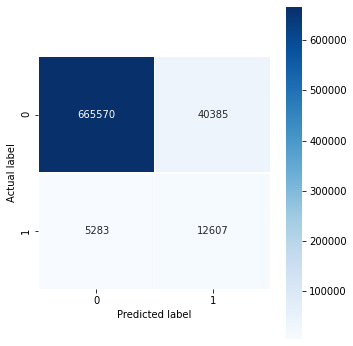

[0]	validation_0-aucpr:0.408684
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.452054
[2]	validation_0-aucpr:0.469895
[3]	validation_0-aucpr:0.476301
[4]	validation_0-aucpr:0.489209
[5]	validation_0-aucpr:0.495113
[6]	validation_0-aucpr:0.496612
[7]	validation_0-aucpr:0.495913
[8]	validation_0-aucpr:0.498842
[9]	validation_0-aucpr:0.500915
[10]	validation_0-aucpr:0.502863
[11]	validation_0-aucpr:0.503396
[12]	validation_0-aucpr:0.507213
[13]	validation_0-aucpr:0.507596
[14]	validation_0-aucpr:0.507395
[15]	validation_0-aucpr:0.508368
[16]	validation_0-aucpr:0.509378
[17]	validation_0-aucpr:0.50925
[18]	validation_0-aucpr:0.508818
[19]	validation_0-aucpr:0.507733
[20]	validation_0-aucpr:0.50745
[21]	validation_0-aucpr:0.507746
[22]	validation_0-aucpr:0.507884
[23]	validation_0-aucpr:0.50818
[24]	validation_0-aucpr:0.508189
[25]	validation_0-aucpr:0.508072
[26]	validation_0-aucpr:0.50815
Stopping. Best iteration:
[16]	validation_0-aucpr:0.50937

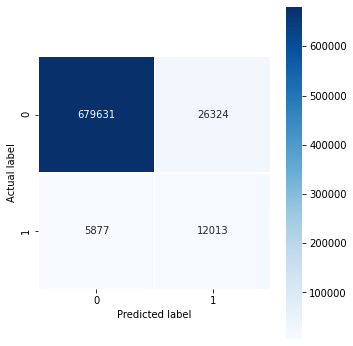

[0]	validation_0-aucpr:0.339791
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.382762
[2]	validation_0-aucpr:0.399776
[3]	validation_0-aucpr:0.402906
[4]	validation_0-aucpr:0.408884
[5]	validation_0-aucpr:0.411265
[6]	validation_0-aucpr:0.411948
[7]	validation_0-aucpr:0.412592
[8]	validation_0-aucpr:0.413855
[9]	validation_0-aucpr:0.414214
[10]	validation_0-aucpr:0.411138
[11]	validation_0-aucpr:0.412988
[12]	validation_0-aucpr:0.412486
[13]	validation_0-aucpr:0.412642
[14]	validation_0-aucpr:0.413326
[15]	validation_0-aucpr:0.413321
[16]	validation_0-aucpr:0.413165
[17]	validation_0-aucpr:0.415824
[18]	validation_0-aucpr:0.416184
[19]	validation_0-aucpr:0.416073
[20]	validation_0-aucpr:0.415745
[21]	validation_0-aucpr:0.413414
[22]	validation_0-aucpr:0.414999
[23]	validation_0-aucpr:0.414866
[24]	validation_0-aucpr:0.414979
[25]	validation_0-aucpr:0.415569
[26]	validation_0-aucpr:0.415396
[27]	validation_0-aucpr:0.413343
[28]	validation_0-au

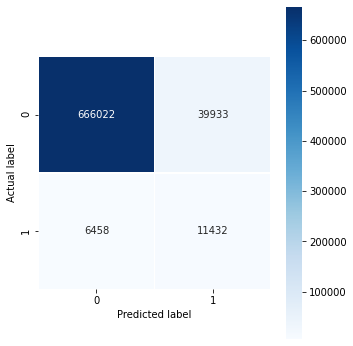

[0]	validation_0-aucpr:0.427716
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.477288
[2]	validation_0-aucpr:0.494914
[3]	validation_0-aucpr:0.50248
[4]	validation_0-aucpr:0.504128
[5]	validation_0-aucpr:0.507568
[6]	validation_0-aucpr:0.506288
[7]	validation_0-aucpr:0.507827
[8]	validation_0-aucpr:0.510551
[9]	validation_0-aucpr:0.510378
[10]	validation_0-aucpr:0.510567
[11]	validation_0-aucpr:0.511893
[12]	validation_0-aucpr:0.513868
[13]	validation_0-aucpr:0.513577
[14]	validation_0-aucpr:0.513715
[15]	validation_0-aucpr:0.513695
[16]	validation_0-aucpr:0.514268
[17]	validation_0-aucpr:0.510417
[18]	validation_0-aucpr:0.511043
[19]	validation_0-aucpr:0.505367
[20]	validation_0-aucpr:0.500291
[21]	validation_0-aucpr:0.498622
[22]	validation_0-aucpr:0.500421
[23]	validation_0-aucpr:0.497261
[24]	validation_0-aucpr:0.49515
[25]	validation_0-aucpr:0.496865
[26]	validation_0-aucpr:0.498462
Stopping. Best iteration:
[16]	validation_0-aucpr:0.514

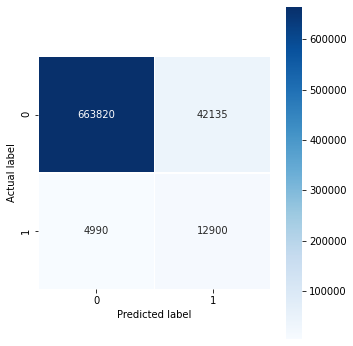

[0]	validation_0-aucpr:0.462348
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.515807
[2]	validation_0-aucpr:0.527835
[3]	validation_0-aucpr:0.53484
[4]	validation_0-aucpr:0.53485
[5]	validation_0-aucpr:0.536746
[6]	validation_0-aucpr:0.545532
[7]	validation_0-aucpr:0.548187
[8]	validation_0-aucpr:0.54886
[9]	validation_0-aucpr:0.550385
[10]	validation_0-aucpr:0.550132
[11]	validation_0-aucpr:0.53496
[12]	validation_0-aucpr:0.534266
[13]	validation_0-aucpr:0.53713
[14]	validation_0-aucpr:0.533739
[15]	validation_0-aucpr:0.530471
[16]	validation_0-aucpr:0.528266
[17]	validation_0-aucpr:0.528134
[18]	validation_0-aucpr:0.530057
[19]	validation_0-aucpr:0.52951
Stopping. Best iteration:
[9]	validation_0-aucpr:0.550385

Prediction Report of trial 25
               precision    recall  f1-score   support

           0       0.99      0.93      0.96    705955
           1       0.21      0.77      0.33     17890

    accuracy                        

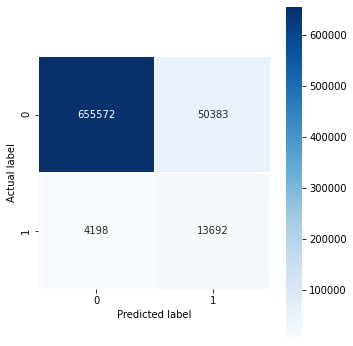

[0]	validation_0-aucpr:0.353712
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.394864
[2]	validation_0-aucpr:0.405589
[3]	validation_0-aucpr:0.419945
[4]	validation_0-aucpr:0.422747
[5]	validation_0-aucpr:0.423638
[6]	validation_0-aucpr:0.423835
[7]	validation_0-aucpr:0.424449
[8]	validation_0-aucpr:0.427867
[9]	validation_0-aucpr:0.427922
[10]	validation_0-aucpr:0.428465
[11]	validation_0-aucpr:0.425794
[12]	validation_0-aucpr:0.428184
[13]	validation_0-aucpr:0.429479
[14]	validation_0-aucpr:0.429141
[15]	validation_0-aucpr:0.427404
[16]	validation_0-aucpr:0.427125
[17]	validation_0-aucpr:0.428045
[18]	validation_0-aucpr:0.426069
[19]	validation_0-aucpr:0.42531
[20]	validation_0-aucpr:0.42497
[21]	validation_0-aucpr:0.425667
[22]	validation_0-aucpr:0.427648
[23]	validation_0-aucpr:0.427363
Stopping. Best iteration:
[13]	validation_0-aucpr:0.429479

Prediction Report of trial 26
               precision    recall  f1-score   support

        

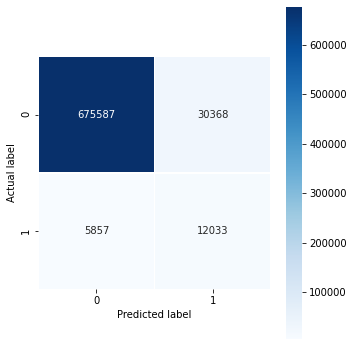

[0]	validation_0-aucpr:0.370873
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.417897
[2]	validation_0-aucpr:0.424428
[3]	validation_0-aucpr:0.440739
[4]	validation_0-aucpr:0.441705
[5]	validation_0-aucpr:0.44197
[6]	validation_0-aucpr:0.442082
[7]	validation_0-aucpr:0.446697
[8]	validation_0-aucpr:0.445158
[9]	validation_0-aucpr:0.44869
[10]	validation_0-aucpr:0.448316
[11]	validation_0-aucpr:0.448393
[12]	validation_0-aucpr:0.449382
[13]	validation_0-aucpr:0.449158
[14]	validation_0-aucpr:0.449513
[15]	validation_0-aucpr:0.450066
[16]	validation_0-aucpr:0.449387
[17]	validation_0-aucpr:0.448592
[18]	validation_0-aucpr:0.448653
[19]	validation_0-aucpr:0.447347
[20]	validation_0-aucpr:0.445316
[21]	validation_0-aucpr:0.444221
[22]	validation_0-aucpr:0.442771
[23]	validation_0-aucpr:0.442692
[24]	validation_0-aucpr:0.444487
[25]	validation_0-aucpr:0.443617
Stopping. Best iteration:
[15]	validation_0-aucpr:0.450066

Prediction Report of trial 2

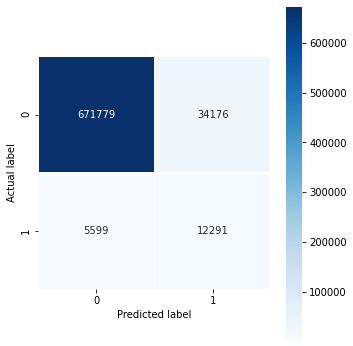

[0]	validation_0-aucpr:0.422542
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.444763
[2]	validation_0-aucpr:0.474541
[3]	validation_0-aucpr:0.469381
[4]	validation_0-aucpr:0.478541
[5]	validation_0-aucpr:0.487161
[6]	validation_0-aucpr:0.495695
[7]	validation_0-aucpr:0.490057
[8]	validation_0-aucpr:0.491828
[9]	validation_0-aucpr:0.49558
[10]	validation_0-aucpr:0.489166
[11]	validation_0-aucpr:0.485498
[12]	validation_0-aucpr:0.482121
[13]	validation_0-aucpr:0.480294
[14]	validation_0-aucpr:0.479884
[15]	validation_0-aucpr:0.480885
[16]	validation_0-aucpr:0.479152
Stopping. Best iteration:
[6]	validation_0-aucpr:0.495695

Prediction Report of trial 28
               precision    recall  f1-score   support

           0       0.99      0.95      0.97    705955
           1       0.25      0.72      0.37     17890

    accuracy                           0.94    723845
   macro avg       0.62      0.83      0.67    723845
weighted avg       0.9

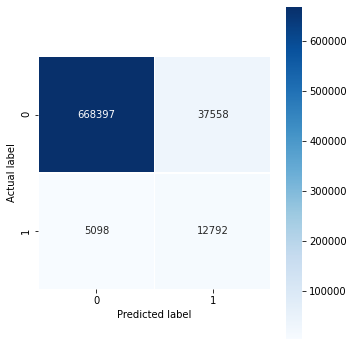

[0]	validation_0-aucpr:0.401901
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.452313
[2]	validation_0-aucpr:0.458702
[3]	validation_0-aucpr:0.469635
[4]	validation_0-aucpr:0.482234
[5]	validation_0-aucpr:0.484484
[6]	validation_0-aucpr:0.488969
[7]	validation_0-aucpr:0.490722
[8]	validation_0-aucpr:0.492595
[9]	validation_0-aucpr:0.492525
[10]	validation_0-aucpr:0.492544
[11]	validation_0-aucpr:0.493718
[12]	validation_0-aucpr:0.497113
[13]	validation_0-aucpr:0.49692
[14]	validation_0-aucpr:0.497338
[15]	validation_0-aucpr:0.49852
[16]	validation_0-aucpr:0.498255
[17]	validation_0-aucpr:0.498789
[18]	validation_0-aucpr:0.500179
[19]	validation_0-aucpr:0.50032
[20]	validation_0-aucpr:0.50032
[21]	validation_0-aucpr:0.499925
[22]	validation_0-aucpr:0.499144
[23]	validation_0-aucpr:0.498364
[24]	validation_0-aucpr:0.49782
[25]	validation_0-aucpr:0.497589
[26]	validation_0-aucpr:0.497151
[27]	validation_0-aucpr:0.497703
[28]	validation_0-aucpr:0

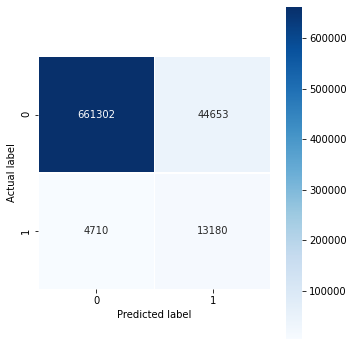

[0]	validation_0-aucpr:0.347924
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.398353
[2]	validation_0-aucpr:0.416195
[3]	validation_0-aucpr:0.418821
[4]	validation_0-aucpr:0.421938
[5]	validation_0-aucpr:0.428826
[6]	validation_0-aucpr:0.429859
[7]	validation_0-aucpr:0.430371
[8]	validation_0-aucpr:0.431182
[9]	validation_0-aucpr:0.431163
[10]	validation_0-aucpr:0.431175
[11]	validation_0-aucpr:0.430719
[12]	validation_0-aucpr:0.434076
[13]	validation_0-aucpr:0.434374
[14]	validation_0-aucpr:0.434153
[15]	validation_0-aucpr:0.436523
[16]	validation_0-aucpr:0.436255
[17]	validation_0-aucpr:0.437293
[18]	validation_0-aucpr:0.43765
[19]	validation_0-aucpr:0.437591
[20]	validation_0-aucpr:0.43729
[21]	validation_0-aucpr:0.437267
[22]	validation_0-aucpr:0.437036
[23]	validation_0-aucpr:0.434923
[24]	validation_0-aucpr:0.435243
[25]	validation_0-aucpr:0.435628
[26]	validation_0-aucpr:0.435345
[27]	validation_0-aucpr:0.434241
[28]	validation_0-aucp

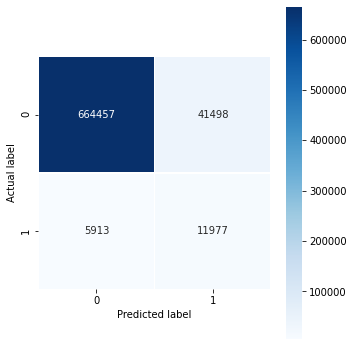

[0]	validation_0-aucpr:0.413641
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.458586
[2]	validation_0-aucpr:0.472267
[3]	validation_0-aucpr:0.478478
[4]	validation_0-aucpr:0.496472
[5]	validation_0-aucpr:0.506314
[6]	validation_0-aucpr:0.51581
[7]	validation_0-aucpr:0.517569
[8]	validation_0-aucpr:0.520278
[9]	validation_0-aucpr:0.522673
[10]	validation_0-aucpr:0.520637
[11]	validation_0-aucpr:0.517929
[12]	validation_0-aucpr:0.523094
[13]	validation_0-aucpr:0.520284
[14]	validation_0-aucpr:0.518363
[15]	validation_0-aucpr:0.519924
[16]	validation_0-aucpr:0.520617
[17]	validation_0-aucpr:0.521487
[18]	validation_0-aucpr:0.521748
[19]	validation_0-aucpr:0.522697
[20]	validation_0-aucpr:0.518879
[21]	validation_0-aucpr:0.51783
[22]	validation_0-aucpr:0.518179
Stopping. Best iteration:
[12]	validation_0-aucpr:0.523094

Prediction Report of trial 31
               precision    recall  f1-score   support

           0       0.99      0.96      0.

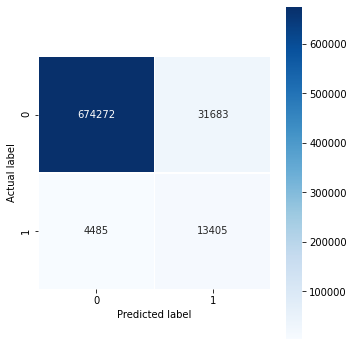

[0]	validation_0-aucpr:0.409894
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.441478
[2]	validation_0-aucpr:0.464465
[3]	validation_0-aucpr:0.474937
[4]	validation_0-aucpr:0.483109
[5]	validation_0-aucpr:0.483962
[6]	validation_0-aucpr:0.480457
[7]	validation_0-aucpr:0.478749
[8]	validation_0-aucpr:0.48034
[9]	validation_0-aucpr:0.479548
[10]	validation_0-aucpr:0.480618
[11]	validation_0-aucpr:0.481217
[12]	validation_0-aucpr:0.482052
[13]	validation_0-aucpr:0.481756
[14]	validation_0-aucpr:0.480612
[15]	validation_0-aucpr:0.482411
Stopping. Best iteration:
[5]	validation_0-aucpr:0.483962

Prediction Report of trial 32
               precision    recall  f1-score   support

           0       0.99      0.96      0.97    705955
           1       0.28      0.64      0.39     17890

    accuracy                           0.95    723845
   macro avg       0.64      0.80      0.68    723845
weighted avg       0.97      0.95      0.96    723845



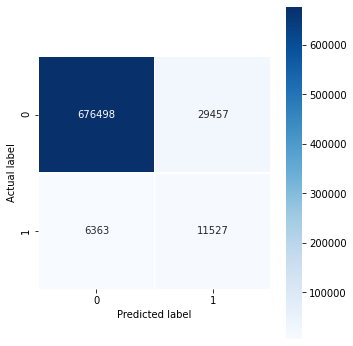

[0]	validation_0-aucpr:0.466042
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.506707
[2]	validation_0-aucpr:0.52447
[3]	validation_0-aucpr:0.528094
[4]	validation_0-aucpr:0.535455
[5]	validation_0-aucpr:0.538269
[6]	validation_0-aucpr:0.540718
[7]	validation_0-aucpr:0.541624
[8]	validation_0-aucpr:0.544098
[9]	validation_0-aucpr:0.545574
[10]	validation_0-aucpr:0.546222
[11]	validation_0-aucpr:0.547066
[12]	validation_0-aucpr:0.54659
[13]	validation_0-aucpr:0.547386
[14]	validation_0-aucpr:0.547622
[15]	validation_0-aucpr:0.546494
[16]	validation_0-aucpr:0.546308
[17]	validation_0-aucpr:0.550454
[18]	validation_0-aucpr:0.550935
[19]	validation_0-aucpr:0.55095
[20]	validation_0-aucpr:0.549591
[21]	validation_0-aucpr:0.550057
[22]	validation_0-aucpr:0.550628
[23]	validation_0-aucpr:0.551002
[24]	validation_0-aucpr:0.551664
[25]	validation_0-aucpr:0.551945
[26]	validation_0-aucpr:0.551453
[27]	validation_0-aucpr:0.550834
[28]	validation_0-aucpr

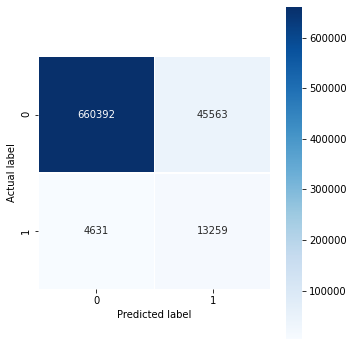

[0]	validation_0-aucpr:0.371398
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.415598
[2]	validation_0-aucpr:0.422409
[3]	validation_0-aucpr:0.431265
[4]	validation_0-aucpr:0.441839
[5]	validation_0-aucpr:0.444754
[6]	validation_0-aucpr:0.451667
[7]	validation_0-aucpr:0.455453
[8]	validation_0-aucpr:0.456995
[9]	validation_0-aucpr:0.45795
[10]	validation_0-aucpr:0.45903
[11]	validation_0-aucpr:0.459672
[12]	validation_0-aucpr:0.462243
[13]	validation_0-aucpr:0.463253
[14]	validation_0-aucpr:0.462896
[15]	validation_0-aucpr:0.463158
[16]	validation_0-aucpr:0.462205
[17]	validation_0-aucpr:0.462764
[18]	validation_0-aucpr:0.462947
[19]	validation_0-aucpr:0.462985
[20]	validation_0-aucpr:0.463895
[21]	validation_0-aucpr:0.463055
[22]	validation_0-aucpr:0.463602
[23]	validation_0-aucpr:0.463575
[24]	validation_0-aucpr:0.46314
[25]	validation_0-aucpr:0.460822
[26]	validation_0-aucpr:0.461253
[27]	validation_0-aucpr:0.460619
[28]	validation_0-aucpr

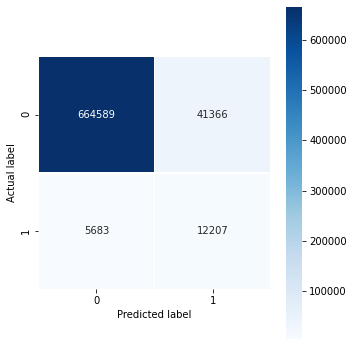

[0]	validation_0-aucpr:0.357507
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.386174
[2]	validation_0-aucpr:0.413067
[3]	validation_0-aucpr:0.416085
[4]	validation_0-aucpr:0.427141
[5]	validation_0-aucpr:0.429498
[6]	validation_0-aucpr:0.430168
[7]	validation_0-aucpr:0.433132
[8]	validation_0-aucpr:0.434873
[9]	validation_0-aucpr:0.435111
[10]	validation_0-aucpr:0.436364
[11]	validation_0-aucpr:0.437159
[12]	validation_0-aucpr:0.437439
[13]	validation_0-aucpr:0.437337
[14]	validation_0-aucpr:0.437213
[15]	validation_0-aucpr:0.436442
[16]	validation_0-aucpr:0.43658
[17]	validation_0-aucpr:0.43726
[18]	validation_0-aucpr:0.442394
[19]	validation_0-aucpr:0.441776
[20]	validation_0-aucpr:0.441931
[21]	validation_0-aucpr:0.442207
[22]	validation_0-aucpr:0.44194
[23]	validation_0-aucpr:0.44153
[24]	validation_0-aucpr:0.441502
[25]	validation_0-aucpr:0.441255
[26]	validation_0-aucpr:0.441681
[27]	validation_0-aucpr:0.441678
[28]	validation_0-aucpr:

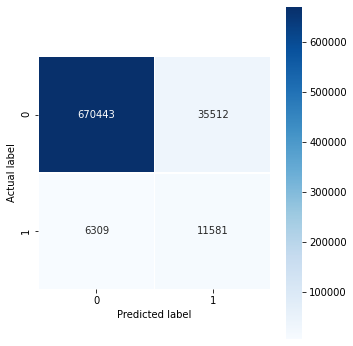

[0]	validation_0-aucpr:0.346885
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.382595
[2]	validation_0-aucpr:0.391417
[3]	validation_0-aucpr:0.396405
[4]	validation_0-aucpr:0.404377
[5]	validation_0-aucpr:0.403621
[6]	validation_0-aucpr:0.406349
[7]	validation_0-aucpr:0.402963
[8]	validation_0-aucpr:0.402636
[9]	validation_0-aucpr:0.404682
[10]	validation_0-aucpr:0.406484
[11]	validation_0-aucpr:0.40718
[12]	validation_0-aucpr:0.406992
[13]	validation_0-aucpr:0.406355
[14]	validation_0-aucpr:0.408173
[15]	validation_0-aucpr:0.409178
[16]	validation_0-aucpr:0.409828
[17]	validation_0-aucpr:0.410169
[18]	validation_0-aucpr:0.411032
[19]	validation_0-aucpr:0.41159
[20]	validation_0-aucpr:0.411805
[21]	validation_0-aucpr:0.409797
[22]	validation_0-aucpr:0.40921
[23]	validation_0-aucpr:0.409503
[24]	validation_0-aucpr:0.409144
[25]	validation_0-aucpr:0.408733
[26]	validation_0-aucpr:0.410204
[27]	validation_0-aucpr:0.409578
[28]	validation_0-aucpr

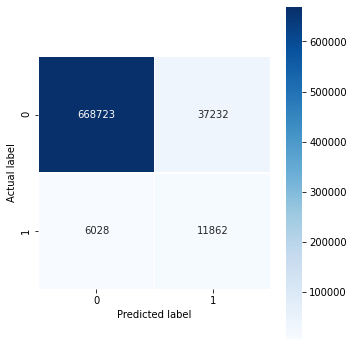

[0]	validation_0-aucpr:0.455719
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.501576
[2]	validation_0-aucpr:0.513774
[3]	validation_0-aucpr:0.520777
[4]	validation_0-aucpr:0.524063
[5]	validation_0-aucpr:0.530231
[6]	validation_0-aucpr:0.532444
[7]	validation_0-aucpr:0.536199
[8]	validation_0-aucpr:0.539811
[9]	validation_0-aucpr:0.541807
[10]	validation_0-aucpr:0.541777
[11]	validation_0-aucpr:0.542745
[12]	validation_0-aucpr:0.542605
[13]	validation_0-aucpr:0.540249
[14]	validation_0-aucpr:0.541466
[15]	validation_0-aucpr:0.540749
[16]	validation_0-aucpr:0.545143
[17]	validation_0-aucpr:0.544605
[18]	validation_0-aucpr:0.544608
[19]	validation_0-aucpr:0.545515
[20]	validation_0-aucpr:0.545306
[21]	validation_0-aucpr:0.544111
[22]	validation_0-aucpr:0.542986
[23]	validation_0-aucpr:0.541836
[24]	validation_0-aucpr:0.540945
[25]	validation_0-aucpr:0.540515
[26]	validation_0-aucpr:0.538753
[27]	validation_0-aucpr:0.53727
[28]	validation_0-auc

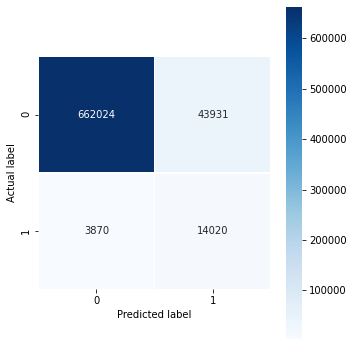

[0]	validation_0-aucpr:0.376032
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.414932
[2]	validation_0-aucpr:0.424477
[3]	validation_0-aucpr:0.43523
[4]	validation_0-aucpr:0.43776
[5]	validation_0-aucpr:0.444024
[6]	validation_0-aucpr:0.443993
[7]	validation_0-aucpr:0.444914
[8]	validation_0-aucpr:0.442161
[9]	validation_0-aucpr:0.44157
[10]	validation_0-aucpr:0.439565
[11]	validation_0-aucpr:0.441856
[12]	validation_0-aucpr:0.441273
[13]	validation_0-aucpr:0.439538
[14]	validation_0-aucpr:0.441036
[15]	validation_0-aucpr:0.439505
[16]	validation_0-aucpr:0.439887
[17]	validation_0-aucpr:0.437727
Stopping. Best iteration:
[7]	validation_0-aucpr:0.444914

Prediction Report of trial 38
               precision    recall  f1-score   support

           0       0.99      0.96      0.97    705955
           1       0.30      0.72      0.43     17890

    accuracy                           0.95    723845
   macro avg       0.65      0.84      0.70  

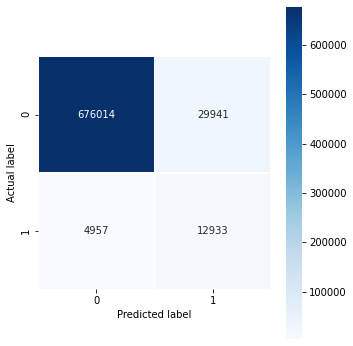

[0]	validation_0-aucpr:0.450813
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.484954
[2]	validation_0-aucpr:0.509989
[3]	validation_0-aucpr:0.519442
[4]	validation_0-aucpr:0.529417
[5]	validation_0-aucpr:0.529953
[6]	validation_0-aucpr:0.534936
[7]	validation_0-aucpr:0.535065
[8]	validation_0-aucpr:0.53564
[9]	validation_0-aucpr:0.537038
[10]	validation_0-aucpr:0.537314
[11]	validation_0-aucpr:0.537369
[12]	validation_0-aucpr:0.533464
[13]	validation_0-aucpr:0.532481
[14]	validation_0-aucpr:0.52941
[15]	validation_0-aucpr:0.531217
[16]	validation_0-aucpr:0.529732
[17]	validation_0-aucpr:0.528185
[18]	validation_0-aucpr:0.529413
[19]	validation_0-aucpr:0.525106
[20]	validation_0-aucpr:0.524034
[21]	validation_0-aucpr:0.522744
Stopping. Best iteration:
[11]	validation_0-aucpr:0.537369

Prediction Report of trial 39
               precision    recall  f1-score   support

           0       0.99      0.95      0.97    705955
           1       0

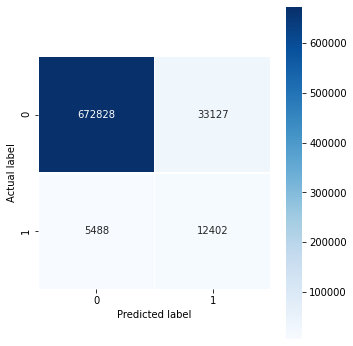

[0]	validation_0-aucpr:0.345252
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.388705
[2]	validation_0-aucpr:0.403974
[3]	validation_0-aucpr:0.411518
[4]	validation_0-aucpr:0.417643
[5]	validation_0-aucpr:0.421383
[6]	validation_0-aucpr:0.422797
[7]	validation_0-aucpr:0.42201
[8]	validation_0-aucpr:0.4208
[9]	validation_0-aucpr:0.420039
[10]	validation_0-aucpr:0.419513
[11]	validation_0-aucpr:0.419291
[12]	validation_0-aucpr:0.419205
[13]	validation_0-aucpr:0.421086
[14]	validation_0-aucpr:0.420002
[15]	validation_0-aucpr:0.421068
[16]	validation_0-aucpr:0.421115
Stopping. Best iteration:
[6]	validation_0-aucpr:0.422797

Prediction Report of trial 40
               precision    recall  f1-score   support

           0       0.99      0.96      0.97    705955
           1       0.28      0.66      0.40     17890

    accuracy                           0.95    723845
   macro avg       0.64      0.81      0.69    723845
weighted avg       0.97 

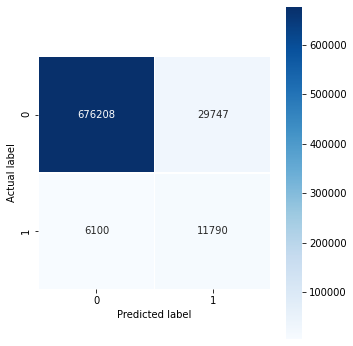

[0]	validation_0-aucpr:0.363163
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.419869
[2]	validation_0-aucpr:0.435746
[3]	validation_0-aucpr:0.439237
[4]	validation_0-aucpr:0.46037
[5]	validation_0-aucpr:0.463452
[6]	validation_0-aucpr:0.465229
[7]	validation_0-aucpr:0.463904
[8]	validation_0-aucpr:0.462036
[9]	validation_0-aucpr:0.46124
[10]	validation_0-aucpr:0.460154
[11]	validation_0-aucpr:0.458942
[12]	validation_0-aucpr:0.45756
[13]	validation_0-aucpr:0.456653
[14]	validation_0-aucpr:0.454064
[15]	validation_0-aucpr:0.451877
[16]	validation_0-aucpr:0.455257
Stopping. Best iteration:
[6]	validation_0-aucpr:0.465229

Prediction Report of trial 41
               precision    recall  f1-score   support

           0       0.99      0.96      0.97    705955
           1       0.29      0.71      0.42     17890

    accuracy                           0.95    723845
   macro avg       0.64      0.84      0.69    723845
weighted avg       0.98 

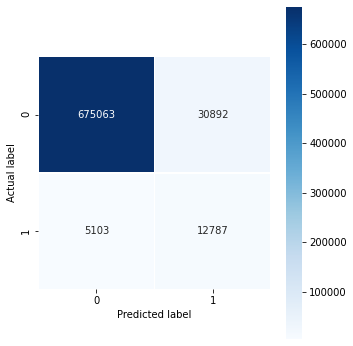

[0]	validation_0-aucpr:0.406097
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.454451
[2]	validation_0-aucpr:0.472118
[3]	validation_0-aucpr:0.476736
[4]	validation_0-aucpr:0.483547
[5]	validation_0-aucpr:0.48471
[6]	validation_0-aucpr:0.486679
[7]	validation_0-aucpr:0.488221
[8]	validation_0-aucpr:0.488707
[9]	validation_0-aucpr:0.489564
[10]	validation_0-aucpr:0.490003
[11]	validation_0-aucpr:0.490557
[12]	validation_0-aucpr:0.491582
[13]	validation_0-aucpr:0.4926
[14]	validation_0-aucpr:0.495897
[15]	validation_0-aucpr:0.495963
[16]	validation_0-aucpr:0.496935
[17]	validation_0-aucpr:0.497138
[18]	validation_0-aucpr:0.495394
[19]	validation_0-aucpr:0.495438
[20]	validation_0-aucpr:0.496052
[21]	validation_0-aucpr:0.496264
[22]	validation_0-aucpr:0.49557
[23]	validation_0-aucpr:0.49631
[24]	validation_0-aucpr:0.497069
[25]	validation_0-aucpr:0.497341
[26]	validation_0-aucpr:0.497735
[27]	validation_0-aucpr:0.496887
[28]	validation_0-aucpr:0

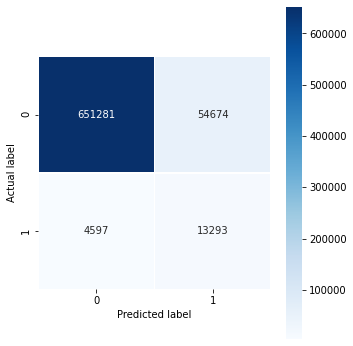

[0]	validation_0-aucpr:0.315922
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.345647
[2]	validation_0-aucpr:0.365521
[3]	validation_0-aucpr:0.370444
[4]	validation_0-aucpr:0.380233
[5]	validation_0-aucpr:0.382231
[6]	validation_0-aucpr:0.384599
[7]	validation_0-aucpr:0.386329
[8]	validation_0-aucpr:0.386259
[9]	validation_0-aucpr:0.385854
[10]	validation_0-aucpr:0.386032
[11]	validation_0-aucpr:0.3864
[12]	validation_0-aucpr:0.372956
[13]	validation_0-aucpr:0.376272
[14]	validation_0-aucpr:0.375948
[15]	validation_0-aucpr:0.377313
[16]	validation_0-aucpr:0.377212
[17]	validation_0-aucpr:0.376986
[18]	validation_0-aucpr:0.37301
[19]	validation_0-aucpr:0.372915
[20]	validation_0-aucpr:0.373561
[21]	validation_0-aucpr:0.373452
Stopping. Best iteration:
[11]	validation_0-aucpr:0.3864

Prediction Report of trial 43
               precision    recall  f1-score   support

           0       0.99      0.94      0.97    705955
           1       0.23

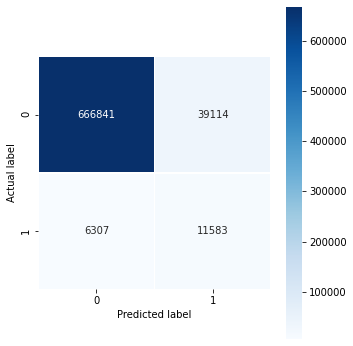

[0]	validation_0-aucpr:0.381498
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.454401
[2]	validation_0-aucpr:0.483331
[3]	validation_0-aucpr:0.486452
[4]	validation_0-aucpr:0.498149
[5]	validation_0-aucpr:0.505359
[6]	validation_0-aucpr:0.516471
[7]	validation_0-aucpr:0.510489
[8]	validation_0-aucpr:0.508822
[9]	validation_0-aucpr:0.50979
[10]	validation_0-aucpr:0.505664
[11]	validation_0-aucpr:0.501882
[12]	validation_0-aucpr:0.500433
[13]	validation_0-aucpr:0.498069
[14]	validation_0-aucpr:0.495734
[15]	validation_0-aucpr:0.493497
[16]	validation_0-aucpr:0.49186
Stopping. Best iteration:
[6]	validation_0-aucpr:0.516471

Prediction Report of trial 44
               precision    recall  f1-score   support

           0       0.99      0.95      0.97    705955
           1       0.27      0.71      0.39     17890

    accuracy                           0.95    723845
   macro avg       0.63      0.83      0.68    723845
weighted avg       0.97

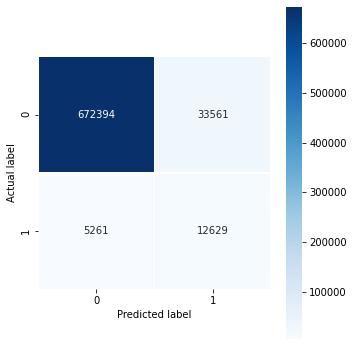

[0]	validation_0-aucpr:0.273585
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.309092
[2]	validation_0-aucpr:0.318383
[3]	validation_0-aucpr:0.331487
[4]	validation_0-aucpr:0.33302
[5]	validation_0-aucpr:0.333064
[6]	validation_0-aucpr:0.335519
[7]	validation_0-aucpr:0.337377
[8]	validation_0-aucpr:0.338641
[9]	validation_0-aucpr:0.338567
[10]	validation_0-aucpr:0.337951
[11]	validation_0-aucpr:0.337593
[12]	validation_0-aucpr:0.327566
[13]	validation_0-aucpr:0.328038
[14]	validation_0-aucpr:0.326524
[15]	validation_0-aucpr:0.327102
[16]	validation_0-aucpr:0.327339
[17]	validation_0-aucpr:0.324124
[18]	validation_0-aucpr:0.323945
Stopping. Best iteration:
[8]	validation_0-aucpr:0.338641

Prediction Report of trial 45
               precision    recall  f1-score   support

           0       0.99      0.94      0.97    705955
           1       0.21      0.60      0.31     17890

    accuracy                           0.93    723845
   macro a

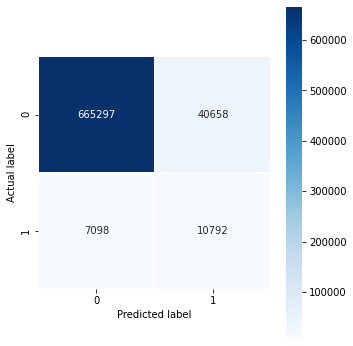

[0]	validation_0-aucpr:0.344873
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.374035
[2]	validation_0-aucpr:0.39865
[3]	validation_0-aucpr:0.407467
[4]	validation_0-aucpr:0.40816
[5]	validation_0-aucpr:0.412997
[6]	validation_0-aucpr:0.417386
[7]	validation_0-aucpr:0.418317
[8]	validation_0-aucpr:0.417398
[9]	validation_0-aucpr:0.418417
[10]	validation_0-aucpr:0.418046
[11]	validation_0-aucpr:0.419593
[12]	validation_0-aucpr:0.419853
[13]	validation_0-aucpr:0.420287
[14]	validation_0-aucpr:0.420998
[15]	validation_0-aucpr:0.420855
[16]	validation_0-aucpr:0.421012
[17]	validation_0-aucpr:0.421269
[18]	validation_0-aucpr:0.421332
[19]	validation_0-aucpr:0.420434
[20]	validation_0-aucpr:0.42213
[21]	validation_0-aucpr:0.421624
[22]	validation_0-aucpr:0.422239
[23]	validation_0-aucpr:0.42172
[24]	validation_0-aucpr:0.421683
[25]	validation_0-aucpr:0.421933
[26]	validation_0-aucpr:0.422741
[27]	validation_0-aucpr:0.422222
[28]	validation_0-aucpr:

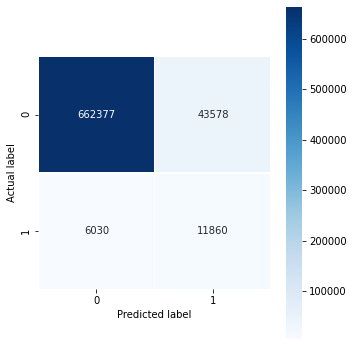

[0]	validation_0-aucpr:0.41854
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.461525
[2]	validation_0-aucpr:0.468567
[3]	validation_0-aucpr:0.47711
[4]	validation_0-aucpr:0.492986
[5]	validation_0-aucpr:0.49482
[6]	validation_0-aucpr:0.503077
[7]	validation_0-aucpr:0.506076
[8]	validation_0-aucpr:0.507082
[9]	validation_0-aucpr:0.508819
[10]	validation_0-aucpr:0.509755
[11]	validation_0-aucpr:0.509678
[12]	validation_0-aucpr:0.510346
[13]	validation_0-aucpr:0.510857
[14]	validation_0-aucpr:0.511489
[15]	validation_0-aucpr:0.511656
[16]	validation_0-aucpr:0.512385
[17]	validation_0-aucpr:0.513234
[18]	validation_0-aucpr:0.513749
[19]	validation_0-aucpr:0.514146
[20]	validation_0-aucpr:0.514758
[21]	validation_0-aucpr:0.514524
[22]	validation_0-aucpr:0.51512
[23]	validation_0-aucpr:0.514608
[24]	validation_0-aucpr:0.51466
[25]	validation_0-aucpr:0.515716
[26]	validation_0-aucpr:0.516144
[27]	validation_0-aucpr:0.516285
[28]	validation_0-aucpr:0

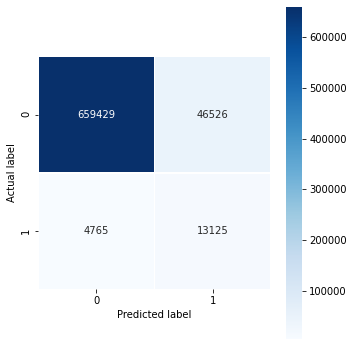

[0]	validation_0-aucpr:0.32603
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.369104
[2]	validation_0-aucpr:0.379218
[3]	validation_0-aucpr:0.383577
[4]	validation_0-aucpr:0.392438
[5]	validation_0-aucpr:0.391903
[6]	validation_0-aucpr:0.392311
[7]	validation_0-aucpr:0.392328
[8]	validation_0-aucpr:0.394097
[9]	validation_0-aucpr:0.395011
[10]	validation_0-aucpr:0.392698
[11]	validation_0-aucpr:0.391792
[12]	validation_0-aucpr:0.392424
[13]	validation_0-aucpr:0.391298
[14]	validation_0-aucpr:0.391681
[15]	validation_0-aucpr:0.396013
[16]	validation_0-aucpr:0.393662
[17]	validation_0-aucpr:0.393454
[18]	validation_0-aucpr:0.395461
[19]	validation_0-aucpr:0.394886
[20]	validation_0-aucpr:0.396475
[21]	validation_0-aucpr:0.39454
[22]	validation_0-aucpr:0.395817
[23]	validation_0-aucpr:0.398167
[24]	validation_0-aucpr:0.398563
[25]	validation_0-aucpr:0.397388
[26]	validation_0-aucpr:0.397546
[27]	validation_0-aucpr:0.397099
[28]	validation_0-aucp

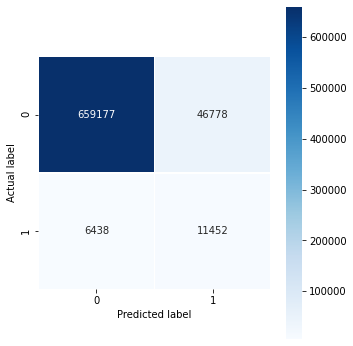

[0]	validation_0-aucpr:0.360388
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.39706
[2]	validation_0-aucpr:0.413683
[3]	validation_0-aucpr:0.420708
[4]	validation_0-aucpr:0.429276
[5]	validation_0-aucpr:0.43091
[6]	validation_0-aucpr:0.433241
[7]	validation_0-aucpr:0.431343
[8]	validation_0-aucpr:0.430854
[9]	validation_0-aucpr:0.43075
[10]	validation_0-aucpr:0.432864
[11]	validation_0-aucpr:0.431406
[12]	validation_0-aucpr:0.43222
[13]	validation_0-aucpr:0.430861
[14]	validation_0-aucpr:0.430913
[15]	validation_0-aucpr:0.430525
[16]	validation_0-aucpr:0.430482
Stopping. Best iteration:
[6]	validation_0-aucpr:0.433241

Prediction Report of trial 49
               precision    recall  f1-score   support

           0       0.99      0.95      0.97    705955
           1       0.26      0.64      0.37     17890

    accuracy                           0.95    723845
   macro avg       0.63      0.80      0.67    723845
weighted avg       0.97  

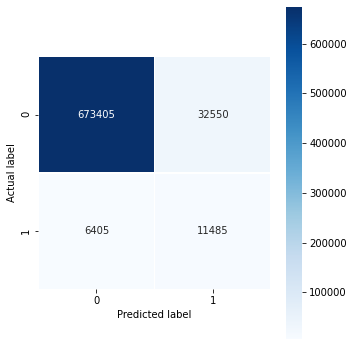

[0]	validation_0-aucpr:0.321247
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.34918
[2]	validation_0-aucpr:0.371673
[3]	validation_0-aucpr:0.376957
[4]	validation_0-aucpr:0.383744
[5]	validation_0-aucpr:0.38565
[6]	validation_0-aucpr:0.388338
[7]	validation_0-aucpr:0.387642
[8]	validation_0-aucpr:0.388421
[9]	validation_0-aucpr:0.393724
[10]	validation_0-aucpr:0.393812
[11]	validation_0-aucpr:0.393209
[12]	validation_0-aucpr:0.392678
[13]	validation_0-aucpr:0.39275
[14]	validation_0-aucpr:0.396831
[15]	validation_0-aucpr:0.397085
[16]	validation_0-aucpr:0.396933
[17]	validation_0-aucpr:0.396406
[18]	validation_0-aucpr:0.398074
[19]	validation_0-aucpr:0.399044
[20]	validation_0-aucpr:0.40137
[21]	validation_0-aucpr:0.40172
[22]	validation_0-aucpr:0.402225
[23]	validation_0-aucpr:0.402271
[24]	validation_0-aucpr:0.402799
[25]	validation_0-aucpr:0.402972
[26]	validation_0-aucpr:0.404557
[27]	validation_0-aucpr:0.404609
[28]	validation_0-aucpr:0

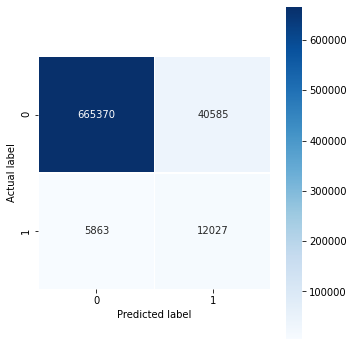

In [307]:
# in this case, only refer to xgboost since it outperforms brf in orginal dataset!!!
# xgboost 

shuffled_flow_id_loss = flow_id_loss.copy()
shuffled_flow_id_no_loss = flow_id_no_loss.copy()

recall_0_list_xgb_3 = []
recall_1_list_xgb_3 = []
recall_avg_list_xgb_3 = []

for trial in range(1, 51):
    random.seed(trial)
    
    random.shuffle(shuffled_flow_id_loss)
    random.shuffle(shuffled_flow_id_no_loss)
    
    df_loss_new = pd.concat([df_loss[df_loss['flow_id']==x] for x in shuffled_flow_id_loss])
    df_no_loss_new = pd.concat([df_no_loss[df_no_loss['flow_id']==x] for x in shuffled_flow_id_no_loss])
            
    df_train = pd.concat([df_loss_new.iloc[0:int(df_loss_new.shape[0] * 0.7)], df_no_loss_new.iloc[0:int(df_no_loss_new.shape[0] * 0.7)]])
    df_train_shuffled = df_train.sample(frac=1).reset_index()
    df_train_shuffled.drop(['index'], axis=1, inplace=True)
    df_test = pd.concat([df_loss_new.iloc[int(df_loss_new.shape[0] * 0.7)+1: -1], df_no_loss_new.iloc[int(df_no_loss_new.shape[0] * 0.7)+1: -1]])
    df_test_shuffled = df_test.sample(frac=1).reset_index()
    df_test_shuffled.drop(['index'], axis=1, inplace=True)

    x_train = df_train_shuffled[full_features_list_removing_500ms]
    x_test = df_test_shuffled[full_features_list_removing_500ms]
    y_train = df_train_shuffled[['lossOrNot']]
    y_train = y_train.astype(int)
    y_test = df_test_shuffled[['lossOrNot']]
    y_test = y_test.astype(int)
    
    clf_xgb_check = xgb.XGBClassifier(
        n_estimators=500, 
        objective='binary:logistic', 
        scale_pos_weight=weight, 
        n_jobs=48
    )
    
    clf_xgb_check.fit(x_train, y_train, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(x_test, y_test)])
            
    y_pred = clf_xgb_check.predict(x_test)
    print(f"Prediction Report of trial {trial}\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
    report = classification_report(y_test, y_pred, output_dict=True)
    recall_0_list_xgb_3.append(report['0']['recall'])
    recall_1_list_xgb_3.append(report['1']['recall'])
    recall_avg_list_xgb_3.append(report['macro avg']['recall'])

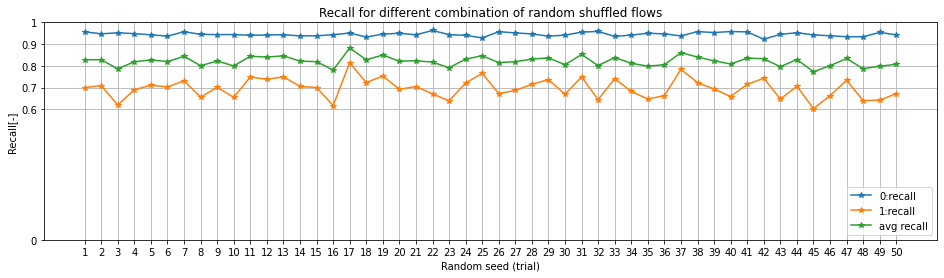

The best performance is at trial 17:
   recall of class 0: 0.95097704527909
   recall of class 1: 0.8138624930128563
   macro average recall: 0.8824197691459732

The average is 0.9452491447755169 (0:recall), 0.697054220234768 (1:recall), 0.8211516825051425 (avg recall)


In [328]:
x_label = list(range(1,51))
plt.figure(figsize=(16,4))
plt.plot(x_label, recall_0_list_xgb_3, '*-', label='0:recall')
plt.plot(x_label, recall_1_list_xgb_3, '*-', label='1:recall')
plt.plot(x_label, recall_avg_list_xgb_3, '*-', label='avg recall')
plt.xticks(x_label, x_label)
plt.legend(loc=4)
plt.grid()
plt.ylim([0,1])
plt.yticks([0, 0.6, 0.7, 0.8, 0.9, 1], [0, 0.6, 0.7, 0.8, 0.9, 1])
plt.title('Recall for different combination of random shuffled flows')
plt.xlabel('Random seed (trial)')
plt.ylabel('Recall[-]')
plt.show()

print(f'The best performance is at trial 17:\n   recall of class 0: {recall_0_list_xgb_3[16]}\n   recall of class 1: {recall_1_list_xgb_3[16]}\n   macro average recall: {recall_avg_list_xgb_3[16]}')
print()
print(f'The average is {np.array(recall_0_list_xgb_3).mean()} (0:recall), {np.array(recall_1_list_xgb_3).mean()} (1:recall), {np.array(recall_avg_list_xgb_3).mean()} (avg recall)')

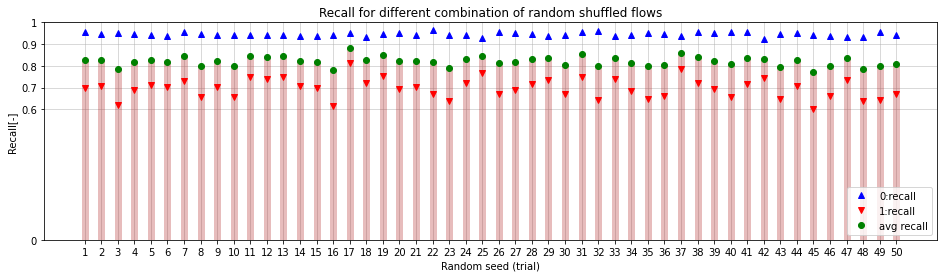

In [315]:
x_label = list(range(1,51))
plt.figure(figsize=(16,4))
plt.plot(x_label, recall_0_list_xgb_3, '^', label='0:recall', color='b')
plt.plot(x_label, recall_1_list_xgb_3, 'v', label='1:recall', color='r')
plt.plot(x_label, recall_avg_list_xgb_3, 'o', label='avg recall', color='g')
plt.vlines(x=x_label, ymin=0, ymax=recall_avg_list_xgb_3, linestyles='solid', color='firebrick', alpha=0.3, linewidth=7)
plt.xticks(x_label, x_label)
plt.legend(loc=4)
plt.grid(alpha=0.6)
plt.ylim([0,1])
plt.yticks([0, 0.6, 0.7, 0.8, 0.9, 1], [0, 0.6, 0.7, 0.8, 0.9, 1])
plt.title('Recall for different combination of random shuffled flows')
plt.xlabel('Random seed (trial)')
plt.ylabel('Recall[-]')
plt.show()

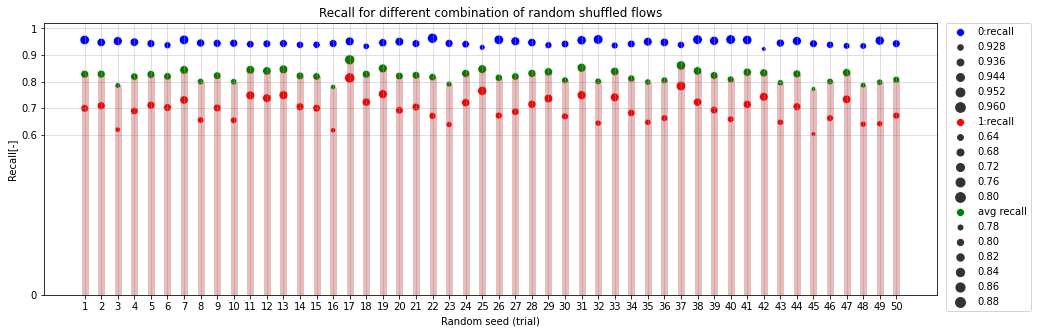

In [316]:
plt.figure(figsize=(16,5))
sns.scatterplot(x=x_label, y=recall_0_list_xgb_3, label='0:recall', size=recall_0_list_xgb_3, sizes=(20, 100), color='b')
sns.scatterplot(x=x_label, y=recall_1_list_xgb_3, label='1:recall', size=recall_1_list_xgb_3, sizes=(20, 100), color='r')
sns.scatterplot(x=x_label, y=recall_avg_list_xgb_3, label='avg recall', size=recall_avg_list_xgb_3, sizes=(20, 100), color='g')
plt.vlines(x=x_label, ymin=0, ymax=recall_avg_list_xgb_3, linestyles='solid', color='firebrick', alpha=0.3, linewidth=7)
plt.xticks(x_label, x_label)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.grid(alpha=0.5)
plt.ylim([0,1.02])
plt.yticks([0, 0.6, 0.7, 0.8, 0.9, 1], [0, 0.6, 0.7, 0.8, 0.9, 1])
plt.title('Recall for different combination of random shuffled flows')
plt.xlabel('Random seed (trial)')
plt.ylabel('Recall[-]')
plt.show()

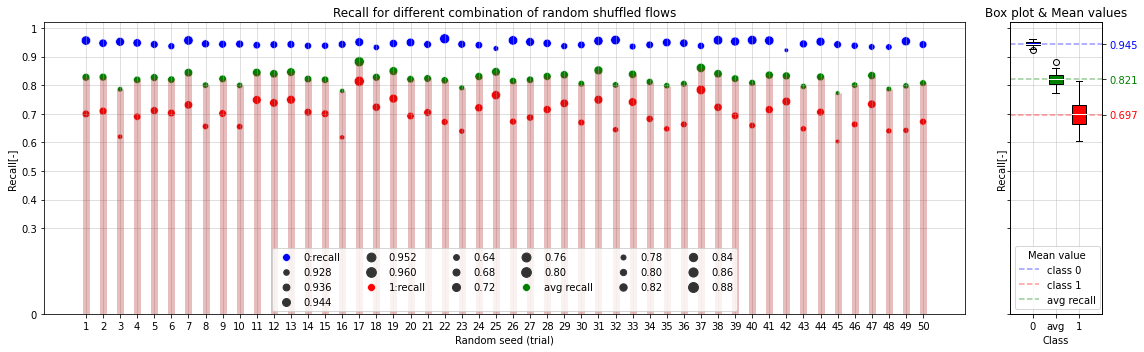

In [498]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), sharey=True, gridspec_kw={'width_ratios': [10, 1]})

sns.scatterplot(x=x_label, y=recall_0_list_xgb_3, label='0:recall', size=recall_0_list_xgb_3, sizes=(20, 100), color='b', ax=ax1)
sns.scatterplot(x=x_label, y=recall_1_list_xgb_3, label='1:recall', size=recall_1_list_xgb_3, sizes=(20, 100), color='r', ax=ax1)
sns.scatterplot(x=x_label, y=recall_avg_list_xgb_3, label='avg recall', size=recall_avg_list_xgb_3, sizes=(20, 100), color='g', ax=ax1)
ax1.vlines(x=x_label, ymin=0, ymax=recall_avg_list_xgb_3, linestyles='solid', color='firebrick', alpha=0.3, linewidth=7)
ax1.set_xticks(x_label)
ax1.legend(loc='lower center', bbox_to_anchor=(0.5, 0.01), borderaxespad=0, ncol=6)
ax1.grid(alpha=0.5)
plt.ylim([0,1.02])
plt.yticks([0, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], [0, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax1.set_xlabel('Random seed (trial)')
ax1.set_ylabel('Recall[-]')
ax1.set_title('Recall for different combination of random shuffled flows')

box = ax2.boxplot([recall_0_list_xgb_3, recall_1_list_xgb_3, recall_avg_list_xgb_3], positions=[1, 2, 1.5], widths=0.3, patch_artist=True) # meanline=True, showmeans=True
ax2.set_title('Box plot & Mean values')
ax2.set_xticks([1, 2, 1.5])
ax2.set_xticklabels(['0', '1', 'avg'])
ax2.set_xlabel('Class')
ax2.grid(alpha=0.5)
ax2.set_ylabel('Recall[-]')
# ax2.yaxis.set_label_position("right")
colors = ['blue', 'red', 'green']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
for median in box['medians']:
    median.set_color('white')
ax2.axhline(y=0.945, color='b', linestyle='--', alpha=0.4, label='class 0')
ax2.axhline(y=0.697, color='r', linestyle='--', alpha=0.4, label='class 1')
ax2.axhline(y=0.821, color='g', linestyle='--', alpha=0.4, label='avg recall')
ax2.legend(title='Mean value')
ax3 = ax2.twinx()
ax3.set_yticks([0.945, 0.697, 0.821])
ax3.set_ylim([0,1.02])
ax3.get_yticklabels()[0].set_color("b")
ax3.get_yticklabels()[1].set_color("r")
ax3.get_yticklabels()[2].set_color("g")

plt.tight_layout()
plt.show()

In [509]:
print(recall_0_list_xgb_3)
print(recall_1_list_xgb_3)
print(recall_avg_list_xgb_3)

[0.9564023202612064, 0.9472558449192937, 0.9520578507128641, 0.9481666678471007, 0.9427838884914761, 0.9366347713381165, 0.9568386086931887, 0.9449525819634396, 0.9436352175421946, 0.9441508311436282, 0.9402256517766713, 0.9421167071555553, 0.9429963666239349, 0.9379351375087647, 0.938348761606618, 0.9430657761472049, 0.95097704527909, 0.9325495251113739, 0.9460617178148749, 0.9498084155505663, 0.9427938041376575, 0.9627115042743518, 0.9434340715768003, 0.940314892592304, 0.9286314283488324, 0.9569830938232607, 0.9515889823005715, 0.9467983086740657, 0.9367480930087612, 0.9412172163948127, 0.955120368862038, 0.9582735443477276, 0.9354590590051773, 0.9414041971513765, 0.9496965104008046, 0.9472600944819429, 0.9377708210863299, 0.9575879482403269, 0.9530749127069006, 0.9578627532916404, 0.9562408368805377, 0.9225531372396257, 0.9445942021800257, 0.952460142643653, 0.9424070939365824, 0.9382708529580497, 0.9340949493947914, 0.9337379861322606, 0.9538922452564257, 0.9425104999610456]
[0.69

In [310]:
recall_0_list_xgb_3

[0.9564023202612064,
 0.9472558449192937,
 0.9520578507128641,
 0.9481666678471007,
 0.9427838884914761,
 0.9366347713381165,
 0.9568386086931887,
 0.9449525819634396,
 0.9436352175421946,
 0.9441508311436282,
 0.9402256517766713,
 0.9421167071555553,
 0.9429963666239349,
 0.9379351375087647,
 0.938348761606618,
 0.9430657761472049,
 0.95097704527909,
 0.9325495251113739,
 0.9460617178148749,
 0.9498084155505663,
 0.9427938041376575,
 0.9627115042743518,
 0.9434340715768003,
 0.940314892592304,
 0.9286314283488324,
 0.9569830938232607,
 0.9515889823005715,
 0.9467983086740657,
 0.9367480930087612,
 0.9412172163948127,
 0.955120368862038,
 0.9582735443477276,
 0.9354590590051773,
 0.9414041971513765,
 0.9496965104008046,
 0.9472600944819429,
 0.9377708210863299,
 0.9575879482403269,
 0.9530749127069006,
 0.9578627532916404,
 0.9562408368805377,
 0.9225531372396257,
 0.9445942021800257,
 0.952460142643653,
 0.9424070939365824,
 0.9382708529580497,
 0.9340949493947914,
 0.9337379861322606

In [311]:
recall_1_list_xgb_3

[0.6996646171045277,
 0.709502515371716,
 0.6198434879821129,
 0.6899385131358301,
 0.7112912241475685,
 0.7027948574622694,
 0.7312465064281721,
 0.6558412520961431,
 0.7012297372833985,
 0.6550586920067076,
 0.7485746226942426,
 0.7381218557853549,
 0.7493012856344327,
 0.7055897149245388,
 0.7003353828954724,
 0.617551704863052,
 0.8138624930128563,
 0.7231414197875908,
 0.7532140860816099,
 0.6923420905533818,
 0.7046953605366126,
 0.6714924538848519,
 0.6390162101732811,
 0.7210732252655114,
 0.7653437674678591,
 0.6726103968697597,
 0.6870318613750699,
 0.7150363331470095,
 0.7367244270542203,
 0.6694801565120179,
 0.7493012856344327,
 0.6443264393515931,
 0.7411403018446059,
 0.6823365008384572,
 0.647344885410844,
 0.6630519843487982,
 0.7836780324203466,
 0.7229178311906093,
 0.693236444941308,
 0.6590273896031302,
 0.7147568474007826,
 0.7430408049189491,
 0.6474566797093348,
 0.7059250978200112,
 0.6032420346562325,
 0.6629401900503075,
 0.7336500838457238,
 0.64013415315818

In [312]:
recall_avg_list_xgb_3

[0.828033468682867,
 0.8283791801455049,
 0.7859506693474885,
 0.8190525904914654,
 0.8270375563195222,
 0.8197148144001929,
 0.8440425575606805,
 0.8003969170297913,
 0.8224324774127966,
 0.7996047615751679,
 0.8444001372354569,
 0.8401192814704551,
 0.8461488261291839,
 0.8217624262166517,
 0.8193420722510452,
 0.7803087405051284,
 0.8824197691459732,
 0.8278454724494824,
 0.8496379019482424,
 0.821075253051974,
 0.823744582337135,
 0.8171019790796019,
 0.7912251408750407,
 0.8306940589289078,
 0.8469875979083458,
 0.8147967453465101,
 0.8193104218378207,
 0.8309173209105376,
 0.8367362600314907,
 0.8053486864534153,
 0.8522108272482354,
 0.8012999918496604,
 0.8382996804248917,
 0.8118703489949168,
 0.7985206979058244,
 0.8051560394153705,
 0.8607244267533383,
 0.8402528897154681,
 0.8231556788241043,
 0.8084450714473853,
 0.8354988421406602,
 0.8327969710792874,
 0.7960254409446803,
 0.829192620231832,
 0.7728245642964074,
 0.8006055215041785,
 0.8338725166202576,
 0.78693606964522

[0]	validation_0-aucpr:0.505073
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.561171
[2]	validation_0-aucpr:0.584037
[3]	validation_0-aucpr:0.586745
[4]	validation_0-aucpr:0.588573
[5]	validation_0-aucpr:0.590941
[6]	validation_0-aucpr:0.58915
[7]	validation_0-aucpr:0.584651
[8]	validation_0-aucpr:0.589893
[9]	validation_0-aucpr:0.592183
[10]	validation_0-aucpr:0.591121
[11]	validation_0-aucpr:0.58838
[12]	validation_0-aucpr:0.588213
[13]	validation_0-aucpr:0.587246
[14]	validation_0-aucpr:0.584901
[15]	validation_0-aucpr:0.584913
[16]	validation_0-aucpr:0.585753
[17]	validation_0-aucpr:0.583295
[18]	validation_0-aucpr:0.580901
[19]	validation_0-aucpr:0.579073
Stopping. Best iteration:
[9]	validation_0-aucpr:0.592183

Prediction Report of trial 17
               precision    recall  f1-score   support

           0       1.00      0.95      0.97    705955
           1       0.28      0.82      0.42     17890

    accuracy                    

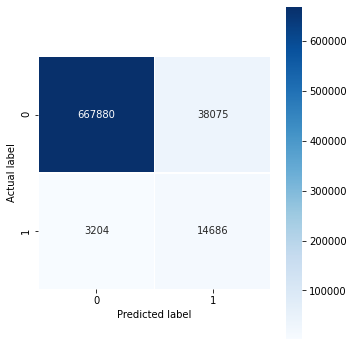

In [314]:
# # check how old best features behave for both models at trial 17

# shuffled_flow_id_loss = flow_id_loss.copy()
# shuffled_flow_id_no_loss = flow_id_no_loss.copy()

# for trial in range(1, 51):
#     random.seed(trial)
    
#     random.shuffle(shuffled_flow_id_loss)
#     random.shuffle(shuffled_flow_id_no_loss)
    
#     if trial == 17:
#         df_loss_new = pd.concat([df_loss[df_loss['flow_id']==x] for x in shuffled_flow_id_loss])
#         df_no_loss_new = pd.concat([df_no_loss[df_no_loss['flow_id']==x] for x in shuffled_flow_id_no_loss])

#         df_train = pd.concat([df_loss_new.iloc[0:int(df_loss_new.shape[0] * 0.7)], df_no_loss_new.iloc[0:int(df_no_loss_new.shape[0] * 0.7)]])
#         df_train_shuffled = df_train.sample(frac=1).reset_index()
#         df_train_shuffled.drop(['index'], axis=1, inplace=True)
#         df_test = pd.concat([df_loss_new.iloc[int(df_loss_new.shape[0] * 0.7)+1: -1], df_no_loss_new.iloc[int(df_no_loss_new.shape[0] * 0.7)+1: -1]])
#         df_test_shuffled = df_test.sample(frac=1).reset_index()
#         df_test_shuffled.drop(['index'], axis=1, inplace=True)

#         x_train = df_train_shuffled[best_feature_list_removing_500ms]
#         x_test = df_test_shuffled[best_feature_list_removing_500ms]
#         y_train = df_train_shuffled[['lossOrNot']]
#         y_train = y_train.astype(int)
#         y_test = df_test_shuffled[['lossOrNot']]
#         y_test = y_test.astype(int)
        
#         # xgboost
#         clf_xgb_check = xgb.XGBClassifier(
#             n_estimators=500, 
#             objective='binary:logistic', 
#             scale_pos_weight=weight, 
#             n_jobs=48
#         )
#         clf_xgb_check.fit(x_train, y_train, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(x_test, y_test)])

#         y_pred = clf_xgb_check.predict(x_test)
#         print(f"Prediction Report of trial {trial}\n", classification_report(y_test, y_pred))
#         cm = confusion_matrix(y_test, y_pred)
#         plt.figure(figsize=(5,5))
#         sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
#         plt.ylabel('Actual label')
#         plt.xlabel('Predicted label')
#         plt.tight_layout()
#         plt.show()

#### considering quantity of packet loss 

In [16]:
df_loss = df_final_check[df_final_check['num_packet_loss'] > 2]
df_no_loss = df_final_check[df_final_check['lossOrNot'] < 1]

flow_id_loss = df_loss['flow_id'].drop_duplicates().tolist()
flow_id_no_loss = df_no_loss['flow_id'].drop_duplicates().tolist()

weight = len(df_no_loss) / len(df_loss)
weight

129.9528937486194

Prediction Report of trial 1
               precision    recall  f1-score   support

           0       1.00      0.94      0.97    705955
           1       0.10      0.86      0.18      5431

    accuracy                           0.94    711386
   macro avg       0.55      0.90      0.57    711386
weighted avg       0.99      0.94      0.96    711386



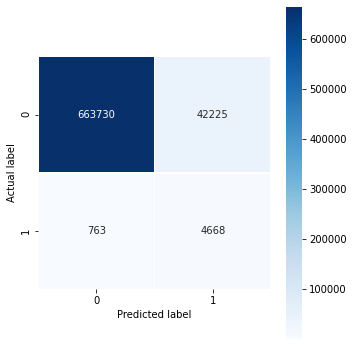

Prediction Report of trial 2
               precision    recall  f1-score   support

           0       1.00      0.95      0.97    705955
           1       0.11      0.89      0.20      5431

    accuracy                           0.95    711386
   macro avg       0.56      0.92      0.59    711386
weighted avg       0.99      0.95      0.97    711386



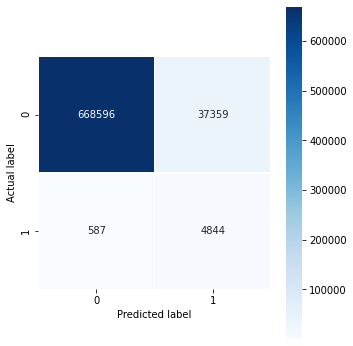

Prediction Report of trial 3
               precision    recall  f1-score   support

           0       1.00      0.93      0.97    705955
           1       0.09      0.88      0.17      5431

    accuracy                           0.93    711386
   macro avg       0.55      0.91      0.57    711386
weighted avg       0.99      0.93      0.96    711386



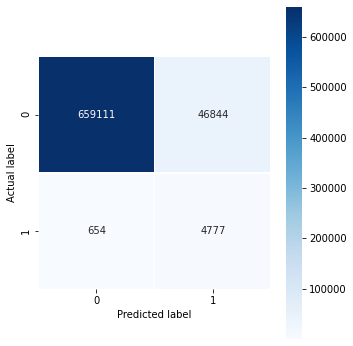

Prediction Report of trial 4
               precision    recall  f1-score   support

           0       1.00      0.92      0.96    705955
           1       0.08      0.91      0.14      5431

    accuracy                           0.92    711386
   macro avg       0.54      0.91      0.55    711386
weighted avg       0.99      0.92      0.95    711386



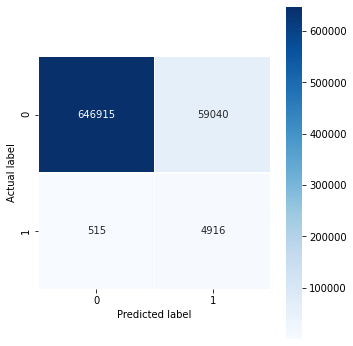

Prediction Report of trial 5
               precision    recall  f1-score   support

           0       1.00      0.97      0.98    705955
           1       0.17      0.86      0.28      5431

    accuracy                           0.97    711386
   macro avg       0.58      0.91      0.63    711386
weighted avg       0.99      0.97      0.98    711386



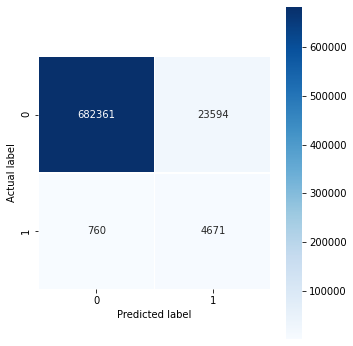

Prediction Report of trial 6
               precision    recall  f1-score   support

           0       1.00      0.94      0.97    705955
           1       0.11      0.86      0.19      5431

    accuracy                           0.94    711386
   macro avg       0.55      0.90      0.58    711386
weighted avg       0.99      0.94      0.97    711386



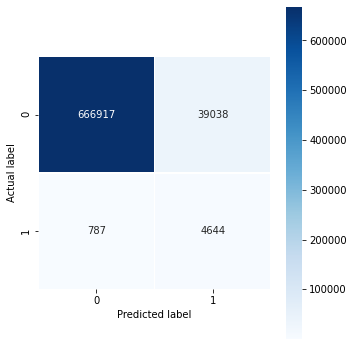

Prediction Report of trial 7
               precision    recall  f1-score   support

           0       1.00      0.93      0.96    705955
           1       0.09      0.87      0.16      5431

    accuracy                           0.93    711386
   macro avg       0.54      0.90      0.56    711386
weighted avg       0.99      0.93      0.96    711386



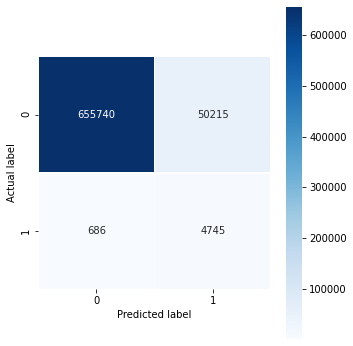

Prediction Report of trial 8
               precision    recall  f1-score   support

           0       1.00      0.93      0.96    705955
           1       0.09      0.90      0.16      5431

    accuracy                           0.93    711386
   macro avg       0.54      0.92      0.56    711386
weighted avg       0.99      0.93      0.96    711386



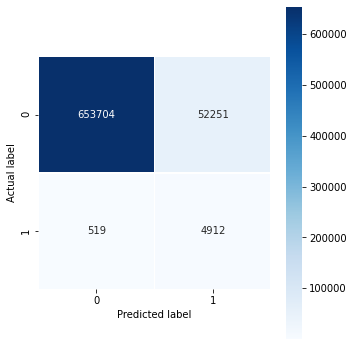

Prediction Report of trial 9
               precision    recall  f1-score   support

           0       1.00      0.92      0.96    705955
           1       0.08      0.91      0.15      5431

    accuracy                           0.92    711386
   macro avg       0.54      0.92      0.55    711386
weighted avg       0.99      0.92      0.95    711386



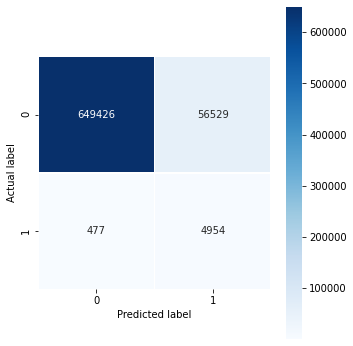

Prediction Report of trial 10
               precision    recall  f1-score   support

           0       1.00      0.96      0.98    705955
           1       0.15      0.85      0.26      5431

    accuracy                           0.96    711386
   macro avg       0.58      0.91      0.62    711386
weighted avg       0.99      0.96      0.98    711386



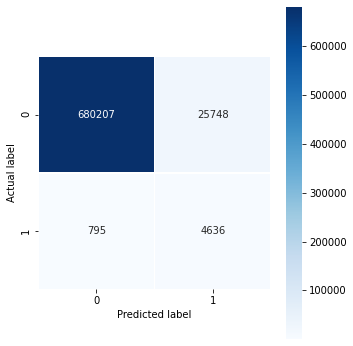

Prediction Report of trial 11
               precision    recall  f1-score   support

           0       1.00      0.96      0.98    705955
           1       0.13      0.86      0.23      5431

    accuracy                           0.96    711386
   macro avg       0.56      0.91      0.60    711386
weighted avg       0.99      0.96      0.97    711386



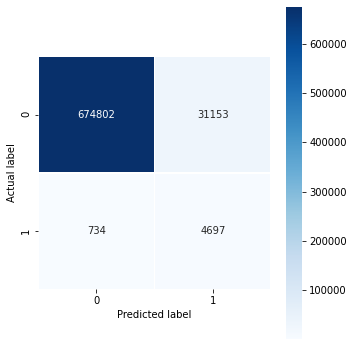

Prediction Report of trial 12
               precision    recall  f1-score   support

           0       1.00      0.94      0.97    705955
           1       0.09      0.84      0.16      5431

    accuracy                           0.93    711386
   macro avg       0.54      0.89      0.56    711386
weighted avg       0.99      0.93      0.96    711386



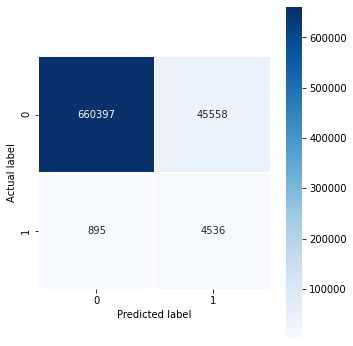

Prediction Report of trial 13
               precision    recall  f1-score   support

           0       1.00      0.94      0.97    705955
           1       0.11      0.91      0.20      5431

    accuracy                           0.94    711386
   macro avg       0.56      0.93      0.58    711386
weighted avg       0.99      0.94      0.97    711386



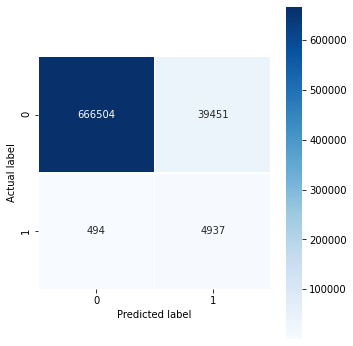

Prediction Report of trial 14
               precision    recall  f1-score   support

           0       1.00      0.92      0.96    705955
           1       0.08      0.91      0.15      5431

    accuracy                           0.92    711386
   macro avg       0.54      0.92      0.56    711386
weighted avg       0.99      0.92      0.95    711386



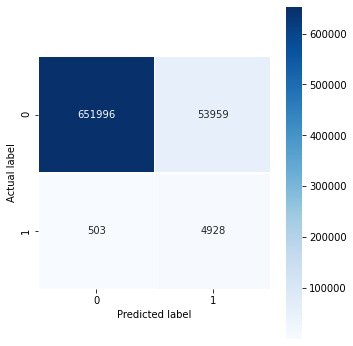

Prediction Report of trial 15
               precision    recall  f1-score   support

           0       1.00      0.95      0.98    705955
           1       0.13      0.88      0.22      5431

    accuracy                           0.95    711386
   macro avg       0.56      0.92      0.60    711386
weighted avg       0.99      0.95      0.97    711386



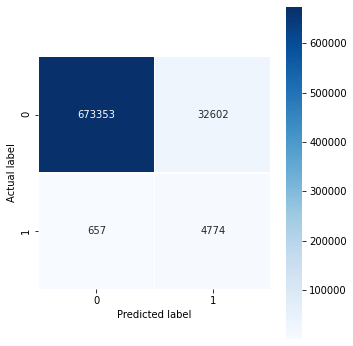

Prediction Report of trial 16
               precision    recall  f1-score   support

           0       1.00      0.93      0.96    705955
           1       0.08      0.89      0.15      5431

    accuracy                           0.93    711386
   macro avg       0.54      0.91      0.56    711386
weighted avg       0.99      0.93      0.96    711386



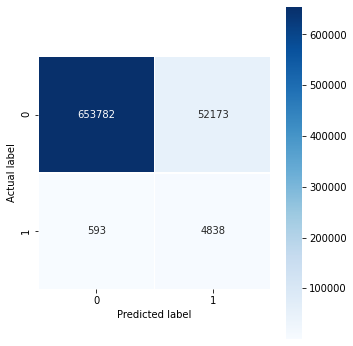

Prediction Report of trial 17
               precision    recall  f1-score   support

           0       1.00      0.95      0.97    705955
           1       0.11      0.86      0.19      5431

    accuracy                           0.94    711386
   macro avg       0.55      0.90      0.58    711386
weighted avg       0.99      0.94      0.97    711386



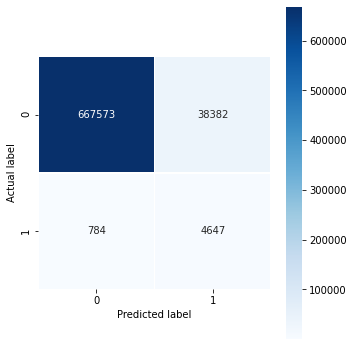

Prediction Report of trial 18
               precision    recall  f1-score   support

           0       1.00      0.95      0.97    705955
           1       0.11      0.88      0.19      5431

    accuracy                           0.94    711386
   macro avg       0.55      0.91      0.58    711386
weighted avg       0.99      0.94      0.97    711386



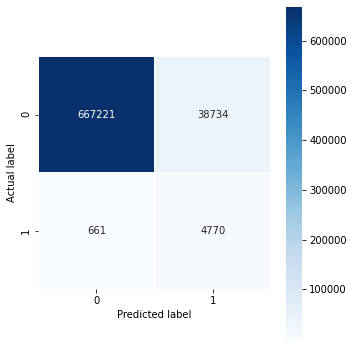

Prediction Report of trial 19
               precision    recall  f1-score   support

           0       1.00      0.93      0.97    705955
           1       0.09      0.88      0.17      5431

    accuracy                           0.93    711386
   macro avg       0.55      0.91      0.57    711386
weighted avg       0.99      0.93      0.96    711386



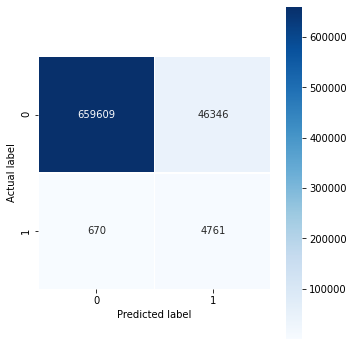

Prediction Report of trial 20
               precision    recall  f1-score   support

           0       1.00      0.94      0.97    705955
           1       0.11      0.92      0.20      5431

    accuracy                           0.94    711386
   macro avg       0.56      0.93      0.59    711386
weighted avg       0.99      0.94      0.97    711386



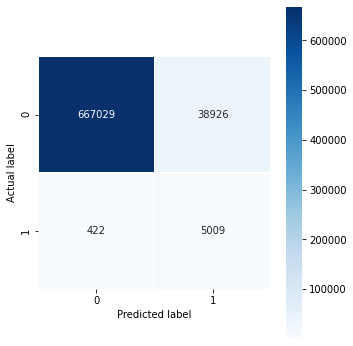

Prediction Report of trial 21
               precision    recall  f1-score   support

           0       1.00      0.89      0.94    705955
           1       0.06      0.90      0.11      5431

    accuracy                           0.89    711386
   macro avg       0.53      0.89      0.53    711386
weighted avg       0.99      0.89      0.94    711386



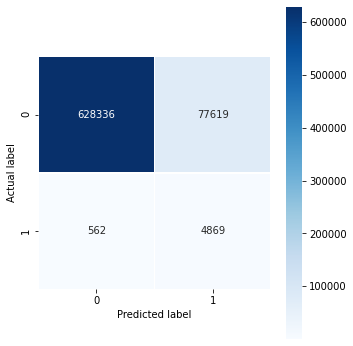

Prediction Report of trial 22
               precision    recall  f1-score   support

           0       1.00      0.90      0.95    705955
           1       0.07      0.92      0.12      5431

    accuracy                           0.90    711386
   macro avg       0.53      0.91      0.53    711386
weighted avg       0.99      0.90      0.94    711386



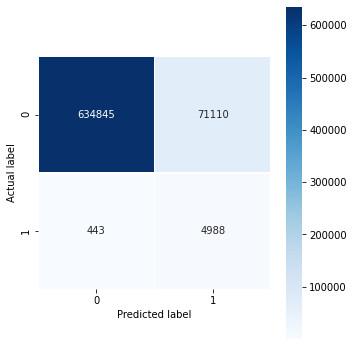

Prediction Report of trial 23
               precision    recall  f1-score   support

           0       1.00      0.95      0.97    705955
           1       0.12      0.91      0.21      5431

    accuracy                           0.95    711386
   macro avg       0.56      0.93      0.59    711386
weighted avg       0.99      0.95      0.97    711386



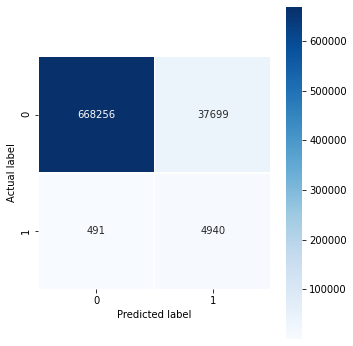

Prediction Report of trial 24
               precision    recall  f1-score   support

           0       1.00      0.95      0.97    705955
           1       0.11      0.88      0.20      5431

    accuracy                           0.95    711386
   macro avg       0.56      0.92      0.58    711386
weighted avg       0.99      0.95      0.97    711386



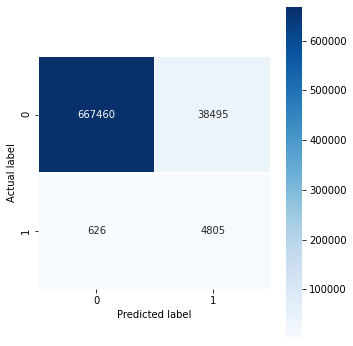

Prediction Report of trial 25
               precision    recall  f1-score   support

           0       1.00      0.94      0.97    705955
           1       0.10      0.84      0.18      5431

    accuracy                           0.94    711386
   macro avg       0.55      0.89      0.58    711386
weighted avg       0.99      0.94      0.96    711386



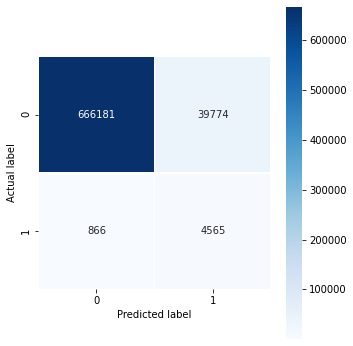

Prediction Report of trial 26
               precision    recall  f1-score   support

           0       1.00      0.93      0.96    705955
           1       0.09      0.84      0.16      5431

    accuracy                           0.93    711386
   macro avg       0.54      0.89      0.56    711386
weighted avg       0.99      0.93      0.96    711386



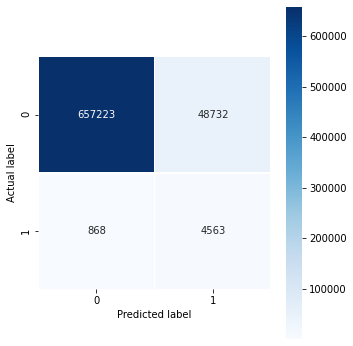

Prediction Report of trial 27
               precision    recall  f1-score   support

           0       1.00      0.89      0.94    705955
           1       0.06      0.90      0.11      5431

    accuracy                           0.89    711386
   macro avg       0.53      0.89      0.53    711386
weighted avg       0.99      0.89      0.94    711386



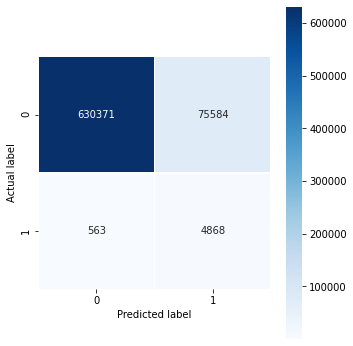

Prediction Report of trial 28
               precision    recall  f1-score   support

           0       1.00      0.90      0.95    705955
           1       0.07      0.91      0.12      5431

    accuracy                           0.90    711386
   macro avg       0.53      0.91      0.53    711386
weighted avg       0.99      0.90      0.94    711386



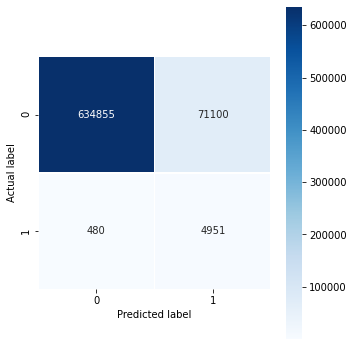

Prediction Report of trial 29
               precision    recall  f1-score   support

           0       1.00      0.92      0.96    705955
           1       0.09      0.92      0.16      5431

    accuracy                           0.92    711386
   macro avg       0.54      0.92      0.56    711386
weighted avg       0.99      0.92      0.95    711386



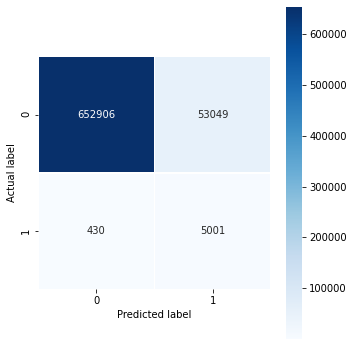

Prediction Report of trial 30
               precision    recall  f1-score   support

           0       1.00      0.95      0.97    705955
           1       0.11      0.84      0.20      5431

    accuracy                           0.95    711386
   macro avg       0.55      0.89      0.58    711386
weighted avg       0.99      0.95      0.97    711386



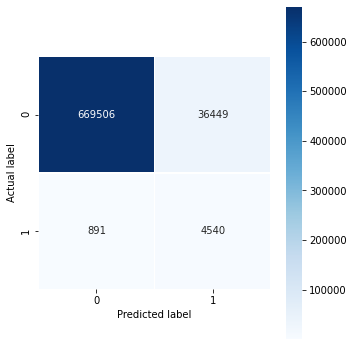

Prediction Report of trial 31
               precision    recall  f1-score   support

           0       1.00      0.92      0.96    705955
           1       0.08      0.89      0.14      5431

    accuracy                           0.92    711386
   macro avg       0.54      0.90      0.55    711386
weighted avg       0.99      0.92      0.95    711386



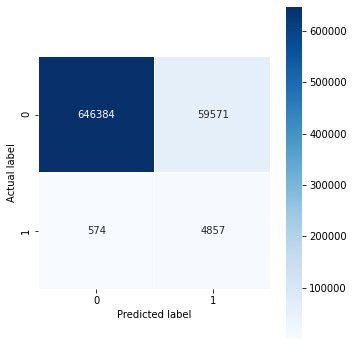

Prediction Report of trial 32
               precision    recall  f1-score   support

           0       1.00      0.95      0.98    705955
           1       0.13      0.89      0.22      5431

    accuracy                           0.95    711386
   macro avg       0.56      0.92      0.60    711386
weighted avg       0.99      0.95      0.97    711386



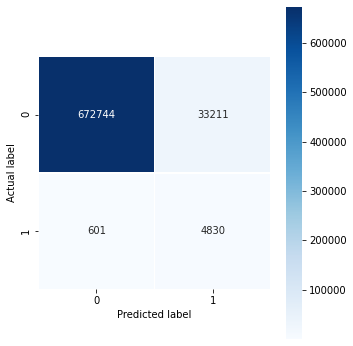

Prediction Report of trial 33
               precision    recall  f1-score   support

           0       1.00      0.95      0.97    705955
           1       0.12      0.87      0.21      5431

    accuracy                           0.95    711386
   macro avg       0.56      0.91      0.59    711386
weighted avg       0.99      0.95      0.97    711386



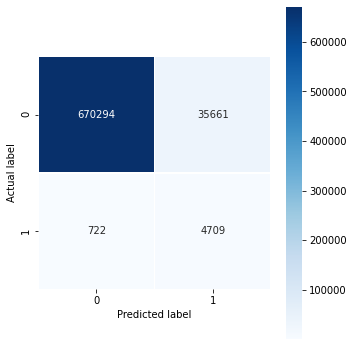

Prediction Report of trial 34
               precision    recall  f1-score   support

           0       1.00      0.92      0.96    705955
           1       0.08      0.90      0.14      5431

    accuracy                           0.92    711386
   macro avg       0.54      0.91      0.55    711386
weighted avg       0.99      0.92      0.95    711386



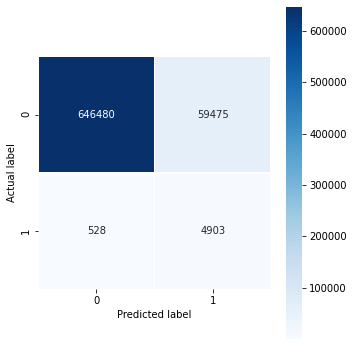

Prediction Report of trial 35
               precision    recall  f1-score   support

           0       1.00      0.91      0.95    705955
           1       0.07      0.92      0.13      5431

    accuracy                           0.91    711386
   macro avg       0.54      0.91      0.54    711386
weighted avg       0.99      0.91      0.95    711386



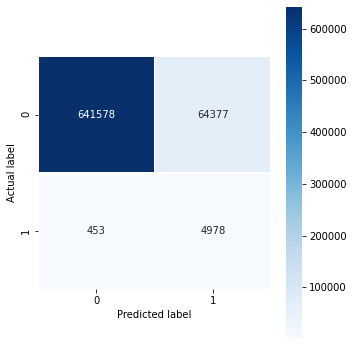

Prediction Report of trial 36
               precision    recall  f1-score   support

           0       1.00      0.88      0.94    705955
           1       0.06      0.90      0.10      5431

    accuracy                           0.88    711386
   macro avg       0.53      0.89      0.52    711386
weighted avg       0.99      0.88      0.93    711386



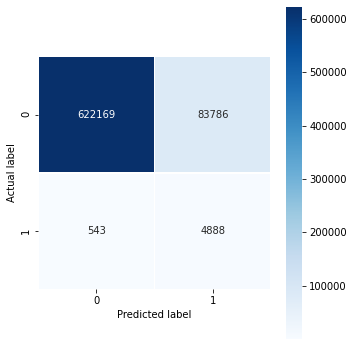

Prediction Report of trial 37
               precision    recall  f1-score   support

           0       1.00      0.95      0.97    705955
           1       0.11      0.83      0.19      5431

    accuracy                           0.95    711386
   macro avg       0.55      0.89      0.58    711386
weighted avg       0.99      0.95      0.97    711386



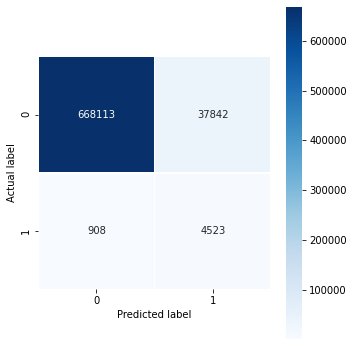

Prediction Report of trial 38
               precision    recall  f1-score   support

           0       1.00      0.93      0.96    705955
           1       0.09      0.87      0.16      5431

    accuracy                           0.93    711386
   macro avg       0.54      0.90      0.56    711386
weighted avg       0.99      0.93      0.96    711386



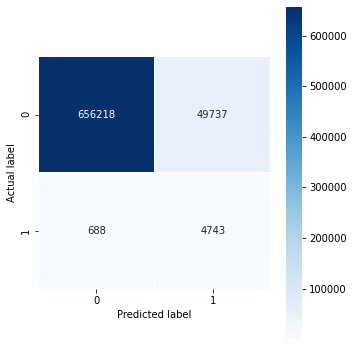

Prediction Report of trial 39
               precision    recall  f1-score   support

           0       1.00      0.94      0.97    705955
           1       0.10      0.93      0.19      5431

    accuracy                           0.94    711386
   macro avg       0.55      0.94      0.58    711386
weighted avg       0.99      0.94      0.96    711386



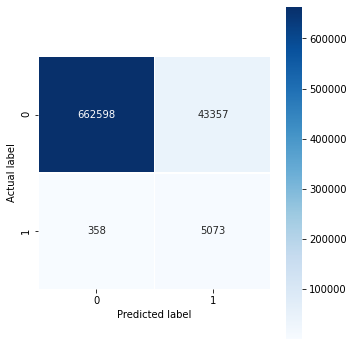

Prediction Report of trial 40
               precision    recall  f1-score   support

           0       1.00      0.95      0.97    705955
           1       0.12      0.91      0.21      5431

    accuracy                           0.95    711386
   macro avg       0.56      0.93      0.59    711386
weighted avg       0.99      0.95      0.97    711386



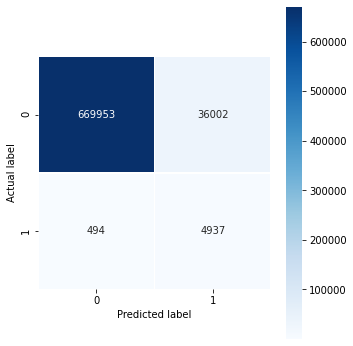

Prediction Report of trial 41
               precision    recall  f1-score   support

           0       1.00      0.93      0.96    705955
           1       0.09      0.87      0.16      5431

    accuracy                           0.93    711386
   macro avg       0.54      0.90      0.56    711386
weighted avg       0.99      0.93      0.96    711386



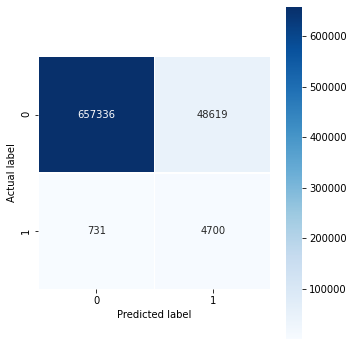

Prediction Report of trial 42
               precision    recall  f1-score   support

           0       1.00      0.96      0.98    705955
           1       0.14      0.91      0.24      5431

    accuracy                           0.96    711386
   macro avg       0.57      0.93      0.61    711386
weighted avg       0.99      0.96      0.97    711386



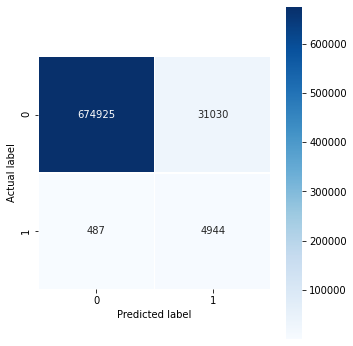

Prediction Report of trial 43
               precision    recall  f1-score   support

           0       1.00      0.93      0.96    705955
           1       0.09      0.90      0.17      5431

    accuracy                           0.93    711386
   macro avg       0.55      0.91      0.57    711386
weighted avg       0.99      0.93      0.96    711386



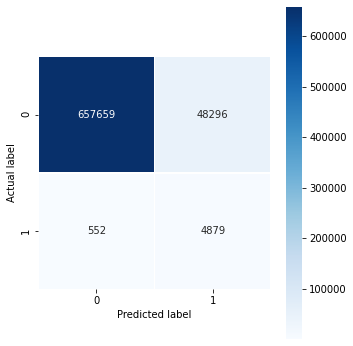

Prediction Report of trial 44
               precision    recall  f1-score   support

           0       1.00      0.92      0.96    705955
           1       0.08      0.89      0.15      5431

    accuracy                           0.92    711386
   macro avg       0.54      0.91      0.55    711386
weighted avg       0.99      0.92      0.95    711386



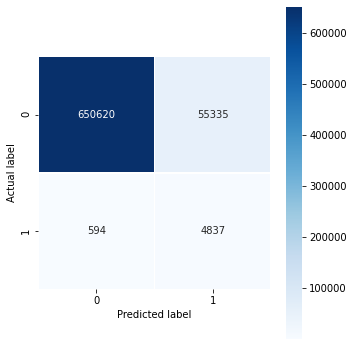

Prediction Report of trial 45
               precision    recall  f1-score   support

           0       1.00      0.95      0.97    705955
           1       0.12      0.88      0.21      5431

    accuracy                           0.95    711386
   macro avg       0.56      0.91      0.59    711386
weighted avg       0.99      0.95      0.97    711386



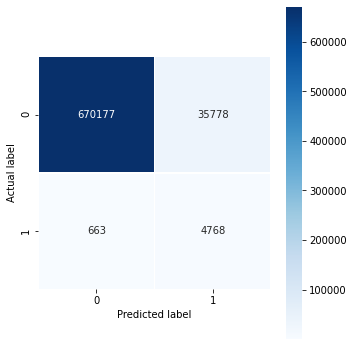

Prediction Report of trial 46
               precision    recall  f1-score   support

           0       1.00      0.95      0.97    705955
           1       0.11      0.88      0.20      5431

    accuracy                           0.95    711386
   macro avg       0.56      0.91      0.59    711386
weighted avg       0.99      0.95      0.97    711386



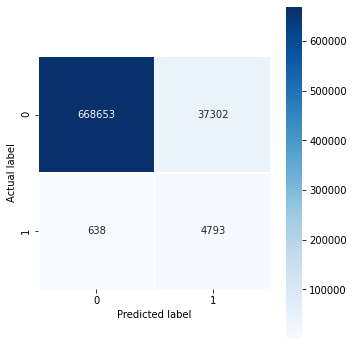

Prediction Report of trial 47
               precision    recall  f1-score   support

           0       1.00      0.94      0.97    705955
           1       0.10      0.91      0.19      5431

    accuracy                           0.94    711386
   macro avg       0.55      0.93      0.58    711386
weighted avg       0.99      0.94      0.96    711386



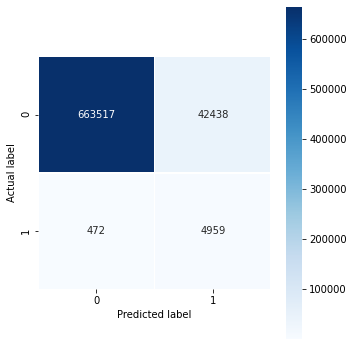

Prediction Report of trial 48
               precision    recall  f1-score   support

           0       1.00      0.94      0.97    705955
           1       0.10      0.85      0.17      5431

    accuracy                           0.94    711386
   macro avg       0.55      0.90      0.57    711386
weighted avg       0.99      0.94      0.96    711386



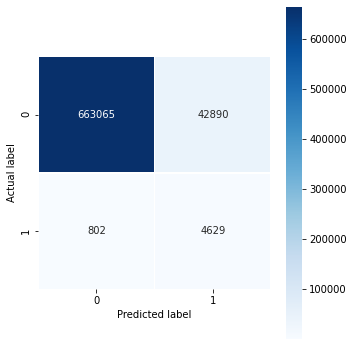

Prediction Report of trial 49
               precision    recall  f1-score   support

           0       1.00      0.93      0.96    705955
           1       0.09      0.92      0.16      5431

    accuracy                           0.93    711386
   macro avg       0.54      0.92      0.56    711386
weighted avg       0.99      0.93      0.96    711386



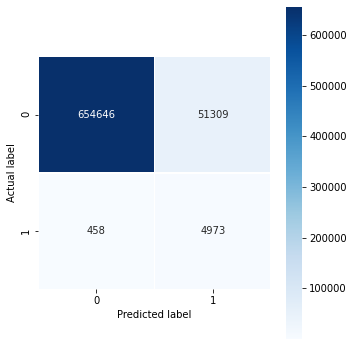

Prediction Report of trial 50
               precision    recall  f1-score   support

           0       1.00      0.89      0.94    705955
           1       0.06      0.89      0.11      5431

    accuracy                           0.89    711386
   macro avg       0.53      0.89      0.53    711386
weighted avg       0.99      0.89      0.94    711386



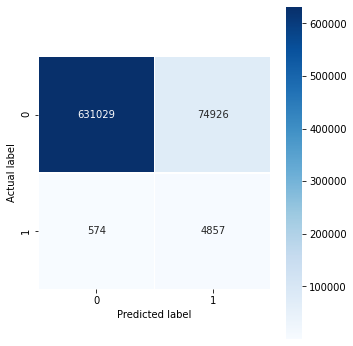

In [20]:
# balanced random forest

shuffled_flow_id_loss = flow_id_loss.copy()
shuffled_flow_id_no_loss = flow_id_no_loss.copy()

recall_0_list_3 = []
recall_1_list_3 = []
recall_avg_list_3 = []

for trial in range(1, 51):
    random.seed(trial)
    
    random.shuffle(shuffled_flow_id_loss)
    random.shuffle(shuffled_flow_id_no_loss)
    
    df_loss_new = pd.concat([df_loss[df_loss['flow_id']==x] for x in shuffled_flow_id_loss])
    df_no_loss_new = pd.concat([df_no_loss[df_no_loss['flow_id']==x] for x in shuffled_flow_id_no_loss])
            
    df_train = pd.concat([df_loss_new.iloc[0:int(df_loss_new.shape[0] * 0.7)], df_no_loss_new.iloc[0:int(df_no_loss_new.shape[0] * 0.7)]])
    df_train_shuffled = df_train.sample(frac=1).reset_index()
    df_train_shuffled.drop(['index'], axis=1, inplace=True)
    df_test = pd.concat([df_loss_new.iloc[int(df_loss_new.shape[0] * 0.7)+1: -1], df_no_loss_new.iloc[int(df_no_loss_new.shape[0] * 0.7)+1: -1]])
    df_test_shuffled = df_test.sample(frac=1).reset_index()
    df_test_shuffled.drop(['index'], axis=1, inplace=True)

    x_train = df_train_shuffled[full_features_list_removing_500ms]
    x_test = df_test_shuffled[full_features_list_removing_500ms]
    y_train = df_train_shuffled[['lossOrNot']]
    y_train = y_train.astype(int)
    y_test = df_test_shuffled[['lossOrNot']]
    y_test = y_test.astype(int)
    
    my_brf_model_check = BalancedRandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=0) 
    my_brf_model_check.fit(x_train, y_train)
            
    y_pred = my_brf_model_check.predict(x_test)
    print(f"Prediction Report of trial {trial}\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
    report = classification_report(y_test, y_pred, output_dict=True)
    recall_0_list_3.append(report['0']['recall'])
    recall_1_list_3.append(report['1']['recall'])
    recall_avg_list_3.append(report['macro avg']['recall'])

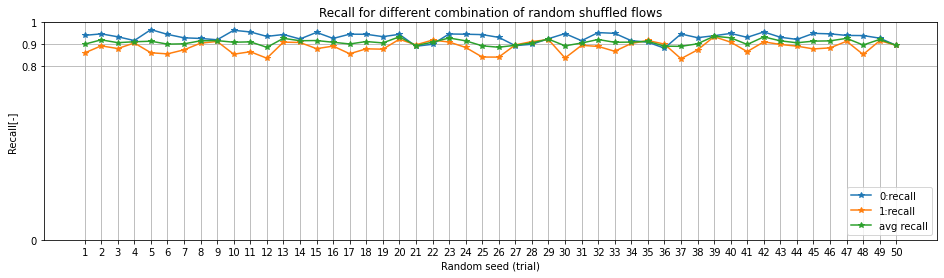

The best performance is at trial 39:
   recall of class 0: 0.9385839040732058
   recall of class 1: 0.9340821211563248
   macro average recall: 0.9363330126147653

The average is 0.9328376454589882 (0:recall), 0.8857816240103111 (1:recall), 0.9093096347346495 (avg recall)


In [26]:
x_label = list(range(1,51))
plt.figure(figsize=(16,4))
plt.plot(x_label, recall_0_list_3, '*-', label='0:recall')
plt.plot(x_label, recall_1_list_3, '*-', label='1:recall')
plt.plot(x_label, recall_avg_list_3, '*-', label='avg recall')
plt.xticks(x_label, x_label)
plt.legend(loc=4)
plt.grid()
plt.ylim([0,1])
plt.yticks([0, 0.8, 0.9, 1], [0, 0.8, 0.9, 1])
plt.title('Recall for different combination of random shuffled flows')
plt.xlabel('Random seed (trial)')
plt.ylabel('Recall[-]')
plt.show()

print(f'The best performance is at trial 39:\n   recall of class 0: {recall_0_list_3[38]}\n   recall of class 1: {recall_1_list_3[38]}\n   macro average recall: {recall_avg_list_3[38]}')
print()
print(f'The average is {np.array(recall_0_list_3).mean()} (0:recall), {np.array(recall_1_list_3).mean()} (1:recall), {np.array(recall_avg_list_3).mean()} (avg recall)')

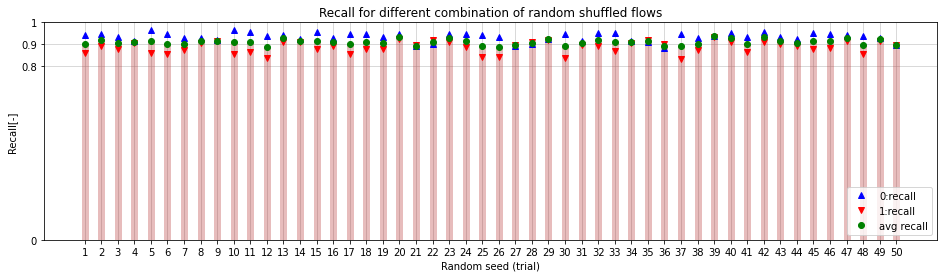

In [28]:
x_label = list(range(1,51))
plt.figure(figsize=(16,4))
plt.plot(x_label, recall_0_list_3, '^', label='0:recall', color='b')
plt.plot(x_label, recall_1_list_3, 'v', label='1:recall', color='r')
plt.plot(x_label, recall_avg_list_3, 'o', label='avg recall', color='g')
plt.vlines(x=x_label, ymin=0, ymax=recall_avg_list_3, linestyles='solid', color='firebrick', alpha=0.3, linewidth=7)
plt.xticks(x_label, x_label)
plt.legend(loc=4)
plt.grid(alpha=0.6)
plt.ylim([0,1])
plt.yticks([0, 0.8, 0.9, 1], [0, 0.8, 0.9, 1])
plt.title('Recall for different combination of random shuffled flows')
plt.xlabel('Random seed (trial)')
plt.ylabel('Recall[-]')
plt.show()

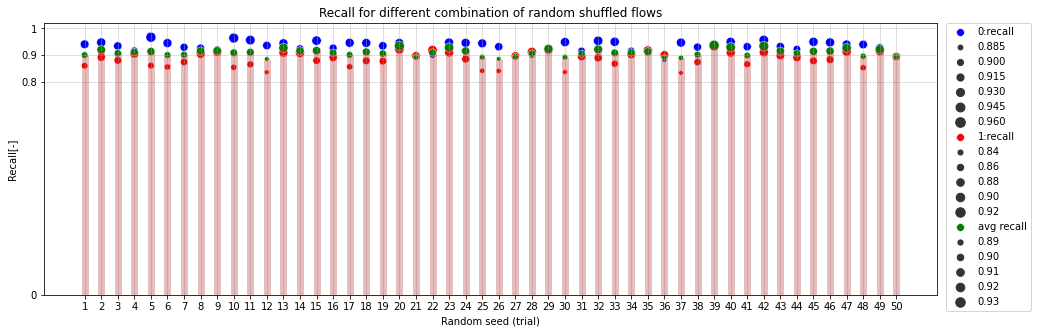

In [29]:
plt.figure(figsize=(16,5))
sns.scatterplot(x=x_label, y=recall_0_list_3, label='0:recall', size=recall_0_list_3, sizes=(20, 100), color='b')
sns.scatterplot(x=x_label, y=recall_1_list_3, label='1:recall', size=recall_1_list_3, sizes=(20, 100), color='r')
sns.scatterplot(x=x_label, y=recall_avg_list_3, label='avg recall', size=recall_avg_list_3, sizes=(20, 100), color='g')
plt.vlines(x=x_label, ymin=0, ymax=recall_avg_list_3, linestyles='solid', color='firebrick', alpha=0.3, linewidth=7)
plt.xticks(x_label, x_label)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.grid(alpha=0.5)
plt.ylim([0,1.02])
plt.yticks([0, 0.8, 0.9, 1], [0, 0.8, 0.9, 1])
plt.title('Recall for different combination of random shuffled flows')
plt.xlabel('Random seed (trial)')
plt.ylabel('Recall[-]')
plt.show()

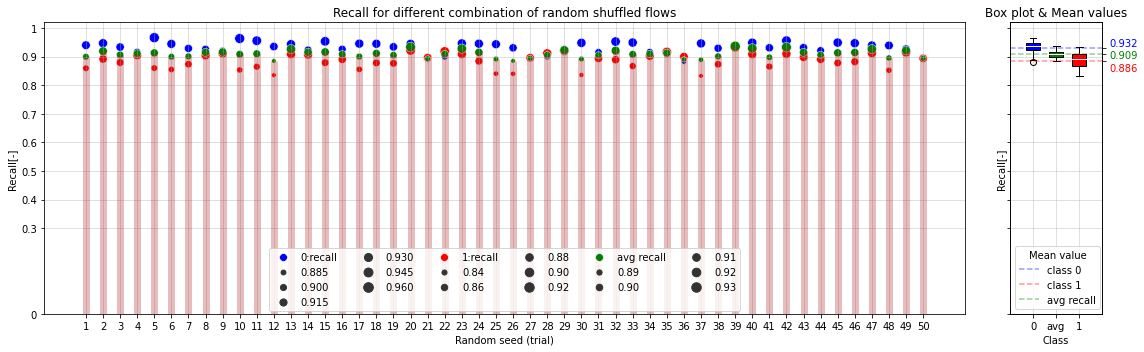

In [502]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), sharey=True, gridspec_kw={'width_ratios': [10, 1]})

sns.scatterplot(x=x_label, y=recall_0_list_3, label='0:recall', size=recall_0_list_3, sizes=(20, 100), color='b', ax=ax1)
sns.scatterplot(x=x_label, y=recall_1_list_3, label='1:recall', size=recall_1_list_3, sizes=(20, 100), color='r', ax=ax1)
sns.scatterplot(x=x_label, y=recall_avg_list_3, label='avg recall', size=recall_avg_list_3, sizes=(20, 100), color='g', ax=ax1)
ax1.vlines(x=x_label, ymin=0, ymax=recall_avg_list_3, linestyles='solid', color='firebrick', alpha=0.3, linewidth=7)
ax1.set_xticks(x_label)
ax1.legend(loc='lower center', bbox_to_anchor=(0.5, 0.01), borderaxespad=0, ncol=6)
ax1.grid(alpha=0.5)
plt.ylim([0,1.02])
plt.yticks([0, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], [0, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax1.set_xlabel('Random seed (trial)')
ax1.set_ylabel('Recall[-]')
ax1.set_title('Recall for different combination of random shuffled flows')

box = ax2.boxplot([recall_0_list_3, recall_1_list_3, recall_avg_list_3], positions=[1, 2, 1.5], widths=0.3, patch_artist=True) # meanline=True, showmeans=True
ax2.set_title('Box plot & Mean values')
ax2.set_xticks([1, 2, 1.5])
ax2.set_xticklabels(['0', '1', 'avg'])
ax2.set_xlabel('Class')
ax2.grid(alpha=0.5)
ax2.set_ylabel('Recall[-]')
# ax2.yaxis.set_label_position("right")
colors = ['blue', 'red', 'green']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
for median in box['medians']:
    median.set_color('white')
ax2.axhline(y=0.932, color='b', linestyle='--', alpha=0.4, label='class 0')
ax2.axhline(y=0.886, color='r', linestyle='--', alpha=0.4, label='class 1')
ax2.axhline(y=0.909, color='g', linestyle='--', alpha=0.4, label='avg recall')
ax2.legend(title='Mean value')
ax3 = ax2.twinx()
ax3.set_yticks([0.932, 0.886, 0.909])
ax3.set_yticklabels(['0.932\n','\n0.886','0.909'])
ax3.set_ylim([0,1.02])
ax3.get_yticklabels()[0].set_color("b")
ax3.get_yticklabels()[1].set_color("r")
ax3.get_yticklabels()[2].set_color("g")

plt.tight_layout()
plt.show()

In [510]:
print(recall_0_list_3)
print(recall_1_list_3)
print(recall_avg_list_3)

[0.9401874057128288, 0.9470801963297943, 0.9336444957539787, 0.9163686070641897, 0.9665786062851032, 0.9447018577671381, 0.9288694038571864, 0.925985367339278, 0.9199254910015511, 0.9635274203029938, 0.9558711249300593, 0.9354661416095926, 0.9441168346424347, 0.923565949671013, 0.9538185861705066, 0.9260958559681566, 0.9456310954664249, 0.9451324801155881, 0.9343499231537421, 0.9448605081060407, 0.8900510655778343, 0.8992712000056661, 0.9465985792295543, 0.9454710286066392, 0.9436592983972066, 0.9309701043267631, 0.8929336855748596, 0.8992853652144966, 0.9248549836745968, 0.9483692303333782, 0.9156164344752853, 0.9529559249527236, 0.9494854487892288, 0.9157524204800589, 0.9088086351113032, 0.8813153812920087, 0.9463960167432769, 0.9295465008392886, 0.9385839040732058, 0.9490024151681056, 0.9311301711865487, 0.9560453569986755, 0.9315877074317768, 0.9216168169359237, 0.9493197158459109, 0.9471609380201288, 0.9398856867647372, 0.9392454193255944, 0.9273197300111197, 0.8938657563159125]
[

In [30]:
recall_0_list_3

[0.9401874057128288,
 0.9470801963297943,
 0.9336444957539787,
 0.9163686070641897,
 0.9665786062851032,
 0.9447018577671381,
 0.9288694038571864,
 0.925985367339278,
 0.9199254910015511,
 0.9635274203029938,
 0.9558711249300593,
 0.9354661416095926,
 0.9441168346424347,
 0.923565949671013,
 0.9538185861705066,
 0.9260958559681566,
 0.9456310954664249,
 0.9451324801155881,
 0.9343499231537421,
 0.9448605081060407,
 0.8900510655778343,
 0.8992712000056661,
 0.9465985792295543,
 0.9454710286066392,
 0.9436592983972066,
 0.9309701043267631,
 0.8929336855748596,
 0.8992853652144966,
 0.9248549836745968,
 0.9483692303333782,
 0.9156164344752853,
 0.9529559249527236,
 0.9494854487892288,
 0.9157524204800589,
 0.9088086351113032,
 0.8813153812920087,
 0.9463960167432769,
 0.9295465008392886,
 0.9385839040732058,
 0.9490024151681056,
 0.9311301711865487,
 0.9560453569986755,
 0.9315877074317768,
 0.9216168169359237,
 0.9493197158459109,
 0.9471609380201288,
 0.9398856867647372,
 0.939245419325

In [31]:
recall_1_list_3

[0.8595102191125022,
 0.891916774074756,
 0.8795801878107162,
 0.9051740011047689,
 0.8600626035720862,
 0.8550911434358314,
 0.8736880869084883,
 0.9044374884919905,
 0.9121708709261646,
 0.8536181182102743,
 0.8648499355551463,
 0.835205302890812,
 0.909040692321856,
 0.9073835389431044,
 0.8790278033511324,
 0.8908120051555883,
 0.8556435278954152,
 0.8782912907383539,
 0.8766341373596023,
 0.9222979193518689,
 0.8965199779046216,
 0.9184312281347818,
 0.9095930767814399,
 0.8847357761001657,
 0.840545019333456,
 0.8401767630270668,
 0.896335849751427,
 0.9116184864665807,
 0.920824894126312,
 0.8359418155035905,
 0.8943104400662861,
 0.8893389799300313,
 0.8670594733934819,
 0.9027803351132389,
 0.9165899466028355,
 0.9000184128153195,
 0.832811636899282,
 0.8733198306020991,
 0.9340821211563248,
 0.909040692321856,
 0.8654023200147303,
 0.9103295893942184,
 0.8983612594365679,
 0.8906278770023937,
 0.8779230344319646,
 0.8825262382618302,
 0.9130915116921378,
 0.852329221137912,
 

In [32]:
recall_avg_list_3

[0.8998488124126656,
 0.9194984852022752,
 0.9066123417823475,
 0.9107713040844793,
 0.9133206049285947,
 0.8998965006014847,
 0.9012787453828374,
 0.9152114279156343,
 0.9160481809638579,
 0.9085727692566341,
 0.9103605302426028,
 0.8853357222502023,
 0.9265787634821454,
 0.9154747443070588,
 0.9164231947608195,
 0.9084539305618724,
 0.9006373116809201,
 0.911711885426971,
 0.9054920302566722,
 0.9335792137289548,
 0.8932855217412279,
 0.908851214070224,
 0.9280958280054971,
 0.9151034023534025,
 0.8921021588653313,
 0.885573433676915,
 0.8946347676631433,
 0.9054519258405387,
 0.9228399389004545,
 0.8921555229184843,
 0.9049634372707858,
 0.9211474524413774,
 0.9082724610913553,
 0.9092663777966489,
 0.9126992908570694,
 0.8906668970536641,
 0.8896038268212794,
 0.9014331657206938,
 0.9363330126147653,
 0.9290215537449809,
 0.8982662456006395,
 0.9331874731964469,
 0.9149744834341723,
 0.9061223469691586,
 0.9136213751389377,
 0.9148435881409795,
 0.9264885992284375,
 0.8957873202317

[0]	validation_0-aucpr:0.398531
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.492638
[2]	validation_0-aucpr:0.506144
[3]	validation_0-aucpr:0.522852
[4]	validation_0-aucpr:0.523362
[5]	validation_0-aucpr:0.522974
[6]	validation_0-aucpr:0.521582
[7]	validation_0-aucpr:0.526792
[8]	validation_0-aucpr:0.536011
[9]	validation_0-aucpr:0.539703
[10]	validation_0-aucpr:0.547598
[11]	validation_0-aucpr:0.544958
[12]	validation_0-aucpr:0.546319
[13]	validation_0-aucpr:0.555974
[14]	validation_0-aucpr:0.557307
[15]	validation_0-aucpr:0.558648
[16]	validation_0-aucpr:0.55991
[17]	validation_0-aucpr:0.559806
[18]	validation_0-aucpr:0.561752
[19]	validation_0-aucpr:0.561714
[20]	validation_0-aucpr:0.562412
[21]	validation_0-aucpr:0.562987
[22]	validation_0-aucpr:0.563183
[23]	validation_0-aucpr:0.563223
[24]	validation_0-aucpr:0.565132
[25]	validation_0-aucpr:0.564306
[26]	validation_0-aucpr:0.564194
[27]	validation_0-aucpr:0.563696
[28]	validation_0-auc

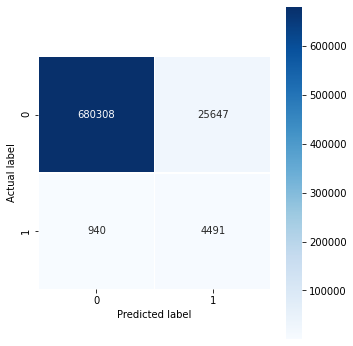

[0]	validation_0-aucpr:0.461395
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.530937
[2]	validation_0-aucpr:0.542567
[3]	validation_0-aucpr:0.556439
[4]	validation_0-aucpr:0.564974
[5]	validation_0-aucpr:0.566303
[6]	validation_0-aucpr:0.576572
[7]	validation_0-aucpr:0.584239
[8]	validation_0-aucpr:0.604081
[9]	validation_0-aucpr:0.606891
[10]	validation_0-aucpr:0.609689
[11]	validation_0-aucpr:0.609438
[12]	validation_0-aucpr:0.611382
[13]	validation_0-aucpr:0.612609
[14]	validation_0-aucpr:0.613558
[15]	validation_0-aucpr:0.612801
[16]	validation_0-aucpr:0.613457
[17]	validation_0-aucpr:0.613822
[18]	validation_0-aucpr:0.612571
[19]	validation_0-aucpr:0.611881
[20]	validation_0-aucpr:0.614214
[21]	validation_0-aucpr:0.624265
[22]	validation_0-aucpr:0.623523
[23]	validation_0-aucpr:0.622945
[24]	validation_0-aucpr:0.623176
[25]	validation_0-aucpr:0.623592
[26]	validation_0-aucpr:0.623662
[27]	validation_0-aucpr:0.62561
[28]	validation_0-auc

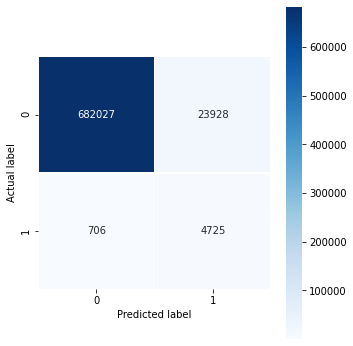

[0]	validation_0-aucpr:0.438966
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.502761
[2]	validation_0-aucpr:0.544891
[3]	validation_0-aucpr:0.549368
[4]	validation_0-aucpr:0.56083
[5]	validation_0-aucpr:0.570405
[6]	validation_0-aucpr:0.574507
[7]	validation_0-aucpr:0.577407
[8]	validation_0-aucpr:0.585299
[9]	validation_0-aucpr:0.593295
[10]	validation_0-aucpr:0.597407
[11]	validation_0-aucpr:0.597056
[12]	validation_0-aucpr:0.606335
[13]	validation_0-aucpr:0.609834
[14]	validation_0-aucpr:0.610273
[15]	validation_0-aucpr:0.614018
[16]	validation_0-aucpr:0.616724
[17]	validation_0-aucpr:0.619767
[18]	validation_0-aucpr:0.618944
[19]	validation_0-aucpr:0.61636
[20]	validation_0-aucpr:0.617734
[21]	validation_0-aucpr:0.620485
[22]	validation_0-aucpr:0.621967
[23]	validation_0-aucpr:0.620748
[24]	validation_0-aucpr:0.620628
[25]	validation_0-aucpr:0.622124
[26]	validation_0-aucpr:0.623137
[27]	validation_0-aucpr:0.624059
[28]	validation_0-aucp

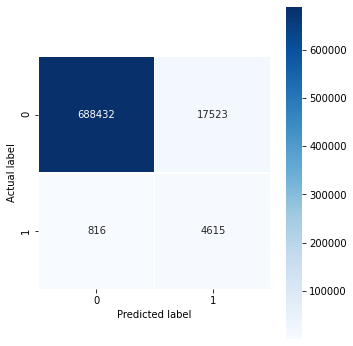

[0]	validation_0-aucpr:0.408986
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.462094
[2]	validation_0-aucpr:0.490042
[3]	validation_0-aucpr:0.499954
[4]	validation_0-aucpr:0.503295
[5]	validation_0-aucpr:0.522638
[6]	validation_0-aucpr:0.520495
[7]	validation_0-aucpr:0.522779
[8]	validation_0-aucpr:0.536746
[9]	validation_0-aucpr:0.536545
[10]	validation_0-aucpr:0.535508
[11]	validation_0-aucpr:0.536961
[12]	validation_0-aucpr:0.536886
[13]	validation_0-aucpr:0.537078
[14]	validation_0-aucpr:0.537938
[15]	validation_0-aucpr:0.539166
[16]	validation_0-aucpr:0.539052
[17]	validation_0-aucpr:0.543917
[18]	validation_0-aucpr:0.5438
[19]	validation_0-aucpr:0.543297
[20]	validation_0-aucpr:0.541598
[21]	validation_0-aucpr:0.540682
[22]	validation_0-aucpr:0.540166
[23]	validation_0-aucpr:0.54074
[24]	validation_0-aucpr:0.539592
[25]	validation_0-aucpr:0.540807
[26]	validation_0-aucpr:0.53733
[27]	validation_0-aucpr:0.538249
Stopping. Best iteration

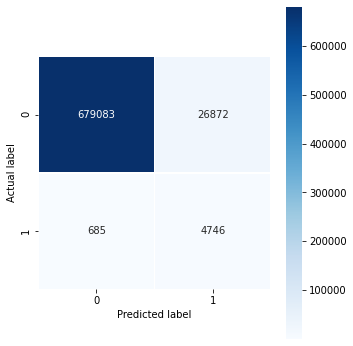

[0]	validation_0-aucpr:0.458434
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.495607
[2]	validation_0-aucpr:0.54426
[3]	validation_0-aucpr:0.568878
[4]	validation_0-aucpr:0.577163
[5]	validation_0-aucpr:0.583089
[6]	validation_0-aucpr:0.586228
[7]	validation_0-aucpr:0.589817
[8]	validation_0-aucpr:0.592255
[9]	validation_0-aucpr:0.593958
[10]	validation_0-aucpr:0.596246
[11]	validation_0-aucpr:0.60051
[12]	validation_0-aucpr:0.603366
[13]	validation_0-aucpr:0.602252
[14]	validation_0-aucpr:0.60528
[15]	validation_0-aucpr:0.604854
[16]	validation_0-aucpr:0.605472
[17]	validation_0-aucpr:0.60509
[18]	validation_0-aucpr:0.606579
[19]	validation_0-aucpr:0.605846
[20]	validation_0-aucpr:0.606122
[21]	validation_0-aucpr:0.605459
[22]	validation_0-aucpr:0.607434
[23]	validation_0-aucpr:0.612513
[24]	validation_0-aucpr:0.611858
[25]	validation_0-aucpr:0.611725
[26]	validation_0-aucpr:0.6111
[27]	validation_0-aucpr:0.612656
[28]	validation_0-aucpr:0.

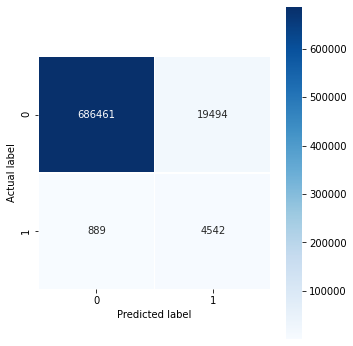

[0]	validation_0-aucpr:0.445546
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.522198
[2]	validation_0-aucpr:0.546195
[3]	validation_0-aucpr:0.568075
[4]	validation_0-aucpr:0.576614
[5]	validation_0-aucpr:0.593206
[6]	validation_0-aucpr:0.597182
[7]	validation_0-aucpr:0.599554
[8]	validation_0-aucpr:0.600304
[9]	validation_0-aucpr:0.600417
[10]	validation_0-aucpr:0.603345
[11]	validation_0-aucpr:0.606543
[12]	validation_0-aucpr:0.607364
[13]	validation_0-aucpr:0.607649
[14]	validation_0-aucpr:0.606861
[15]	validation_0-aucpr:0.60937
[16]	validation_0-aucpr:0.609939
[17]	validation_0-aucpr:0.610089
[18]	validation_0-aucpr:0.610272
[19]	validation_0-aucpr:0.611722
[20]	validation_0-aucpr:0.612587
[21]	validation_0-aucpr:0.611465
[22]	validation_0-aucpr:0.612121
[23]	validation_0-aucpr:0.611603
[24]	validation_0-aucpr:0.612563
[25]	validation_0-aucpr:0.613688
[26]	validation_0-aucpr:0.615526
[27]	validation_0-aucpr:0.614797
[28]	validation_0-auc

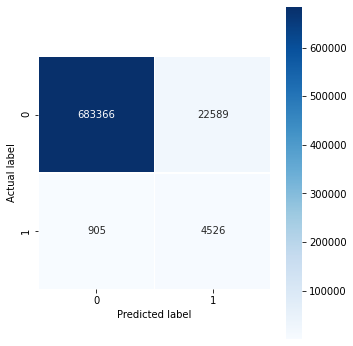

[0]	validation_0-aucpr:0.401576
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.39627
[2]	validation_0-aucpr:0.455128
[3]	validation_0-aucpr:0.484277
[4]	validation_0-aucpr:0.491156
[5]	validation_0-aucpr:0.488593
[6]	validation_0-aucpr:0.486796
[7]	validation_0-aucpr:0.487179
[8]	validation_0-aucpr:0.490553
[9]	validation_0-aucpr:0.491225
[10]	validation_0-aucpr:0.494569
[11]	validation_0-aucpr:0.49928
[12]	validation_0-aucpr:0.504448
[13]	validation_0-aucpr:0.500574
[14]	validation_0-aucpr:0.492201
[15]	validation_0-aucpr:0.491619
[16]	validation_0-aucpr:0.489899
[17]	validation_0-aucpr:0.477264
[18]	validation_0-aucpr:0.479581
[19]	validation_0-aucpr:0.477516
[20]	validation_0-aucpr:0.477687
[21]	validation_0-aucpr:0.477099
[22]	validation_0-aucpr:0.47945
Stopping. Best iteration:
[12]	validation_0-aucpr:0.504448

Prediction Report of trial 7
               precision    recall  f1-score   support

           0       1.00      0.96      0.98

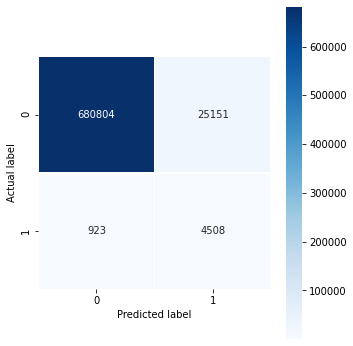

[0]	validation_0-aucpr:0.551703
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.576191
[2]	validation_0-aucpr:0.586761
[3]	validation_0-aucpr:0.603855
[4]	validation_0-aucpr:0.612272
[5]	validation_0-aucpr:0.616832
[6]	validation_0-aucpr:0.6203
[7]	validation_0-aucpr:0.622461
[8]	validation_0-aucpr:0.629749
[9]	validation_0-aucpr:0.631302
[10]	validation_0-aucpr:0.642135
[11]	validation_0-aucpr:0.656615
[12]	validation_0-aucpr:0.65047
[13]	validation_0-aucpr:0.646037
[14]	validation_0-aucpr:0.651347
[15]	validation_0-aucpr:0.655084
[16]	validation_0-aucpr:0.647544
[17]	validation_0-aucpr:0.648801
[18]	validation_0-aucpr:0.648946
[19]	validation_0-aucpr:0.648369
[20]	validation_0-aucpr:0.64877
[21]	validation_0-aucpr:0.650995
Stopping. Best iteration:
[11]	validation_0-aucpr:0.656615

Prediction Report of trial 8
               precision    recall  f1-score   support

           0       1.00      0.97      0.98    705955
           1       0.18

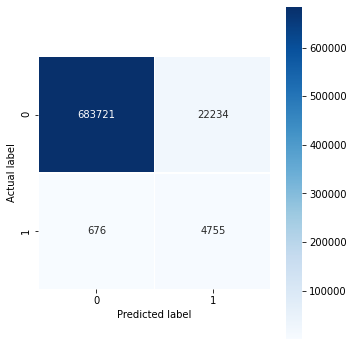

[0]	validation_0-aucpr:0.500568
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.603812
[2]	validation_0-aucpr:0.631307
[3]	validation_0-aucpr:0.637414
[4]	validation_0-aucpr:0.637524
[5]	validation_0-aucpr:0.641117
[6]	validation_0-aucpr:0.640162
[7]	validation_0-aucpr:0.641827
[8]	validation_0-aucpr:0.643851
[9]	validation_0-aucpr:0.644774
[10]	validation_0-aucpr:0.647905
[11]	validation_0-aucpr:0.652107
[12]	validation_0-aucpr:0.653008
[13]	validation_0-aucpr:0.652241
[14]	validation_0-aucpr:0.652374
[15]	validation_0-aucpr:0.654248
[16]	validation_0-aucpr:0.657105
[17]	validation_0-aucpr:0.65557
[18]	validation_0-aucpr:0.657098
[19]	validation_0-aucpr:0.657357
[20]	validation_0-aucpr:0.657574
[21]	validation_0-aucpr:0.658009
[22]	validation_0-aucpr:0.656297
[23]	validation_0-aucpr:0.656591
[24]	validation_0-aucpr:0.653826
[25]	validation_0-aucpr:0.653976
[26]	validation_0-aucpr:0.671875
[27]	validation_0-aucpr:0.672228
[28]	validation_0-auc

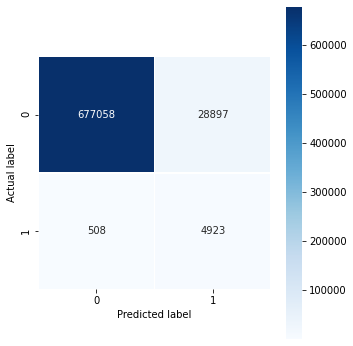

[0]	validation_0-aucpr:0.481339
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.560517
[2]	validation_0-aucpr:0.569392
[3]	validation_0-aucpr:0.575862
[4]	validation_0-aucpr:0.576241
[5]	validation_0-aucpr:0.581327
[6]	validation_0-aucpr:0.581761
[7]	validation_0-aucpr:0.580795
[8]	validation_0-aucpr:0.582353
[9]	validation_0-aucpr:0.585171
[10]	validation_0-aucpr:0.591067
[11]	validation_0-aucpr:0.600992
[12]	validation_0-aucpr:0.602117
[13]	validation_0-aucpr:0.597651
[14]	validation_0-aucpr:0.600316
[15]	validation_0-aucpr:0.59703
[16]	validation_0-aucpr:0.590667
[17]	validation_0-aucpr:0.593418
[18]	validation_0-aucpr:0.590346
[19]	validation_0-aucpr:0.591905
[20]	validation_0-aucpr:0.585627
[21]	validation_0-aucpr:0.591607
[22]	validation_0-aucpr:0.594185
Stopping. Best iteration:
[12]	validation_0-aucpr:0.602117

Prediction Report of trial 10
               precision    recall  f1-score   support

           0       1.00      0.97      0

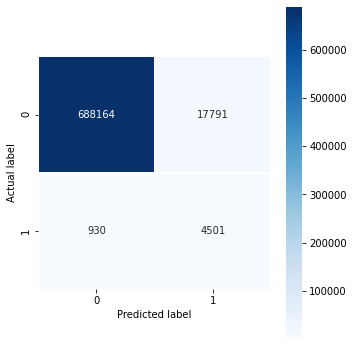

[0]	validation_0-aucpr:0.43579
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.503965
[2]	validation_0-aucpr:0.526858
[3]	validation_0-aucpr:0.528824
[4]	validation_0-aucpr:0.556227
[5]	validation_0-aucpr:0.559928
[6]	validation_0-aucpr:0.562293
[7]	validation_0-aucpr:0.563544
[8]	validation_0-aucpr:0.57618
[9]	validation_0-aucpr:0.574879
[10]	validation_0-aucpr:0.579046
[11]	validation_0-aucpr:0.57742
[12]	validation_0-aucpr:0.578182
[13]	validation_0-aucpr:0.582283
[14]	validation_0-aucpr:0.581408
[15]	validation_0-aucpr:0.590674
[16]	validation_0-aucpr:0.59159
[17]	validation_0-aucpr:0.591829
[18]	validation_0-aucpr:0.592152
[19]	validation_0-aucpr:0.594078
[20]	validation_0-aucpr:0.593531
[21]	validation_0-aucpr:0.592665
[22]	validation_0-aucpr:0.593454
[23]	validation_0-aucpr:0.596134
[24]	validation_0-aucpr:0.59848
[25]	validation_0-aucpr:0.599317
[26]	validation_0-aucpr:0.599765
[27]	validation_0-aucpr:0.600493
[28]	validation_0-aucpr:0

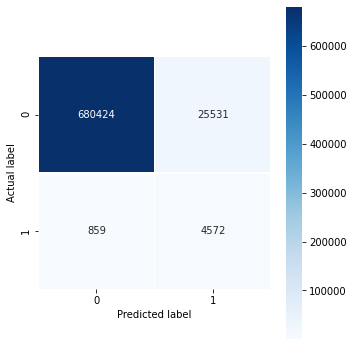

[0]	validation_0-aucpr:0.352379
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.415355
[2]	validation_0-aucpr:0.425539
[3]	validation_0-aucpr:0.444955
[4]	validation_0-aucpr:0.447422
[5]	validation_0-aucpr:0.465009
[6]	validation_0-aucpr:0.47016
[7]	validation_0-aucpr:0.483719
[8]	validation_0-aucpr:0.484521
[9]	validation_0-aucpr:0.486144
[10]	validation_0-aucpr:0.488745
[11]	validation_0-aucpr:0.490134
[12]	validation_0-aucpr:0.492359
[13]	validation_0-aucpr:0.493935
[14]	validation_0-aucpr:0.493212
[15]	validation_0-aucpr:0.494894
[16]	validation_0-aucpr:0.496137
[17]	validation_0-aucpr:0.503067
[18]	validation_0-aucpr:0.505341
[19]	validation_0-aucpr:0.506361
[20]	validation_0-aucpr:0.506094
[21]	validation_0-aucpr:0.506044
[22]	validation_0-aucpr:0.505012
[23]	validation_0-aucpr:0.506204
[24]	validation_0-aucpr:0.506905
[25]	validation_0-aucpr:0.508128
[26]	validation_0-aucpr:0.508842
[27]	validation_0-aucpr:0.508242
[28]	validation_0-auc

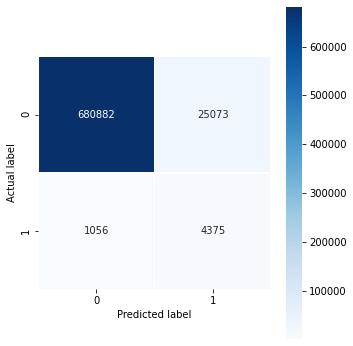

[0]	validation_0-aucpr:0.383817
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.438219
[2]	validation_0-aucpr:0.499751
[3]	validation_0-aucpr:0.513979
[4]	validation_0-aucpr:0.521033
[5]	validation_0-aucpr:0.527204
[6]	validation_0-aucpr:0.531224
[7]	validation_0-aucpr:0.536462
[8]	validation_0-aucpr:0.536386
[9]	validation_0-aucpr:0.535315
[10]	validation_0-aucpr:0.537477
[11]	validation_0-aucpr:0.538735
[12]	validation_0-aucpr:0.539431
[13]	validation_0-aucpr:0.539998
[14]	validation_0-aucpr:0.535115
[15]	validation_0-aucpr:0.541125
[16]	validation_0-aucpr:0.544338
[17]	validation_0-aucpr:0.542216
[18]	validation_0-aucpr:0.538073
[19]	validation_0-aucpr:0.540473
[20]	validation_0-aucpr:0.541559
[21]	validation_0-aucpr:0.546794
[22]	validation_0-aucpr:0.54657
[23]	validation_0-aucpr:0.543867
[24]	validation_0-aucpr:0.545728
[25]	validation_0-aucpr:0.547374
[26]	validation_0-aucpr:0.547366
[27]	validation_0-aucpr:0.549028
[28]	validation_0-auc

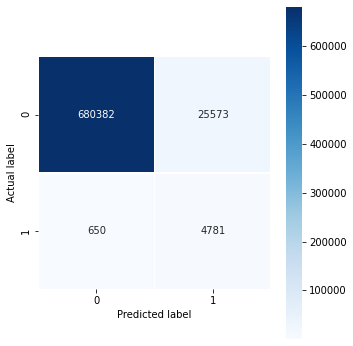

[0]	validation_0-aucpr:0.423655
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.519873
[2]	validation_0-aucpr:0.542561
[3]	validation_0-aucpr:0.556753
[4]	validation_0-aucpr:0.567523
[5]	validation_0-aucpr:0.573918
[6]	validation_0-aucpr:0.57887
[7]	validation_0-aucpr:0.584387
[8]	validation_0-aucpr:0.598081
[9]	validation_0-aucpr:0.601487
[10]	validation_0-aucpr:0.601645
[11]	validation_0-aucpr:0.602683
[12]	validation_0-aucpr:0.605944
[13]	validation_0-aucpr:0.612713
[14]	validation_0-aucpr:0.613755
[15]	validation_0-aucpr:0.61528
[16]	validation_0-aucpr:0.613349
[17]	validation_0-aucpr:0.616179
[18]	validation_0-aucpr:0.616626
[19]	validation_0-aucpr:0.617201
[20]	validation_0-aucpr:0.616789
[21]	validation_0-aucpr:0.616813
[22]	validation_0-aucpr:0.617739
[23]	validation_0-aucpr:0.620403
[24]	validation_0-aucpr:0.621918
[25]	validation_0-aucpr:0.621502
[26]	validation_0-aucpr:0.624815
[27]	validation_0-aucpr:0.625737
[28]	validation_0-aucp

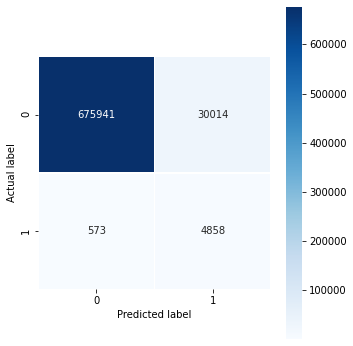

[0]	validation_0-aucpr:0.455827
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.530351
[2]	validation_0-aucpr:0.577138
[3]	validation_0-aucpr:0.593786
[4]	validation_0-aucpr:0.59696
[5]	validation_0-aucpr:0.599876
[6]	validation_0-aucpr:0.602564
[7]	validation_0-aucpr:0.608112
[8]	validation_0-aucpr:0.606894
[9]	validation_0-aucpr:0.610945
[10]	validation_0-aucpr:0.612287
[11]	validation_0-aucpr:0.61643
[12]	validation_0-aucpr:0.61736
[13]	validation_0-aucpr:0.619489
[14]	validation_0-aucpr:0.620952
[15]	validation_0-aucpr:0.625814
[16]	validation_0-aucpr:0.630229
[17]	validation_0-aucpr:0.632708
[18]	validation_0-aucpr:0.633393
[19]	validation_0-aucpr:0.634277
[20]	validation_0-aucpr:0.635042
[21]	validation_0-aucpr:0.635757
[22]	validation_0-aucpr:0.636017
[23]	validation_0-aucpr:0.636654
[24]	validation_0-aucpr:0.637552
[25]	validation_0-aucpr:0.637748
[26]	validation_0-aucpr:0.637216
[27]	validation_0-aucpr:0.638358
[28]	validation_0-aucpr

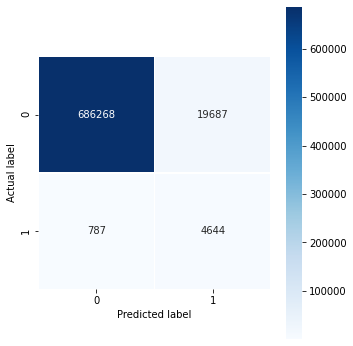

[0]	validation_0-aucpr:0.419747
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.491201
[2]	validation_0-aucpr:0.534828
[3]	validation_0-aucpr:0.54359
[4]	validation_0-aucpr:0.564068
[5]	validation_0-aucpr:0.569197
[6]	validation_0-aucpr:0.577652
[7]	validation_0-aucpr:0.581656
[8]	validation_0-aucpr:0.588168
[9]	validation_0-aucpr:0.592081
[10]	validation_0-aucpr:0.597145
[11]	validation_0-aucpr:0.600691
[12]	validation_0-aucpr:0.605712
[13]	validation_0-aucpr:0.60996
[14]	validation_0-aucpr:0.610356
[15]	validation_0-aucpr:0.609444
[16]	validation_0-aucpr:0.612911
[17]	validation_0-aucpr:0.616414
[18]	validation_0-aucpr:0.616835
[19]	validation_0-aucpr:0.617795
[20]	validation_0-aucpr:0.617806
[21]	validation_0-aucpr:0.618417
[22]	validation_0-aucpr:0.62156
[23]	validation_0-aucpr:0.621496
[24]	validation_0-aucpr:0.620001
[25]	validation_0-aucpr:0.620729
[26]	validation_0-aucpr:0.620743
[27]	validation_0-aucpr:0.622858
[28]	validation_0-aucpr

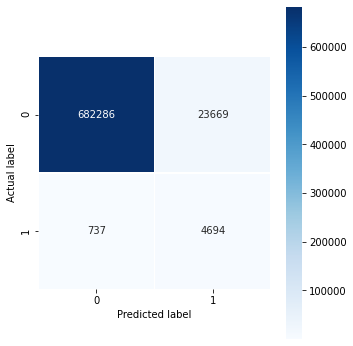

[0]	validation_0-aucpr:0.412537
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.498898
[2]	validation_0-aucpr:0.499057
[3]	validation_0-aucpr:0.516061
[4]	validation_0-aucpr:0.523751
[5]	validation_0-aucpr:0.534472
[6]	validation_0-aucpr:0.54305
[7]	validation_0-aucpr:0.552248
[8]	validation_0-aucpr:0.555746
[9]	validation_0-aucpr:0.55717
[10]	validation_0-aucpr:0.558601
[11]	validation_0-aucpr:0.557761
[12]	validation_0-aucpr:0.557144
[13]	validation_0-aucpr:0.56028
[14]	validation_0-aucpr:0.562067
[15]	validation_0-aucpr:0.561073
[16]	validation_0-aucpr:0.562199
[17]	validation_0-aucpr:0.560671
[18]	validation_0-aucpr:0.557786
[19]	validation_0-aucpr:0.558795
[20]	validation_0-aucpr:0.558651
[21]	validation_0-aucpr:0.558311
[22]	validation_0-aucpr:0.558901
[23]	validation_0-aucpr:0.559498
[24]	validation_0-aucpr:0.560176
[25]	validation_0-aucpr:0.56068
[26]	validation_0-aucpr:0.559231
Stopping. Best iteration:
[16]	validation_0-aucpr:0.56219

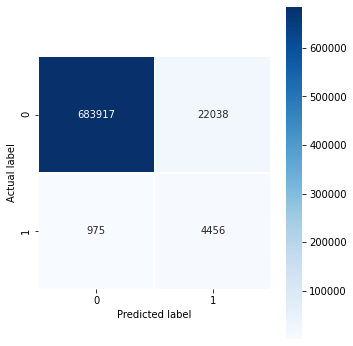

[0]	validation_0-aucpr:0.405693
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.499828
[2]	validation_0-aucpr:0.515
[3]	validation_0-aucpr:0.522947
[4]	validation_0-aucpr:0.524211
[5]	validation_0-aucpr:0.528012
[6]	validation_0-aucpr:0.527168
[7]	validation_0-aucpr:0.5342
[8]	validation_0-aucpr:0.534361
[9]	validation_0-aucpr:0.536988
[10]	validation_0-aucpr:0.53889
[11]	validation_0-aucpr:0.538665
[12]	validation_0-aucpr:0.547182
[13]	validation_0-aucpr:0.547866
[14]	validation_0-aucpr:0.540857
[15]	validation_0-aucpr:0.540125
[16]	validation_0-aucpr:0.554886
[17]	validation_0-aucpr:0.556044
[18]	validation_0-aucpr:0.556596
[19]	validation_0-aucpr:0.548538
[20]	validation_0-aucpr:0.554594
[21]	validation_0-aucpr:0.554731
[22]	validation_0-aucpr:0.555541
[23]	validation_0-aucpr:0.556055
[24]	validation_0-aucpr:0.548797
[25]	validation_0-aucpr:0.548756
[26]	validation_0-aucpr:0.548968
[27]	validation_0-aucpr:0.545127
[28]	validation_0-aucpr:0.

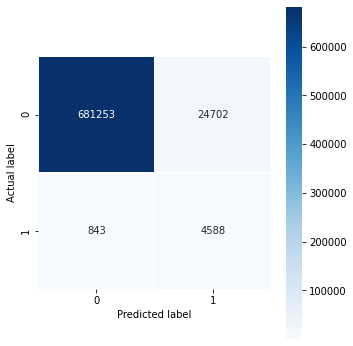

[0]	validation_0-aucpr:0.399533
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.535425
[2]	validation_0-aucpr:0.565282
[3]	validation_0-aucpr:0.583027
[4]	validation_0-aucpr:0.590828
[5]	validation_0-aucpr:0.588095
[6]	validation_0-aucpr:0.591783
[7]	validation_0-aucpr:0.59379
[8]	validation_0-aucpr:0.594687
[9]	validation_0-aucpr:0.591709
[10]	validation_0-aucpr:0.59581
[11]	validation_0-aucpr:0.596476
[12]	validation_0-aucpr:0.59363
[13]	validation_0-aucpr:0.594727
[14]	validation_0-aucpr:0.595113
[15]	validation_0-aucpr:0.589946
[16]	validation_0-aucpr:0.596784
[17]	validation_0-aucpr:0.599018
[18]	validation_0-aucpr:0.596496
[19]	validation_0-aucpr:0.593559
[20]	validation_0-aucpr:0.593518
[21]	validation_0-aucpr:0.594453
[22]	validation_0-aucpr:0.593244
[23]	validation_0-aucpr:0.593059
[24]	validation_0-aucpr:0.598274
[25]	validation_0-aucpr:0.598797
[26]	validation_0-aucpr:0.598974
[27]	validation_0-aucpr:0.604562
[28]	validation_0-aucpr

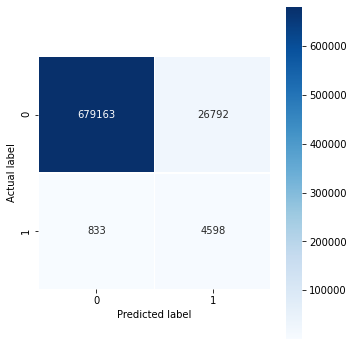

[0]	validation_0-aucpr:0.489012
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.558293
[2]	validation_0-aucpr:0.593409
[3]	validation_0-aucpr:0.597471
[4]	validation_0-aucpr:0.625576
[5]	validation_0-aucpr:0.635411
[6]	validation_0-aucpr:0.642175
[7]	validation_0-aucpr:0.647219
[8]	validation_0-aucpr:0.651172
[9]	validation_0-aucpr:0.65367
[10]	validation_0-aucpr:0.655068
[11]	validation_0-aucpr:0.656571
[12]	validation_0-aucpr:0.664534
[13]	validation_0-aucpr:0.663525
[14]	validation_0-aucpr:0.666266
[15]	validation_0-aucpr:0.66978
[16]	validation_0-aucpr:0.671759
[17]	validation_0-aucpr:0.672029
[18]	validation_0-aucpr:0.671626
[19]	validation_0-aucpr:0.671404
[20]	validation_0-aucpr:0.67153
[21]	validation_0-aucpr:0.672497
[22]	validation_0-aucpr:0.672801
[23]	validation_0-aucpr:0.671788
[24]	validation_0-aucpr:0.670749
[25]	validation_0-aucpr:0.669775
[26]	validation_0-aucpr:0.670002
[27]	validation_0-aucpr:0.668815
[28]	validation_0-aucpr

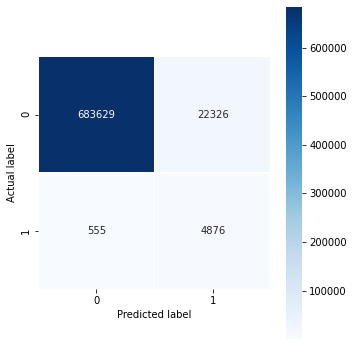

[0]	validation_0-aucpr:0.421341
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.504251
[2]	validation_0-aucpr:0.529644
[3]	validation_0-aucpr:0.545489
[4]	validation_0-aucpr:0.548486
[5]	validation_0-aucpr:0.549422
[6]	validation_0-aucpr:0.551948
[7]	validation_0-aucpr:0.563722
[8]	validation_0-aucpr:0.567486
[9]	validation_0-aucpr:0.566345
[10]	validation_0-aucpr:0.569446
[11]	validation_0-aucpr:0.570891
[12]	validation_0-aucpr:0.56951
[13]	validation_0-aucpr:0.567799
[14]	validation_0-aucpr:0.572493
[15]	validation_0-aucpr:0.569965
[16]	validation_0-aucpr:0.570912
[17]	validation_0-aucpr:0.565724
[18]	validation_0-aucpr:0.556426
[19]	validation_0-aucpr:0.555592
[20]	validation_0-aucpr:0.556348
[21]	validation_0-aucpr:0.554473
[22]	validation_0-aucpr:0.558964
[23]	validation_0-aucpr:0.55855
[24]	validation_0-aucpr:0.554284
Stopping. Best iteration:
[14]	validation_0-aucpr:0.572493

Prediction Report of trial 21
               precision    rec

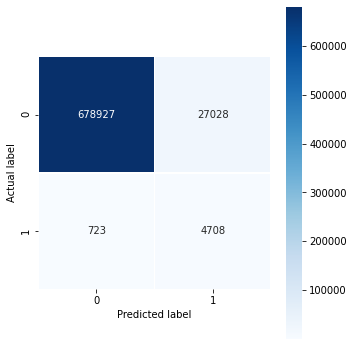

[0]	validation_0-aucpr:0.569274
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.662404
[2]	validation_0-aucpr:0.661829
[3]	validation_0-aucpr:0.663794
[4]	validation_0-aucpr:0.673362
[5]	validation_0-aucpr:0.672654
[6]	validation_0-aucpr:0.676363
[7]	validation_0-aucpr:0.679265
[8]	validation_0-aucpr:0.675486
[9]	validation_0-aucpr:0.683803
[10]	validation_0-aucpr:0.686867
[11]	validation_0-aucpr:0.689879
[12]	validation_0-aucpr:0.692556
[13]	validation_0-aucpr:0.691024
[14]	validation_0-aucpr:0.69291
[15]	validation_0-aucpr:0.689982
[16]	validation_0-aucpr:0.690993
[17]	validation_0-aucpr:0.690663
[18]	validation_0-aucpr:0.683026
[19]	validation_0-aucpr:0.682872
[20]	validation_0-aucpr:0.684436
[21]	validation_0-aucpr:0.684823
[22]	validation_0-aucpr:0.680652
[23]	validation_0-aucpr:0.682821
[24]	validation_0-aucpr:0.682593
Stopping. Best iteration:
[14]	validation_0-aucpr:0.69291

Prediction Report of trial 22
               precision    rec

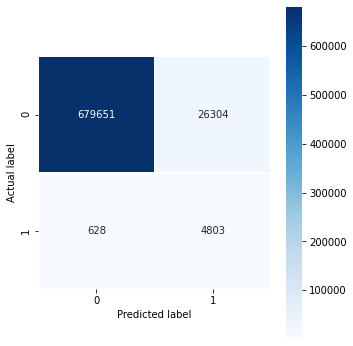

[0]	validation_0-aucpr:0.41976
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.47774
[2]	validation_0-aucpr:0.493192
[3]	validation_0-aucpr:0.516718
[4]	validation_0-aucpr:0.518725
[5]	validation_0-aucpr:0.526767
[6]	validation_0-aucpr:0.535139
[7]	validation_0-aucpr:0.542684
[8]	validation_0-aucpr:0.542572
[9]	validation_0-aucpr:0.548998
[10]	validation_0-aucpr:0.551785
[11]	validation_0-aucpr:0.550849
[12]	validation_0-aucpr:0.557441
[13]	validation_0-aucpr:0.559251
[14]	validation_0-aucpr:0.556831
[15]	validation_0-aucpr:0.560189
[16]	validation_0-aucpr:0.562782
[17]	validation_0-aucpr:0.565665
[18]	validation_0-aucpr:0.572957
[19]	validation_0-aucpr:0.573726
[20]	validation_0-aucpr:0.575779
[21]	validation_0-aucpr:0.577242
[22]	validation_0-aucpr:0.576722
[23]	validation_0-aucpr:0.576264
[24]	validation_0-aucpr:0.575982
[25]	validation_0-aucpr:0.57828
[26]	validation_0-aucpr:0.578886
[27]	validation_0-aucpr:0.579991
[28]	validation_0-aucpr

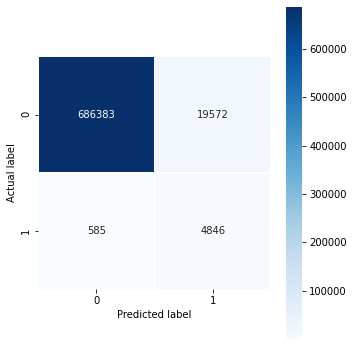

[0]	validation_0-aucpr:0.396829
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.469847
[2]	validation_0-aucpr:0.492519
[3]	validation_0-aucpr:0.505119
[4]	validation_0-aucpr:0.504168
[5]	validation_0-aucpr:0.5161
[6]	validation_0-aucpr:0.52648
[7]	validation_0-aucpr:0.53205
[8]	validation_0-aucpr:0.533518
[9]	validation_0-aucpr:0.533474
[10]	validation_0-aucpr:0.539116
[11]	validation_0-aucpr:0.545365
[12]	validation_0-aucpr:0.544929
[13]	validation_0-aucpr:0.549476
[14]	validation_0-aucpr:0.550157
[15]	validation_0-aucpr:0.550629
[16]	validation_0-aucpr:0.549902
[17]	validation_0-aucpr:0.550099
[18]	validation_0-aucpr:0.552335
[19]	validation_0-aucpr:0.552369
[20]	validation_0-aucpr:0.553799
[21]	validation_0-aucpr:0.551885
[22]	validation_0-aucpr:0.554333
[23]	validation_0-aucpr:0.556337
[24]	validation_0-aucpr:0.556302
[25]	validation_0-aucpr:0.555019
[26]	validation_0-aucpr:0.551901
[27]	validation_0-aucpr:0.553956
[28]	validation_0-aucpr:

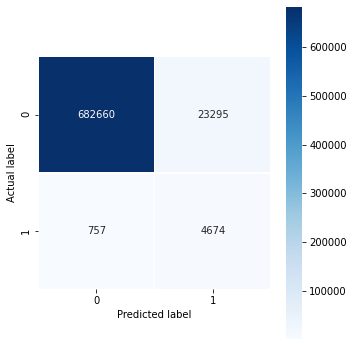

[0]	validation_0-aucpr:0.362454
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.444063
[2]	validation_0-aucpr:0.447355
[3]	validation_0-aucpr:0.451462
[4]	validation_0-aucpr:0.46716
[5]	validation_0-aucpr:0.46639
[6]	validation_0-aucpr:0.467704
[7]	validation_0-aucpr:0.470215
[8]	validation_0-aucpr:0.482071
[9]	validation_0-aucpr:0.480887
[10]	validation_0-aucpr:0.48019
[11]	validation_0-aucpr:0.485513
[12]	validation_0-aucpr:0.483354
[13]	validation_0-aucpr:0.482392
[14]	validation_0-aucpr:0.481532
[15]	validation_0-aucpr:0.48261
[16]	validation_0-aucpr:0.481256
[17]	validation_0-aucpr:0.481433
[18]	validation_0-aucpr:0.480048
[19]	validation_0-aucpr:0.479222
[20]	validation_0-aucpr:0.480759
[21]	validation_0-aucpr:0.480422
Stopping. Best iteration:
[11]	validation_0-aucpr:0.485513

Prediction Report of trial 25
               precision    recall  f1-score   support

           0       1.00      0.96      0.98    705955
           1       0.1

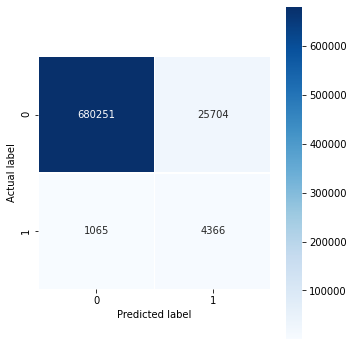

[0]	validation_0-aucpr:0.398921
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.474112
[2]	validation_0-aucpr:0.47815
[3]	validation_0-aucpr:0.500831
[4]	validation_0-aucpr:0.498006
[5]	validation_0-aucpr:0.492736
[6]	validation_0-aucpr:0.490389
[7]	validation_0-aucpr:0.487068
[8]	validation_0-aucpr:0.491853
[9]	validation_0-aucpr:0.483724
[10]	validation_0-aucpr:0.477445
[11]	validation_0-aucpr:0.480878
[12]	validation_0-aucpr:0.484239
[13]	validation_0-aucpr:0.488486
Stopping. Best iteration:
[3]	validation_0-aucpr:0.500831

Prediction Report of trial 26
               precision    recall  f1-score   support

           0       1.00      0.97      0.98    705955
           1       0.15      0.80      0.26      5431

    accuracy                           0.96    711386
   macro avg       0.58      0.88      0.62    711386
weighted avg       0.99      0.96      0.98    711386



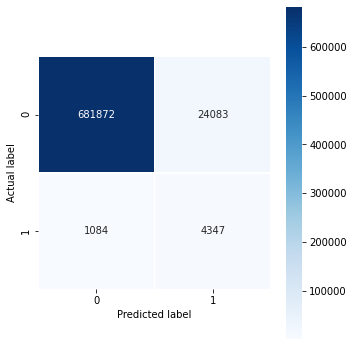

[0]	validation_0-aucpr:0.474919
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.57308
[2]	validation_0-aucpr:0.580983
[3]	validation_0-aucpr:0.587037
[4]	validation_0-aucpr:0.593436
[5]	validation_0-aucpr:0.5993
[6]	validation_0-aucpr:0.61279
[7]	validation_0-aucpr:0.614217
[8]	validation_0-aucpr:0.617584
[9]	validation_0-aucpr:0.619188
[10]	validation_0-aucpr:0.621899
[11]	validation_0-aucpr:0.623904
[12]	validation_0-aucpr:0.626887
[13]	validation_0-aucpr:0.63241
[14]	validation_0-aucpr:0.634871
[15]	validation_0-aucpr:0.633385
[16]	validation_0-aucpr:0.633282
[17]	validation_0-aucpr:0.634053
[18]	validation_0-aucpr:0.635634
[19]	validation_0-aucpr:0.639049
[20]	validation_0-aucpr:0.640466
[21]	validation_0-aucpr:0.640962
[22]	validation_0-aucpr:0.639909
[23]	validation_0-aucpr:0.641104
[24]	validation_0-aucpr:0.64189
[25]	validation_0-aucpr:0.643192
[26]	validation_0-aucpr:0.641622
[27]	validation_0-aucpr:0.64166
[28]	validation_0-aucpr:0.6

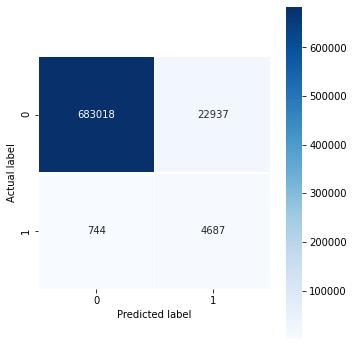

[0]	validation_0-aucpr:0.500332
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.58435
[2]	validation_0-aucpr:0.605355
[3]	validation_0-aucpr:0.620996
[4]	validation_0-aucpr:0.631904
[5]	validation_0-aucpr:0.636344
[6]	validation_0-aucpr:0.642283
[7]	validation_0-aucpr:0.641779
[8]	validation_0-aucpr:0.649477
[9]	validation_0-aucpr:0.650227
[10]	validation_0-aucpr:0.648333
[11]	validation_0-aucpr:0.651568
[12]	validation_0-aucpr:0.647515
[13]	validation_0-aucpr:0.650077
[14]	validation_0-aucpr:0.64959
[15]	validation_0-aucpr:0.652268
[16]	validation_0-aucpr:0.6526
[17]	validation_0-aucpr:0.651218
[18]	validation_0-aucpr:0.650972
[19]	validation_0-aucpr:0.654171
[20]	validation_0-aucpr:0.654984
[21]	validation_0-aucpr:0.65504
[22]	validation_0-aucpr:0.653109
[23]	validation_0-aucpr:0.656826
[24]	validation_0-aucpr:0.658866
[25]	validation_0-aucpr:0.658264
[26]	validation_0-aucpr:0.659942
[27]	validation_0-aucpr:0.659423
[28]	validation_0-aucpr:0

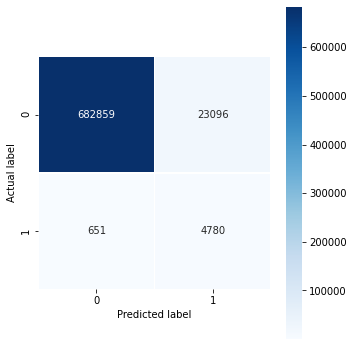

[0]	validation_0-aucpr:0.425888
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.510834
[2]	validation_0-aucpr:0.526147
[3]	validation_0-aucpr:0.530726
[4]	validation_0-aucpr:0.557776
[5]	validation_0-aucpr:0.564124
[6]	validation_0-aucpr:0.579209
[7]	validation_0-aucpr:0.58291
[8]	validation_0-aucpr:0.585795
[9]	validation_0-aucpr:0.587704
[10]	validation_0-aucpr:0.590229
[11]	validation_0-aucpr:0.590096
[12]	validation_0-aucpr:0.59669
[13]	validation_0-aucpr:0.598857
[14]	validation_0-aucpr:0.598696
[15]	validation_0-aucpr:0.602071
[16]	validation_0-aucpr:0.603289
[17]	validation_0-aucpr:0.608207
[18]	validation_0-aucpr:0.607322
[19]	validation_0-aucpr:0.608353
[20]	validation_0-aucpr:0.608902
[21]	validation_0-aucpr:0.62649
[22]	validation_0-aucpr:0.627766
[23]	validation_0-aucpr:0.626946
[24]	validation_0-aucpr:0.629172
[25]	validation_0-aucpr:0.628784
[26]	validation_0-aucpr:0.629135
[27]	validation_0-aucpr:0.631768
[28]	validation_0-aucpr

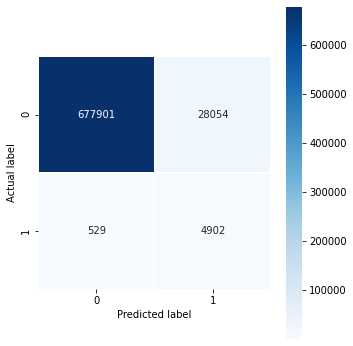

[0]	validation_0-aucpr:0.3642
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.442838
[2]	validation_0-aucpr:0.443234
[3]	validation_0-aucpr:0.450971
[4]	validation_0-aucpr:0.465462
[5]	validation_0-aucpr:0.469782
[6]	validation_0-aucpr:0.468123
[7]	validation_0-aucpr:0.472576
[8]	validation_0-aucpr:0.470516
[9]	validation_0-aucpr:0.472543
[10]	validation_0-aucpr:0.471447
[11]	validation_0-aucpr:0.478052
[12]	validation_0-aucpr:0.479325
[13]	validation_0-aucpr:0.47881
[14]	validation_0-aucpr:0.47965
[15]	validation_0-aucpr:0.47865
[16]	validation_0-aucpr:0.479581
[17]	validation_0-aucpr:0.479666
[18]	validation_0-aucpr:0.480421
[19]	validation_0-aucpr:0.480785
[20]	validation_0-aucpr:0.475559
[21]	validation_0-aucpr:0.474722
[22]	validation_0-aucpr:0.475358
[23]	validation_0-aucpr:0.474803
[24]	validation_0-aucpr:0.475495
[25]	validation_0-aucpr:0.47239
[26]	validation_0-aucpr:0.473131
[27]	validation_0-aucpr:0.473507
[28]	validation_0-aucpr:0.

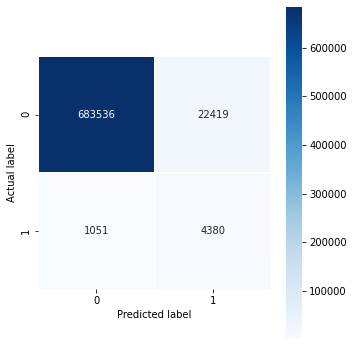

[0]	validation_0-aucpr:0.346889
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.466052
[2]	validation_0-aucpr:0.524837
[3]	validation_0-aucpr:0.550894
[4]	validation_0-aucpr:0.559052
[5]	validation_0-aucpr:0.559844
[6]	validation_0-aucpr:0.557169
[7]	validation_0-aucpr:0.577655
[8]	validation_0-aucpr:0.576372
[9]	validation_0-aucpr:0.576914
[10]	validation_0-aucpr:0.576329
[11]	validation_0-aucpr:0.573373
[12]	validation_0-aucpr:0.58625
[13]	validation_0-aucpr:0.588333
[14]	validation_0-aucpr:0.591632
[15]	validation_0-aucpr:0.592202
[16]	validation_0-aucpr:0.585621
[17]	validation_0-aucpr:0.58176
[18]	validation_0-aucpr:0.578169
[19]	validation_0-aucpr:0.576326
[20]	validation_0-aucpr:0.572807
[21]	validation_0-aucpr:0.569772
[22]	validation_0-aucpr:0.574265
[23]	validation_0-aucpr:0.573356
[24]	validation_0-aucpr:0.570363
[25]	validation_0-aucpr:0.569442
Stopping. Best iteration:
[15]	validation_0-aucpr:0.592202

Prediction Report of trial 3

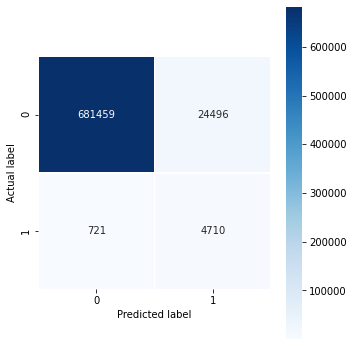

[0]	validation_0-aucpr:0.485805
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.578989
[2]	validation_0-aucpr:0.597204
[3]	validation_0-aucpr:0.594205
[4]	validation_0-aucpr:0.609843
[5]	validation_0-aucpr:0.615533
[6]	validation_0-aucpr:0.619754
[7]	validation_0-aucpr:0.630953
[8]	validation_0-aucpr:0.633988
[9]	validation_0-aucpr:0.634918
[10]	validation_0-aucpr:0.638287
[11]	validation_0-aucpr:0.639813
[12]	validation_0-aucpr:0.638315
[13]	validation_0-aucpr:0.640406
[14]	validation_0-aucpr:0.641094
[15]	validation_0-aucpr:0.641554
[16]	validation_0-aucpr:0.642755
[17]	validation_0-aucpr:0.64183
[18]	validation_0-aucpr:0.643267
[19]	validation_0-aucpr:0.64277
[20]	validation_0-aucpr:0.642905
[21]	validation_0-aucpr:0.642329
[22]	validation_0-aucpr:0.642944
[23]	validation_0-aucpr:0.645983
[24]	validation_0-aucpr:0.645196
[25]	validation_0-aucpr:0.645389
[26]	validation_0-aucpr:0.644608
[27]	validation_0-aucpr:0.645985
[28]	validation_0-aucp

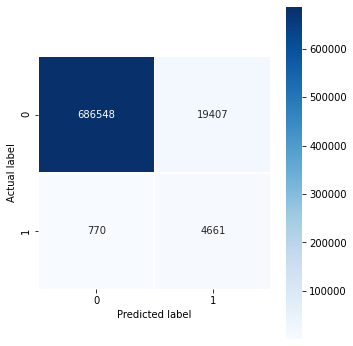

[0]	validation_0-aucpr:0.501182
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.603175
[2]	validation_0-aucpr:0.594026
[3]	validation_0-aucpr:0.590471
[4]	validation_0-aucpr:0.605546
[5]	validation_0-aucpr:0.607176
[6]	validation_0-aucpr:0.609225
[7]	validation_0-aucpr:0.603966
[8]	validation_0-aucpr:0.612204
[9]	validation_0-aucpr:0.609437
[10]	validation_0-aucpr:0.617597
[11]	validation_0-aucpr:0.61936
[12]	validation_0-aucpr:0.623166
[13]	validation_0-aucpr:0.612847
[14]	validation_0-aucpr:0.611964
[15]	validation_0-aucpr:0.60745
[16]	validation_0-aucpr:0.607477
[17]	validation_0-aucpr:0.609494
[18]	validation_0-aucpr:0.61316
[19]	validation_0-aucpr:0.61255
[20]	validation_0-aucpr:0.611376
[21]	validation_0-aucpr:0.607845
[22]	validation_0-aucpr:0.608827
Stopping. Best iteration:
[12]	validation_0-aucpr:0.623166

Prediction Report of trial 33
               precision    recall  f1-score   support

           0       1.00      0.97      0.98

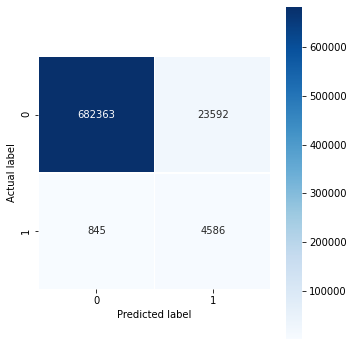

[0]	validation_0-aucpr:0.452312
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.532469
[2]	validation_0-aucpr:0.582332
[3]	validation_0-aucpr:0.605823
[4]	validation_0-aucpr:0.613103
[5]	validation_0-aucpr:0.615922
[6]	validation_0-aucpr:0.617955
[7]	validation_0-aucpr:0.621223
[8]	validation_0-aucpr:0.629924
[9]	validation_0-aucpr:0.631924
[10]	validation_0-aucpr:0.632884
[11]	validation_0-aucpr:0.63736
[12]	validation_0-aucpr:0.637573
[13]	validation_0-aucpr:0.639208
[14]	validation_0-aucpr:0.639671
[15]	validation_0-aucpr:0.637878
[16]	validation_0-aucpr:0.639062
[17]	validation_0-aucpr:0.639643
[18]	validation_0-aucpr:0.639211
[19]	validation_0-aucpr:0.640014
[20]	validation_0-aucpr:0.639031
[21]	validation_0-aucpr:0.639361
[22]	validation_0-aucpr:0.640914
[23]	validation_0-aucpr:0.640042
[24]	validation_0-aucpr:0.641485
[25]	validation_0-aucpr:0.641771
[26]	validation_0-aucpr:0.643829
[27]	validation_0-aucpr:0.645047
[28]	validation_0-auc

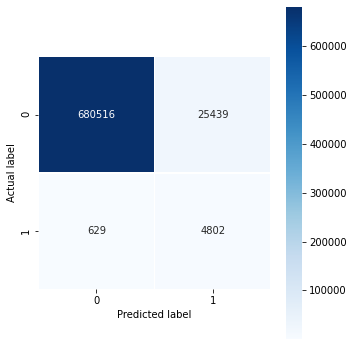

[0]	validation_0-aucpr:0.4881
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.574118
[2]	validation_0-aucpr:0.593906
[3]	validation_0-aucpr:0.599687
[4]	validation_0-aucpr:0.629511
[5]	validation_0-aucpr:0.634507
[6]	validation_0-aucpr:0.640057
[7]	validation_0-aucpr:0.641678
[8]	validation_0-aucpr:0.654348
[9]	validation_0-aucpr:0.654397
[10]	validation_0-aucpr:0.655874
[11]	validation_0-aucpr:0.657325
[12]	validation_0-aucpr:0.662366
[13]	validation_0-aucpr:0.662045
[14]	validation_0-aucpr:0.661405
[15]	validation_0-aucpr:0.663138
[16]	validation_0-aucpr:0.665121
[17]	validation_0-aucpr:0.666052
[18]	validation_0-aucpr:0.665353
[19]	validation_0-aucpr:0.66579
[20]	validation_0-aucpr:0.666248
[21]	validation_0-aucpr:0.667249
[22]	validation_0-aucpr:0.667814
[23]	validation_0-aucpr:0.667568
[24]	validation_0-aucpr:0.66827
[25]	validation_0-aucpr:0.667294
[26]	validation_0-aucpr:0.668587
[27]	validation_0-aucpr:0.680343
[28]	validation_0-aucpr:

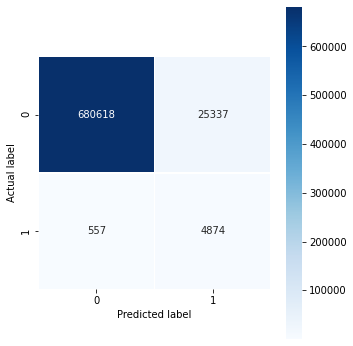

[0]	validation_0-aucpr:0.538243
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.628615
[2]	validation_0-aucpr:0.653493
[3]	validation_0-aucpr:0.663691
[4]	validation_0-aucpr:0.66499
[5]	validation_0-aucpr:0.664281
[6]	validation_0-aucpr:0.666638
[7]	validation_0-aucpr:0.677454
[8]	validation_0-aucpr:0.677664
[9]	validation_0-aucpr:0.675264
[10]	validation_0-aucpr:0.674974
[11]	validation_0-aucpr:0.677242
[12]	validation_0-aucpr:0.678065
[13]	validation_0-aucpr:0.672594
[14]	validation_0-aucpr:0.675009
[15]	validation_0-aucpr:0.671153
[16]	validation_0-aucpr:0.672961
[17]	validation_0-aucpr:0.674139
[18]	validation_0-aucpr:0.666251
[19]	validation_0-aucpr:0.66452
[20]	validation_0-aucpr:0.663277
[21]	validation_0-aucpr:0.662787
[22]	validation_0-aucpr:0.660993
Stopping. Best iteration:
[12]	validation_0-aucpr:0.678065

Prediction Report of trial 36
               precision    recall  f1-score   support

           0       1.00      0.96      0.

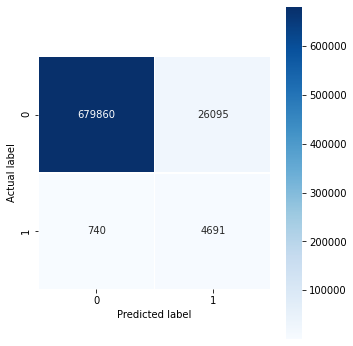

[0]	validation_0-aucpr:0.401853
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.48057
[2]	validation_0-aucpr:0.493357
[3]	validation_0-aucpr:0.495279
[4]	validation_0-aucpr:0.502563
[5]	validation_0-aucpr:0.504747
[6]	validation_0-aucpr:0.508044
[7]	validation_0-aucpr:0.510691
[8]	validation_0-aucpr:0.508003
[9]	validation_0-aucpr:0.508071
[10]	validation_0-aucpr:0.506833
[11]	validation_0-aucpr:0.50726
[12]	validation_0-aucpr:0.506794
[13]	validation_0-aucpr:0.506263
[14]	validation_0-aucpr:0.506418
[15]	validation_0-aucpr:0.509512
[16]	validation_0-aucpr:0.50818
[17]	validation_0-aucpr:0.50783
Stopping. Best iteration:
[7]	validation_0-aucpr:0.510691

Prediction Report of trial 37
               precision    recall  f1-score   support

           0       1.00      0.97      0.99    705955
           1       0.18      0.81      0.30      5431

    accuracy                           0.97    711386
   macro avg       0.59      0.89      0.64   

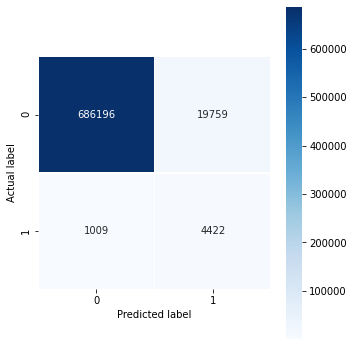

[0]	validation_0-aucpr:0.459219
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.548927
[2]	validation_0-aucpr:0.566487
[3]	validation_0-aucpr:0.544449
[4]	validation_0-aucpr:0.553502
[5]	validation_0-aucpr:0.55025
[6]	validation_0-aucpr:0.552937
[7]	validation_0-aucpr:0.548266
[8]	validation_0-aucpr:0.547974
[9]	validation_0-aucpr:0.557779
[10]	validation_0-aucpr:0.572412
[11]	validation_0-aucpr:0.575456
[12]	validation_0-aucpr:0.562652
[13]	validation_0-aucpr:0.556783
[14]	validation_0-aucpr:0.561892
[15]	validation_0-aucpr:0.554494
[16]	validation_0-aucpr:0.554226
[17]	validation_0-aucpr:0.554619
[18]	validation_0-aucpr:0.551849
[19]	validation_0-aucpr:0.555307
[20]	validation_0-aucpr:0.557349
[21]	validation_0-aucpr:0.553608
Stopping. Best iteration:
[11]	validation_0-aucpr:0.575456

Prediction Report of trial 38
               precision    recall  f1-score   support

           0       1.00      0.97      0.98    705955
           1       

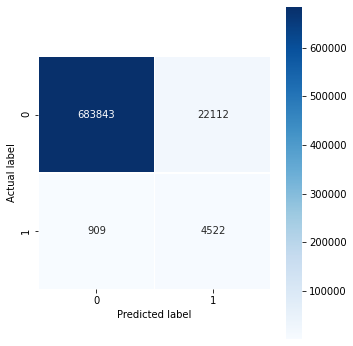

[0]	validation_0-aucpr:0.470126
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.624022
[2]	validation_0-aucpr:0.632073
[3]	validation_0-aucpr:0.658737
[4]	validation_0-aucpr:0.659539
[5]	validation_0-aucpr:0.671587
[6]	validation_0-aucpr:0.673815
[7]	validation_0-aucpr:0.67576
[8]	validation_0-aucpr:0.678052
[9]	validation_0-aucpr:0.683213
[10]	validation_0-aucpr:0.683621
[11]	validation_0-aucpr:0.674777
[12]	validation_0-aucpr:0.662835
[13]	validation_0-aucpr:0.656435
[14]	validation_0-aucpr:0.661182
[15]	validation_0-aucpr:0.664079
[16]	validation_0-aucpr:0.659281
[17]	validation_0-aucpr:0.663663
[18]	validation_0-aucpr:0.659349
[19]	validation_0-aucpr:0.656044
[20]	validation_0-aucpr:0.653442
Stopping. Best iteration:
[10]	validation_0-aucpr:0.683621

Prediction Report of trial 39
               precision    recall  f1-score   support

           0       1.00      0.97      0.98    705955
           1       0.19      0.90      0.31      543

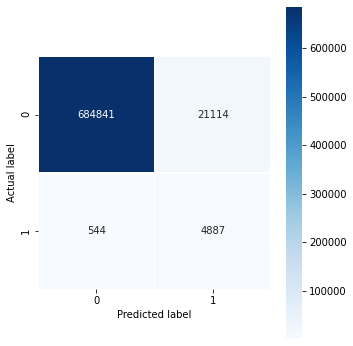

[0]	validation_0-aucpr:0.516745
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.491567
[2]	validation_0-aucpr:0.5543
[3]	validation_0-aucpr:0.564658
[4]	validation_0-aucpr:0.564081
[5]	validation_0-aucpr:0.564474
[6]	validation_0-aucpr:0.567761
[7]	validation_0-aucpr:0.571358
[8]	validation_0-aucpr:0.572268
[9]	validation_0-aucpr:0.578659
[10]	validation_0-aucpr:0.577025
[11]	validation_0-aucpr:0.592189
[12]	validation_0-aucpr:0.587567
[13]	validation_0-aucpr:0.587927
[14]	validation_0-aucpr:0.58731
[15]	validation_0-aucpr:0.591882
[16]	validation_0-aucpr:0.590753
[17]	validation_0-aucpr:0.588786
[18]	validation_0-aucpr:0.586769
[19]	validation_0-aucpr:0.591524
[20]	validation_0-aucpr:0.593235
[21]	validation_0-aucpr:0.59343
[22]	validation_0-aucpr:0.592678
[23]	validation_0-aucpr:0.592865
[24]	validation_0-aucpr:0.591653
[25]	validation_0-aucpr:0.589957
[26]	validation_0-aucpr:0.590343
[27]	validation_0-aucpr:0.591001
[28]	validation_0-aucpr:

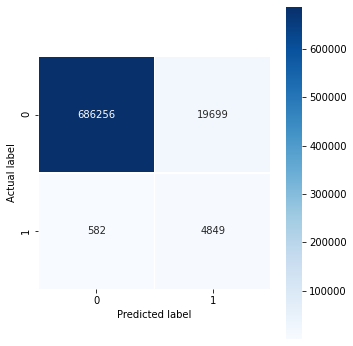

[0]	validation_0-aucpr:0.398528
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.50451
[2]	validation_0-aucpr:0.544082
[3]	validation_0-aucpr:0.54373
[4]	validation_0-aucpr:0.558163
[5]	validation_0-aucpr:0.563023
[6]	validation_0-aucpr:0.568538
[7]	validation_0-aucpr:0.568197
[8]	validation_0-aucpr:0.570107
[9]	validation_0-aucpr:0.572977
[10]	validation_0-aucpr:0.576082
[11]	validation_0-aucpr:0.57824
[12]	validation_0-aucpr:0.58185
[13]	validation_0-aucpr:0.585255
[14]	validation_0-aucpr:0.586868
[15]	validation_0-aucpr:0.590677
[16]	validation_0-aucpr:0.593288
[17]	validation_0-aucpr:0.594084
[18]	validation_0-aucpr:0.593206
[19]	validation_0-aucpr:0.592891
[20]	validation_0-aucpr:0.595406
[21]	validation_0-aucpr:0.597734
[22]	validation_0-aucpr:0.598621
[23]	validation_0-aucpr:0.599949
[24]	validation_0-aucpr:0.601018
[25]	validation_0-aucpr:0.599406
[26]	validation_0-aucpr:0.598718
[27]	validation_0-aucpr:0.599079
[28]	validation_0-aucpr:

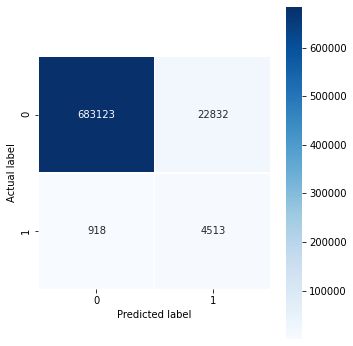

[0]	validation_0-aucpr:0.53747
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.586848
[2]	validation_0-aucpr:0.633914
[3]	validation_0-aucpr:0.638241
[4]	validation_0-aucpr:0.633851
[5]	validation_0-aucpr:0.630044
[6]	validation_0-aucpr:0.636621
[7]	validation_0-aucpr:0.636534
[8]	validation_0-aucpr:0.639722
[9]	validation_0-aucpr:0.641374
[10]	validation_0-aucpr:0.648836
[11]	validation_0-aucpr:0.653572
[12]	validation_0-aucpr:0.655039
[13]	validation_0-aucpr:0.655257
[14]	validation_0-aucpr:0.643962
[15]	validation_0-aucpr:0.640428
[16]	validation_0-aucpr:0.6423
[17]	validation_0-aucpr:0.633257
[18]	validation_0-aucpr:0.63082
[19]	validation_0-aucpr:0.626456
[20]	validation_0-aucpr:0.626248
[21]	validation_0-aucpr:0.626333
[22]	validation_0-aucpr:0.624986
[23]	validation_0-aucpr:0.622648
Stopping. Best iteration:
[13]	validation_0-aucpr:0.655257

Prediction Report of trial 42
               precision    recall  f1-score   support

          

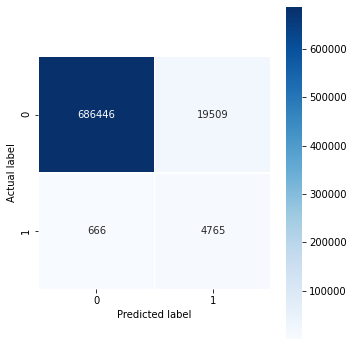

[0]	validation_0-aucpr:0.338511
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.499091
[2]	validation_0-aucpr:0.513364
[3]	validation_0-aucpr:0.527487
[4]	validation_0-aucpr:0.542965
[5]	validation_0-aucpr:0.541744
[6]	validation_0-aucpr:0.542685
[7]	validation_0-aucpr:0.539969
[8]	validation_0-aucpr:0.548716
[9]	validation_0-aucpr:0.550472
[10]	validation_0-aucpr:0.554141
[11]	validation_0-aucpr:0.55843
[12]	validation_0-aucpr:0.563345
[13]	validation_0-aucpr:0.554636
[14]	validation_0-aucpr:0.555303
[15]	validation_0-aucpr:0.555603
[16]	validation_0-aucpr:0.559984
[17]	validation_0-aucpr:0.563426
[18]	validation_0-aucpr:0.5571
[19]	validation_0-aucpr:0.556407
[20]	validation_0-aucpr:0.548115
[21]	validation_0-aucpr:0.554702
[22]	validation_0-aucpr:0.555799
[23]	validation_0-aucpr:0.555633
[24]	validation_0-aucpr:0.551948
[25]	validation_0-aucpr:0.553397
[26]	validation_0-aucpr:0.552697
[27]	validation_0-aucpr:0.553391
Stopping. Best iteratio

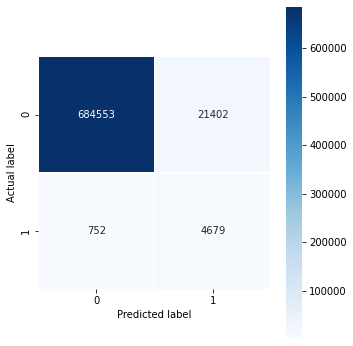

[0]	validation_0-aucpr:0.475607
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.594536
[2]	validation_0-aucpr:0.603405
[3]	validation_0-aucpr:0.608248
[4]	validation_0-aucpr:0.610851
[5]	validation_0-aucpr:0.613603
[6]	validation_0-aucpr:0.615197
[7]	validation_0-aucpr:0.616832
[8]	validation_0-aucpr:0.620606
[9]	validation_0-aucpr:0.609366
[10]	validation_0-aucpr:0.614005
[11]	validation_0-aucpr:0.618298
[12]	validation_0-aucpr:0.607864
[13]	validation_0-aucpr:0.610953
[14]	validation_0-aucpr:0.612222
[15]	validation_0-aucpr:0.614601
[16]	validation_0-aucpr:0.615786
[17]	validation_0-aucpr:0.618898
[18]	validation_0-aucpr:0.617949
Stopping. Best iteration:
[8]	validation_0-aucpr:0.620606

Prediction Report of trial 44
               precision    recall  f1-score   support

           0       1.00      0.96      0.98    705955
           1       0.15      0.85      0.25      5431

    accuracy                           0.96    711386
   macro 

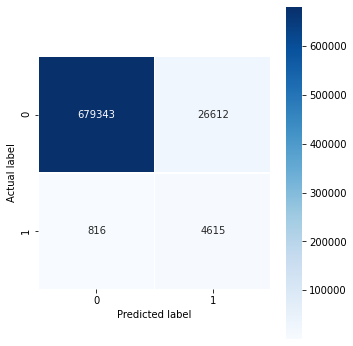

[0]	validation_0-aucpr:0.411654
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.499538
[2]	validation_0-aucpr:0.518687
[3]	validation_0-aucpr:0.534063
[4]	validation_0-aucpr:0.535387
[5]	validation_0-aucpr:0.536575
[6]	validation_0-aucpr:0.537232
[7]	validation_0-aucpr:0.540793
[8]	validation_0-aucpr:0.548455
[9]	validation_0-aucpr:0.549494
[10]	validation_0-aucpr:0.550309
[11]	validation_0-aucpr:0.552015
[12]	validation_0-aucpr:0.551761
[13]	validation_0-aucpr:0.555157
[14]	validation_0-aucpr:0.558516
[15]	validation_0-aucpr:0.559183
[16]	validation_0-aucpr:0.558359
[17]	validation_0-aucpr:0.558886
[18]	validation_0-aucpr:0.55982
[19]	validation_0-aucpr:0.560584
[20]	validation_0-aucpr:0.559576
[21]	validation_0-aucpr:0.560102
[22]	validation_0-aucpr:0.561877
[23]	validation_0-aucpr:0.562186
[24]	validation_0-aucpr:0.564137
[25]	validation_0-aucpr:0.565219
[26]	validation_0-aucpr:0.563288
[27]	validation_0-aucpr:0.563426
[28]	validation_0-auc

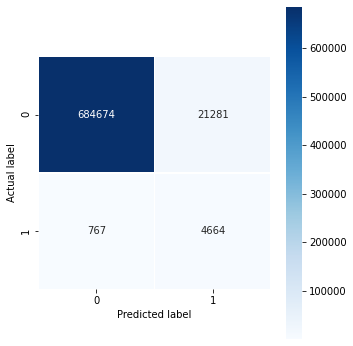

[0]	validation_0-aucpr:0.461506
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.538544
[2]	validation_0-aucpr:0.567031
[3]	validation_0-aucpr:0.578933
[4]	validation_0-aucpr:0.58097
[5]	validation_0-aucpr:0.584201
[6]	validation_0-aucpr:0.59566
[7]	validation_0-aucpr:0.594138
[8]	validation_0-aucpr:0.593997
[9]	validation_0-aucpr:0.603544
[10]	validation_0-aucpr:0.604532
[11]	validation_0-aucpr:0.604679
[12]	validation_0-aucpr:0.604188
[13]	validation_0-aucpr:0.607241
[14]	validation_0-aucpr:0.608562
[15]	validation_0-aucpr:0.609214
[16]	validation_0-aucpr:0.608964
[17]	validation_0-aucpr:0.609896
[18]	validation_0-aucpr:0.607892
[19]	validation_0-aucpr:0.602452
[20]	validation_0-aucpr:0.604581
[21]	validation_0-aucpr:0.5986
[22]	validation_0-aucpr:0.594399
[23]	validation_0-aucpr:0.59391
[24]	validation_0-aucpr:0.598437
[25]	validation_0-aucpr:0.599572
[26]	validation_0-aucpr:0.597643
[27]	validation_0-aucpr:0.595722
Stopping. Best iteration:

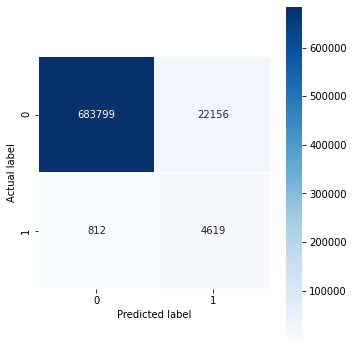

[0]	validation_0-aucpr:0.356507
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.433676
[2]	validation_0-aucpr:0.449178
[3]	validation_0-aucpr:0.465796
[4]	validation_0-aucpr:0.4691
[5]	validation_0-aucpr:0.471428
[6]	validation_0-aucpr:0.481101
[7]	validation_0-aucpr:0.485725
[8]	validation_0-aucpr:0.49189
[9]	validation_0-aucpr:0.507096
[10]	validation_0-aucpr:0.507915
[11]	validation_0-aucpr:0.511164
[12]	validation_0-aucpr:0.514471
[13]	validation_0-aucpr:0.518048
[14]	validation_0-aucpr:0.519261
[15]	validation_0-aucpr:0.532653
[16]	validation_0-aucpr:0.533668
[17]	validation_0-aucpr:0.539336
[18]	validation_0-aucpr:0.540195
[19]	validation_0-aucpr:0.540572
[20]	validation_0-aucpr:0.543581
[21]	validation_0-aucpr:0.545633
[22]	validation_0-aucpr:0.545357
[23]	validation_0-aucpr:0.548178
[24]	validation_0-aucpr:0.545991
[25]	validation_0-aucpr:0.545413
[26]	validation_0-aucpr:0.543913
[27]	validation_0-aucpr:0.546729
[28]	validation_0-aucpr

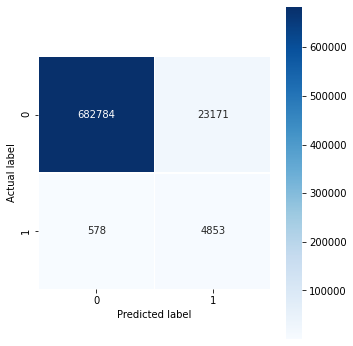

[0]	validation_0-aucpr:0.393379
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.475312
[2]	validation_0-aucpr:0.492677
[3]	validation_0-aucpr:0.512304
[4]	validation_0-aucpr:0.524017
[5]	validation_0-aucpr:0.524671
[6]	validation_0-aucpr:0.526665
[7]	validation_0-aucpr:0.530543
[8]	validation_0-aucpr:0.530999
[9]	validation_0-aucpr:0.531581
[10]	validation_0-aucpr:0.534006
[11]	validation_0-aucpr:0.539218
[12]	validation_0-aucpr:0.540011
[13]	validation_0-aucpr:0.541132
[14]	validation_0-aucpr:0.541129
[15]	validation_0-aucpr:0.543031
[16]	validation_0-aucpr:0.54344
[17]	validation_0-aucpr:0.544032
[18]	validation_0-aucpr:0.547266
[19]	validation_0-aucpr:0.548211
[20]	validation_0-aucpr:0.55082
[21]	validation_0-aucpr:0.551099
[22]	validation_0-aucpr:0.551693
[23]	validation_0-aucpr:0.551463
[24]	validation_0-aucpr:0.551796
[25]	validation_0-aucpr:0.552229
[26]	validation_0-aucpr:0.554013
[27]	validation_0-aucpr:0.554659
[28]	validation_0-aucp

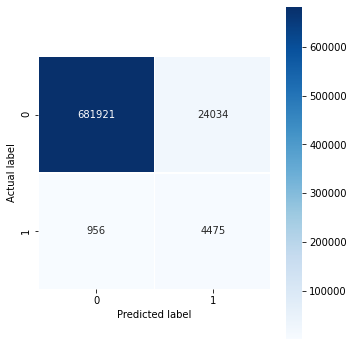

[0]	validation_0-aucpr:0.45347
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.442688
[2]	validation_0-aucpr:0.501316
[3]	validation_0-aucpr:0.484572
[4]	validation_0-aucpr:0.48978
[5]	validation_0-aucpr:0.488412
[6]	validation_0-aucpr:0.492304
[7]	validation_0-aucpr:0.519455
[8]	validation_0-aucpr:0.522583
[9]	validation_0-aucpr:0.533666
[10]	validation_0-aucpr:0.525739
[11]	validation_0-aucpr:0.547629
[12]	validation_0-aucpr:0.56708
[13]	validation_0-aucpr:0.560916
[14]	validation_0-aucpr:0.557219
[15]	validation_0-aucpr:0.562532
[16]	validation_0-aucpr:0.565764
[17]	validation_0-aucpr:0.561334
[18]	validation_0-aucpr:0.560582
[19]	validation_0-aucpr:0.562952
[20]	validation_0-aucpr:0.562969
[21]	validation_0-aucpr:0.566515
[22]	validation_0-aucpr:0.566812
Stopping. Best iteration:
[12]	validation_0-aucpr:0.56708

Prediction Report of trial 49
               precision    recall  f1-score   support

           0       1.00      0.96      0.98

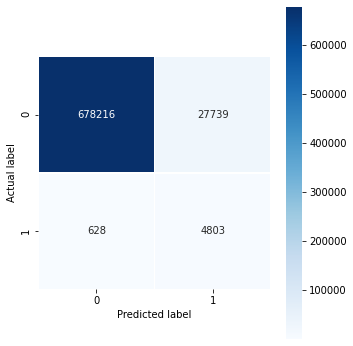

[0]	validation_0-aucpr:0.515126
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.579934
[2]	validation_0-aucpr:0.627734
[3]	validation_0-aucpr:0.653679
[4]	validation_0-aucpr:0.664042
[5]	validation_0-aucpr:0.667674
[6]	validation_0-aucpr:0.672787
[7]	validation_0-aucpr:0.674117
[8]	validation_0-aucpr:0.675938
[9]	validation_0-aucpr:0.676655
[10]	validation_0-aucpr:0.681473
[11]	validation_0-aucpr:0.681824
[12]	validation_0-aucpr:0.68245
[13]	validation_0-aucpr:0.683399
[14]	validation_0-aucpr:0.685137
[15]	validation_0-aucpr:0.685322
[16]	validation_0-aucpr:0.687872
[17]	validation_0-aucpr:0.68805
[18]	validation_0-aucpr:0.685388
[19]	validation_0-aucpr:0.685206
[20]	validation_0-aucpr:0.685833
[21]	validation_0-aucpr:0.683974
[22]	validation_0-aucpr:0.684547
[23]	validation_0-aucpr:0.686149
[24]	validation_0-aucpr:0.686906
[25]	validation_0-aucpr:0.685819
[26]	validation_0-aucpr:0.686176
[27]	validation_0-aucpr:0.687919
Stopping. Best iterati

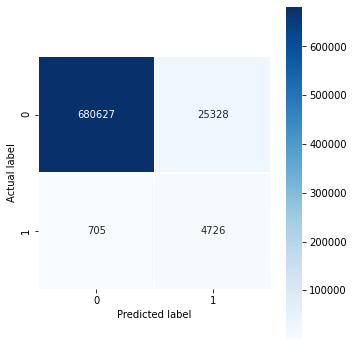

In [21]:
# xgboost 

shuffled_flow_id_loss = flow_id_loss.copy()
shuffled_flow_id_no_loss = flow_id_no_loss.copy()

recall_0_list_xgb_4 = []
recall_1_list_xgb_4 = []
recall_avg_list_xgb_4 = []

for trial in range(1, 51):
    random.seed(trial)
    
    random.shuffle(shuffled_flow_id_loss)
    random.shuffle(shuffled_flow_id_no_loss)
    
    df_loss_new = pd.concat([df_loss[df_loss['flow_id']==x] for x in shuffled_flow_id_loss])
    df_no_loss_new = pd.concat([df_no_loss[df_no_loss['flow_id']==x] for x in shuffled_flow_id_no_loss])
            
    df_train = pd.concat([df_loss_new.iloc[0:int(df_loss_new.shape[0] * 0.7)], df_no_loss_new.iloc[0:int(df_no_loss_new.shape[0] * 0.7)]])
    df_train_shuffled = df_train.sample(frac=1).reset_index()
    df_train_shuffled.drop(['index'], axis=1, inplace=True)
    df_test = pd.concat([df_loss_new.iloc[int(df_loss_new.shape[0] * 0.7)+1: -1], df_no_loss_new.iloc[int(df_no_loss_new.shape[0] * 0.7)+1: -1]])
    df_test_shuffled = df_test.sample(frac=1).reset_index()
    df_test_shuffled.drop(['index'], axis=1, inplace=True)

    x_train = df_train_shuffled[full_features_list_removing_500ms]
    x_test = df_test_shuffled[full_features_list_removing_500ms]
    y_train = df_train_shuffled[['lossOrNot']]
    y_train = y_train.astype(int)
    y_test = df_test_shuffled[['lossOrNot']]
    y_test = y_test.astype(int)
    
    clf_xgb_check = xgb.XGBClassifier(
        n_estimators=500, 
        objective='binary:logistic', 
        scale_pos_weight=weight, 
        n_jobs=48
    )
    
    clf_xgb_check.fit(x_train, y_train, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(x_test, y_test)])
            
    y_pred = clf_xgb_check.predict(x_test)
    print(f"Prediction Report of trial {trial}\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
    report = classification_report(y_test, y_pred, output_dict=True)
    recall_0_list_xgb_4.append(report['0']['recall'])
    recall_1_list_xgb_4.append(report['1']['recall'])
    recall_avg_list_xgb_4.append(report['macro avg']['recall'])

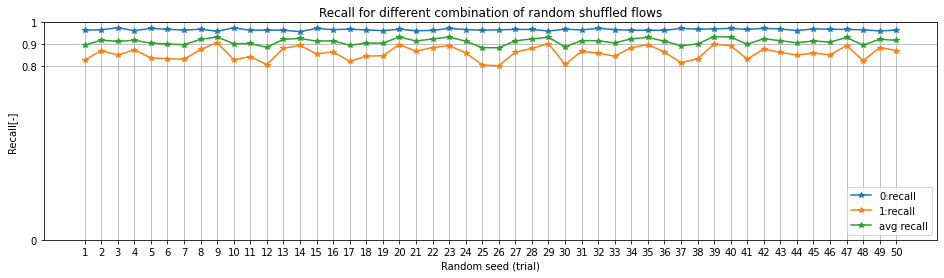

The best performance is at trial 39:
   recall of class 0: 0.9700915780750897
   recall of class 1: 0.8998342846621248
   macro average recall: 0.9349629313686072

The average is 0.9665945563102464 (0:recall), 0.8579745903148592 (1:recall), 0.9122845733125529 (avg recall)


In [34]:
x_label = list(range(1,51))
plt.figure(figsize=(16,4))
plt.plot(x_label, recall_0_list_xgb_4, '*-', label='0:recall')
plt.plot(x_label, recall_1_list_xgb_4, '*-', label='1:recall')
plt.plot(x_label, recall_avg_list_xgb_4, '*-', label='avg recall')
plt.xticks(x_label, x_label)
plt.legend(loc=4)
plt.grid()
plt.ylim([0,1])
plt.yticks([0, 0.8, 0.9, 1], [0, 0.8, 0.9, 1])
plt.title('Recall for different combination of random shuffled flows')
plt.xlabel('Random seed (trial)')
plt.ylabel('Recall[-]')
plt.show()

print(f'The best performance is at trial 39:\n   recall of class 0: {recall_0_list_xgb_4[38]}\n   recall of class 1: {recall_1_list_xgb_4[38]}\n   macro average recall: {recall_avg_list_xgb_4[38]}')
print()
print(f'The average is {np.array(recall_0_list_xgb_4).mean()} (0:recall), {np.array(recall_1_list_xgb_4).mean()} (1:recall), {np.array(recall_avg_list_xgb_4).mean()} (avg recall)')

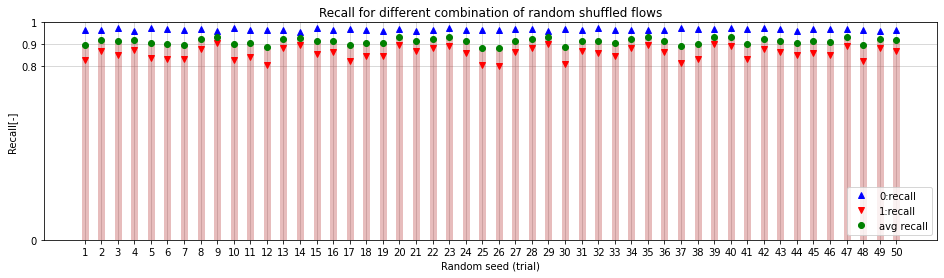

In [38]:
x_label = list(range(1,51))
plt.figure(figsize=(16,4))
plt.plot(x_label, recall_0_list_xgb_4, '^', label='0:recall', color='b')
plt.plot(x_label, recall_1_list_xgb_4, 'v', label='1:recall', color='r')
plt.plot(x_label, recall_avg_list_xgb_4, 'o', label='avg recall', color='g')
plt.vlines(x=x_label, ymin=0, ymax=recall_avg_list_xgb_4, linestyles='solid', color='firebrick', alpha=0.3, linewidth=7)
plt.xticks(x_label, x_label)
plt.legend(loc=4)
plt.grid(alpha=0.6)
plt.ylim([0,1])
plt.yticks([0, 0.8, 0.9, 1], [0, 0.8, 0.9, 1])
plt.title('Recall for different combination of random shuffled flows')
plt.xlabel('Random seed (trial)')
plt.ylabel('Recall[-]')
plt.show()

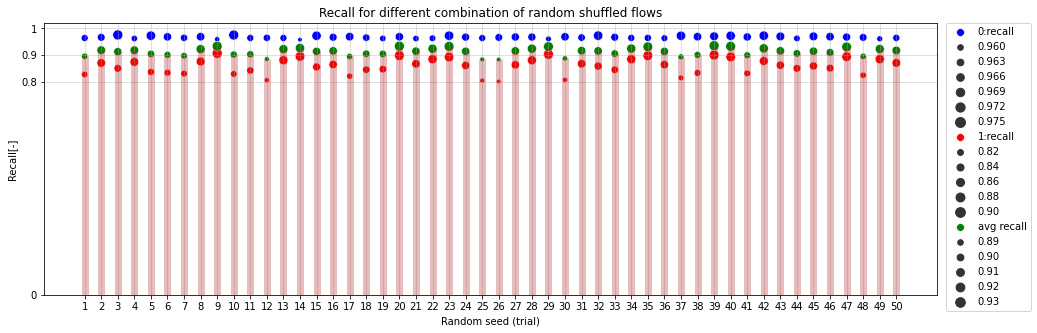

In [39]:
plt.figure(figsize=(16,5))
sns.scatterplot(x=x_label, y=recall_0_list_xgb_4, label='0:recall', size=recall_0_list_xgb_4, sizes=(20, 100), color='b')
sns.scatterplot(x=x_label, y=recall_1_list_xgb_4, label='1:recall', size=recall_1_list_xgb_4, sizes=(20, 100), color='r')
sns.scatterplot(x=x_label, y=recall_avg_list_xgb_4, label='avg recall', size=recall_avg_list_xgb_4, sizes=(20, 100), color='g')
plt.vlines(x=x_label, ymin=0, ymax=recall_avg_list_xgb_4, linestyles='solid', color='firebrick', alpha=0.3, linewidth=7)
plt.xticks(x_label, x_label)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.grid(alpha=0.5)
plt.ylim([0,1.02])
plt.yticks([0, 0.8, 0.9, 1], [0, 0.8, 0.9, 1])
plt.title('Recall for different combination of random shuffled flows')
plt.xlabel('Random seed (trial)')
plt.ylabel('Recall[-]')
plt.show()

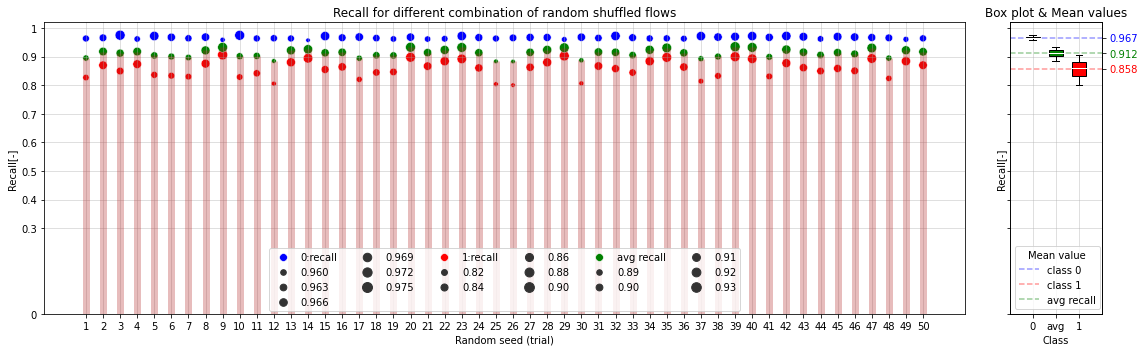

In [503]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), sharey=True, gridspec_kw={'width_ratios': [10, 1]})

sns.scatterplot(x=x_label, y=recall_0_list_xgb_4, label='0:recall', size=recall_0_list_xgb_4, sizes=(20, 100), color='b', ax=ax1)
sns.scatterplot(x=x_label, y=recall_1_list_xgb_4, label='1:recall', size=recall_1_list_xgb_4, sizes=(20, 100), color='r', ax=ax1)
sns.scatterplot(x=x_label, y=recall_avg_list_xgb_4, label='avg recall', size=recall_avg_list_xgb_4, sizes=(20, 100), color='g', ax=ax1)
ax1.vlines(x=x_label, ymin=0, ymax=recall_avg_list_xgb_4, linestyles='solid', color='firebrick', alpha=0.3, linewidth=7)
ax1.set_xticks(x_label)
ax1.legend(loc='lower center', bbox_to_anchor=(0.5, 0.01), borderaxespad=0, ncol=6)
ax1.grid(alpha=0.5)
plt.ylim([0,1.02])
plt.yticks([0, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], [0, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax1.set_xlabel('Random seed (trial)')
ax1.set_ylabel('Recall[-]')
ax1.set_title('Recall for different combination of random shuffled flows')

box = ax2.boxplot([recall_0_list_xgb_4, recall_1_list_xgb_4, recall_avg_list_xgb_4], positions=[1, 2, 1.5], widths=0.3, patch_artist=True) # meanline=True, showmeans=True
ax2.set_title('Box plot & Mean values')
ax2.set_xticks([1, 2, 1.5])
ax2.set_xticklabels(['0', '1', 'avg'])
ax2.set_xlabel('Class')
ax2.grid(alpha=0.5)
ax2.set_ylabel('Recall[-]')
# ax2.yaxis.set_label_position("right")
colors = ['blue', 'red', 'green']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
for median in box['medians']:
    median.set_color('white')
ax2.axhline(y=0.967, color='b', linestyle='--', alpha=0.4, label='class 0')
ax2.axhline(y=0.858, color='r', linestyle='--', alpha=0.4, label='class 1')
ax2.axhline(y=0.912, color='g', linestyle='--', alpha=0.4, label='avg recall')
ax2.legend(title='Mean value')
ax3 = ax2.twinx()
ax3.set_yticks([0.967, 0.858, 0.912])
ax3.set_ylim([0,1.02])
ax3.get_yticklabels()[0].set_color("b")
ax3.get_yticklabels()[1].set_color("r")
ax3.get_yticklabels()[2].set_color("g")

plt.tight_layout()
plt.show()

In [511]:
print(recall_0_list_xgb_4)
print(recall_1_list_xgb_4)
print(recall_avg_list_xgb_4)

[0.9636704889121828, 0.9661054883101614, 0.9751783045661551, 0.9619352508304354, 0.9723863419056455, 0.9680022097725776, 0.9643730832701801, 0.9685050746860635, 0.9590667960422407, 0.9747986769694952, 0.9638348053346176, 0.9644835718990588, 0.9637753114575291, 0.9574845422158637, 0.9721129533752151, 0.9664723672188738, 0.9687827127791432, 0.9650091011466737, 0.9620485725010801, 0.9683747547648222, 0.9617142735726781, 0.962739834692013, 0.9722758532767669, 0.9670021460291378, 0.9635897472218484, 0.9658859275732873, 0.967509260505273, 0.9672840336848666, 0.9602609231466595, 0.9682430183226977, 0.9653009044485839, 0.9725095792224717, 0.9665814393268692, 0.9639651252558591, 0.9641096103859311, 0.9630358875565723, 0.9720109638716349, 0.9686778902337968, 0.9700915780750897, 0.9720959551246184, 0.9676579951979942, 0.9723650940923997, 0.9696836200607687, 0.9623035462600308, 0.969855019087619, 0.9686155633149421, 0.9671777946186372, 0.9659553370965571, 0.9607071272248231, 0.9641223590738787]
[0

In [40]:
recall_0_list_xgb_4

[0.9636704889121828,
 0.9661054883101614,
 0.9751783045661551,
 0.9619352508304354,
 0.9723863419056455,
 0.9680022097725776,
 0.9643730832701801,
 0.9685050746860635,
 0.9590667960422407,
 0.9747986769694952,
 0.9638348053346176,
 0.9644835718990588,
 0.9637753114575291,
 0.9574845422158637,
 0.9721129533752151,
 0.9664723672188738,
 0.9687827127791432,
 0.9650091011466737,
 0.9620485725010801,
 0.9683747547648222,
 0.9617142735726781,
 0.962739834692013,
 0.9722758532767669,
 0.9670021460291378,
 0.9635897472218484,
 0.9658859275732873,
 0.967509260505273,
 0.9672840336848666,
 0.9602609231466595,
 0.9682430183226977,
 0.9653009044485839,
 0.9725095792224717,
 0.9665814393268692,
 0.9639651252558591,
 0.9641096103859311,
 0.9630358875565723,
 0.9720109638716349,
 0.9686778902337968,
 0.9700915780750897,
 0.9720959551246184,
 0.9676579951979942,
 0.9723650940923997,
 0.9696836200607687,
 0.9623035462600308,
 0.969855019087619,
 0.9686155633149421,
 0.9671777946186372,
 0.9659553370965

In [41]:
recall_1_list_xgb_4

[0.8269195359970539,
 0.8700055238445958,
 0.8497514269931873,
 0.8738722150616829,
 0.8363100718099797,
 0.8333640213588658,
 0.8300497146013626,
 0.8755293684404345,
 0.9064628981771313,
 0.8287608175290002,
 0.8418339164058184,
 0.8055606702264776,
 0.8803167004234947,
 0.8944945682194808,
 0.8550911434358314,
 0.8642975510955625,
 0.8204750506352422,
 0.8447799668569325,
 0.8466212483888786,
 0.897808874976984,
 0.8668753452402872,
 0.8843675197937765,
 0.8922850303811453,
 0.86061498803167,
 0.803903516847726,
 0.8004050819370282,
 0.8630086540232002,
 0.8801325722703002,
 0.9025962069600442,
 0.8064813109924508,
 0.8672436015466765,
 0.8582213220401399,
 0.8444117105505432,
 0.8841833916405818,
 0.8974406186705948,
 0.8637451666359787,
 0.8142146934266249,
 0.8326275087460873,
 0.8998342846621248,
 0.8928374148407291,
 0.8309703553673357,
 0.8773706499723808,
 0.8615356287976431,
 0.8497514269931873,
 0.8587737064997238,
 0.8504879396059658,
 0.8935739274535076,
 0.82397348554594

In [42]:
recall_avg_list_xgb_4

[0.8952950124546184,
 0.9180555060773786,
 0.9124648657796712,
 0.9179037329460591,
 0.9043482068578126,
 0.9006831155657217,
 0.8972113989357713,
 0.922017221563249,
 0.932764847109686,
 0.9017797472492477,
 0.9028343608702181,
 0.8850221210627682,
 0.922046005940512,
 0.9259895552176722,
 0.9136020484055232,
 0.9153849591572181,
 0.8946288817071927,
 0.9048945340018031,
 0.9043349104449794,
 0.9330918148709031,
 0.9142948094064827,
 0.9235536772428947,
 0.9322804418289561,
 0.9138085670304039,
 0.8837466320347872,
 0.8831455047551577,
 0.9152589572642366,
 0.9237083029775834,
 0.9314285650533518,
 0.8873621646575742,
 0.9162722529976302,
 0.9153654506313058,
 0.9054965749387063,
 0.9240742584482204,
 0.930775114528263,
 0.9133905270962754,
 0.8931128286491299,
 0.900652699489942,
 0.9349629313686072,
 0.9324666849826737,
 0.899314175282665,
 0.9248678720323902,
 0.9156096244292059,
 0.906027486626609,
 0.9143143627936714,
 0.909551751460454,
 0.9303758610360724,
 0.8949644113212485,
